In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report
import json
import tldextract
import csv
import os
import editdistance
import re
import pickle

In [3]:
data_phishing = ''
data_legitimate = ''


with open("phishing_URLs.json", "r") as read_file:
    data_phishing = json.load(read_file)

with open("legitimate_URLs.json", "r") as read_file:
    data_legitimate = json.load(read_file)

df_phishing = pd.DataFrame({'url':data_phishing,'Label':1})
df_legitimate = pd.DataFrame({'url':data_legitimate,'Label':-1})
print("df_phishing   : ",len(df_phishing))
print("df_legitimate : ",len(df_legitimate))

frame = [df_phishing,df_legitimate]

df =pd.concat(frame)

df.index = pd.RangeIndex(len(df.index))
df.head()

df_phishing   :  10742
df_legitimate :  11693


,url,Label
0,apple-iforget.com,1
1,safe-id-login.com,1
2,manage.netflix.com.usermanagement.key.1973573....,1
3,manage.netflix.com.usermanagement.key.1973574....,1
4,helpplusinfo01.com,1


# Feature Extraction

In [32]:
def words_raw_extraction(domain,subdomain,path):
    
    w_domain = re.split("\-|\.|\/|\?|\=|\@|&|\%|\:|\_|\+",domain.lower())
    w_subdomain = re.split("\-|\.|\/|\?|\=|\@|&|\%|\:|\_|\+",subdomain.lower())
    w_path = re.split("\-|\.|\/|\?|\=|\@|&|\%|\:|\_|\+",path.lower())
    
    raw_words = w_domain+w_path+w_subdomain
    
    raw_words = list(filter(None,raw_words))
    
    return raw_words

In [2]:


class nlp_class:

    def __init__(self):
        self.path_data = ""
        self.name_keywords = "keywords.txt"
        self.name_brand_file = "allbrands.txt"
        self.name_random_model = "HM_model.pki"

        model_data = pickle.load(open(self.name_random_model, 'rb'))
        self.model_mat = model_data['mat']
        self.threshold = model_data['thresh']

        self.keywords = self.__txt_to_list(open(self.name_keywords, "r"))

        self.allbrand = self.__txt_to_list(open(self.name_brand_file, "r"))

    def __txt_to_list(self, txt_object):
        list = []

        for line in txt_object:
            list.append(line.strip())
        txt_object.close()
        return list

    def __is_similar_to_any_element(self, word, list):

        target = ''
        for l in list:
            if editdistance.eval(word, l) < 2:
                target = l

        if len(target) > 0:
            return word
        else:
            return 0

    def parse(self, words):

        keywords_in_words = []
        brands_in_words = []
        similar_to_brands = []
        similar_to_keywords = []
        dga_in_words = []
        len_gt_7 = []
        len_lt_7 = []
        try:
            for word in words:

                word = re.sub("\d+", "", word)

                if word in self.keywords:
                    keywords_in_words.append(word)

                elif word in self.allbrand:
                    brands_in_words.append(word)

                elif self.__is_similar_to_any_element(word, self.allbrand) != 0:
                    target = self.__is_similar_to_any_element(word, self.allbrand)
                    similar_to_brands.append(target)

                elif self.__is_similar_to_any_element(word, self.keywords) != 0:
                    target = self.__is_similar_to_any_element(word, self.keywords)
                    similar_to_keywords.append(target)

                elif len(word) > 3 and not word.isnumeric():

                    if (avg_transition_prob(word, self.model_mat) > self.threshold) == False:
                        dga_in_words.append(word)
                    elif len(word) < 7:
                        len_lt_7.append(word)
                    else:
                        len_gt_7.append(word)

            result = {'keywords_in_words': keywords_in_words, 'brands_in_words': brands_in_words,
                      'dga_in_words': dga_in_words, 'len_lt_7': len_lt_7, 'len_gt_7': len_gt_7,
                      'similar_to_brands': similar_to_brands, 'similar_to_keywords': similar_to_keywords}
        except:
            print(str(words) + " error processing")
            print("Error : {0}".format(format_exc()))

        return result

    def fraud_analysis(self, grouped_words, splitted_words):

        word_list = grouped_words['len_lt_7'] + grouped_words['similar_to_brands'] + grouped_words[
            'similar_to_keywords'] + splitted_words

        word_list_nlp = grouped_words['len_lt_7'] + grouped_words['similar_to_brands'] + \
                        grouped_words['similar_to_keywords'] + grouped_words['brands_in_words'] + \
                        grouped_words['keywords_in_words'] + grouped_words['dga_in_words'] + splitted_words

        found_keywords = []
        found_brands = []
        similar_to_keyword = []
        similar_to_brand = []
        other_words = []
        target_words = {'brand': [], 'keyword': []}
        try:
            for word in word_list:

                word = re.sub("\d+", "", word)

                if word in self.keywords:
                    found_keywords.append(word)
                elif word in self.allbrand:
                    found_brands.append(word)
                else:

                    for brand in self.allbrand:
                        if editdistance.eval(word, brand) < 2:
                            target_words['brand'].append(brand)
                            similar_to_brand.append(word)

                    for keyword in self.keywords:
                        if editdistance.eval(word, keyword) < 2:
                            target_words['keyword'].append(keyword)
                            similar_to_keyword.append(word)

                if word not in found_keywords+found_brands+similar_to_keyword+similar_to_brand:
                    other_words.append(word)

            result = {'found_keywords': found_keywords,
                      'found_brands': found_brands,
                      'similar_to_keywords': similar_to_keyword,
                      'similar_to_brands': similar_to_brand,
                      'other_words': other_words,
                      'target_words': target_words,
                      'words_nlp': word_list_nlp}
        except:
            print(str(word_list)+" error processing")
            print("Error : {0}".format(format_exc()))
        return result

    def evaluate(self, grouped_words, fraud_analyze_result, splitted_words):

       
        try:
            words_raw = grouped_words['keywords_in_words'] + grouped_words['brands_in_words'] + \
                        grouped_words['similar_to_brands'] + grouped_words['similar_to_keywords'] + \
                        grouped_words['dga_in_words'] + grouped_words['len_lt_7'] + grouped_words['len_gt_7']

            words_len = []
            compound_word_len = []

            for word in words_raw:
                words_len.append(len(word))

            for word in grouped_words['len_gt_7']:
                compound_word_len.append(len(word))

            all_keywords = grouped_words['keywords_in_words'] + fraud_analyze_result['found_keywords']
            all_brands = grouped_words['brands_in_words'] + fraud_analyze_result['found_brands']
            similar_brands = fraud_analyze_result['similar_to_brands']
            similar_keywords = fraud_analyze_result['similar_to_keywords']

            if len(compound_word_len) == 0:
                av_com = 0
            else:
                av_com = float(np.average(compound_word_len))

            if len(words_len) == 0:
                min = 0
                max = 0
                av_w = 0
                std = 0
            else:
                min = int(np.min(words_len))
                max = int(np.max(words_len))
                av_w = float(np.average(words_len))
                std = float(np.std(words_len))

            result = {'info': {'keywords': all_keywords,
                               'brands': all_brands,
                               'dga_in_words': grouped_words['dga_in_words'],
                               'similar_to_keywords': similar_keywords,
                               'similar_to_brands': similar_brands,
                               'negligible_words': fraud_analyze_result['other_words'],
                               'target_words': fraud_analyze_result['target_words'],
                               'words_nlp': fraud_analyze_result['words_nlp']
                               },
                      'features': {'raw_word_count': len(words_len),
                                   'splitted_word_count': len(splitted_words),
                                   'average_word_length': av_w,
                                   'longest_word_length': max,
                                   'shortest_word_length': min,
                                   'std_word_length': std,
                                   'compound_word_count': len(grouped_words['len_gt_7']),
                                   'keyword_count': len(all_keywords),
                                   'brand_name_count': len(all_brands),
                                   'negligible_word_count': len(fraud_analyze_result['other_words']),
                                   'target_brand_count': len(fraud_analyze_result['target_words']['brand']),
                                   'target_keyword_count': len(fraud_analyze_result['target_words']['keyword']),
                                   'similar_keyword_count': len(similar_keywords),
                                   'similar_brand_count': len(similar_brands),
                                   'average_compound_words': av_com,
                                   'random_words': len(grouped_words['dga_in_words'])
                                   }}
        except:
            print("Error : {0}".format(format_exc()))
        return result

    def check_word_random(self, word):

        if avg_transition_prob(word, self.model_mat) < self.threshold:
            return 1
        else:
            return 0




In [34]:

import enchant



class WordSplitterClass(object):

    def __init__(self):

        self.path_data = ""
        self.name_brand_file = "allbrands.txt"
        self.dictionary_en = enchant.DictWithPWL("en_US", self.name_brand_file)


    def _split(self, gt7_word_list):

        return_word_list = []

        for word in gt7_word_list:
            try:
                ss = {'raw': word,'splitted':[]}

                word = re.sub("\d+", "", word)
                sub_words = []

                if not self.dictionary_en.check(word):
                    for number in range(len(word), 3, -1): 
                        for l in range(0, len(word) - number + 1):
                            if self.dictionary_en.check(self.__capitalize(word[l:l + number])):
                                sub_words.append(word[l:l + number])
                                word = word.replace(word[l:l + number], "*" * len(word[l:l + number]))

                    rest = max(re.split("\*+", word), key=len)
                    if len(rest) > 3:
                        sub_words.append(rest)

                    split_w = sub_words

                    for l in split_w:
                        for w in reversed(split_w):

                            if l != w:  
                                if l.find(w) != -1 or l.find(w.lower()) != -1:
                                    sub_words.remove(w)

                    if len(sub_words) == 0:
                        sub_words.append(word.lower())
                else:
                    sub_words.append(word.lower())

                ss['splitted']=sub_words
                return_word_list.append(ss)
            except:
                print("|"+word+"| error processing")
                print("word_splitter.split()  possibly error arriving empty array  /  Error : {0}".format(format_exc()))

        return return_word_list

    def _splitl(self, gt7_word_list):

        result = []

        for val in self._split(gt7_word_list):
            result += val["splitted"]

        return result

    def _splitw(self, word):

        word_l = []
        word_l.append(word)

        result = self._split(word_l)

        return result


    def __to_lower(self, sub_words):

        lower_sub_list = []

        for w in sub_words:
            lower_sub_list.append(str(w.lower()))

        return lower_sub_list

    def __capitalize(self, word):
        return word[0].upper() + word[1:]

   

In [35]:

import math
import pickle

accepted_chars = 'abcdefghijklmnopqrstuvwxyz'

pos = dict([(char, idx) for idx, char in enumerate(accepted_chars)])

def normalize(line):
   
    return [c.lower() for c in line if c.lower() in accepted_chars]

def ngram(n, l):
    filtered = normalize(l)
    
    for start in range(0, len(filtered) - n + 1):
        yield ''.join(filtered[start:start + n])


def avg_transition_prob(l, log_prob_mat):
    log_prob = 0.0
    transition_ct = 0
    for a, b in ngram(2, l):
        log_prob += log_prob_mat[pos[a]][pos[b]]
        transition_ct += 1
    return math.exp(log_prob / (transition_ct or 1))



In [36]:
data = df
data.tail()

,url,Label
22430,https://knowcitrixx.wordpress.com/2014/11/22/o...,-1
22431,https://www.youtube.com/watch?v=e5DEVa9eSN0,-1
22432,https://en.wikipedia.org/wiki/Market_segmentation,-1
22433,http://www.netmba.com/marketing/market/segment...,-1
22434,http://www.investopedia.com/terms/m/marketsegm...,-1


In [37]:
url_dataset = data.copy()
print(url_dataset)

                                                     url  Label
0                                      apple-iforget.com      1
1                                      safe-id-login.com      1
2      manage.netflix.com.usermanagement.key.1973573....      1
3      manage.netflix.com.usermanagement.key.1973574....      1
4                                     helpplusinfo01.com      1
...                                                  ...    ...
22430  https://knowcitrixx.wordpress.com/2014/11/22/o...     -1
22431        https://www.youtube.com/watch?v=e5DEVa9eSN0     -1
22432  https://en.wikipedia.org/wiki/Market_segmentation     -1
22433  http://www.netmba.com/marketing/market/segment...     -1
22434  http://www.investopedia.com/terms/m/marketsegm...     -1

[22435 rows x 2 columns]


In [38]:
url_dataset = data[['url','Label']]
print(url_dataset)

                                                     url  Label
0                                      apple-iforget.com      1
1                                      safe-id-login.com      1
2      manage.netflix.com.usermanagement.key.1973573....      1
3      manage.netflix.com.usermanagement.key.1973574....      1
4                                     helpplusinfo01.com      1
...                                                  ...    ...
22430  https://knowcitrixx.wordpress.com/2014/11/22/o...     -1
22431        https://www.youtube.com/watch?v=e5DEVa9eSN0     -1
22432  https://en.wikipedia.org/wiki/Market_segmentation     -1
22433  http://www.netmba.com/marketing/market/segment...     -1
22434  http://www.investopedia.com/terms/m/marketsegm...     -1

[22435 rows x 2 columns]


In [39]:
url_dataset.head().T


,0,1,2,3,4
url,apple-iforget.com,safe-id-login.com,manage.netflix.com.usermanagement.key.1973573....,manage.netflix.com.usermanagement.key.1973574....,helpplusinfo01.com
Label,1,1,1,1,1


In [4]:
#from domain_parser import domain_parser
import math



def parse_url(url_data):
  try:
    extract_result = tldextract.extract(url_data)
    return (extract_result.subdomain,extract_result.domain,extract_result.suffix)#domain_parser.parse_domain(url_data)
  except Exception as e:
    return ("","","")

def digit_count(data):
  data =str(data)
  return sum(c.isdigit() for c in data)

def get_length(data):
  return len(data)

def issubdomainwww(x):
    if x == 'www':
        return True
    return False

def tld_check(tld):
    if tld is None:
        return False
    
    
    common_tld = ['com', 'biz', 'net', 'info', 'ru', 'website', 'online', 'us',
       'vip', 'co', 'me', 'org', 'cl', 'co.uk', 'id', 'vn', 'in',
       'lt', 'co.id', 'by', 'com.br', 'eu', 'pk', 'com.bd', 'ga', 'es',
       'ch', 'com.pl', 'com.my', 'lk', 'pt', 'com.pe', 'no', 'gq',
       'com.au', 'hosting', 'vu', 'ac.in', 'go.id', 'pro', 'de', 'pl',
       'web.id', 'cc', 'com.vn', 'se', 'cn', 'edu', 'mobi', 'com.pk',
       'gr', 'ca', 'ie', 'org.mx', 'tv', 'biz.tr', 'win', 'cf', 'com.sa',
       'com.ua', 'co.za', 'mx', 'waw.pl', 'ro', 'co.nz', 'org.br', 'be',
       'it', 'hu', 'com.tr', 'my', 'desi', 'at', 'com.jo', 'xyz',
       'com.co', 'com.ar', 'fi', 'tools', 'edu.ua', 'edu.bd', 'com.np',
       'sg', 'asia', 'ma', 'nl', 'com.ng', 'io', 'com.tw', 'edu.pe',
       'com.ph', 'org.uk', 'szczecin.pl', 'ge', 'co.in', 'gov.lk', 'nf',
       'fr', 'co.ke', 'cz', 'club', 'ir', 'ac', 'dk', 'tech', 'edu.pl',
       'ua', 'systems', 'com.gr', 'ws', 'org.au', 'co.il', 'ae', 'com.mx',
       'lv', 'tk', 'com.ve', 'md', 'la', 'rs', 'kz', 'com.uy', 'aero',
       'or.id', 'link', 'edu.lb', 'co.ao', 'sk', 'top', 'or.ke', 'in.ua',
       'co.rs', 'rec.br', 'download', 'site', 'com.bo', 'am', 'sch.id',
       'gov.bd', 'net.au', 'mn', 'nu', 'edu.in', 'org.ng', 'com.bt', 'af',
       'si', 'co.th', 'uz', 'bm', 'net.gr', 'lu', 'gob.pe', 'org.za',
       'com.py', 'com.sg', 'co.kr', 'ink', 'RU', 'or.tz', 'su',
       'solutions', 'ly', 'co.zw', 'com.cn', 'sl', 'adv.br', 'org.ph',
       'bz', 'org.pk', 'bg', 'nyc', 'com.fj', 'org.bd', 'net.tr',
       'com.mk', 'zp.ua', 'edu.vn', 'ac.id', 'edu.ng', 'solar', 'sch.sa',
       'cloud', 'edu.lk', 'net.in', 'org.ua', 'net.br', 'uk', 'ml',
       'com.mo', 'hk', 'edu.co', 'ind.br', 'org.in', 'fm', 'name',
       'gov.in', 'ac.zm', 'art.br', 'org.nz', 'com.pt', 'med.br', 'pe',
       'host', 'pw', 'org.py', 'inf.br', 'org.ve', 'zgora.pl', 'today',
       'com.do', 'edu.ec', 'edu.cn', 'ps', 'edu.pk', 'com.kh', 'cat',
       'im', 'ph', 'al', 'org.rs', 'net.pl', 'mw', 'edu.np', 'psc.br',
       'or.kr', 'uy', 'kiev.ua', 'kr', 'edu.rs', 'edu.br', 'gov.ph',
       'COM', 'ec', 'run', 'cab', 'ba', 'radio.br', 'com.ec',
       'wroclaw.pl', 'ind.in', 'co.mz', 'tax', 'com.es', 'services',
       'co.cr', 'com.ge', 'edu.ar', 're', 'xn--p1ai', 'com.cy', 'edu.au',
       'mk', 'cm', 'cx', 'ee', 'kg', 'co.jp', 'com.ro', 'prato.it', 'rw',
       'com.gt', 'mu', 'ms', 'is', 'com.ba', 'moe', 'space', 'world',
       'loan', 'co.at', 'one', 'dn.ua', 'life', 'ns.ca', 'com.hk',
       'sp.gov.br', 'tw', 'cd', 'bf', 'review', 'hr', 'gdn', 'accountant',
       'center', 'com.gh', 'media', 'av.tr', 'digital', 'sy', 'help',
       'co.tz', 'info.pl', 'net.pk', 'org.bw', 'com.lb', 'gob.ve',
       'in.rs', 'jp', 'dp.ua', 'gov.za', 'org.np', 'int', 'fin.ec', 'bid',
       'org.pe', 'az', 'ac.cn', 'edu.jm', 'mg', 'date', 'i.ng', 'gov.pg',
       'mobi.ng', 'desa.id', 'malopolska.pl', 'edu.mx', 'eng.br']

    
    if tld in common_tld:
        return True
    return False

def special_chars(data):
  special_char = {'-': 0, ".": 0, "/": 0, '@': 0, '?': 0, '&': 0, '=': 0, "_": 0}
  special_char_letter = special_char.keys()
  for l in data:
    if l in special_char_letter:
      special_char[l] = special_char[l] + 1
  return (special_char['-'],special_char['.'],special_char['/'],special_char['@'],special_char['?'],special_char['&'],special_char['='],special_char['_'])


def sum_special_chars(data):
  special_char = {'-': 0, ".": 0, "/": 0, '@': 0, '?': 0, '&': 0, '=': 0, "_": 0}
  special_char_letter = special_char.keys()
  for l in data:
    if l in special_char_letter:
      special_char[l] = special_char[l] + 1
  return math.fsum((special_char['-'],special_char['.'],special_char['/'],special_char['@'],special_char['?'],special_char['&'],special_char['='],special_char['_']))


def get_protocal(data):
    if data.find('://') == -1:
        return 'None'
    else:
        domain = data.split("://")[0]
        if domain == 'https':
            return 'https'
        elif domain == 'http':
            return 'http'
    
    return 'None'

def word_process(data):
    line = data['url']
    extracted_domain = data['tld']
    tmp = line[line.find(extracted_domain):len(line)]  
    pth = tmp.partition("/")
    domain = pth[1] + pth[2]
    return domain
    




    
    

In [41]:

def process_url(data):
    url_dataset = data.copy()
    url_dataset['url_length'] = url_dataset['url'].apply(len)
    url_dataset[['subdomain','domain','tld']] = url_dataset['url'].apply(parse_url).apply(pd.Series)

    url_dataset['tld_digit_count'] = url_dataset['tld'].apply(digit_count)
    url_dataset['domain_digit_count'] = url_dataset['domain'].apply(digit_count)
    url_dataset['subdomain_digit_count'] = url_dataset['subdomain'].apply(digit_count)
    
    url_dataset['tld_length'] = url_dataset['tld'].apply(get_length)
    url_dataset['subdomain_length'] = url_dataset['subdomain'].apply(get_length)
    url_dataset['domain_length'] = url_dataset['domain'].apply(get_length)

    url_dataset['isKnown_tld'] = url_dataset['tld'].apply(tld_check)
    url_dataset['issubdomainwww'] = url_dataset['subdomain'].apply(issubdomainwww)
    url_dataset['count_of_special_char'] = url_dataset['url'].apply(sum_special_chars)
    url_dataset['protocol'] = url_dataset['url'].apply(get_protocal)
    
    
    url_dataset['word_process'] = url_dataset.apply(word_process,axis=1)
    
    url_dataset['count .'] = url_dataset['url'].str.count('.')
    url_dataset['count -'] = url_dataset['url'].str.count('-')
    url_dataset['count @'] = url_dataset['url'].str.count('@')
    url_dataset['count //'] = url_dataset['url'].str.count('//')
    
   
    return url_dataset


In [43]:
url_dataset = process_url(data)

In [44]:
data.tail().T

,22430,22431,22432,22433,22434
url,https://knowcitrixx.wordpress.com/2014/11/22/o...,https://www.youtube.com/watch?v=e5DEVa9eSN0,https://en.wikipedia.org/wiki/Market_segmentation,http://www.netmba.com/marketing/market/segment...,http://www.investopedia.com/terms/m/marketsegm...
Label,-1,-1,-1,-1,-1


In [45]:
before_encoding = url_dataset.copy()
print(before_encoding)

                                                     url  Label  url_length  \
0                                      apple-iforget.com      1          17   
1                                      safe-id-login.com      1          17   
2      manage.netflix.com.usermanagement.key.1973573....      1          64   
3      manage.netflix.com.usermanagement.key.1973574....      1          64   
4                                     helpplusinfo01.com      1          18   
...                                                  ...    ...         ...   
22430  https://knowcitrixx.wordpress.com/2014/11/22/o...     -1          74   
22431        https://www.youtube.com/watch?v=e5DEVa9eSN0     -1          43   
22432  https://en.wikipedia.org/wiki/Market_segmentation     -1          49   
22433  http://www.netmba.com/marketing/market/segment...     -1          52   
22434  http://www.investopedia.com/terms/m/marketsegm...     -1          58   

                                           subdomai

In [46]:
def count_special_characters_in_domain(data):
    sub_domain = [data['subdomain'],data['domain'],data['tld']]
    
    special_char = {'-': 0, ".": 0, "/": 0, '@': 0, '?': 0, '&': 0, '=': 0, "_": 0}
    
    for data in sub_domain:
        special_char_letter = special_char.keys()
        for l in data:
            if l in special_char_letter:
                special_char[l] = special_char[l] + 1
                
    return (special_char['-'],special_char['.'],special_char['/'],special_char['@'],special_char['?'],special_char['&'],special_char['='],special_char['_'])



In [47]:
url_dataset[['domaincount -','domaincount .','domaincount /','domaincount @','domaincount ?','domaincount &','domaincount =','domaincount _']] = url_dataset.apply(count_special_characters_in_domain,axis=1).apply(pd.Series) 

In [48]:
url_dataset.head()

,url,Label,url_length,subdomain,domain,tld,tld_digit_count,domain_digit_count,subdomain_digit_count,tld_length,...,count @,count //,domaincount -,domaincount .,domaincount /,domaincount @,domaincount ?,domaincount &,domaincount =,domaincount _
0,apple-iforget.com,1,17,,apple-iforget,com,0,0,0,3,...,0,0,1,0,0,0,0,0,0,0
1,safe-id-login.com,1,17,,safe-id-login,com,0,0,0,3,...,0,0,2,0,0,0,0,0,0,0
2,manage.netflix.com.usermanagement.key.1973573....,1,64,manage.netflix.com.usermanagement.key.1973573,helpplusinfo01,com,0,2,7,3,...,0,0,0,5,0,0,0,0,0,0
3,manage.netflix.com.usermanagement.key.1973574....,1,64,manage.netflix.com.usermanagement.key.1973574,helpplusinfo01,com,0,2,7,3,...,0,0,0,5,0,0,0,0,0,0
4,helpplusinfo01.com,1,18,,helpplusinfo01,com,0,2,0,3,...,0,0,0,0,0,0,0,0,0,0


In [49]:
def get_NLP_features(data):
    
    try:

        s = data['url'].strip().replace('"',"").replace("'",'')
        print(data['url'])
        print(s)
        


        extracted_domain = tldextract.extract(s)

        tmp = s[s.find(extracted_domain.suffix):len(s)]

        pth = tmp.partition("/")

        words_raw = words_raw_extraction(extracted_domain.domain,extracted_domain.subdomain,pth[2])
        
       # print("nlp manger started")


        nlp_manager = nlp_class()
        #print("word spliter started")

        word_splitter = WordSplitterClass()


        grouped_words = nlp_manager.parse(words_raw)
        splitted_words =  word_splitter._splitl(grouped_words['len_gt_7'])

        fraud_analyze_result = nlp_manager.fraud_analysis(grouped_words, splitted_words)

        result = nlp_manager.evaluate(grouped_words, fraud_analyze_result, splitted_words)
        split = {'raw': grouped_words['len_gt_7'], 'splitted': splitted_words}
        result['info']['compoun_words'] = split

        val = result['features']
        
        return (val['raw_word_count'],val['splitted_word_count'],val['average_word_length'],val['longest_word_length'],val['shortest_word_length'],
           val['std_word_length'],val['compound_word_count'],val['keyword_count'],val['brand_name_count']
           ,val['negligible_word_count'],val['target_brand_count'],val['target_keyword_count'],val['similar_keyword_count'],
           val['similar_brand_count'],val['average_compound_words'],val['random_words'])
    except Exception as e:
        print(e)
        return (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)

    


In [51]:
url_dataset[['raw_word_count', 'splitted_word_count', 'average_word_length', 'longest_word_length', 'shortest_word_length', 'std_word_length', 'compound_word_count', 'keyword_count', 'brand_name_count', 'negligible_word_count', 'target_brand_count', 'target_keyword_count', 'similar_keyword_count', 'similar_brand_count', 'average_compound_words', 'random_words']] =url_dataset.apply(get_NLP_features, axis=1).apply(pd.Series)    


apple-iforget.com
apple-iforget.com
safe-id-login.com
safe-id-login.com
manage.netflix.com.usermanagement.key.1973573.helpplusinfo01.com
manage.netflix.com.usermanagement.key.1973573.helpplusinfo01.com
manage.netflix.com.usermanagement.key.1973574.helpplusinfo01.com
manage.netflix.com.usermanagement.key.1973574.helpplusinfo01.com
helpplusinfo01.com
helpplusinfo01.com
icloudsupporto.com
icloudsupporto.com
fbverify.biz
fbverify.biz
paypal-my-cash.com
paypal-my-cash.com
scotiabank-security.com
scotiabank-security.com
user-appleid-find.com
user-appleid-find.com
verifrb2.net
verifrb2.net
icloudmyphone.com
icloudmyphone.com
iphone-gxa.com
iphone-gxa.com
postepayverifica.com
postepayverifica.com
wap-ios10-icloud.com
wap-ios10-icloud.com
apple-iosfid.com
apple-iosfid.com
id-apple-icloud-phone.com
id-apple-icloud-phone.com
payp-verifizierung.info
payp-verifizierung.info
pp-verifizierung.info
pp-verifizierung.info
icloud-support.ru
icloud-support.ru
twitterverification.website
twitterverificatio

http://barclays.co.uk.personalbanking.p1242557947640.p1242557947640.p1242557947640.093030023030230230002300239.desarrollocorporativo.cl/cloudit/9c26121c10f1babf61c651177cead953/myBrky.html#http://www.barclays.co.uk/cs/Satellite?c=Info_C&amp;pagename=BarclaysOnline/BOPopUp&amp;cid=1242617571817
http://barclays.co.uk.personalbanking.p1242557947640.p1242557947640.p1242557947640.093030023030230230002300239.desarrollocorporativo.cl/cloudit/9c26121c10f1babf61c651177cead953/myBrky.html#http://www.barclays.co.uk/cs/Satellite?c=Info_C&amp;pagename=BarclaysOnline/BOPopUp&amp;cid=1242617571817
http://safetyexpertss.com/1btm/
http://safetyexpertss.com/1btm/
http://alifmeem.co.uk/images/
http://alifmeem.co.uk/images/
http://match-newsexyphotos.gdrsucre.org/
http://match-newsexyphotos.gdrsucre.org/
http://pinddanatgaya.com/fre/thourtime/index.htm
http://pinddanatgaya.com/fre/thourtime/index.htm
http://megaprin.com/kool/
http://megaprin.com/kool/
http://mebankonline.com/
http://mebankonline.com/
http

http://informativoclientebra.com/thmpv.php?17,23,24,39,5,11,11,14,000000,31,Sun,+14+May+2017+23:24:39+-0500,
http://informativoclientebra.com/thmpv.php?17,23,24,39,5,11,11,14,000000,31,Sun,+14+May+2017+23:24:39+-0500,
http://atendimentocentralbcb.kinghost.net/brainfoemail/12RXRHJU7AV06IVTUQG7.html
http://atendimentocentralbcb.kinghost.net/brainfoemail/12RXRHJU7AV06IVTUQG7.html
http://atendimentocentralbcb.kinghost.net/brainfoemail/portalx/8782132portal/index.php
http://atendimentocentralbcb.kinghost.net/brainfoemail/portalx/8782132portal/index.php
http://atendimentocentralbcb.kinghost.net/brainfoemail/pbb.php
http://atendimentocentralbcb.kinghost.net/brainfoemail/pbb.php
http://nab-au.com/login/
http://nab-au.com/login/
http://sharm.com.bd/js/Alldo/ii.php?rand=13InboxLightaspxn.1774256418
http://sharm.com.bd/js/Alldo/ii.php?rand=13InboxLightaspxn.1774256418
http://augustar.ga/db/1/login.htm
http://augustar.ga/db/1/login.htm
http://logon-verification-nab.com/cgi/b2367c8b70abd6df5431185c

http://barclays.co.uk.personalbanking.p1242557947640.p1242557947640.p1242557947640.093030023030230230002300239.countrytrustfacilities.com/cloudit/641d718f315454697fc546cd45501463/myBrky.html#http://www.barclays.co.uk/cs/Satellite?c=Info_C&amp;pagename=BarclaysOnline/BOPopUp&amp;cid=1242617571817
http://barclays.co.uk.personalbanking.p1242557947640.p1242557947640.p1242557947640.093030023030230230002300239.countrytrustfacilities.com/cloudit/641d718f315454697fc546cd45501463/myBrky.html#http://www.barclays.co.uk/cs/Satellite?c=Info_C&amp;pagename=BarclaysOnline/BOPopUp&amp;cid=1242617571817
http://amlegalresources.com/note/airlog/
http://amlegalresources.com/note/airlog/
http://diethealthresource4u.com/wp-content/plugins/Ashe/5940275e8ad33d7180718c132f39d9f0/
http://diethealthresource4u.com/wp-content/plugins/Ashe/5940275e8ad33d7180718c132f39d9f0/
http://paypalassistenzaonlin.altervista.org/index.html
http://paypalassistenzaonlin.altervista.org/index.html
http://www.albarakha.lk/yahoo/
htt

http://almasur.com/wp-includes/pomo/docusign17/
http://almasur.com/wp-includes/pomo/docusign17/
http://ms-0ffice365supportplanquota.us.com0203499083934.elegantvapour.co.uk/0-009021--0203499083934.l3992389100283901233232400349902132443940090132/hotmail.login/client_id=00000002-0000-0ff1-ce00-000000000000&amp;/000-pc.domain/officelogin1.html?run=login_cmd&amp;statuts=f17ca2c829680ada2fec9fc87bc5f606913063b5e3c451761e1f9d5888ada562
http://ms-0ffice365supportplanquota.us.com0203499083934.elegantvapour.co.uk/0-009021--0203499083934.l3992389100283901233232400349902132443940090132/hotmail.login/client_id=00000002-0000-0ff1-ce00-000000000000&amp;/000-pc.domain/officelogin1.html?run=login_cmd&amp;statuts=f17ca2c829680ada2fec9fc87bc5f606913063b5e3c451761e1f9d5888ada562
http://system-tnc.esy.es/recovery-chekpoint-login.html
http://system-tnc.esy.es/recovery-chekpoint-login.html
http://sandralucashyde.org/login.yahoo/yahoo.com%20[Lastet%20Update]/indexz.html
http://sandralucashyde.org/login.yahoo/

http://celebrapack.com/dhnl/DHL/DHL/
http://celebrapack.com/dhnl/DHL/DHL/
http://www.hyperbay.net/merchants/controller/tool/www.alibaba.com/alibaba/trade.php?url_type=footer_unsub
http://www.hyperbay.net/merchants/controller/tool/www.alibaba.com/alibaba/trade.php?url_type=footer_unsub
http://thehotelmanagment.com/Prime/
http://thehotelmanagment.com/Prime/
http://austid.cn/nJqnd4EUhvaxdy75NZJ3
http://austid.cn/nJqnd4EUhvaxdy75NZJ3
http://www.lematwarzywa.pl/de/oferta/-/-/latest/Update.html
http://www.lematwarzywa.pl/de/oferta/-/-/latest/Update.html
http://www.lematwarzywa.pl/de/oferta/-/-/latest/Update.html
http://www.lematwarzywa.pl/de/oferta/-/-/latest/Update.html
http://johnbull-amayaevbo.com/default/files/ali.html
http://johnbull-amayaevbo.com/default/files/ali.html
http://cover-acct09964.esy.es/recovery-chekpoint-login.html
http://cover-acct09964.esy.es/recovery-chekpoint-login.html
http://loogin-facebook-security-check.esy.es/confirmation/
http://loogin-facebook-security-check.esy

http://www.edleigh.co.za/wp-admin/css/colors/coffee/cas.html
http://www.edleigh.co.za/wp-admin/css/colors/coffee/cas.html
https://storage.googleapis.com/may2-1/alskiller/sismary5643/1/xdggha1q.html
https://storage.googleapis.com/may2-1/alskiller/sismary5643/1/xdggha1q.html
http://shib.ncsu.edu.nllt.cf/idp/profile/SAML2/POST/SSO%3bjsessionid=node016xk3r5433jv81iwht2ysid47t867465.node0%3fexecution=e1s1/
http://shib.ncsu.edu.nllt.cf/idp/profile/SAML2/POST/SSO%3bjsessionid=node016xk3r5433jv81iwht2ysid47t867465.node0%3fexecution=e1s1/
http://logs.en-action.com/accounts-login-confirmphp/
http://logs.en-action.com/accounts-login-confirmphp/
http://m-amir.com/egyteb/biz/
http://m-amir.com/egyteb/biz/
http://cart-si-titolari-20-17-efdgdf.dynamic-dns.net/red1/
http://cart-si-titolari-20-17-efdgdf.dynamic-dns.net/red1/
http://www.aptra.mx/wp-includes/SimplePie/jj2/jj2/eaeed087ccf5c262f605f57fa50846ff/index2.htm
http://www.aptra.mx/wp-includes/SimplePie/jj2/jj2/eaeed087ccf5c262f605f57fa50846ff/ind

https://www.maszx.org/template/default/portal/roox/index.php?email=abuse@science.oregonstate.edu
https://www.maszx.org/template/default/portal/roox/index.php?email=abuse@science.oregonstate.edu
http://mashtaresort.com/mail.htm?_pageLabel=page_logonform&amp;cmd=LOB
http://mashtaresort.com/mail.htm?_pageLabel=page_logonform&amp;cmd=LOB
http://pixelnam.net/skonsko/BDBBB4/BDBBB/BDBBB/dpbx/index.php
http://pixelnam.net/skonsko/BDBBB4/BDBBB/BDBBB/dpbx/index.php
http://www.unitedkingdomimmigrationservices.org/jj_jp/e3dc325482ee637ca0bda89a9370b486/
http://www.unitedkingdomimmigrationservices.org/jj_jp/e3dc325482ee637ca0bda89a9370b486/
http://www.unitedkingdomimmigrationservices.org/jj_jp/e3dc325482ee637ca0bda89a9370b486/
http://www.unitedkingdomimmigrationservices.org/jj_jp/e3dc325482ee637ca0bda89a9370b486/
http://piewerks.com/chinex/ogs/draft/mail.htm?_pagelabel=page_logonform&amp;cmd=lob=rbglogon&amp;secured_page=
http://piewerks.com/chinex/ogs/draft/mail.htm?_pagelabel=page_logonform&amp;c

http://nanotechnopolis.com/validdocument/f4d2dfb73a486890c95a3b59d9090b5f/
http://nanotechnopolis.com/validdocument/f4d2dfb73a486890c95a3b59d9090b5f/
http://saughallmassie.org/we/seniorpeoplemeet/v3/login.html
http://saughallmassie.org/we/seniorpeoplemeet/v3/login.html
http://leker-king.id/yahoo/yahoo/mail7.php?cmd=login=usmail=check=validate
http://leker-king.id/yahoo/yahoo/mail7.php?cmd=login=usmail=check=validate
http://www.lhndemo.com/wp-css/update.html
http://www.lhndemo.com/wp-css/update.html
http://www.abcroadandlockassistance.com/IWA/GD/
http://www.abcroadandlockassistance.com/IWA/GD/
http://dallas174.arvixeshared.com/~fosco999/
http://dallas174.arvixeshared.com/~fosco999/
http://www.nnordson.com/%7b%7d/781687308acaa5e461dab88736b39e34/
http://www.nnordson.com/%7b%7d/781687308acaa5e461dab88736b39e34/
http://besame.com/buscador/china/
http://besame.com/buscador/china/
https://tetedebois.ca/wonderland/Gdoccc/
https://tetedebois.ca/wonderland/Gdoccc/
http://zovermedical.com.sa/wor

http://indexunited.cosasocultashd.info/app/index.php?key=Iji12TgAVdl9PM6ia6L4Oq9SKLWdDISj5STh5Vilv2JuUjTW2eMQXq28dMOYswG3PSn5evxG2JL19gjFFywlfXzj1YaCDQWWEUH58EhVLbkV3znJuE0gQzFffIIc96fXEOgcFBV5YpYpvhkAlLrGPaunUcBILEyyP6Byeb8mCfWiqP6mruDmv7LmnErQMiVnHLfl8Wom&amp;lang=en
http://indexunited.cosasocultashd.info/app/index.php?key=Iji12TgAVdl9PM6ia6L4Oq9SKLWdDISj5STh5Vilv2JuUjTW2eMQXq28dMOYswG3PSn5evxG2JL19gjFFywlfXzj1YaCDQWWEUH58EhVLbkV3znJuE0gQzFffIIc96fXEOgcFBV5YpYpvhkAlLrGPaunUcBILEyyP6Byeb8mCfWiqP6mruDmv7LmnErQMiVnHLfl8Wom&amp;lang=en
http://indexunited.cosasocultashd.info/app/index.php?key=Iji12TgAVdl9PM6ia6L4Oq9SKLWdDISj5STh5Vilv2JuUjTW2eMQXq28dMOYswG3PSn5evxG2JL19gjFFywlfXzj1YaCDQWWEUH58EhVLbkV3znJuE0gQzFffIIc96fXEOgcFBV5YpYpvhkAlLrGPaunUcBILEyyP6Byeb8mCfWiqP6mruDmv7LmnErQMiVnHLfl8Wom&amp;lang=en
http://indexunited.cosasocultashd.info/app/index.php?key=Iji12TgAVdl9PM6ia6L4Oq9SKLWdDISj5STh5Vilv2JuUjTW2eMQXq28dMOYswG3PSn5evxG2JL19gjFFywlfXzj1YaCDQWWEUH58EhVLbkV3znJuE0gQzFffIIc96fXEOgcF

http://freestyle.d934713.u-telcom.net/Boa_Fud_2016/home/login.php?cmd=login_submit&amp;id=c175082131a50bed04f6b83823c92df5c175082131a50bed04f6b83823c92df5&amp;session=c175082131a50bed04f6b83823c92df5c175082131a50bed04f6b83823c92df5
http://freestyle.d934713.u-telcom.net/Boa_Fud_2016/home/login.php?cmd=login_submit&amp;id=c175082131a50bed04f6b83823c92df5c175082131a50bed04f6b83823c92df5&amp;session=c175082131a50bed04f6b83823c92df5c175082131a50bed04f6b83823c92df5
http://worldtekevents.com/drive/drive/
http://worldtekevents.com/drive/drive/
http://tauruswelding.com/apply/eg/dg/wet/gfb/domain/pvtverify_clnt/index2.php?l=_JeHFUq_VJOXK0QWHtoGYDw1774256418&fid.13InboxLight.aspxn.1774256418&fid.125289964252813InboxLight99642_Product-UserID&userid=
http://tauruswelding.com/apply/eg/dg/wet/gfb/domain/pvtverify_clnt/index2.php?l=_JeHFUq_VJOXK0QWHtoGYDw1774256418&fid.13InboxLight.aspxn.1774256418&fid.125289964252813InboxLight99642_Product-UserID&userid=
http://zaybtan.com/blessedd/aptgd/index.php
ht

http://asyastil.com/cats/3/1/06/87zrazsazr4a9raz/
http://asyastil.com/cats/3/1/06/87zrazsazr4a9raz/
http://web-appsantander.com/pessoajuridica/index.html
http://web-appsantander.com/pessoajuridica/index.html
http://rooferexpert.com/css/8933617-dosar-nr-1817842015/394c-4735-8239-9c8f64a5248/botosani_firme/62d8fdbacfc03c476d4fb331d04bb3e8/?email=abuse@yahoo.com.com.com
http://rooferexpert.com/css/8933617-dosar-nr-1817842015/394c-4735-8239-9c8f64a5248/botosani_firme/62d8fdbacfc03c476d4fb331d04bb3e8/?email=abuse@yahoo.com.com.com
http://dhalander.com.br/cadastro_cliente77/atendimento_pessoa_fisica/atualizar/index1.php?%20id=12,46,36,PM,119,4,04,u,30,12,o,Sunday.asp
http://dhalander.com.br/cadastro_cliente77/atendimento_pessoa_fisica/atualizar/index1.php?%20id=12,46,36,PM,119,4,04,u,30,12,o,Sunday.asp
http://jnep.sumdu.edu.ua/images/fra/fraaa/fraaaaa/9b4465016edb09ae73e4c0b2f1da1d44/
http://jnep.sumdu.edu.ua/images/fra/fraaa/fraaaaa/9b4465016edb09ae73e4c0b2f1da1d44/
http://jnep.sumdu.edu.ua

http://jnep.sumdu.edu.ua/images/fra/fraaa/fraaaaa/310099ea2054266372950abf446f15c4/
http://jnep.sumdu.edu.ua/images/fra/fraaa/fraaaaa/310099ea2054266372950abf446f15c4/
http://smokeliq.com/Google/
http://smokeliq.com/Google/
http://insureforex.info/wp-content/plugins/www.paypal.com.secure.update/webapps/a7179/websrc
http://insureforex.info/wp-content/plugins/www.paypal.com.secure.update/webapps/a7179/websrc
http://www.lanegramargo.com/xlassss/app/facebook.com/?lang=en&amp;key=s8cMDFhflhBd79AwmSG2fkG33XbScApnvFKpHNXFMzQQBSu6ZIHjRQncBoQiGGjYJusKwDm3ZcroYNQoCPESR7QUFfVH0UOxTvmuAdnvswljkXQzGapzoG1yZIYX8ab8xcE9cGaENU5z5DFxwKPoLRJOiUYtxJNRVD8XfQ9Mo4y9i2T0SuQ9QsanMRoT6e
http://www.lanegramargo.com/xlassss/app/facebook.com/?lang=en&amp;key=s8cMDFhflhBd79AwmSG2fkG33XbScApnvFKpHNXFMzQQBSu6ZIHjRQncBoQiGGjYJusKwDm3ZcroYNQoCPESR7QUFfVH0UOxTvmuAdnvswljkXQzGapzoG1yZIYX8ab8xcE9cGaENU5z5DFxwKPoLRJOiUYtxJNRVD8XfQ9Mo4y9i2T0SuQ9QsanMRoT6e
http://phresh.cc/wordpresstest/wp-admin/role/gdoc/
http://phresh.cc/

http://hetys.com/1/1/74486ab3f4acf52efd2647cf9f7da6b6/
http://hetys.com/1/1/74486ab3f4acf52efd2647cf9f7da6b6/
http://jo4ykw2t.myutilitydomain.com/adobequotation/965dde4e468af0d80c8048bb0d8c8c6e/
http://jo4ykw2t.myutilitydomain.com/adobequotation/965dde4e468af0d80c8048bb0d8c8c6e/
http://jo4ykw2t.myutilitydomain.com/adobequotation/965dde4e468af0d80c8048bb0d8c8c6e/
http://jo4ykw2t.myutilitydomain.com/adobequotation/965dde4e468af0d80c8048bb0d8c8c6e/
http://mobile-free.kofoed-fr.com/Compte/93843687342927348376/8325682376834768237648/24fa6/5838f/moncompte/index.php?clientid=16013&amp;defaults=webhp?sourceid=chrome-instant&amp;ion=1&amp;espv=2&amp;ie=UTF-8
http://mobile-free.kofoed-fr.com/Compte/93843687342927348376/8325682376834768237648/24fa6/5838f/moncompte/index.php?clientid=16013&amp;defaults=webhp?sourceid=chrome-instant&amp;ion=1&amp;espv=2&amp;ie=UTF-8
http://hetys.com/1/1/4125d1c9e1b99af95eab6cff1b221b30/
http://hetys.com/1/1/4125d1c9e1b99af95eab6cff1b221b30/
http://jindal-steel.com/

http://9c0zypxf.myutilitydomain.com/scan/6ab5132617a95bda9a5cf2a351afd5dc/
http://9c0zypxf.myutilitydomain.com/scan/6ab5132617a95bda9a5cf2a351afd5dc/
http://9c0zypxf.myutilitydomain.com/scan/6ab5132617a95bda9a5cf2a351afd5dc/
http://9c0zypxf.myutilitydomain.com/scan/6ab5132617a95bda9a5cf2a351afd5dc/
http://222.134.217.10:8082/kindeditor/attached/file/20170123/20170123030203_25575.html
http://222.134.217.10:8082/kindeditor/attached/file/20170123/20170123030203_25575.html
http://www.unione-ae.com/client/Purchase/googledrive.php
http://www.unione-ae.com/client/Purchase/googledrive.php
http://unione-ae.com/client/Purchase/googledrive.php
http://unione-ae.com/client/Purchase/googledrive.php
http://www.poggisub.it/modules/Dropbox/Dropbox/Dropbox/779018f02f7d6afe9e8841b740408756/
http://www.poggisub.it/modules/Dropbox/Dropbox/Dropbox/779018f02f7d6afe9e8841b740408756/
http://jazzcafefm.com/inicio/images/mail.htm
http://jazzcafefm.com/inicio/images/mail.htm
http://cfsparts3-espacecclients.com/--

http://gfainmobiliaria.cl/dj/gduczz/index.html
http://gfainmobiliaria.cl/dj/gduczz/index.html
http://jindal-steel.com/law./index/2687c2a0d956d2caad8623a2ecb30fc8/
http://jindal-steel.com/law./index/2687c2a0d956d2caad8623a2ecb30fc8/
http://www.tooloftrade.com.au/wp-includes/view/94117c9c7e6dc4dc66956a44fd132a61/
http://www.tooloftrade.com.au/wp-includes/view/94117c9c7e6dc4dc66956a44fd132a61/
http://plataformalcd.com.co/~plataformalcd/plataformalcd/chase/card.php
http://plataformalcd.com.co/~plataformalcd/plataformalcd/chase/card.php
http://plataformalcd.com.co/~plataformalcd/plataformalcd/chase/verif.php
http://plataformalcd.com.co/~plataformalcd/plataformalcd/chase/verif.php
http://verificarcontalcloud.com/
http://verificarcontalcloud.com/
http://rccgpavilion.org/components/com_acymailing/controllers/js/fr/frebox158418/
http://rccgpavilion.org/components/com_acymailing/controllers/js/fr/frebox158418/
http://doelger.info/freemobile/
http://doelger.info/freemobile/
http://fb.manage-pages

http://dropbox.1epa.org/public/htm/
http://dropbox.1epa.org/public/htm/
http://nnordson.com/%7b%7d/
http://nnordson.com/%7b%7d/
http://www.nnordson.com/%7b%7d/
http://www.nnordson.com/%7b%7d/
http://omahcorp.co.id/dx/
http://omahcorp.co.id/dx/
http://mi-multimedia.xyz/app/facebook.com/?lang=de&key=YvAuvbbncFHLA7izzlKfxdBQ0faIp0sU8ljhPXE6HfGqOBG0bybE4QZuqSCejepRwnwnjyT50uoAMltI16aIlJaIEdD0fm7nWo73wXuI5yjQEIvG7mBZmCKSi8XaMD775CgBP4oNjplWQbfbuhaWCOYt9LnK4C5Daa4yKDOuyc2cgV2XNgmhMeFhlwpFGK5kxfgGsPAy
http://mi-multimedia.xyz/app/facebook.com/?lang=de&key=YvAuvbbncFHLA7izzlKfxdBQ0faIp0sU8ljhPXE6HfGqOBG0bybE4QZuqSCejepRwnwnjyT50uoAMltI16aIlJaIEdD0fm7nWo73wXuI5yjQEIvG7mBZmCKSi8XaMD775CgBP4oNjplWQbfbuhaWCOYt9LnK4C5Daa4yKDOuyc2cgV2XNgmhMeFhlwpFGK5kxfgGsPAy
http://drsatyasaraswat.com/func/ayo1/ayo1/ayo1/index.html
http://drsatyasaraswat.com/func/ayo1/ayo1/ayo1/index.html
http://dropbox.com-secure-file.putrisariwangi.id/ayo1/ayo1/ayo1/
http://dropbox.com-secure-file.putrisariwangi.id/ayo1/ayo1/ayo1

http://jmsalesassociates.com/wp-content/themes/twentyeleven/languages/personal/suntrust/
http://jmsalesassociates.com/wp-content/themes/twentyeleven/languages/personal/suntrust/
http://www.lanegramargo.com/xlassss/app/facebook.com/?lang=en&amp;key=s8cMDFhflhBd79AwmSG2fkG33XbScApnvFKpHNXFMzQQBSu6ZIHjRQncBoQiGGjYJusKwDm3ZcroYNQoCPESR7QUFfVH0UOxTvmuAdnvswljkXQzGapzoG1yZIYX8ab8xcE9cGaENU5z5DFxwKPoLRJOiUYtxJNRVD8XfQ9Mo4y9i2T0SuQ9QsanMRoT6eaxvOzFIBdd
http://www.lanegramargo.com/xlassss/app/facebook.com/?lang=en&amp;key=s8cMDFhflhBd79AwmSG2fkG33XbScApnvFKpHNXFMzQQBSu6ZIHjRQncBoQiGGjYJusKwDm3ZcroYNQoCPESR7QUFfVH0UOxTvmuAdnvswljkXQzGapzoG1yZIYX8ab8xcE9cGaENU5z5DFxwKPoLRJOiUYtxJNRVD8XfQ9Mo4y9i2T0SuQ9QsanMRoT6eaxvOzFIBdd
http://www.67hosting.com/.well-known/msg/home/
http://www.67hosting.com/.well-known/msg/home/
http://www.67hosting.com/.well-known/msg/home/
http://www.67hosting.com/.well-known/msg/home/
http://cihan-elearn.net/adobe/
http://cihan-elearn.net/adobe/
http://interviewquestions.in/a

http://pugliavera.com/date/formulario/
http://pugliavera.com/date/formulario/
http://updateyouract.com/
http://updateyouract.com/
http://wc3msd7hg.homepage.t-online.de/online.capitalone.com/questions.htm
http://wc3msd7hg.homepage.t-online.de/online.capitalone.com/questions.htm
http://www.valisamaslo.ru/wp-content/themes/Pharmacy/menu/img/proposal/proposal/index.php
http://www.valisamaslo.ru/wp-content/themes/Pharmacy/menu/img/proposal/proposal/index.php
http://www.valisamaslo.ru/wp-content/themes/Pharmacy/menu/img/proposal/proposal/index.php
http://www.valisamaslo.ru/wp-content/themes/Pharmacy/menu/img/proposal/proposal/index.php
http://www.humoroidy.pl/Dropbox-css/ayo1/ayo1/ayo1/
http://www.humoroidy.pl/Dropbox-css/ayo1/ayo1/ayo1/
http://interviewquestions.in/vri44415664/office365/i/index.php
http://interviewquestions.in/vri44415664/office365/i/index.php
http://www.karinarohde.com.br/wp-content/newdocxb/d5b0f2e97dea0e363f7cff0a897547e1/
http://www.karinarohde.com.br/wp-content/newdocx

http://akras.bplaced.net/Counter/?email=
http://akras.bplaced.net/Counter/?email=
http://espaconauticopontal.com.br/app/design/padrao/bloco/Acc_Upgrade/index.php
http://espaconauticopontal.com.br/app/design/padrao/bloco/Acc_Upgrade/index.php
http://www.tauruswelding.com/concrete/all/ger/delivery/failure/supend_wrd_clnt/index2.php?fid.125289964252813InboxLight99642_Product-UserID=&amp;fid.13InboxLight.aspxn.1774256418=&amp;l=_JeHFUq_VJOXK0QWHtoGYDw1774256418&amp;userid=abuse@msf.org
http://www.tauruswelding.com/concrete/all/ger/delivery/failure/supend_wrd_clnt/index2.php?fid.125289964252813InboxLight99642_Product-UserID=&amp;fid.13InboxLight.aspxn.1774256418=&amp;l=_JeHFUq_VJOXK0QWHtoGYDw1774256418&amp;userid=abuse@msf.org
http://bulumario.com/netnya.com/images/ron/
http://bulumario.com/netnya.com/images/ron/
http://smbsecurity.ro/Arch/Arch/Archive/index.php
http://smbsecurity.ro/Arch/Arch/Archive/index.php
http://sampleletters.org.uk/file/chfdkjhghjsgkjfgjkglhhkjfdkjhkdfjlhlkdjfskdjgjk

http://www.myalisale.com/catalog/language/chinese/account/B2B-B2C-C2C/index.php?B2Bjddhh998hdhs4C2Csu222jdjdjdnn33keB2C&amp;email=abuse@aa.com
http://www.myalisale.com/catalog/language/chinese/account/B2B-B2C-C2C/index.php?B2Bjddhh998hdhs4C2Csu222jdjdjdnn33keB2C&amp;email=abuse@aa.com
http://www.myalisale.com/External/Account/Access/ApachecURLMyMakedirSQLetotikcom/ALLOWDENYEXTERNALACCESS/index.php?Pjjsh2hdubs42wbsu809&amp;email=abuse@ngc.com
http://www.myalisale.com/External/Account/Access/ApachecURLMyMakedirSQLetotikcom/ALLOWDENYEXTERNALACCESS/index.php?Pjjsh2hdubs42wbsu809&amp;email=abuse@ngc.com
http://www.myalisale.com/External/Account/Access/ApachecURLMyMakedirSQLetotikcom/ALLOWDENYEXTERNALACCESS/index.php?Pjjsh2hdubs42wbsu809&amp;email=abuse@ngc.com
http://www.myalisale.com/External/Account/Access/ApachecURLMyMakedirSQLetotikcom/ALLOWDENYEXTERNALACCESS/index.php?Pjjsh2hdubs42wbsu809&amp;email=abuse@ngc.com
http://negig.ca/plugins/quickicon/centurylink/
http://negig.ca/plugins/qui

http://mobile-free.formixn.com/Mon_Compte/876564654234788758/3445657689787657654765/4bb52/2fa79/moncompte/index.php?clientid=16013&amp;defaults=webhp?sourceid=chrome-instant&amp;ion=1&amp;espv=2&amp;ie=UTF-8
http://mobile-free.formixn.com/Mon_Compte/876564654234788758/3445657689787657654765/4bb52/2fa79/moncompte/index.php?clientid=16013&amp;defaults=webhp?sourceid=chrome-instant&amp;ion=1&amp;espv=2&amp;ie=UTF-8
http://totalsolution.com.br/002/cadastros/desatualizada/cliente.preferencial/pendente.atualizacao/comunicado/index1.php
http://totalsolution.com.br/002/cadastros/desatualizada/cliente.preferencial/pendente.atualizacao/comunicado/index1.php
http://slavusdailyvery.co.ke/mynewmatchphotos/
http://slavusdailyvery.co.ke/mynewmatchphotos/
http://treinta33.tv/wp-admin/Pictures/
http://treinta33.tv/wp-admin/Pictures/
http://mobile-free.formixn.com/Mon_Compte/876564654234788758/3445657689787657654765/d9d8b/5f710/moncompte/index.php?clientid=16013&amp;defaults=webhp?sourceid=chrome-instan

http://ambrosiabanquethall.com/rdoc/
http://ambrosiabanquethall.com/rdoc/
http://pandavillage.org/googledoc/?65e00469a573e61c42b79e793d0603489cbd1783
http://pandavillage.org/googledoc/?65e00469a573e61c42b79e793d0603489cbd1783
http://www.swiftrunlakes.com/photos/match/
http://www.swiftrunlakes.com/photos/match/
http://enjoyillinoisblog.com/wp-includes/images/trustpass.html?lid=0&amp;newsite=http://www.alibaba.com/?url_type=header_homepage&amp;to=abuse@vicmark.com&amp;biz_type=&amp;crm_mtn_tracelog_template=200412047&amp;crm_mtn_tracelog_task_id=9b571259-ceeb-4e5b-b8a3-cda2c56
http://enjoyillinoisblog.com/wp-includes/images/trustpass.html?lid=0&amp;newsite=http://www.alibaba.com/?url_type=header_homepage&amp;to=abuse@vicmark.com&amp;biz_type=&amp;crm_mtn_tracelog_template=200412047&amp;crm_mtn_tracelog_task_id=9b571259-ceeb-4e5b-b8a3-cda2c56
http://npsys32-netstat-login.us/panel/logs/mozz/
http://npsys32-netstat-login.us/panel/logs/mozz/
http://indiarevisited.com/wp-Admin/wp-included/ll/

http://mobile-lfree.fr-molass.com/Mon_Compte/8275683357685768458347534875/9823573837568347537564372645/
http://mobile-lfree.fr-molass.com/Mon_Compte/8275683357685768458347534875/9823573837568347537564372645/
http://springbreaklgolf.com/weeeene/tteeaammm/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=page_logonform&amp;secured_page
http://springbreaklgolf.com/weeeene/tteeaammm/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=page_logonform&amp;secured_page
http://signin.amazon.co.uk-prime.form-unsuscribe.id-4957.naturalsoap.com.au/id/ap/
http://signin.amazon.co.uk-prime.form-unsuscribe.id-4957.naturalsoap.com.au/id/ap/
http://signin.amazon.co.uk-prime.form-unsuscribe.id-4957.naturalsoap.com.au/id/ap/
http://signin.amazon.co.uk-prime.form-unsuscribe.id-4957.naturalsoap.com.au/id/ap/
http://www.swatchjellyfish.com/shop/img/os/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=page_logonform&amp;secured_page
http://www.swatchjellyfish.com/shop/img/os/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=page_logonform&amp;sec

http://www.openhandstudios.org/wp-admin/maint/confirm/73397fb36773fd86839f12197d5e6641/abonne/311af2e9a5403c7ef24f438f63338839/
http://www.openhandstudios.org/wp-admin/maint/confirm/73397fb36773fd86839f12197d5e6641/abonne/311af2e9a5403c7ef24f438f63338839/
http://helen.dangerd.org/js/.t/signin.html?com/us/home?v=3.0&t=1491864742&fdata=JA0MW3IBWFBASFpJGUVdWlliflt3ZFZkFSAtUmF8U1xLCDExPA98ZEdVbB4-AS9bZVVbVHoRDls2Pj45eTBLGgA0JA94EiILNQIdJwsHPy4lOAsXH30dAVIXOVE1VXpUYlBdQCBfDFs2Pj45eTBLCQ8ldFpjNAAmEj10XmxwX19eX3doaAJ4ZVIENFE1VXxQYlVOEjNbBAJERllICwNQWUBlbx42bF92T3hxWW1.XltLAjNlG34BFj9BHGsOKwcvEi88LhFiUBILBQhWXQcIGQs7KB4sPgAdAjA5CmQLBgAODDMwKl09MhxBIV8jAS9bYlFZQC5cGQELFRwZSUhYC19kfwtxZ193FHkoWzgpD1kMUyNtbwouMxIEYwpmCm0VIg0MW3UHWVRARwkVGUFfX1dzKgspN1N0Rn17Vm4sD11ZVXJhfl8jIRMVMF44DHZTMFVZUCIDW1dMEl0RGRQMD140fQ5wZlYkEC8qWWt.CE8bFDMxPA9.MxFRMQxkWy1UaFZcUHAPDF5KQl5HFUZfU10zcV4maUg0BT07Bj11BTwoECBtb1YbFFlfEVVlIjwSKQIlCRcOISlUOyYKXD8vBxkGIwsTNFgDE34qLRQ7BQ8KDCsxMXM9ABEmIV44KhssAgEOUDpEGjMsRV44VDNLGhs3

http://viewmatcchphoto.16mb.com
http://viewmatcchphoto.16mb.com
http://macths.co.za/-/match/
http://macths.co.za/-/match/
http://macths.co.za/viewmyfoto/match/
http://macths.co.za/viewmyfoto/match/
http://matchtlcpictures.com/pics/
http://matchtlcpictures.com/pics/
http://viewmatchsphotos.16mb.com/Photos/.
http://viewmatchsphotos.16mb.com/Photos/.
http://pprincparts.com/added/Match/Match/Match/Match/match2/
http://pprincparts.com/added/Match/Match/Match/Match/match2/
http://muzhlz7m.myutilitydomain.com/Doc%20Attached/5a95fe3f46a80ac79566b20e4161f0c2/
http://muzhlz7m.myutilitydomain.com/Doc%20Attached/5a95fe3f46a80ac79566b20e4161f0c2/
http://muzhlz7m.myutilitydomain.com/Doc%20Attached/5a95fe3f46a80ac79566b20e4161f0c2/
http://muzhlz7m.myutilitydomain.com/Doc%20Attached/5a95fe3f46a80ac79566b20e4161f0c2/
http://www.performanceoutdooradvertising.com/folder/verify/document/762189cbf0abab9270c198594ba45b63/
http://www.performanceoutdooradvertising.com/folder/verify/document/762189cbf0abab9270

http://daviio.com/shup/imsa.ome/bcs/alus.php
http://daviio.com/shup/imsa.ome/bcs/alus.php
http://soletherapy.co.za/wp-content/themes/beauty-center/ww/verification.php
http://soletherapy.co.za/wp-content/themes/beauty-center/ww/verification.php
http://www.swm-as.com/css/drive/
http://www.swm-as.com/css/drive/
http://meeshmellows.com/Grot-docu/Richolo%20docu%202017/docusign/docusign/
http://meeshmellows.com/Grot-docu/Richolo%20docu%202017/docusign/docusign/
http://sarkfolheados.com.br/sc/odeme/gbp/kola.html?ICAgIDxkaXYgY2xhc3M9Im5vdHByaW50YWJsZSIPHRhYmxlIGNlbGxzcGFjaW5nPSIwIiBjZWxscGFkZGluZz0iMCIgd2lkdGg9IjEwMCUiPjx0cj48dGQgY2xhc3M9ImJjcm93IiBzdHlsZT0icGFkZGluZy1sZWZ0OiAwcHg7Ij48L3RkPjwvdHI
http://sarkfolheados.com.br/sc/odeme/gbp/kola.html?ICAgIDxkaXYgY2xhc3M9Im5vdHByaW50YWJsZSIPHRhYmxlIGNlbGxzcGFjaW5nPSIwIiBjZWxscGFkZGluZz0iMCIgd2lkdGg9IjEwMCUiPjx0cj48dGQgY2xhc3M9ImJjcm93IiBzdHlsZT0icGFkZGluZy1sZWZ0OiAwcHg7Ij48L3RkPjwvdHI
http://afloorcarpettiles.co.uk/GTFFDSFGDF05d45dF0654SDFSDGFf504g

http://kokyu.pl/to/4d22f39939f16f33518085f417a6467a/verification/verification.php
http://kokyu.pl/to/4d22f39939f16f33518085f417a6467a/verification/verification.php
http://www.kokyu.pl/to/49c5cf3e437efb31162ec8f9c66b1bc4/verification/verification.php
http://www.kokyu.pl/to/49c5cf3e437efb31162ec8f9c66b1bc4/verification/verification.php
http://www.kokyu.pl/to/49c5cf3e437efb31162ec8f9c66b1bc4/verification/verification.php
http://www.kokyu.pl/to/49c5cf3e437efb31162ec8f9c66b1bc4/verification/verification.php
http://asodesinco.webcindario.com/account.support.html
http://asodesinco.webcindario.com/account.support.html
http://www.asodesinco.webcindario.com/account.support.html
http://www.asodesinco.webcindario.com/account.support.html
http://broncosbanter.com/dhlexpress/dhl-machine/index.html
http://broncosbanter.com/dhlexpress/dhl-machine/index.html
http://lestregheagriturismo.it/softaculou/caf.fr/id/d0817477dfb4c3410fa6fd760683380c/
http://lestregheagriturismo.it/softaculou/caf.fr/id/d0817477

http://www.susanrcordova.com/dev/sh/atv.html
http://www.susanrcordova.com/dev/sh/atv.html
http://1688.se/download/online.wellsfargo.com.aspx/update/wellsfargo/index.html
http://1688.se/download/online.wellsfargo.com.aspx/update/wellsfargo/index.html
http://marciameira.com.br/acesso941/atendimento_pessoa_fisica/cadastro/index1.php
http://marciameira.com.br/acesso941/atendimento_pessoa_fisica/cadastro/index1.php
http://susanrcordova.com/toh/sh/atv.html
http://susanrcordova.com/toh/sh/atv.html
http://susanrcordova.com/lnh/sh/atv.html
http://susanrcordova.com/lnh/sh/atv.html
http://susanrcordova.com/efe/sh/atv.html
http://susanrcordova.com/efe/sh/atv.html
http://susanrcordova.com/dev/sh/atv.html
http://susanrcordova.com/dev/sh/atv.html
http://www.cwrucsa.com/images/home/
http://www.cwrucsa.com/images/home/
http://thrillsonwheelsgametruck.com/dmoc/
http://thrillsonwheelsgametruck.com/dmoc/
http://mariascollections.co.uk/sent/sb/sb/
http://mariascollections.co.uk/sent/sb/sb/
http://aavaani.c

http://account-confirm.betsunucu.com/
http://account-confirm.betsunucu.com/
https://gem.tools/shell/dejiwire/fmsk/garyspeed/
https://gem.tools/shell/dejiwire/fmsk/garyspeed/
https://www.gem.tools/shell/dejiwire/fmsk/garyspeed/
https://www.gem.tools/shell/dejiwire/fmsk/garyspeed/
http://deltacorporativo.com/videos/profile/
http://deltacorporativo.com/videos/profile/
http://www.losarcosmexicangrillsa.com/Dropbox/doc/drpbx.html
http://www.losarcosmexicangrillsa.com/Dropbox/doc/drpbx.html
http://www.onsate.com/document/confirm.php
http://www.onsate.com/document/confirm.php
http://losarcosmexicangrillsa.com/Dropbox/doc/drpbx.html
http://losarcosmexicangrillsa.com/Dropbox/doc/drpbx.html
http://onsate.com/document/
http://onsate.com/document/
http://nicksdonuts.gr/wp-includes/Text/drpbdocs/
http://nicksdonuts.gr/wp-includes/Text/drpbdocs/
http://surfskateco.com/Neteasess1/accounts.google.com/gmail.updates.php?ServiceLogin?service=mail&amp;passive=true&amp;rm=false&amp;continue=.&amp;ss=1&amp;

http://fywuw8ar.myutilitydomain.com/scan/ea52cab3be1ede0e733e4e2c6ca3308a/
http://fywuw8ar.myutilitydomain.com/scan/ea52cab3be1ede0e733e4e2c6ca3308a/
http://mpgcmultan.com/wp-content/upgrade/pdf/ll/PDFUB/pdfview/index.html
http://mpgcmultan.com/wp-content/upgrade/pdf/ll/PDFUB/pdfview/index.html
http://khellbazar.com/sve/Validation/login.php?cmd=login_submit&id=83ccc1d0b1cfa60da8eb2eacd500dbf683ccc1d0b1cfa60da8eb2eacd500dbf6&session=83ccc1d0b1cfa60da8eb2eacd500dbf683ccc1d0b1cfa60da8eb2eacd500dbf6
http://khellbazar.com/sve/Validation/login.php?cmd=login_submit&id=83ccc1d0b1cfa60da8eb2eacd500dbf683ccc1d0b1cfa60da8eb2eacd500dbf6&session=83ccc1d0b1cfa60da8eb2eacd500dbf683ccc1d0b1cfa60da8eb2eacd500dbf6
http://pranavinvestment.com/cghii/
http://pranavinvestment.com/cghii/
http://support-service17.16mb.com/
http://support-service17.16mb.com/
http://docair.com.au/flash/alibaba/alibaba/login.alibaba.com.php
http://docair.com.au/flash/alibaba/alibaba/login.alibaba.com.php
http://domainworkplace.c

http://laberrash.webcindario.com/app/facebook.com/?lang=de&key=3W5qsIgrnqilwnj1n4Eawr5UVtviTiB1lWDjoKedj1LwdsGH5GE6lSTLnoclGhzgEkoIi1j0QG9dtDJUeXtV0uATKUu2feqjAjc1JRf8G3hOaYpgwUsGTAazVbrNnbMFcYAO7A3GUcEXTKbOXPZAxOAMiZvbkKTed1x38EAv9lHUhqkNRVJZ3rGrM6XlHrFUB0hd7H2q
http://laberrash.webcindario.com/app/facebook.com/?lang=de&key=3W5qsIgrnqilwnj1n4Eawr5UVtviTiB1lWDjoKedj1LwdsGH5GE6lSTLnoclGhzgEkoIi1j0QG9dtDJUeXtV0uATKUu2feqjAjc1JRf8G3hOaYpgwUsGTAazVbrNnbMFcYAO7A3GUcEXTKbOXPZAxOAMiZvbkKTed1x38EAv9lHUhqkNRVJZ3rGrM6XlHrFUB0hd7H2q
http://pungu.co.id/Biz/BOA/home/info.php?cmd=login_submit&amp;id=45354bdf3b1e9f36b193463bcc30910745354bdf3b1e9f36b193463bcc309107&amp;session=45354bdf3b1e9f36b193463bcc30910745354bdf3b1e9f36b193463bcc309107
http://pungu.co.id/Biz/BOA/home/info.php?cmd=login_submit&amp;id=45354bdf3b1e9f36b193463bcc30910745354bdf3b1e9f36b193463bcc309107&amp;session=45354bdf3b1e9f36b193463bcc30910745354bdf3b1e9f36b193463bcc309107
http://pungu.co.id/Biz/BOA/home/confirm.php?cmd=login_subm

http://bsehkg.com/Adobe/adobe/AdobeID.html
http://bsehkg.com/Adobe/adobe/AdobeID.html
http://allfashionbuy.com/admin/controller/common/docx7d6j3h4b5b32k261/index.html
http://allfashionbuy.com/admin/controller/common/docx7d6j3h4b5b32k261/index.html
http://andrewrobertsllc.info/doc/wr/cd/index.php
http://andrewrobertsllc.info/doc/wr/cd/index.php
http://www.gransford.com/Docssecured/
http://www.gransford.com/Docssecured/
http://www.gransford.com/Docssecured/
http://www.gransford.com/Docssecured/
http://www.conacero.net/reload/file/
http://www.conacero.net/reload/file/
http://www.conacero.net/reload/file/
http://www.conacero.net/reload/file/
http://www.siberianhusky.ge/components/com_media/logins.jsp.htm
http://www.siberianhusky.ge/components/com_media/logins.jsp.htm
http://www.tambalbanrojikin.co.id/-/www.impots.gouv.fr/file/3b9da1349a0480dc682cc598716d520c/redirection.php
http://www.tambalbanrojikin.co.id/-/www.impots.gouv.fr/file/3b9da1349a0480dc682cc598716d520c/redirection.php
http://b

http://jurunaoespiritodafloresta.com.br/.https/www/login.msoutlookonline.net/wsignin/owa/auth/logon.aspx_url_replaceCurrent_owa/
http://jurunaoespiritodafloresta.com.br/.https/www/login.msoutlookonline.net/wsignin/owa/auth/logon.aspx_url_replaceCurrent_owa/
http://i-house.se/wp-trackback/en/?5e73e611fd62ef46cbbc78c32babebd0=&amp;_Email=bWljaGFlbEBwYXJ0aWNsZS1zeXN0ZW1zLmNvbQ==&amp;cmd=_home&amp;dispatch=f62b55b7295874181564068555c6d1c91fe9ec3824612dde9aec4098ac963eda
http://i-house.se/wp-trackback/en/?5e73e611fd62ef46cbbc78c32babebd0=&amp;_Email=bWljaGFlbEBwYXJ0aWNsZS1zeXN0ZW1zLmNvbQ==&amp;cmd=_home&amp;dispatch=f62b55b7295874181564068555c6d1c91fe9ec3824612dde9aec4098ac963eda
http://i-house.se/wp-trackback/en/?1fc1244d684efbe94ad0e6197c6c3ef9=&amp;_Email=aW5mb0BqaW5odWl5dWFuLmNvbQ==&amp;cmd=_home&amp;dispatch=2d4c7d8e17984919253309a6a5726f85bb73bf0346bb7e78c9ba125089e87483
http://i-house.se/wp-trackback/en/?1fc1244d684efbe94ad0e6197c6c3ef9=&amp;_Email=aW5mb0BqaW5odWl5dWFuLmNvbQ==&amp;cm

http://codru.com.md/plugins/k2/gdoc/gdoc/
http://codru.com.md/plugins/k2/gdoc/gdoc/
http://cnsenxiang.com/mydropbox/
http://cnsenxiang.com/mydropbox/
http://deltoninfra.com/Doc/Pdf/file.htm
http://deltoninfra.com/Doc/Pdf/file.htm
http://www.venetianbanquetcentre.com/modules/mod_poll/tmpl/dropbx/index.php
http://www.venetianbanquetcentre.com/modules/mod_poll/tmpl/dropbx/index.php
http://cnow.com.br/bizzt/
http://cnow.com.br/bizzt/
http://cnow.com.br/bizzi/
http://cnow.com.br/bizzi/
http://fennermurals.com/sue/gdoc/index.php
http://fennermurals.com/sue/gdoc/index.php
http://ghcollege.org/axxess/ipad/
http://ghcollege.org/axxess/ipad/
http://www.pot.com.ua/js/flash/mailer-daemon.html?booking@calistatravel.com
http://www.pot.com.ua/js/flash/mailer-daemon.html?booking@calistatravel.com
http://www.pot.com.ua/js/flash/mailer-daemon.html?booking@calistatravel.com
http://www.pot.com.ua/js/flash/mailer-daemon.html?booking@calistatravel.com
http://www.pot.com.ua/js/flash/mailer-daemon.html?ashiad

http://www.eupeople.org/BHK09145/h4ppy/R512.html?7FR33=;fa1ff5fc81a09dd34070fa6b6d0c402cfa1ff5fc81a09dd34070fa6b6d0c402c
http://www.eupeople.org/BHK09145/h4ppy/R512.html?7FR33=;fa1ff5fc81a09dd34070fa6b6d0c402cfa1ff5fc81a09dd34070fa6b6d0c402c
http://cartetitolare-mps.www1.biz/portaleTitolares13/
http://cartetitolare-mps.www1.biz/portaleTitolares13/
http://altovitacura.cl/wp-content/plugins/ubh/zap/js/identification.htm
http://altovitacura.cl/wp-content/plugins/ubh/zap/js/identification.htm
http://jonesautobrokers.com/wp-content/themes/slimwriter/0000/0/
http://jonesautobrokers.com/wp-content/themes/slimwriter/0000/0/
http://www.kiwipainting.co.nz/tool/assets/alibaba/alibaba/
http://www.kiwipainting.co.nz/tool/assets/alibaba/alibaba/
http://happynewyearquotess.com/da/cd/cd/index.php
http://happynewyearquotess.com/da/cd/cd/index.php
http://78.142.63.250/~redcross/ug/domain/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256

http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=JruxFrYYQJQ20QaVEGoziijKIIDVr8uMle2kW6GMWOeOkCMDbtrkMS5BinpQ1kvzn9whhZoEsIlPTZj89a9o2AoswyUe6fAZZ5DUFkhFZV6jx0WCWjI1slO89vTIvXcyAh8a3GdLx2lapQJolzgFbYkdQZOYvOtC0fkpvc4B3OkEKSwPgydTG0Cf8nBNXqAW6lbCkiAf
http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=JruxFrYYQJQ20QaVEGoziijKIIDVr8uMle2kW6GMWOeOkCMDbtrkMS5BinpQ1kvzn9whhZoEsIlPTZj89a9o2AoswyUe6fAZZ5DUFkhFZV6jx0WCWjI1slO89vTIvXcyAh8a3GdLx2lapQJolzgFbYkdQZOYvOtC0fkpvc4B3OkEKSwPgydTG0Cf8nBNXqAW6lbCkiAf
http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=JruxFrYYQJQ20QaVEGoziijKIIDVr8uMle2kW6GMWOeOkCMDbtrkMS5BinpQ1kvzn9whhZoEsIlPTZj89a9o2AoswyUe6fAZZ5DUFkhFZV6jx0WCWjI1slO89vTIvXcyAh8a3GdLx2lapQJolzgFbYkdQZOYvOtC0fkpvc4B3OkEKSwPgydTG0Cf8nBNXqAW6lbCkiAf
http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=JruxFrYYQJQ20QaVEGoziijKIIDVr8uMle2kW6GMWOeOkCMDbtrkMS5BinpQ1kvzn9whhZoEsIlPTZj89a9o2AoswyUe6fAZZ5DUFkhFZV6jx0WCWjI1slO89vTIvXcyAh8a3GdLx

http://i-house.se/js/en/?_Email=ZGF2aWQud2lsbGlhbXNAbmZsZXhpb25jcy5jb20=&amp;a1ab2221d687159b61b9f5ca403537c9=&amp;cmd=_home&amp;dispatch=0040aa1ca158b03133fabc0c6fca78da961605672b5220cc61ae8ba6e520f19b
http://i-house.se/js/en/?_Email=ZGF2aWQud2lsbGlhbXNAbmZsZXhpb25jcy5jb20=&amp;a1ab2221d687159b61b9f5ca403537c9=&amp;cmd=_home&amp;dispatch=0040aa1ca158b03133fabc0c6fca78da961605672b5220cc61ae8ba6e520f19b
http://i-house.se/js/en/?_Email=Y2hhaXJpaWVodW9uZzA1QGdtYWlpLmNvbQ==&amp;cmd=_home&amp;d2350108d83e54c5476d74afaee41229=&amp;dispatch=e72b5ddc730389cc125a442968735385940a696a76525976ab63adc0020641f7
http://i-house.se/js/en/?_Email=Y2hhaXJpaWVodW9uZzA1QGdtYWlpLmNvbQ==&amp;cmd=_home&amp;d2350108d83e54c5476d74afaee41229=&amp;dispatch=e72b5ddc730389cc125a442968735385940a696a76525976ab63adc0020641f7
http://saharaherbalindo.com/J-0a-S/nipldgsfr.php
http://saharaherbalindo.com/J-0a-S/nipldgsfr.php
http://www.laboratoriorovic.cl/docs/
http://www.laboratoriorovic.cl/docs/
http://laboratoriorovic.

http://keikobahabia.or.id/document/oldme/oods/oods/oods/oods/gdoc/filewords/index.php
http://keikobahabia.or.id/document/oldme/oods/oods/oods/oods/gdoc/filewords/index.php
http://keikobahabia.or.id/document/oldme/oods/oods/oods/oods/gdoc/filewords/index.php
http://keikobahabia.or.id/document/oldme/oods/oods/oods/oods/gdoc/filewords/index.php
http://canvashub.com/myfiles/0cd04d6a7039f31bdda229e3fdcf46fb/step2.php?cmd=login_submit&amp;id=bac112656e35885a67e727122fde09b2bac112656e35885a67e727122fde09b2&amp;session=bac112656e35885a67e727122fde09b2bac112656e35885a67e727122fde09b2
http://canvashub.com/myfiles/0cd04d6a7039f31bdda229e3fdcf46fb/step2.php?cmd=login_submit&amp;id=bac112656e35885a67e727122fde09b2bac112656e35885a67e727122fde09b2&amp;session=bac112656e35885a67e727122fde09b2bac112656e35885a67e727122fde09b2
http://stardeltaes.com/bh/index.htm
http://stardeltaes.com/bh/index.htm
http://christianmusichouse.com/cgi/wipped/num/pla.html
http://christianmusichouse.com/cgi/wipped/num/pla.htm

http://nongshangzichan.com/gh/css/DHL%20AUTO/dhl.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=abuse@vahoo.comrand=13InboxLightaspxn.1774256418&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://nongshangzichan.com/gh/css/DHL%20AUTO/dhl.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=abuse@vahoo.comrand=13InboxLightaspxn.1774256418&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://nongshangzichan.com/gh/css/DHL%20AUTO/dhl.php?.rand=13InboxLight.aspx?n=1774256418&amp;email=abuse@karragreenenergy.com&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418=
http://nongshangzichan.com/gh/css/DHL%20AUTO/dhl.php?.rand=13InboxLight.aspx?n=

http://rotaryroman.ro/wp-admin/images/mailbox/domain/
http://rotaryroman.ro/wp-admin/images/mailbox/domain/
http://nani-burgas.com/admin/caption/Dropbox/
http://nani-burgas.com/admin/caption/Dropbox/
http://mobile-free.formixn.com/Mon_Compte/876564654234788758/3445657689787657654765/4bb52/69d2b/moncompte/
http://mobile-free.formixn.com/Mon_Compte/876564654234788758/3445657689787657654765/4bb52/69d2b/moncompte/
http://webgrowthdoc.us/New%20Document/mytee20/Freshwork/oods/oods/oods/oods/gdoc/filewords/index.php
http://webgrowthdoc.us/New%20Document/mytee20/Freshwork/oods/oods/oods/oods/gdoc/filewords/index.php
http://webgrowthdoc.us/New%20Document/mytee20/Freshwork/oods/oods/oods/oods/gdoc/filewords/
http://webgrowthdoc.us/New%20Document/mytee20/Freshwork/oods/oods/oods/oods/gdoc/filewords/
http://cgce.org/imagenes/
http://cgce.org/imagenes/
http://euro-sterydy.pl/themes/default-bootstrap/css/Gdoccc/
http://euro-sterydy.pl/themes/default-bootstrap/css/Gdoccc/
http://www.contacthawk.com/t

http://nstotal.net/school/GD/index.php
http://nstotal.net/school/GD/index.php
http://cleancopy.co.il/il/mailbox/index.html
http://cleancopy.co.il/il/mailbox/index.html
http://chen-si.com/dc/dm/mailbox/domain/index.php
http://chen-si.com/dc/dm/mailbox/domain/index.php
http://fauth.wopos.tk/?snr=419
http://fauth.wopos.tk/?snr=419
http://catherineking.net/wp-admin/css/adobeCom/inc/
http://catherineking.net/wp-admin/css/adobeCom/inc/
http://acevn.net/ace/index1.php?login=abuse@liqwidkrystal.com
http://acevn.net/ace/index1.php?login=abuse@liqwidkrystal.com
http://marimedadvisorsdocs.net/zone/gdq/Googledoc/index.html
http://marimedadvisorsdocs.net/zone/gdq/Googledoc/index.html
http://nexuscoltd.com/superpech/sample.php?email
http://nexuscoltd.com/superpech/sample.php?email
http://www.pplimitedacc.com/
http://www.pplimitedacc.com/
http://biz-consultancy.com.bd/sal/ya2/
http://biz-consultancy.com.bd/sal/ya2/
http://888sandmyfloor.net/fonts/index.php
http://888sandmyfloor.net/fonts/index.php
ht

http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/dhl.php?.rand=13InboxLight.aspx?n=1774256418&amp;email=abuse@scmautogru.it&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/dhl.php?.rand=13InboxLight.aspx?n=1774256418&amp;email=abuse@scmautogru.it&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/dhl.php?.rand=13InboxLight.aspx?n=1774256418&amp;email=abuse@bljq.net&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLA

http://www.bldentalmiami.com/wp-content/languages/Alldo/ii.php?email=abuse@fsjsf.com
http://www.bldentalmiami.com/wp-content/languages/Alldo/ii.php?email=abuse@fsjsf.com
http://www.bldentalmiami.com/wp-content/languages/Alldo/ii.php?email=abuse@fsjsf.com
http://www.bldentalmiami.com/wp-content/languages/Alldo/ii.php?email=abuse@fsjsf.com
http://thomashollier.com/wp-includes/indexx/alibaba/index.html
http://thomashollier.com/wp-includes/indexx/alibaba/index.html
http://theseeds.toile-libre.org/administrator/components/com_phocaguestbook/views/phocaguestbooks/page.php?email=bmlkYWxAbmV0LW1hc3Rlci5jb20=&amp;.rand=13vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc=1
http://theseeds.toile-libre.org/administrator/components/com_phocaguestbook/views/phocaguestbooks/page.php?email=bmlkYWxAbmV0LW1hc3Rlci5jb20=&amp;.rand=13vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc=1
http://theseeds.toile-libre.org/administrator/components/com_phocaguestboo

http://yourfansandfollowers.com/memoaccount/
http://yourfansandfollowers.com/memoaccount/
http://www.reservoil.com/www/idm.east.cox.net/coxlogin/ui/webmail.html
http://www.reservoil.com/www/idm.east.cox.net/coxlogin/ui/webmail.html
http://rapidlegalaz.com/16315/user-update.html
http://rapidlegalaz.com/16315/user-update.html
http://rapidlegalaz.com/16312/user-update.html
http://rapidlegalaz.com/16312/user-update.html
http://rapidlegalaz.com/16310/user-update.html
http://rapidlegalaz.com/16310/user-update.html
http://militandolavictoria.com.ar/X1z0/products/viewer.php
http://militandolavictoria.com.ar/X1z0/products/viewer.php
http://mikeweldonlegal.com/web_invest/doc/really2.php
http://mikeweldonlegal.com/web_invest/doc/really2.php
http://mikeweldonlegal.com/web_invest/doc/processing.html
http://mikeweldonlegal.com/web_invest/doc/processing.html
http://bidsok.com/secure/biz/
http://bidsok.com/secure/biz/
http://www.fxtradnlimited.com/
http://www.fxtradnlimited.com/
http://litart.by/stop/

http://zowiemarketing.net/php/dhl/smg/mailbox/domain/index.php
http://zowiemarketing.net/php/dhl/smg/mailbox/domain/index.php
http://stardeltaes.com/aHadl/
http://stardeltaes.com/aHadl/
http://latinsalsa.it/components/com_events/upgrade/newp/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1
http://latinsalsa.it/components/com_events/upgrade/newp/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1
http://latinsalsa.it/components/com_events/upgrade/newp/
http://latinsalsa.it/components/com_events/upgrade/newp/
http://www.copenhagenvalencia.com/css/DHL/index.php
http://www.copenhagenvalencia.com/css/DHL/index.php
http://www.platerom.ro/agbagenlvl/products/
http://www.platerom.ro/agb

http://ponta.fr/wp/wp-includes/images/chase.com/ChaseOnline/
http://ponta.fr/wp/wp-includes/images/chase.com/ChaseOnline/
http://pureherbs.pk/supportpanel/ameli/portailas/appmanager/portailas/assure_somtc=true/
http://pureherbs.pk/supportpanel/ameli/portailas/appmanager/portailas/assure_somtc=true/
http://jya.com.au/layouts/myfile/
http://jya.com.au/layouts/myfile/
http://loversfashion.com.au/assurance/login.alibaba.com.html
http://loversfashion.com.au/assurance/login.alibaba.com.html
http://wyagdon.com/madd/dropbox2016/Home/index.php
http://wyagdon.com/madd/dropbox2016/Home/index.php
http://aandgx.com/wp-content/plugins/revslider/admin/goods/info/dhl.php?email=abuse@yahoohotmail.com
http://aandgx.com/wp-content/plugins/revslider/admin/goods/info/dhl.php?email=abuse@yahoohotmail.com
http://pilotku.co.id/wp-includes/widgets/update/connectonline.chase.com/connect.secure.chase.com/auth/Log=1EventType=LinkComponentType=TLOB=MTS3A3ALCTMJBE8ZPageName=PersonalSignInPortletLocation/New%20Chase

https://topgujarati.com/shared-file/visual.doc/review.sheet/
https://topgujarati.com/shared-file/visual.doc/review.sheet/
http://isolerefacaden.dk/freemobs/
http://isolerefacaden.dk/freemobs/
http://www.srasft.com/data1/images/space/load/viewer.php?idp=login
http://www.srasft.com/data1/images/space/load/viewer.php?idp=login
https://s4rver.com/05291/verify.php?cmd=login_submit&amp;id=2f7f5c017efa4d3b55fa31f7f1c71c1b2f7f5c017efa4d3b55fa31f7f1c71c1b&amp;session=2f7f5c017efa4d3b55fa31f7f1c71c1b2f7f5c017efa4d3b55fa31f7f1c71c1b
https://s4rver.com/05291/verify.php?cmd=login_submit&amp;id=2f7f5c017efa4d3b55fa31f7f1c71c1b2f7f5c017efa4d3b55fa31f7f1c71c1b&amp;session=2f7f5c017efa4d3b55fa31f7f1c71c1b2f7f5c017efa4d3b55fa31f7f1c71c1b
http://worthsul.com.br/cp/Pessoa.Fisica04/ativar.cadastros1/chave.desatualizada/cliente.preferencial/pendente.atualizacao/comunicado/
http://worthsul.com.br/cp/Pessoa.Fisica04/ativar.cadastros1/chave.desatualizada/cliente.preferencial/pendente.atualizacao/comunicado/
ht

http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=8WS8Q
http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=8WS8Q
http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=8WS8Q
http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=8WS8Q
http://dafunc.com/laz/New/ii.php
http://dafunc.com/laz/New/ii.php
http://strikingstickers.com/maft/
http://strikingstickers.com/maft/
http://adsensemart.com/dp/ayo1/ayo1/index.html
http://adsensemart.com/dp/ayo1/ayo1/index.html
http://joeynizuk.com/packages/delivery/tracking2.php
http://joeynizuk.com/packages/delivery/tracking2.php
http://www.amerex-gastro.cz/Gdocc/
http://www.amerex-gastro.cz/Gdocc/
http://uscentral17.myserverhosts.com/~amanda/adi/stf/
http://uscentral17.myserverhosts.com/~amanda/adi/stf/
http://nexuscoltd.com/office811111/sample.php
http://nexuscoltd.com/office811111/sample.php
http://www.tulatoly.com/bil.htm
http://www.tulatoly.com/bil.htm
http://www.extracemkft.hu/wp-admin/includes/inde

http://www.latinsalsa.it/components/com_events/upgrade/newp/
http://www.latinsalsa.it/components/com_events/upgrade/newp/
http://ironmantvroku.com/2017/wp-admin/network/myinfo.rit.edu.html
http://ironmantvroku.com/2017/wp-admin/network/myinfo.rit.edu.html
http://butbinhatban.com/fonts/admin/
http://butbinhatban.com/fonts/admin/
http://houseofnaomi.co.ke/ourtime.html
http://houseofnaomi.co.ke/ourtime.html
http://patykplumbing.com/checkeddetails/jpe/adobCom/inc/
http://patykplumbing.com/checkeddetails/jpe/adobCom/inc/
http://www.organicclothingonly.com/admin/images/Icons/iTunes-Confimation-Account/home/images/webbmmail.html
http://www.organicclothingonly.com/admin/images/Icons/iTunes-Confimation-Account/home/images/webbmmail.html
http://www.latinsalsa.it/components/com_events/upgrade/newp/ii.php?email=abuse@hagelberg.com
http://www.latinsalsa.it/components/com_events/upgrade/newp/ii.php?email=abuse@hagelberg.com
http://www.agenda-mc.tk/456789op876/index.php
http://www.agenda-mc.tk/456789

http://maticesd.com/adobeCom/inc/
http://maticesd.com/adobeCom/inc/
http://oneworldorganisation.org/plugins/minify/lib/Minify/doc/ccdc4cbeb9eab47f32ca9ca6613d0c17/
http://oneworldorganisation.org/plugins/minify/lib/Minify/doc/ccdc4cbeb9eab47f32ca9ca6613d0c17/
http://cobratufskin.com/main/cufon/project/project/Home
http://cobratufskin.com/main/cufon/project/project/Home
http://www.ghprofileconsult.com/verification/adobe(2).php
http://www.ghprofileconsult.com/verification/adobe(2).php
http://www.ghprofileconsult.com/verification/adobe(2).php
http://www.ghprofileconsult.com/verification/adobe(2).php
http://www.hemisdent.ro/L/4/index.php
http://www.hemisdent.ro/L/4/index.php
http://lappssheds.com/wp-admin/account-notification/
http://lappssheds.com/wp-admin/account-notification/
http://preforte.com.bo/wp-content/languages/
http://preforte.com.bo/wp-content/languages/
http://bonappetit.am/admin/cpanel/
http://bonappetit.am/admin/cpanel/
http://preforte.com.bo/wp-content/languages/filewords/

http://careydunn.com/sites/all/themes/mayo/css/excel/
http://careydunn.com/sites/all/themes/mayo/css/excel/
http://www.didaktikelectronic.sk/sitemap/02/pop/pop.htm?kbrialger@lycos.org
http://www.didaktikelectronic.sk/sitemap/02/pop/pop.htm?kbrialger@lycos.org
http://strikingstickers.com/acrad/index.htm
http://strikingstickers.com/acrad/index.htm
http://charlescoyle.com/wp-admin/network/boxMrenewal.php
http://charlescoyle.com/wp-admin/network/boxMrenewal.php
http://aytensevdn.blogcu.com/?ref=tn_tnmn
http://aytensevdn.blogcu.com/?ref=tn_tnmn
http://jasatradingsa.com/youpeopless/GD/
http://jasatradingsa.com/youpeopless/GD/
http://imallweb.com/js/calendar/skins/serviceupdate/serviceupdate/index.php
http://imallweb.com/js/calendar/skins/serviceupdate/serviceupdate/index.php
http://strikingstickers.com/maft/index.htm
http://strikingstickers.com/maft/index.htm
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/dhl.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252

http://tecnicana.org/Administrar/Calendario/av/ac/ad/28192bac8e3273dd569e75c115df6886/
http://tecnicana.org/Administrar/Calendario/av/ac/ad/28192bac8e3273dd569e75c115df6886/
http://lcckidspace.com/wp-includes/images/transfertcopie/
http://lcckidspace.com/wp-includes/images/transfertcopie/
http://militarymedic.com/capitalcityxteriors/
http://militarymedic.com/capitalcityxteriors/
http://usaha-tani-saprotan.co.id/system/helper/update.php?user=abuse@herringrun.org
http://usaha-tani-saprotan.co.id/system/helper/update.php?user=abuse@herringrun.org
http://isaservice.com.my/others/m.i.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&username=&username1=&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1
http://isaservice.com.my/others/m.i.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&username=&username1=&.rand=13In

http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=abuse@gpiprototype.com
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=abuse@gpiprototype.com
http://firewallfx.cl/fxincendio/libraries/PG/Alibaba-Secure-Data.html
http://firewallfx.cl/fxincendio/libraries/PG/Alibaba-Secure-Data.html
http://www.fynances.com/HLINK/autoexcel/excel/excel.php?email=abuse@hbbaoyue.com
http://www.fynances.com/HLINK/autoexcel/excel/excel.php?email=abuse@hbbaoyue.com
http://fyinutrition.com/msst/index.htm
http://fyinutrition.com/msst/index.htm
http://www.fynances.com/serdsd/autoexcel/excel/index.php?email=info@powershenzhen.com
http://www.fynances.com/serdsd/autoexcel/excel/index.php?email=info@powershenzhen.com
http://www.fynances.com/serdsd/autoexcel/excel/excel.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;

http://www.fynances.com/serdsd/autoexcel/excel/index.php?email=abuse@shiangyi.com
http://www.fynances.com/serdsd/autoexcel/excel/index.php?email=abuse@shiangyi.com
http://trigrad-zora.com/images/gui/data/
http://trigrad-zora.com/images/gui/data/
http://akelite.com/uo/
http://akelite.com/uo/
http://www.chmmletsebes.com/photos/chemsity.htm
http://www.chmmletsebes.com/photos/chemsity.htm
http://www.chmmletsebes.com/photos/chemsity.htm
http://www.chmmletsebes.com/photos/chemsity.htm
http://bdgroup-lab.com/metro/css/DHL/dhlnew/dhl/tracking.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&userid=
http://bdgroup-lab.com/metro/css/DHL/dhlnew/dhl/tracking.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&userid=
http://nosphil.com.ph/temp/quote/indexmur.html
http://nosphil.com.ph/temp/quote/indexmur.html
http://bradosystems.com.br/validited/
http://bradosystems.com.br/validited/
http://nanditamahtani.com/webroot/swf/FM/FM/FM/
http://nanditamahtani.com/webroot/swf/FM/FM/FM/
http://lcckidspace.com/wp-admi

http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=abuse@bmgrp.al
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=abuse@bmgrp.al
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=abuse@toolsfromus.com
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=abuse@toolsfromus.com
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=info@organicfood.jo.com
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=info@organicfood.jo.com
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=abuse@gmai.com
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=abuse@gmai.com
http://radiocatolicalaconsentida.com/funciones/oba/DHLAUTO/DHLAUTO/DHL%20AUTO/index.php?email=ab

http://bhutanmetta.com.bt/lon/General/index.htm
http://bhutanmetta.com.bt/lon/General/index.htm
http://21laps.com.au/php/nudbox/view.htm
http://21laps.com.au/php/nudbox/view.htm
http://national500apps.com/docfile/real/mailer-daemon.html
http://national500apps.com/docfile/real/mailer-daemon.html
http://tampilkinclong.co.id/folders/iPhone/drop/Dropbox.html
http://tampilkinclong.co.id/folders/iPhone/drop/Dropbox.html
http://maven-aviation.com/hb/index.htm
http://maven-aviation.com/hb/index.htm
http://dimplesalon.com/Li/ipaa/products/viewer.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&userid=
http://dimplesalon.com/Li/ipaa/products/viewer.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&userid=
http://www.pandavillage.org/googledoc/?f91c0af6f1c42f590b9fe961a376b2526787b7b0=
http://www.pandavillage.org/googledoc/?f91c0af6f1c42f590b9fe961a376b2526787b7b0=
http://www.mobilefeefr-free.com/Mmoncompte-8773HJD/IdRecouvrement7DF76/46789098765632234567876567/51728e2ee8b62f4f2870979976b21c63/7a9922159bd

http://fairfieldlawnmowingservice.com/registrar/MicrosoftEmailUpgrade.html
http://fairfieldlawnmowingservice.com/registrar/MicrosoftEmailUpgrade.html
http://apetechs.com/wordpress/wp-content/
http://apetechs.com/wordpress/wp-content/
http://tihodesign.com/system/gsm/
http://tihodesign.com/system/gsm/
http://clinicasusanamota.pt/sp/lumpur/Paype/
http://clinicasusanamota.pt/sp/lumpur/Paype/
http://3designcenter.com/blog/wp-admin/network/other/index.html?CustomerID-2096493259=&amp;_session=&amp;er=&amp;errmsg=&amp;i1=&amp;login-proce=&amp;pUserId=&amp;pa=&amp;pa1=&amp;pa2=
http://3designcenter.com/blog/wp-admin/network/other/index.html?CustomerID-2096493259=&amp;_session=&amp;er=&amp;errmsg=&amp;i1=&amp;login-proce=&amp;pUserId=&amp;pa=&amp;pa1=&amp;pa2=
http://hotel.casadelaguagranada.com/imdoc/
http://hotel.casadelaguagranada.com/imdoc/
http://spiderman-games.com/wp-includes/images/My-Login.htm
http://spiderman-games.com/wp-includes/images/My-Login.htm
http://3designcenter.com/blog/wp-a

http://www.fructonatura.pl/cms/log-manager/annefi-36-recieved-msg/document-sent-to-you/
http://www.fructonatura.pl/cms/log-manager/annefi-36-recieved-msg/document-sent-to-you/
http://facekdnkshsss.wapka.mobi/index.xhtml
http://facekdnkshsss.wapka.mobi/index.xhtml
http://cronus.in.ua/mariopuzo/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://cronus.in.ua/mariopuzo/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://salaespecialcasa92.com.br/wp-content/franceandclick/
http://salaespecialcasa92.com.br/wp-content/franceandclick/
http://mgba.org/newmgba/wp-admin/bookmark/ii.php?.rand=13InboxLight.as
http://mgba.org/newmgba/wp-admin/bookmark

http://blsyola.org.ng/admin/patrick/DoroAllDomain/ii.php?email=abuse@bedeks.com
http://blsyola.org.ng/admin/patrick/DoroAllDomain/ii.php?email=abuse@bedeks.com
http://ttw.co.ao/LIFEVERIFY/es/index.php
http://ttw.co.ao/LIFEVERIFY/es/index.php
http://melbourneis.com.au/services/dropbox/
http://melbourneis.com.au/services/dropbox/
http://secured.harrysstores.com/134abf4853017cd3dd3f5c48425d7dd6/
http://secured.harrysstores.com/134abf4853017cd3dd3f5c48425d7dd6/
http://secured.harrysstores.com/134abf4853017cd3dd3f5c48425d7dd6/
http://secured.harrysstores.com/134abf4853017cd3dd3f5c48425d7dd6/
http://www.fynances.com/serdsd/autoexcel/excel/excel.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=abuse@eee.com&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://www.fynances.com/serdsd/autoexcel/excel/excel.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1

http://redeportais.com.br/eventos/wp-admin/js/gov-impots.client/index/989a25f6258f1c14eb35fbb4f7183241/f9433240d241a05922a05cf75b811d47/
http://redeportais.com.br/eventos/wp-admin/js/gov-impots.client/index/989a25f6258f1c14eb35fbb4f7183241/f9433240d241a05922a05cf75b811d47/
http://redeportais.com.br/eventos/wp-admin/js/gov-impots.client/index/989a25f6258f1c14eb35fbb4f7183241/dc9cd55f969f9802390a05804001f95a/
http://redeportais.com.br/eventos/wp-admin/js/gov-impots.client/index/989a25f6258f1c14eb35fbb4f7183241/dc9cd55f969f9802390a05804001f95a/
http://redeportais.com.br/eventos/wp-admin/js/gov-impots.client/index/6d1727a17d0eb06f432e02ee1a81f698/6381a2de4bbc6ca6d0b28a2c0fa37cf1/
http://redeportais.com.br/eventos/wp-admin/js/gov-impots.client/index/6d1727a17d0eb06f432e02ee1a81f698/6381a2de4bbc6ca6d0b28a2c0fa37cf1/
http://shopmedicos.com/system/upload/online/up/verify/
http://shopmedicos.com/system/upload/online/up/verify/
http://www.redeportais.com.br/eventos/wp-admin/js/gov-impots.client/

http://bradosystems.com.br/validited/mail.htm
http://bradosystems.com.br/validited/mail.htm
http://palosverdes-beachcities-homes.com/wp-includes/Textexcel/ii/others?rand=13InboxLightaspxn.1774256418
http://palosverdes-beachcities-homes.com/wp-includes/Textexcel/ii/others?rand=13InboxLightaspxn.1774256418
http://www.davidcourtemarche.com/image/
http://www.davidcourtemarche.com/image/
http://jumboedusupplies.com/admin/assets/plugins/pace/5456tg58ngbghxcvbk/index.html
http://jumboedusupplies.com/admin/assets/plugins/pace/5456tg58ngbghxcvbk/index.html
http://palmist-otter-48544.bitballoon.com
http://palmist-otter-48544.bitballoon.com
http://www.tolousede1.it/gestion/1/login/60483e0f39aeb63295f9a96e93d3d6cd/sog/
http://www.tolousede1.it/gestion/1/login/60483e0f39aeb63295f9a96e93d3d6cd/sog/
http://login-page-microsoftonline.oldsites.gone.localserversa.com/office365/?to=lwasserman@rffund.org&amp;msg=Session%20Expired.%20Sign%20in%20to%20continue&amp;adroid=//login-page-microsoftonline.oldsite

http://nb84.servidoraweb.net/load/dropbox2016/Home/
http://nb84.servidoraweb.net/load/dropbox2016/Home/
http://cup-t.com/c4/
http://cup-t.com/c4/
http://draywalejohn.com/Google/
http://draywalejohn.com/Google/
http://login.apps-verification.com/signin/947485DCE8/login.php?country.x=EU-Europe&lang.x=en
http://login.apps-verification.com/signin/947485DCE8/login.php?country.x=EU-Europe&lang.x=en
http://login.apps-verification.com/signin/6B4755AB64/login.php?country.x=DE-Germany&lang.x=en
http://login.apps-verification.com/signin/6B4755AB64/login.php?country.x=DE-Germany&lang.x=en
http://limansoft.com/inc./pages/
http://limansoft.com/inc./pages/
http://kixgo.com/viewer/vbid-9d9507a8-abbmfckb/vbid-c60dce4c-paxog7hx
http://kixgo.com/viewer/vbid-9d9507a8-abbmfckb/vbid-c60dce4c-paxog7hx
http://cup-t.com/c2/
http://cup-t.com/c2/
http://facebookauthorization.whatsgratis.com/f/
http://facebookauthorization.whatsgratis.com/f/
http://www.kixgo.com/viewer/vbid-9d9507a8-abbmfckb/vbid-c60dce4c-paxog7h

http://videoslol.webcindario.com/app/facebook.com/?key=Ils28vEXIlC2dtJ&amp;lang=en
http://videoslol.webcindario.com/app/facebook.com/?key=Ils28vEXIlC2dtJ&amp;lang=en
http://videoslol.webcindario.com/app/facebook.com/?key=AOsOBR3GDY3nCTMuZpCW9ySfuGQT6Q7kMTbtazcld4vead27AUEVusLvYIAwdmX9a5xO1i912rtJskT7sq5XUTPGzug7PiGc4rZpjhtxC6LfPjupDw4DB27Vdde6ys3jSyB2YMq4Bk2bvVbdxJv0uqBZPRsswt6rQhnOwTGFkebzV2Z0WU0vrJenV7wwbjlalhurUwRT&amp;lang=en
http://videoslol.webcindario.com/app/facebook.com/?key=AOsOBR3GDY3nCTMuZpCW9ySfuGQT6Q7kMTbtazcld4vead27AUEVusLvYIAwdmX9a5xO1i912rtJskT7sq5XUTPGzug7PiGc4rZpjhtxC6LfPjupDw4DB27Vdde6ys3jSyB2YMq4Bk2bvVbdxJv0uqBZPRsswt6rQhnOwTGFkebzV2Z0WU0vrJenV7wwbjlalhurUwRT&amp;lang=en
http://videoslol.webcindario.com/app/facebook.com/?lang=de&key=AOsOBR3GDY3nCTMuZpCW9ySfuGQT6Q7kMTbtazcld4vead27AUEVusLvYIAwdmX9a5xO1i912rtJskT7sq5XUTPGzug7PiGc4rZpjhtxC6LfPjupDw4DB27Vdde6ys3jSyB2YMq4Bk2bvVbdxJv0uqBZPRsswt6rQhnOwTGFkebzV2Z0WU0vrJenV7wwbjlalhurUwRT
http://videoslol.webcindario.com/a

http://wingenieria.com/extras/index.php?email=3Dinfo.tw@seo=
http://wingenieria.com/extras/index.php?email=3Dinfo.tw@seo=
http://canvashub.com/myfiles/1495e14e971be5156fae9cf0753e2509/step2.php?cmd=login_submit&amp;id=794c6992931164d134f7aaaa6348001b794c6992931164d134f7aaaa6348001b&amp;session=794c6992931164d134f7aaaa6348001b794c6992931164d134f7aaaa6348001b
http://canvashub.com/myfiles/1495e14e971be5156fae9cf0753e2509/step2.php?cmd=login_submit&amp;id=794c6992931164d134f7aaaa6348001b794c6992931164d134f7aaaa6348001b&amp;session=794c6992931164d134f7aaaa6348001b794c6992931164d134f7aaaa6348001b
http://www.modelplac.com.ar/public/js/kcfinder/upload/files/ymail/mail.php?https://login.yahoo.com/login.srf?wa=wsignin1&amp;https://us-mg5.mail.yahoo.com/neo/launch?.rand=c3plt4ku5cq02
http://www.modelplac.com.ar/public/js/kcfinder/upload/files/ymail/mail.php?https://login.yahoo.com/login.srf?wa=wsignin1&amp;https://us-mg5.mail.yahoo.com/neo/launch?.rand=c3plt4ku5cq02
http://wingenieria.com/extras/

http://bollywoodpal.com/wp-admin/js/index.php?email=aandlkuntz@netins.net/?
http://bollywoodpal.com/wp-admin/js/index.php?email=aandlkuntz@netins.net/?
http://7usd.net/
http://7usd.net/
http://union.gr/components/MIEN/index.html
http://union.gr/components/MIEN/index.html
http://jaaeza.com/drIbrahim/Document-Shared480/doc/index.php
http://jaaeza.com/drIbrahim/Document-Shared480/doc/index.php
http://bollywoodpal.com/wp-admin/js/index.php?email=abuse@odiesoutdoorsportsllc.com%20%20%20biz_type=Notifications_
http://bollywoodpal.com/wp-admin/js/index.php?email=abuse@odiesoutdoorsportsllc.com%20%20%20biz_type=Notifications_
http://relaxx.lu/layouts/backup/natwestbank_co.uk/rbs/log4.php
http://relaxx.lu/layouts/backup/natwestbank_co.uk/rbs/log4.php
http://relaxx.lu/layouts/backup/natwestbank_co.uk/rbs/log2.php
http://relaxx.lu/layouts/backup/natwestbank_co.uk/rbs/log2.php
http://municutervo.gob.pe/wp-content/plugins/ubh/ed/index.htm
http://municutervo.gob.pe/wp-content/plugins/ubh/ed/index.ht

http://www.kloshpro.com/js/db/b/db/a/4/dropbx.z/document.html
http://www.kloshpro.com/js/db/b/db/a/4/dropbx.z/document.html
http://www.kloshpro.com/js/db/b/db/a/3/dropbx.z/document.html
http://www.kloshpro.com/js/db/b/db/a/3/dropbx.z/document.html
http://www.kloshpro.com/js/db/b/db/a/2/dropbx.z/document.html
http://www.kloshpro.com/js/db/b/db/a/2/dropbx.z/document.html
http://www.kloshpro.com/js/db/b/db/a/1/dropbx.z/document.html
http://www.kloshpro.com/js/db/b/db/a/1/dropbx.z/document.html
http://www.kloshpro.com/js/db/b/db/a/0/dropbx.z/document.html
http://www.kloshpro.com/js/db/b/db/a/0/dropbx.z/document.html
http://www.kloshpro.com/js/db/a/db/e/9/dropbx.z/document.html
http://www.kloshpro.com/js/db/a/db/e/9/dropbx.z/document.html
http://www.kloshpro.com/js/db/a/db/e/8/dropbx.z/document.html
http://www.kloshpro.com/js/db/a/db/e/8/dropbx.z/document.html
http://www.kloshpro.com/js/db/a/db/e/7/dropbx.z/document.html
http://www.kloshpro.com/js/db/a/db/e/7/dropbx.z/document.html
http://w

http://bmkmediawebdesign.com/bin/..https/.support.paypal.co.uk/.web.apps.mpp.home.sign.in.country.a.GB.locale.a.en.GB/account-review/
http://bmkmediawebdesign.com/bin/..https/.support.paypal.co.uk/.web.apps.mpp.home.sign.in.country.a.GB.locale.a.en.GB/account-review/
http://cambiosrioparana.com.py/review2/index.html
http://cambiosrioparana.com.py/review2/index.html
http://absaintl.com/xupx/googlesign/login.php
http://absaintl.com/xupx/googlesign/login.php
http://absaintl.com/xupx/googlesign/login.php
http://absaintl.com/xupx/googlesign/login.php
http://montecitohoa-concord.com/admin/home/
http://montecitohoa-concord.com/admin/home/
http://starksbarbercompany.com/xupx/Googledrt1/login.php?action=online_login=true
http://starksbarbercompany.com/xupx/Googledrt1/login.php?action=online_login=true
http://www.homebookinfo.com/wp-includes/js/newdoc/gdoc/
http://www.homebookinfo.com/wp-includes/js/newdoc/gdoc/
http://www.cavagnola.com/wp-content/wr/cd/index.php
http://www.cavagnola.com/wp-cont

http://7usd.net/zw/a693d2310417f553098c32c7ffeda960/
http://7usd.net/zw/a693d2310417f553098c32c7ffeda960/
http://eboutiques.org/final/js/authentication/email/
http://eboutiques.org/final/js/authentication/email/
http://bivium.be/javed/PL/gdoc/
http://bivium.be/javed/PL/gdoc/
http://thankyouholidays.com/wp-includes/js/index.php
http://thankyouholidays.com/wp-includes/js/index.php
http://economicwebhosting.com/JO/JO/
http://economicwebhosting.com/JO/JO/
http://alphatoastmasters.org.au/ekwe/china/
http://alphatoastmasters.org.au/ekwe/china/
http://elshawky.com/dropbox/index.php
http://elshawky.com/dropbox/index.php
http://tgm.cl/sitio/cgi-bin/drup%20box.html
http://tgm.cl/sitio/cgi-bin/drup%20box.html
http://shangshungtours.com/obe/gi.html
http://shangshungtours.com/obe/gi.html
http://mechatronik.szczecin.pl/bcl/assets/bBKJUBDOCNHDLM/NILKDNCDI/freemobs/
http://mechatronik.szczecin.pl/bcl/assets/bBKJUBDOCNHDLM/NILKDNCDI/freemobs/
http://www.papagiannismuseum.gr/auto/ii.php?.rand=13InboxLig

http://littlee.com.au/alibaba/login.alibaba.com.php?email=abuse@picadillyfashions.com
http://littlee.com.au/alibaba/login.alibaba.com.php?email=abuse@picadillyfashions.com
http://bollywoodpal.com/wp-admin/js/index.php?email=abuse@odiesoutdoorsportsllc.com%20%20%20biz_type=Notifications_MC&amp;crm_mtn_tracelog_task_id=176df315-8d37-4594-8315-fe46abf37aa5&amp;crm_mtn_tracelog_log_id=13641815851
http://bollywoodpal.com/wp-admin/js/index.php?email=abuse@odiesoutdoorsportsllc.com%20%20%20biz_type=Notifications_MC&amp;crm_mtn_tracelog_task_id=176df315-8d37-4594-8315-fe46abf37aa5&amp;crm_mtn_tracelog_log_id=13641815851
http://bollywoodpal.com/wp-admin/js/index.php?email=abuse@odiesoutdoorsportsllc.com
http://bollywoodpal.com/wp-admin/js/index.php?email=abuse@odiesoutdoorsportsllc.com
http://www.micromation.com.au/tmp/google.com/
http://www.micromation.com.au/tmp/google.com/
http://www.micromation.com.au/tmp/google.com/
http://www.micromation.com.au/tmp/google.com/
http://tide.org.au/prossesin

http://www.chmsry.org.za/Myphoto/
http://www.chmsry.org.za/Myphoto/
http://facebook.com.9asidefootball.com/
http://facebook.com.9asidefootball.com/
http://mawar-abdrahim.co.id/kip/spacebox/
http://mawar-abdrahim.co.id/kip/spacebox/
http://quezvalpropiedades.cl/Google-Drive2015-File0920942022/
http://quezvalpropiedades.cl/Google-Drive2015-File0920942022/
http://www.abfoejhwlfpjellkejn.com/secure/login/signin
http://www.abfoejhwlfpjellkejn.com/secure/login/signin
http://chmsry.org.za/Myphoto/
http://chmsry.org.za/Myphoto/
http://dafunc.com/Admin/New/ii.php
http://dafunc.com/Admin/New/ii.php
http://internetstabilityreport.info/ping818.463.392.18-t/
http://internetstabilityreport.info/ping818.463.392.18-t/
http://bigredhost.com/Support/_private/shipping%20doc.htm
http://bigredhost.com/Support/_private/shipping%20doc.htm
http://bigredhost.com/Support/_private/shipping%20doc.htm
http://bigredhost.com/Support/_private/shipping%20doc.htm
http://invoice.creatory.org/a/
http://invoice.creatory.o

http://heximed.ro/wp-content/upgrade/webmail2/index.php
http://heximed.ro/wp-content/upgrade/webmail2/index.php
http://indexunited.cosasocultashd.info/app/index.php?lang=de&amp;key=39EPByHrafmObUbjstkVxfkWN8iz0dVmmMwT84ONpzXAbgSuhEl9gaon9X5Oc45lqNVHiAl3KZC5tgwtUnhiuelXJICO4nKIlZbKd7iWTNQvTgUghqruMglituuaE4ooptCJmK0fuCL0nYZI3VAYQ8EeQroreaUVNW8MZHUjEseJd2sQF7OzkvEHQvpra3hdOvL1yW0L
http://indexunited.cosasocultashd.info/app/index.php?lang=de&amp;key=39EPByHrafmObUbjstkVxfkWN8iz0dVmmMwT84ONpzXAbgSuhEl9gaon9X5Oc45lqNVHiAl3KZC5tgwtUnhiuelXJICO4nKIlZbKd7iWTNQvTgUghqruMglituuaE4ooptCJmK0fuCL0nYZI3VAYQ8EeQroreaUVNW8MZHUjEseJd2sQF7OzkvEHQvpra3hdOvL1yW0L
http://indexunited.cosasocultashd.info/app/index.php?lang=de&amp;key=39EPByHrafmObUbjstkVxfkWN8iz0dVmmMwT84ONpzXAbgSuhEl9gaon9X5Oc45lqNVHiAl3KZC5tgwtUnhiuelXJICO4nKIlZbKd7iWTNQvTgUghqruMglituuaE4ooptCJmK0fuCL0nYZI3VAYQ8EeQroreaUVNW8MZHUjEseJd2sQF7OzkvEHQvpra3hdOvL1yW0L
http://indexunited.cosasocultashd.info/app/index.php?lang=de&amp;key=39EPByHra

http://montileaux.com/filewords/
http://montileaux.com/filewords/
http://akima.zxy.me/lss/GooDoc/
http://akima.zxy.me/lss/GooDoc/
http://www.eventoresponsable.cl/hh/message/
http://www.eventoresponsable.cl/hh/message/
http://superiorasphalt.com/wp-includes/SimplePie/XML/Declaration/security_checkpoint/Login.php
http://superiorasphalt.com/wp-includes/SimplePie/XML/Declaration/security_checkpoint/Login.php
http://milprollc.com/images/exe/index.htm
http://milprollc.com/images/exe/index.htm
http://hifashion.cc/web/data/document/index.php
http://hifashion.cc/web/data/document/index.php
http://aestheticink.com/wp-orig/wp-content/themes/ALL%20DOMAIN/
http://aestheticink.com/wp-orig/wp-content/themes/ALL%20DOMAIN/
http://esdrastreinamento.com.br/wp-admin/user/js/dhl/cmd-login=6c1c6cdadb2e32d8c8cf9aa93f4fb07c/tracking.php?l=_jehfuq_vjoxk0qwhtogydw_product-userid&amp;userid=
http://esdrastreinamento.com.br/wp-admin/user/js/dhl/cmd-login=6c1c6cdadb2e32d8c8cf9aa93f4fb07c/tracking.php?l=_jehfuq_vjo

http://esdrastreinamento.com.br/wp-admin/user/js/dhl/cmd-login=ffa9cbde0d3cf9051af20b1737013098/tracking.php
http://esdrastreinamento.com.br/wp-admin/user/js/dhl/cmd-login=ffa9cbde0d3cf9051af20b1737013098/tracking.php
http://esdrastreinamento.com.br/wp-admin/user/js/dhl/cmd-login=5161ee672607f9e18ebe6e09099f361d/tracking.php
http://esdrastreinamento.com.br/wp-admin/user/js/dhl/cmd-login=5161ee672607f9e18ebe6e09099f361d/tracking.php
http://agtherm.com.br/protocolo1/cadastros/ATIVAR.CHAVE/CLIENTE/DESATUALIZADO/cadastro/index1.php
http://agtherm.com.br/protocolo1/cadastros/ATIVAR.CHAVE/CLIENTE/DESATUALIZADO/cadastro/index1.php
http://chmsry.org.za/Viewmynewphotos.match/
http://chmsry.org.za/Viewmynewphotos.match/
http://www.stsgroupbd.com/ros/ee/secure/cmd-login=300308dff2f464ff22433eb64d8eb61f/
http://www.stsgroupbd.com/ros/ee/secure/cmd-login=300308dff2f464ff22433eb64d8eb61f/
http://transcript.login.getwetusa.com/index.php
http://transcript.login.getwetusa.com/index.php
http://cdn-secur

http://kathycannon.net/wp-content/uploads/2010/hot/verify/
http://kathycannon.net/wp-content/uploads/2010/hot/verify/
http://electronicacardenas.cl/imagenes/filewords/
http://electronicacardenas.cl/imagenes/filewords/
http://jatengfast.net/include/owa/go.php
http://jatengfast.net/include/owa/go.php
http://all-electronics.kz/modules/mod_footer/Adob/Adobe/Adobe/adobe/finish.html
http://all-electronics.kz/modules/mod_footer/Adob/Adobe/Adobe/adobe/finish.html
http://222.134.217.10:8082/kindeditor/attached/file/20170123/20170123031112_69361.html
http://222.134.217.10:8082/kindeditor/attached/file/20170123/20170123031112_69361.html
http://tw.uitstor.com/public/js/kindeditor/attached/file/20170212/20170212235155_69152.html
http://tw.uitstor.com/public/js/kindeditor/attached/file/20170212/20170212235155_69152.html
http://plume.alouette.free.fr/libraries/pear/logincox/auth/login.html?706c756d652e616c6f75657474652e667265652e6672-706c756d652e616c6f75657474652e667265652e6672-706c756d652e616c6f7565

http://docair.com.au/images/trustpass.html?tracelog=notificationavoidphishing20160310&amp;to=info@kedas.ae&amp;biz_type=&amp;crm_mtn_tracelog_template=200413050&amp;crm_mtn_tracelog_task_id=19fcf242-26fd-45f5-9781-7f09c9f151b8&amp;crm_mtn_tracelog_from_sys=service_feedback&amp;crm_mtn_tracelog_log_id=4000000000155944181
http://docair.com.au/images/trustpass.html?tracelog=notificationavoidphishing20160310&amp;to=info@kedas.ae&amp;biz_type=&amp;crm_mtn_tracelog_template=200413050&amp;crm_mtn_tracelog_task_id=19fcf242-26fd-45f5-9781-7f09c9f151b8&amp;crm_mtn_tracelog_from_sys=service_feedback&amp;crm_mtn_tracelog_log_id=4000000000155944181
http://docair.com.au/images/trustpass.html?tracelog=notification20160310&amp;to=info@kedas.ae&amp;biz_type=&amp;crm_mtn_tracelog_template=200413050&amp;crm_mtn_tracelog_task_id=19fcf242-26fd-45f5-9781-7f09c9f151b8&amp;crm_mtn_tracelog_from_sys=service_feedback&amp;crm_mtn_tracelog_log_id=4000000000155944181
http://docair.com.au/images/trustpass.html?trac

http://aurorainteriors.com.au/adeyem/poison/dropbox/dropbox/
http://aurorainteriors.com.au/adeyem/poison/dropbox/dropbox/
http://maska.pk/i/o/2017%20DB/
http://maska.pk/i/o/2017%20DB/
http://match.microsoftexceldoc.com/pics/
http://match.microsoftexceldoc.com/pics/
http://anantaraeu.co.id/PDF/Match/match/
http://anantaraeu.co.id/PDF/Match/match/
http://ammpropermag.com/wp-includes/pomo/autokiller/domain/login.php?r
http://ammpropermag.com/wp-includes/pomo/autokiller/domain/login.php?r
http://kundencenter-telekom.amzon-customers.com/
http://kundencenter-telekom.amzon-customers.com/
http://aurorainteriors.com.au/adeyem/dropbox/dropbox/
http://aurorainteriors.com.au/adeyem/dropbox/dropbox/
http://barbaragreenimages.com/index.html
http://barbaragreenimages.com/index.html
http://wordforpurpose.com/english/wfpwordpress/a_c_c/
http://wordforpurpose.com/english/wfpwordpress/a_c_c/
http://unhsclothing.com/wp-content/dislocation.php
http://unhsclothing.com/wp-content/dislocation.php
http://unhsc

http://teenthrive.com/dat/upgrade/newp/ii.php?=1&amp;=4&amp;.rand=13InboxLight.aspx?n=1774256418&amp;email=&amp;fav.1=&amp;fid=&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418=
http://teenthrive.com/dat/upgrade/newp/ii.php?=1&amp;=4&amp;.rand=13InboxLight.aspx?n=1774256418&amp;email=&amp;fav.1=&amp;fid=&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418=
http://teenthrive.com/dat/upgrade/newp/index.php
http://teenthrive.com/dat/upgrade/newp/index.php
http://ecbdedecn.com/0908312333.php
http://ecbdedecn.com/0908312333.php
http://sos03.com/sites/default/files/wp-includes/images/Chase-Online.html
http://sos03.com/sites/default/files/wp-includes/images/Chase-Online.html
http://teenthrive.com/dat/upgrade/newp/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;

http://yaho0mail.classic.com.specialized-capital.com/Folder/New/Yah2016mailx/iix.htm
http://yaho0mail.classic.com.specialized-capital.com/Folder/New/Yah2016mailx/iix.htm
http://www.adamdennis.info/wp-includes/mailbox/index.php?rand=13InboxL
http://www.adamdennis.info/wp-includes/mailbox/index.php?rand=13InboxL
http://www.adamdennis.info/wp-includes/mailbox/index.php?rand=13InboxL
http://www.adamdennis.info/wp-includes/mailbox/index.php?rand=13InboxL
http://proactiveinterventions.com/005294/
http://proactiveinterventions.com/005294/
http://www.chobeerly.info/lp/lp3?trkdat=YGpnPjs1MCVwdmFqZz42O2FgNjYzZjVmOjY2MTNgZTdhMGdnZzMlc2J3a2pnPjE1OjMlcHRic2pnPjc7NgkJ
http://www.chobeerly.info/lp/lp3?trkdat=YGpnPjs1MCVwdmFqZz42O2FgNjYzZjVmOjY2MTNgZTdhMGdnZzMlc2J3a2pnPjE1OjMlcHRic2pnPjc7NgkJ
http://flamencoengineers.co.ke/media/editors/csc/mail.htm?cmdu003dL=
http://flamencoengineers.co.ke/media/editors/csc/mail.htm?cmdu003dL=
http://modernmozart.com/wp-admin/includes/hope.html
http://modernmozart.co

http://indexunited.cosasocultashd.info/app/index.php?key=bgfj0&amp;lang=de
http://indexunited.cosasocultashd.info/app/index.php?key=bgfj0&amp;lang=de
http://indexunited.cosasocultashd.info/app/index.php?key=bgfj0&amp;lang=de
http://indexunited.cosasocultashd.info/app/index.php?key=bgfj0&amp;lang=de
http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=9hEjz66fap4B5VgHN2VxCZbSWJUJTQ2ZXSWG8IoURGRuzHQY3j1lzFEcqd4MjkJj8Ig5TDHK5ZVJUAUhBvkuj5ACWvEGwtWje6bxuTaDM39ENhJaUYOjSxPfJmW4b2nThDlhYdRVNjT3SoibGP0nmycmIPlOjKXg1uTqvJpPxwMsXtwzE0n1PujEs7xfnG4AGBgqQgao
http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=9hEjz66fap4B5VgHN2VxCZbSWJUJTQ2ZXSWG8IoURGRuzHQY3j1lzFEcqd4MjkJj8Ig5TDHK5ZVJUAUhBvkuj5ACWvEGwtWje6bxuTaDM39ENhJaUYOjSxPfJmW4b2nThDlhYdRVNjT3SoibGP0nmycmIPlOjKXg1uTqvJpPxwMsXtwzE0n1PujEs7xfnG4AGBgqQgao
http://indexunited.cosasocultashd.info/app/index.php?lang=de&key=9hEjz66fap4B5VgHN2VxCZbSWJUJTQ2ZXSWG8IoURGRuzHQY3j1lzFEcqd4MjkJj8Ig5TDHK5ZVJUAUhBvkuj5ACWvEGwtWje6bxuTa

http://www.raw-production.com/source/Document-Shared2338/doc/index.php
http://www.raw-production.com/source/Document-Shared2338/doc/index.php
http://kompressiongraphics.com/images/yt/login.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid=%0%
http://kompressiongraphics.com/images/yt/login.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid=%0%
http://totallocadoradeveiculos.com.br/banners/excel/exc.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642
http://totallocadoradeveiculos.com.br/banners/excel/exc.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642
https://raspunsuri.info/wp-content/themes/www.remax.ca/
https://raspunsuri.info/wp-content/themes/www.remax.ca/
http://solude.com/SD/jl/newp/index.php?randInboxLightaspxn.1774256418&amp;;fid.4.1252899642&amp;;fid=1&amp;;fid=4&amp;;fav.1&amp;;fav.1
http://solude.com/SD/jl/newp/index.php?randInboxLightaspxn.1774256418&amp;;fid.4.1252899642&amp;;fid=1&amp;;fid=4&amp;;fav.1&amp;;fav.1
http://escobargill.com.py/imag

http://smbsecurity.ro/Arch/Arch/Archive/
http://smbsecurity.ro/Arch/Arch/Archive/
http://raphaelalvespilates.com.br/wp-content/plugins/adminshell/Google/purchase/file/Drive/download_doc.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&amp;userid=&amp;userid_JeHJOXK0IDw_JOXK0IDD
http://raphaelalvespilates.com.br/wp-content/plugins/adminshell/Google/purchase/file/Drive/download_doc.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&amp;userid=&amp;userid_JeHJOXK0IDw_JOXK0IDD
http://onwardeco.com/media/GoogleDocs/index.html
http://onwardeco.com/media/GoogleDocs/index.html
http://livelongeg.com/safe/fe/index.html
http://livelongeg.com/safe/fe/index.html
http://surgebookkeeping.com.au/hb/hbb/hbb/hbb/index.php?userid=abuse@aol.com
http://surgebookkeeping.com.au/hb/hbb/hbb/hbb/index.php?userid=abuse@aol.com
http://surgebookkeeping.com.au/hb/hbb/hbb/hbb/ainput/id.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid=abuse@aol.com
http://surgebookkeeping.com.au/hb/hbb/hbb/hbb/ainp

http://www.36kadrov.net/wp-content/uploads/AAPL/loaders/gino/Login-account_pay/9b4b8f710128956aad1d5832dd5ac8e7/UpdateCard.php?e102538ca8e4b9614b53c7b6a9646cd9?dispatch=A7i9GdNPbaJc6F150FntZXoPmzqw57gGfzPWMCLYNvaTbbYbRl
http://www.36kadrov.net/wp-content/uploads/AAPL/loaders/gino/Login-account_pay/9b4b8f710128956aad1d5832dd5ac8e7/UpdateCard.php?e102538ca8e4b9614b53c7b6a9646cd9?dispatch=A7i9GdNPbaJc6F150FntZXoPmzqw57gGfzPWMCLYNvaTbbYbRl
http://smiledoctor.com.sg/hik/c53abc6dddea47f4bcd01f9a2709b7a6
http://smiledoctor.com.sg/hik/c53abc6dddea47f4bcd01f9a2709b7a6
http://canaldelpuerto.tv/wealth/walk/
http://canaldelpuerto.tv/wealth/walk/
http://sip-indonesia.com/assetcss/sj/bbn.html
http://sip-indonesia.com/assetcss/sj/bbn.html
http://www.ergo-eg.com/image_data/button/css/dropbox/index.php
http://www.ergo-eg.com/image_data/button/css/dropbox/index.php
http://poppy.co.za/growdoc/option/Gdoccc/index.php
http://poppy.co.za/growdoc/option/Gdoccc/index.php
http://milleniumdesp.com.br/images/Goo

http://f-valider-000012.myuploadd.info/app/facebook.com/?lang=de&key=QTJencZXjY2YaLidedNUmt3Qt7Au7T3B6cG820RqQUbMctt9AiisdRyvONuD9tN9dz5mb7R7id8UoKq3el2YcMY6NTgSk7iE6GvWTO7CHmPLVXRlkdkpj4nxCwzo70AQXeKTJy5DvppFWpDIe0v4YJNFKCfL4P5NBSmoFfBb0fWrQXFBQDbwtfz5SFP1N5JEahaE82QE
http://f-valider-000012.myuploadd.info/app/facebook.com/?lang=de&key=QTJencZXjY2YaLidedNUmt3Qt7Au7T3B6cG820RqQUbMctt9AiisdRyvONuD9tN9dz5mb7R7id8UoKq3el2YcMY6NTgSk7iE6GvWTO7CHmPLVXRlkdkpj4nxCwzo70AQXeKTJy5DvppFWpDIe0v4YJNFKCfL4P5NBSmoFfBb0fWrQXFBQDbwtfz5SFP1N5JEahaE82QE
http://f-valider-000012.myuploadd.info/app/facebook.com/?lang=de&key=9lEPAObGu4QrPOEdCiqBgKysn51JpA4BpDrM5O8UFFEUOh3CFUKPQ7sJJNgZ5DIQDIA53sCkxwbpOYR9Wf6XfeW3vX9m9so88ADlwJSxwEXgdcwa9FOdqVasmwGcM2JvUbJ8shpOwiUOpOdY0wtD1vU2CLYTUa3nKBhrX2uMY2Tt7P4kR1XxnWMUq3Kdlq9SO64mT3Eb
http://f-valider-000012.myuploadd.info/app/facebook.com/?lang=de&key=9lEPAObGu4QrPOEdCiqBgKysn51JpA4BpDrM5O8UFFEUOh3CFUKPQ7sJJNgZ5DIQDIA53sCkxwbpOYR9Wf6XfeW3vX9m9so88ADlwJSxwEXgdcwa9FOdqVasm

http://dicallidesign.com.br/components/com_contact/models/rules/chines/?login=abuse@venetian.com.mo
http://dicallidesign.com.br/components/com_contact/models/rules/chines/?login=abuse@venetian.com.mo
https://ihdm.com.ve/buildingplans/dpp/
https://ihdm.com.ve/buildingplans/dpp/
http://lilasequipamentos.com.br/editor/images/
http://lilasequipamentos.com.br/editor/images/
http://imallweb.com/js/grace/
http://imallweb.com/js/grace/
http://confluentc.com/images/excelfile/e219e6eb6a5666eeb1fa9be611f8ad59/
http://confluentc.com/images/excelfile/e219e6eb6a5666eeb1fa9be611f8ad59/
http://genesiswoodworking.co.zw/
http://genesiswoodworking.co.zw/
http://gongkidol.com/config/websecure/signin/5MN31DN62E/login.php?country.x=kr-KR&amp;lang.x=en
http://gongkidol.com/config/websecure/signin/5MN31DN62E/login.php?country.x=kr-KR&amp;lang.x=en
http://apdp.eu/includes/update_ik/products/viewer.php?l=3D_JeHFUq_V=
http://apdp.eu/includes/update_ik/products/viewer.php?l=3D_JeHFUq_V=
http://gongkidol.com/confi

http://poppy.co.za/mee/dropbox2016/Home/
http://poppy.co.za/mee/dropbox2016/Home/
http://elliesmoda.com/ayo1/ayo1/ayo1/
http://elliesmoda.com/ayo1/ayo1/ayo1/
http://rsvpphotobooth.com/wp-content/gdoc-secure/gdoc-secure/de276ee0cbaadd04a680333fb599f127/
http://rsvpphotobooth.com/wp-content/gdoc-secure/gdoc-secure/de276ee0cbaadd04a680333fb599f127/
http://trekden.net/cgi_bin/
http://trekden.net/cgi_bin/
http://matnor.fr/Doc/dr0pboxx/proposal/
http://matnor.fr/Doc/dr0pboxx/proposal/
http://visitamericavacationhomes.com/alibaba/index.php?email=info@tile
http://visitamericavacationhomes.com/alibaba/index.php?email=info@tile
http://yak.by/newp/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=4&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;email=abuse@trema.com&amp;.rand=13InboxLight.aspx?n=1774256418
http://yak.by/newp/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=4&amp;fav.1&amp;rand.13InboxLight.aspxn.177425641

http://carlinicomercio.com.br/novo/sistema/logar/hellion/Alibaba.html
http://carlinicomercio.com.br/novo/sistema/logar/hellion/Alibaba.html
http://autodemitrans.ro/remorci/license/nD/nD/index.php
http://autodemitrans.ro/remorci/license/nD/nD/index.php
http://palausharksanctuary.net/boa/boa/
http://palausharksanctuary.net/boa/boa/
http://ahorromaule.cl/wp/ii.php
http://ahorromaule.cl/wp/ii.php
http://fleuriste.com/wp-includes/Requests/Utility/survey/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4#n=1252899642&amp;fid=1&amp;fav=1
http://fleuriste.com/wp-includes/Requests/Utility/survey/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4#n=1252899642&

http://alcleadership.com/components/com_media/mode/sessions/associated/excel/
http://alcleadership.com/components/com_media/mode/sessions/associated/excel/
http://samchak.com/C50/
http://samchak.com/C50/
http://cooltest.com.cn/images/alliedbanking/2ndverification.html
http://cooltest.com.cn/images/alliedbanking/2ndverification.html
http://www.smithsignssf.com/webmail/
http://www.smithsignssf.com/webmail/
http://omahtahu.co.id/filewords/
http://omahtahu.co.id/filewords/
http://misarang4u.com/webapps/mpp/paypal/login.php
http://misarang4u.com/webapps/mpp/paypal/login.php
http://first-fruits.co.za/ayo1/
http://first-fruits.co.za/ayo1/
http://gaztehm.ru/1/weblogin.html
http://gaztehm.ru/1/weblogin.html
http://www.etroo.com/user/js/docs/654b2c5ee0811adf67f94be411ddd002/
http://www.etroo.com/user/js/docs/654b2c5ee0811adf67f94be411ddd002/
http://bnl.my/web/index.htm
http://bnl.my/web/index.htm
http://www.etroo.com/user/js/docs/7b95a73435000447d49e8215f6a4f095/
http://www.etroo.com/user/js/doc

http://www.kuchyne-volf.com/obrazky/dinds/alibaba/index/
http://www.kuchyne-volf.com/obrazky/dinds/alibaba/index/
http://hydrogenideas.com/zip/data/mail-box/
http://hydrogenideas.com/zip/data/mail-box/
http://inflatableboatsandaccessories.com/css/alibabaemail/alibaba/index.php
http://inflatableboatsandaccessories.com/css/alibabaemail/alibaba/index.php
http://facebook.com.business.page.pealbume.com/
http://facebook.com.business.page.pealbume.com/
http://foliagardening.com/global111/PDFILES/PDFILES/
http://foliagardening.com/global111/PDFILES/PDFILES/
http://masterinforj.com.br/js/grttnn/Indezx.html
http://masterinforj.com.br/js/grttnn/Indezx.html
http://www.edgetour.net/doc/
http://www.edgetour.net/doc/
http://fleuriste.com/wp-includes/Requests/Utility/survey/ii.php?.rand=13InboxLight.aspx?n=1774256418
http://fleuriste.com/wp-includes/Requests/Utility/survey/ii.php?.rand=13InboxLight.aspx?n=1774256418
http://dev-facebookdevelopers.pantheonsite.io/wp-content/themes/twentysixteen/
http://

http://theforeclosures.net/wp-includes/Rename/bread/
http://theforeclosures.net/wp-includes/Rename/bread/
http://consulting.familythrive.com/wp-includes/alibaba/alibaba/index.php?email=sok2209
http://consulting.familythrive.com/wp-includes/alibaba/alibaba/index.php?email=sok2209
http://consulting.familythrive.com/wp-includes/alibaba/alibaba/index.php?email=sok2209
http://consulting.familythrive.com/wp-includes/alibaba/alibaba/index.php?email=sok2209
http://tester100.com/undxx.php
http://tester100.com/undxx.php
http://www.selangorshop.com/alibaba/Update1/verify.php
http://www.selangorshop.com/alibaba/Update1/verify.php
http://amxengenharia.com.br/updates/ii.php
http://amxengenharia.com.br/updates/ii.php
http://mashtaresort.com/source/
http://mashtaresort.com/source/
http://bullersrestlodge.co.za/value.html
http://bullersrestlodge.co.za/value.html
http://fleuriste.com/wp-includes/Requests/Utility/survey/ii.php
http://fleuriste.com/wp-includes/Requests/Utility/survey/ii.php
http://gbw3d.p

http://abris.montreapp.com/wp-content/plugins/revslider/images/cm2.eim.php?&gt;%20%20%20%20%20%20%20%20%20%20%20%20click%20here&lt;/a&gt;&lt;/b&gt;&lt;span%20class=
http://abris.montreapp.com/wp-content/plugins/revslider/images/cm2.eim.php?&gt;%20%20%20%20%20%20%20%20%20%20%20%20click%20here&lt;/a&gt;&lt;/b&gt;&lt;span%20class=
http://herdadeperdigao.pt/wp-includes/images/MailboxFUD/d7d94942c5466a03ed6ef182fe71daee/index.php?email=abuse@norfass.com
http://herdadeperdigao.pt/wp-includes/images/MailboxFUD/d7d94942c5466a03ed6ef182fe71daee/index.php?email=abuse@norfass.com
http://herdadeperdigao.pt/wp-includes/images/MailboxFUD/c82e2021c2b8ab66cff962576b7fd843/index.php?email=abuse@thing.net
http://herdadeperdigao.pt/wp-includes/images/MailboxFUD/c82e2021c2b8ab66cff962576b7fd843/index.php?email=abuse@thing.net
http://www.poppy.co.za/ftk/Gdoccc/
http://www.poppy.co.za/ftk/Gdoccc/
http://www.poppy.co.za/ftk/Gdoccc/
http://www.poppy.co.za/ftk/Gdoccc/
http://thebrickwalkdentist.com/wp_snap/doc

http://ruki.ro/09101819281817817189181112232/index.php
http://ruki.ro/09101819281817817189181112232/index.php
http://www.matnor.fr/Doc/dr0pboxx/proposal/
http://www.matnor.fr/Doc/dr0pboxx/proposal/
http://jordanmcmakin.com/Drpbox2016/wdd/
http://jordanmcmakin.com/Drpbox2016/wdd/
http://navosha.com.au/zdboxfiles/dropboxzn/proposal/
http://navosha.com.au/zdboxfiles/dropboxzn/proposal/
http://baselife.com.br/investment-wealth/index.php
http://baselife.com.br/investment-wealth/index.php
http://www.sportsexperience.co.nz/wp-content/upgrade/newdocxb/8634dda38bf200c290b955e23fcb4341/
http://www.sportsexperience.co.nz/wp-content/upgrade/newdocxb/8634dda38bf200c290b955e23fcb4341/
http://link-group.com/wp-includes/url/db/box/
http://link-group.com/wp-includes/url/db/box/
http://rygwelski.com/ixonland/MyDocs/GoogleDocs/GoogleDocs2016/d74759714de2e4759eb5/verification.php
http://rygwelski.com/ixonland/MyDocs/GoogleDocs/GoogleDocs2016/d74759714de2e4759eb5/verification.php
http://www.matnor.fr/Doc/d

http://barrotravel.com/0/remboursement-ameli/27ab0972e9bae3d0dd1dd258a6cb563e/2c05da7806da2644467ca050224e2563/index_2.html
http://barrotravel.com/0/remboursement-ameli/27ab0972e9bae3d0dd1dd258a6cb563e/2c05da7806da2644467ca050224e2563/index_2.html
http://weddingsingerandorganist.com/www.weddingsingerandorganist.com/wire/gduc/
http://weddingsingerandorganist.com/www.weddingsingerandorganist.com/wire/gduc/
http://barrotravel.com/0/remboursement-ameli/1ff43a890673f692149281c04caab8ec/8bbff3fe660c396b3c16fd5df8984704/index_2.html
http://barrotravel.com/0/remboursement-ameli/1ff43a890673f692149281c04caab8ec/8bbff3fe660c396b3c16fd5df8984704/index_2.html
http://barrotravel.com/0/remboursement-ameli/1dce3e985b5a473a85e20390b9bc7273/b5fce29a72c3342228bfefad918754ba/index_2.html
http://barrotravel.com/0/remboursement-ameli/1dce3e985b5a473a85e20390b9bc7273/b5fce29a72c3342228bfefad918754ba/index_2.html
http://mmnndw.com/GOG/yGnHFKdhsd.php
http://mmnndw.com/GOG/yGnHFKdhsd.php
http://barrotravel.com

http://artsiling-nk.ru/cli/http/drop-box-com/secure-doc/
http://artsiling-nk.ru/cli/http/drop-box-com/secure-doc/
http://barrotravel.com/0/remboursement-ameli/fe7e3f2908417a845e1b65c3ebf20ad4/61615392dfd9315306edf4cb934cd1e0/index_2.html
http://barrotravel.com/0/remboursement-ameli/fe7e3f2908417a845e1b65c3ebf20ad4/61615392dfd9315306edf4cb934cd1e0/index_2.html
http://samchak.com/C50/index.php
http://samchak.com/C50/index.php
http://0ntotext.com/g_check/source/
http://0ntotext.com/g_check/source/
http://www.tobongo.cn/js/jum/dropbox/dropbox/proposal/
http://www.tobongo.cn/js/jum/dropbox/dropbox/proposal/
http://www.diethealthresource4u.com/documentts.drive/Imagedrive.documen/Imagedrive.file/filewordss/index.php
http://www.diethealthresource4u.com/documentts.drive/Imagedrive.documen/Imagedrive.file/filewordss/index.php
http://www.diethealthresource4u.com/AA/Goldbook/auth/view/document/index.html
http://www.diethealthresource4u.com/AA/Goldbook/auth/view/document/index.html
http://vinsongro

http://pousadasaofranciscodejaua.com.br/fisher/main/
http://pousadasaofranciscodejaua.com.br/fisher/main/
http://solude.com/SD/jl/newp/ii.php?fid=
http://solude.com/SD/jl/newp/ii.php?fid=
http://solude.com/SD/jl/newp/ii.php?fid
http://solude.com/SD/jl/newp/ii.php?fid
http://market.com.pk/wp-includes/1/
http://market.com.pk/wp-includes/1/
http://redtowergroup.com/sitemap/dropbox1/liamg1.php
http://redtowergroup.com/sitemap/dropbox1/liamg1.php
http://redtowergroup.com/sitemap/dropbox1/kooltuo.php
http://redtowergroup.com/sitemap/dropbox1/kooltuo.php
http://redtowergroup.com//sitemap/dropbox1/kooltuo.php
http://redtowergroup.com//sitemap/dropbox1/kooltuo.php
http://redtowergroup.com//sitemap/dropbox1/
http://redtowergroup.com//sitemap/dropbox1/
http://redtowergroup.com//sitemap/dropbox1/liamg1.php
http://redtowergroup.com//sitemap/dropbox1/liamg1.php
http://marveltour.net/wep-designe/index.php
http://marveltour.net/wep-designe/index.php
http://giannfrancos.com/jamjam/gd%20new/gd/index.htm

http://ticstudio.com.my/wp-admin/network/renew.appleid.recheckbill-accountexpire2017/base/94e5ad3cc1660707aa878dea64c91717/login.html?cgi-bin/
http://ticstudio.com.my/wp-admin/network/renew.appleid.recheckbill-accountexpire2017/base/94e5ad3cc1660707aa878dea64c91717/login.html?cgi-bin/
http://ticstudio.com.my/wp-admin/network/renew.appleid.recheckbill-accountexpire2017/base/64d60233605246a3c58717176dbb8ab2/-information.htm?account&amp;id=billing_adress
http://ticstudio.com.my/wp-admin/network/renew.appleid.recheckbill-accountexpire2017/base/64d60233605246a3c58717176dbb8ab2/-information.htm?account&amp;id=billing_adress
http://ticstudio.com.my/wp-admin/network/renew.appleid.recheckbill-accountexpire2017/base/94e5ad3cc1660707aa878dea64c91717/-information.htm?account=&amp;id=billing_adress
http://ticstudio.com.my/wp-admin/network/renew.appleid.recheckbill-accountexpire2017/base/94e5ad3cc1660707aa878dea64c91717/-information.htm?account=&amp;id=billing_adress
http://jaaeza.com/drIbrahim/Docu

http://hafracingproducts.biz/products/tdire/docusign/
http://hafracingproducts.biz/products/tdire/docusign/
http://jakkylinks.com/prince/part2/
http://jakkylinks.com/prince/part2/
http://etisalatebills.com/dropbox/dob/
http://etisalatebills.com/dropbox/dob/
http://moreviktoria.ru/media/nsakeed/01/others/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1
http://moreviktoria.ru/media/nsakeed/01/others/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1
http://moreviktoria.ru/media/nsakeed/01/
http://moreviktoria.ru/media/nsakeed/01/
http://parquenativo.cl/docs/googdoc/
http://parquenativo.cl/docs/googdoc/
http://wealthvisionfs.com/wp-admin/39231/e08076838474a68b6a2ae5dca70d8d2f/conf

http://proactiveinterventions.com/88310/
http://proactiveinterventions.com/88310/
http://recadastramento-santanders408dgf4dfhg4dgfh4fg4h8954234454f.tabela-santa.online/santandernet/acesso/index1.php
http://recadastramento-santanders408dgf4dfhg4dgfh4fg4h8954234454f.tabela-santa.online/santandernet/acesso/index1.php
http://www.nordend-consulting.de/flash/note2michele/
http://www.nordend-consulting.de/flash/note2michele/
http://elorabeautycream.com/trres/auth/view/share/
http://elorabeautycream.com/trres/auth/view/share/
http://macautocare.in/login/newoutlook/newoutlook/newoutlook/index.php
http://macautocare.in/login/newoutlook/newoutlook/newoutlook/index.php
http://www.first-fruits.co.za/ayo1/
http://www.first-fruits.co.za/ayo1/
http://first-fruits.co.za/ayo1/index.html
http://first-fruits.co.za/ayo1/index.html
http://trinitytx.com/tmp/ayo1/ayo1/ayo1/
http://trinitytx.com/tmp/ayo1/ayo1/ayo1/
http://sagasltd.com/cesc/drive/drive/auth/view/share/
http://sagasltd.com/cesc/drive/drive/auth/

http://casaecasal.com.br/downloader/--/amelie/free/sm/oo/ve/PortailAS/assure_somtc=true/1756c27235b331db096d1ced317a2c90/
http://casaecasal.com.br/downloader/--/amelie/free/sm/oo/ve/PortailAS/assure_somtc=true/1756c27235b331db096d1ced317a2c90/
http://incercari.icedesign.ro/csh-ss/meinic/
http://incercari.icedesign.ro/csh-ss/meinic/
http://simunpetshop.co.id/west/index.php
http://simunpetshop.co.id/west/index.php
http://www.vangelas.com/content/other/pdf/tr/en/doss/9c0847b4acf5e69c59d66363880a4588/accountSummary.php
http://www.vangelas.com/content/other/pdf/tr/en/doss/9c0847b4acf5e69c59d66363880a4588/accountSummary.php
http://www.tracktimelive.com/tracktimelive.com/wp-includes/images/wlw/outluk/neww.html
http://www.tracktimelive.com/tracktimelive.com/wp-includes/images/wlw/outluk/neww.html
http://kartupintar.com/kala
http://kartupintar.com/kala
http://www.tisupporting.com.br/wp-content/plugins/trulia/auth.php?request_type=login
http://www.tisupporting.com.br/wp-content/plugins/trulia/au

http://moreviktoria.ru/media/nsakeed/01?email=3Djames.robertso=
http://moreviktoria.ru/media/nsakeed/01?email=3Djames.robertso=
https://secure40.securewebsession.com/websecuresession.com/monformulaire/5322b07ae6211f3909a27bf8b6af8ad7/19711ebc24b6ae91ad3102fee2f122d2/72e01f9dcc1d4965ac19b241699ff4ef/c75acdc5cb83c3defb40d8608debca49/9581f25f28db64bf1bd070490a1e2844/216294c0c1fa26ae98a41409e808ffdf/redirection.php
https://secure40.securewebsession.com/websecuresession.com/monformulaire/5322b07ae6211f3909a27bf8b6af8ad7/19711ebc24b6ae91ad3102fee2f122d2/72e01f9dcc1d4965ac19b241699ff4ef/c75acdc5cb83c3defb40d8608debca49/9581f25f28db64bf1bd070490a1e2844/216294c0c1fa26ae98a41409e808ffdf/redirection.php
http://rappleads.com/hq/Google/Google/dld/us/
http://rappleads.com/hq/Google/Google/dld/us/
http://oficinadrsmart.com/GD/
http://oficinadrsmart.com/GD/
http://achas.com.br/mmc/images/d/homepage/home/info.php?cmd=login_submit&amp;;id=373a6217a7226237da6d61992956b6e6373a6217a7226237da6d61992956b6e6&

http://www.optchain.cn/img/listing/2008-ducati-monster-696-termignoni-with-only-1956-miles-immaculate-condition-very-clean-full-documented-service-history-my-ducati-monster/login.php
http://www.optchain.cn/img/listing/2008-ducati-monster-696-termignoni-with-only-1956-miles-immaculate-condition-very-clean-full-documented-service-history-my-ducati-monster/login.php
http://jeanieleclaire.com/photo/dropbox/
http://jeanieleclaire.com/photo/dropbox/
http://australianwindansolar.com/l/l/l/ali.php?email=abuse@gmial.com
http://australianwindansolar.com/l/l/l/ali.php?email=abuse@gmial.com
http://australianwindansolar.com/l/l/l/ali.php?email=info@globalpapertrade.com
http://australianwindansolar.com/l/l/l/ali.php?email=info@globalpapertrade.com
http://australianwindansolar.com/l/l/l/ali.php?email=abuse@bin-bin.cn
http://australianwindansolar.com/l/l/l/ali.php?email=abuse@bin-bin.cn
http://recentralcoast.com/pics/slide/order/bmg/
http://recentralcoast.com/pics/slide/order/bmg/
http://stsgroupbd.co

http://adityakundli.in/netf/netflix/r2.php
http://adityakundli.in/netf/netflix/r2.php
http://assistance-free.fr-post.com/8R7687348324ERZ4R5/9124876834563472/4239487192384791284/c02d5/74f3d/moncompte/index.php
http://assistance-free.fr-post.com/8R7687348324ERZ4R5/9124876834563472/4239487192384791284/c02d5/74f3d/moncompte/index.php
http://noticias-casera.net/noticias-casera/app/?lang=de&key=6VQbaArabUyhSqjsa7snhnRngyvPM4A2NuheBT7i6VeJmX1nUbEYtF7stF0rmkfgMqXqCetIrs18KTfenOIW0DxmOq2X9SY1GtyGJt1HFadNdKsiJMVauzLnVy7XMgrLz3rL41C6Je9mqrTntLrwZBuitr85e2aM1mcNZsGgdbXWBCQBHVQsKUUzjopMvlBkxoRGZr6v
http://noticias-casera.net/noticias-casera/app/?lang=de&key=6VQbaArabUyhSqjsa7snhnRngyvPM4A2NuheBT7i6VeJmX1nUbEYtF7stF0rmkfgMqXqCetIrs18KTfenOIW0DxmOq2X9SY1GtyGJt1HFadNdKsiJMVauzLnVy7XMgrLz3rL41C6Je9mqrTntLrwZBuitr85e2aM1mcNZsGgdbXWBCQBHVQsKUUzjopMvlBkxoRGZr6v
http://gregthecpa.com/fargo/fargo.html
http://gregthecpa.com/fargo/fargo.html
http://de.rubbertek.cl/ABDOX/ABDOX/impdox/ND/
http://de.rubbertek.cl

http://cooltest.com.cn/images/alliedbanking/
http://cooltest.com.cn/images/alliedbanking/
http://thiscreativelifemedia.com/wp-includes/images/filez/china/index.php?login=abuse@into-korea.co.kr
http://thiscreativelifemedia.com/wp-includes/images/filez/china/index.php?login=abuse@into-korea.co.kr
http://www.vonertabox.si/modules/gallery/image/images/thumbs/all/s/filee/
http://www.vonertabox.si/modules/gallery/image/images/thumbs/all/s/filee/
http://www.healthyegyptians.org/onbs/
http://www.healthyegyptians.org/onbs/
http://comsalud360.com/add/new/
http://comsalud360.com/add/new/
http://amandafurtado.com/dll/
http://amandafurtado.com/dll/
http://alphaconsultinggrp.com/examples/versions/wr/cd/
http://alphaconsultinggrp.com/examples/versions/wr/cd/
http://achas.com.br/mmc/images/d/homepage/home/info.php?cmd=login_submit&amp;id=373a6217a7226237da6d61992956b6e6373a6217a7226237da6d61992956b6e6&amp;session=373a6217a7226237da6d61992956b6e6373a6217a7226237da6d61992956b6e6
http://achas.com.br/mmc/

http://contagiousdecor.com/language/chasefix/update/chase/
http://contagiousdecor.com/language/chasefix/update/chase/
http://noticias-casera.net/noticias-casera/app/?=EQsKNmiMoe1m4V0I9drPpmbWnnS0wMGSBuL43T1MzSJWqTufb4tnNJhDwDjJXzoywnvbQu4VGEIBLHIeSqmGvqWEQeXQb05nRbhJdnVJgYo100Oqm79PxblWxbviLoXNz0uThniM3t4nGF5OQr25lRPF7IuxIsYZSFW707Re4OpKZvu8xPAZ8EFANJhzS0L959mbEJgn&amp;key=&amp;lang=de
http://noticias-casera.net/noticias-casera/app/?=EQsKNmiMoe1m4V0I9drPpmbWnnS0wMGSBuL43T1MzSJWqTufb4tnNJhDwDjJXzoywnvbQu4VGEIBLHIeSqmGvqWEQeXQb05nRbhJdnVJgYo100Oqm79PxblWxbviLoXNz0uThniM3t4nGF5OQr25lRPF7IuxIsYZSFW707Re4OpKZvu8xPAZ8EFANJhzS0L959mbEJgn&amp;key=&amp;lang=de
http://kmip-interop.com/sslagentshm1-manage-manage-secure/index.php?em=abuse@hotmail.ca
http://kmip-interop.com/sslagentshm1-manage-manage-secure/index.php?em=abuse@hotmail.ca
http://noticias-casera.net/noticias-casera/app/?key=EQsKNmiMoe1m4V0I9drPpmbWnnS0wMGSBuL43T1MzSJWqTufb4tnNJhDwDjJXzoywnvbQu4VGEIBLHIeSqmGvqWEQeXQb05nRbhJdnVJgYo100Oq

http://www2.rbcroyalbannk.com.v2interac.in/cgibinV2/rbaceess_sign/rbunxcgi_REQUEST02/_signOn.html
http://www2.rbcroyalbannk.com.v2interac.in/cgibinV2/rbaceess_sign/rbunxcgi_REQUEST02/_signOn.html
http://purecashmere.nyc/http/old-drop.box/uk-ssl/
http://purecashmere.nyc/http/old-drop.box/uk-ssl/
http://erinniehenke.com/wp-content/plugins/page-links-to/files/php/
http://erinniehenke.com/wp-content/plugins/page-links-to/files/php/
http://purecashmere.nyc/sitemap/a/www.dropbox/com.au/
http://purecashmere.nyc/sitemap/a/www.dropbox/com.au/
http://ellenproffitjutoi.org/main/
http://ellenproffitjutoi.org/main/
http://www.mymatchpicture.com/mynewpictures/
http://www.mymatchpicture.com/mynewpictures/
http://instantautotitleloans.com/wp-admin/
http://instantautotitleloans.com/wp-admin/
http://wachtmeester.nu/dropboxs/proposal/
http://wachtmeester.nu/dropboxs/proposal/
http://bladesguideservice.com/components/com_contact/views/category/tmpl/briizzy42/verify.php
http://bladesguideservice.com/compon

http://amdftabasco.org.mx/
http://amdftabasco.org.mx/
http://upsidegastrobar.com.br/uploads/login.alibaba.com/login.html?id=MC1IDX1gEM--h6BmklV77yUjPz71wiS-VpYO1tv3CYQmXmLbAQz8Y5KvFCNlTWFzK6mY8aa&amp;tracelog=inquiry|view_details|100321842457&amp;biz_type=Notifications_MC&amp;crm_mtn_tracelog_task_id=176df315-8d37-4594-8
http://upsidegastrobar.com.br/uploads/login.alibaba.com/login.html?id=MC1IDX1gEM--h6BmklV77yUjPz71wiS-VpYO1tv3CYQmXmLbAQz8Y5KvFCNlTWFzK6mY8aa&amp;tracelog=inquiry|view_details|100321842457&amp;biz_type=Notifications_MC&amp;crm_mtn_tracelog_task_id=176df315-8d37-4594-8
http://rakshahomes.com/wp-includes/text/emirates/emiratee.htm
http://rakshahomes.com/wp-includes/text/emirates/emiratee.htm
http://drive.google.com5ncoeolkdlsxomgz1yljinw11afarhsdr8mdydrj.throttlegas.com/D94zaaqAUPSvnrZrAt1TKQjmBqJmXPyoFQ6xVvYH/gyRtcTzxNarXrlu8RT4BQhQ8ERe0oxzP9Jwtkr0x/002/crypt.html
http://drive.google.com5ncoeolkdlsxomgz1yljinw11afarhsdr8mdydrj.throttlegas.com/D94zaaqAUPSvnrZrAt1TKQjmBqJ

http://www.avtocenter-nsk.ru/44-/bookmark/ii.php
http://www.avtocenter-nsk.ru/44-/bookmark/ii.php
http://www.avtocenter-nsk.ru/44-/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=abuse@gokhan.com.tr&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://www.avtocenter-nsk.ru/44-/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=abuse@gokhan.com.tr&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://madeintheshadessi.com/wp-admin/js/ScreenDrop/
http://madeintheshadessi.com/wp-admin/js/ScreenDrop/
http://www.avtocenter-nsk.ru/44-/bookmark/index.php?email=abuse@gokhan.com.tr
http://www.avtocenter-nsk.ru/44-/bookmark/index.php?email=abuse@gokhan.com.tr
http://sensu-school.com/en/onlineservices.etisalat.ae/emiratee.htm
http://

http://visitamericavacationhomes.com/alibaba/index.php?.rand=13vqcr8bp0gud&amp;cbcxt=mai&amp;id=64855&amp;lc=1033&amp;mkt=en-us&amp;snsc=1&amp;email=abuse@lycos.com
http://visitamericavacationhomes.com/alibaba/index.php?.rand=13vqcr8bp0gud&amp;cbcxt=mai&amp;id=64855&amp;lc=1033&amp;mkt=en-us&amp;snsc=1&amp;email=abuse@lycos.com
http://shoeloungeatl.com/skin/Assistance/freemobile/espace-abonne/efdcdf4ca28b5872992420dc8761de23/
http://shoeloungeatl.com/skin/Assistance/freemobile/espace-abonne/efdcdf4ca28b5872992420dc8761de23/
http://kloshpro.com/js/db/a/db/d/2/dropbx.z/document.html
http://kloshpro.com/js/db/a/db/d/2/dropbx.z/document.html
http://parthcomputer.com/public/casts/
http://parthcomputer.com/public/casts/
http://www.denizlideevdenevenakliyat.com/admin/session/file_doc.php?l%
http://www.denizlideevdenevenakliyat.com/admin/session/file_doc.php?l%
http://3designcenter.com/blog/wp-admin/network/other/index.html?Custom
http://3designcenter.com/blog/wp-admin/network/other/index.html

http://www.piperauston.com/pics/matchs/index.htm
http://www.piperauston.com/pics/matchs/index.htm
http://indoht.com/BAXTER/Doc/Sign/
http://indoht.com/BAXTER/Doc/Sign/
http://gcwassociates.co.uk/ozzd.htm
http://gcwassociates.co.uk/ozzd.htm
http://www.theserviceromoo.it/public/boa/home/confirm.php?cmd=login_submit&amp;id=806beafe154032a5b818e97b4420ad98806beafe154032a5b818e97b4420ad98&amp;session=806beafe154032a5b818e97b4420ad98806beafe154032a5b818e97b4420ad98
http://www.theserviceromoo.it/public/boa/home/confirm.php?cmd=login_submit&amp;id=806beafe154032a5b818e97b4420ad98806beafe154032a5b818e97b4420ad98&amp;session=806beafe154032a5b818e97b4420ad98806beafe154032a5b818e97b4420ad98
http://www.theserviceromoo.it/public/boa/home/confirm.php?cmd=login_
http://www.theserviceromoo.it/public/boa/home/confirm.php?cmd=login_
http://theserviceromoo.it/public/boa/home/confirm.php?cmd=login_
http://theserviceromoo.it/public/boa/home/confirm.php?cmd=login_
http://beatymakerschool.ru/system/logs/deobb

http://bllerud.com/docx/source/index.php
http://bllerud.com/docx/source/index.php
http://parklanesjewelry.com/aolservicepath//a5seconds/a5seconds/index.html
http://parklanesjewelry.com/aolservicepath//a5seconds/a5seconds/index.html
http://www.bma.org.bd/media/dropbox/dropbox/
http://www.bma.org.bd/media/dropbox/dropbox/
http://vertigobrew.com/wp-admin/Google/googletr/
http://vertigobrew.com/wp-admin/Google/googletr/
http://utefilm.no/signin/lik/emailprovider/signin/index.php
http://utefilm.no/signin/lik/emailprovider/signin/index.php
http://www.theserviceromoo.it/public/boa/home/login.php?cmd=login_submit&amp;id=8b77b4b5156dc11dec152c6c714815658b77b4b5156dc11dec152c6c71481565&amp;session=8b77b4b5156dc11dec152c6c714815658b77b4b5156dc11dec152c6c71481565
http://www.theserviceromoo.it/public/boa/home/login.php?cmd=login_submit&amp;id=8b77b4b5156dc11dec152c6c714815658b77b4b5156dc11dec152c6c71481565&amp;session=8b77b4b5156dc11dec152c6c714815658b77b4b5156dc11dec152c6c71481565
http://ileaxeifa

http://arztpraxis-drews.de/alibaba.com/
http://arztpraxis-drews.de/alibaba.com/
http://arztpraxis-drews.de/alibaba.com/index.php?.rand=13vqcr8bp0gud&amp;cbcxt=mai&amp;email=abuse@163.com&amp;id=64855&amp;lc=1033&amp;mkt=en-us&amp;snsc=1
http://arztpraxis-drews.de/alibaba.com/index.php?.rand=13vqcr8bp0gud&amp;cbcxt=mai&amp;email=abuse@163.com&amp;id=64855&amp;lc=1033&amp;mkt=en-us&amp;snsc=1
http://www.targonca-online.hu/fhghfg/general/
http://www.targonca-online.hu/fhghfg/general/
http://www.transcovalle.com.co/modules/mod_search/dencopd/fdp.php
http://www.transcovalle.com.co/modules/mod_search/dencopd/fdp.php
http://jp2krzeszowice.pl/finances/index.htm
http://jp2krzeszowice.pl/finances/index.htm
http://buda-family.com/buda/index.html
http://buda-family.com/buda/index.html
http://ssl-safe-cdn.com/ea37a407397ddae99cc6d6a716fb963643c09401/mon
http://ssl-safe-cdn.com/ea37a407397ddae99cc6d6a716fb963643c09401/mon
http://ssl-safe-cdn.com/4e74a13a88697a3d1bcdf93188b777ee411987de/mon
http://ss

http://harisreedeaddiction.com/webadmin/scss/done/auth/view/share/
http://harisreedeaddiction.com/webadmin/scss/done/auth/view/share/
http://www.dibrunamanshyea.it/8GDF9G809DF8G09DF8G09DF8GDF0G809DFG0DF/09896e2248d9d4e3ab791da95faf6823/
http://www.dibrunamanshyea.it/8GDF9G809DF8G09DF8G09DF8GDF0G809DFG0DF/09896e2248d9d4e3ab791da95faf6823/
http://dalystone.ie/Documentos.ffile/Securedocument.file/Image.documentos/Imagedrive.file/filewordss/
http://dalystone.ie/Documentos.ffile/Securedocument.file/Image.documentos/Imagedrive.file/filewordss/
http://dalystone.ie/Documentos.ffile/Project.documentos/Sharing.documentos/Importante/Imagedrive.file/filewordss/
http://dalystone.ie/Documentos.ffile/Project.documentos/Sharing.documentos/Importante/Imagedrive.file/filewordss/
http://tecnicana.org/Administrar/Calendario/av/ac/ad/dc438c06d3d45b846c7cb6a3e00490d1/
http://tecnicana.org/Administrar/Calendario/av/ac/ad/dc438c06d3d45b846c7cb6a3e00490d1/
http://tecnicana.org/Administrar/av/ac/ad/1987d3cb4ff7

http://thewcollection.co.uk/wp-includes/certificates/ii.php?fid=4&amp;n=1774256418
http://thewcollection.co.uk/wp-includes/certificates/ii.php?fid=4&amp;n=1774256418
http://www.shaktihomeja.com/g_doc/download_doc.php?lu003d_JeHFUq_VJOXJ
http://www.shaktihomeja.com/g_doc/download_doc.php?lu003d_JeHFUq_VJOXJ
http://persontopersonband.com/cull/survey/survey/ii.php?rand=
http://persontopersonband.com/cull/survey/survey/ii.php?rand=
http://persontopersonband.com/cull/survey/survey/ii.php?rand
http://persontopersonband.com/cull/survey/survey/ii.php?rand
http://lacajaverde.com/wp-includes/googledocs/index.php?l=_JeHFUq_VJOX
http://lacajaverde.com/wp-includes/googledocs/index.php?l=_JeHFUq_VJOX
http://flyingdoveinstitute.edu.ng/page/ceo.html
http://flyingdoveinstitute.edu.ng/page/ceo.html
http://propertybuyerfiles.us/BuyerOfferPOF/Newdrive/auth/view/share/index.html
http://propertybuyerfiles.us/BuyerOfferPOF/Newdrive/auth/view/share/index.html
http://sunnsand.biz/pics/qgrpmkdbnfvcsxeropwkm/sec

http://bestlivetrade.com/Newdropbox15/dropbox/
http://bestlivetrade.com/Newdropbox15/dropbox/
http://gejel.dk/online/unlock-file.HTM
http://gejel.dk/online/unlock-file.HTM
http://itbsbr.com/lma/DHL/DHLExpress/autofil/id.php?l=_JeHFUq_VJOXK0QW
http://itbsbr.com/lma/DHL/DHLExpress/autofil/id.php?l=_JeHFUq_VJOXK0QW
http://fancytentservice.com/css/aol/index.htm
http://fancytentservice.com/css/aol/index.htm
http://thereevesteamsells.com/wp-admin/otective.verify.massive.proceed.joinusnow.maiklus/indexxxx.php
http://thereevesteamsells.com/wp-admin/otective.verify.massive.proceed.joinusnow.maiklus/indexxxx.php
http://hydrogenideas.com/zippre/vgfb/pzi/mailbox/mailbox/?email=abuse@eee.com
http://hydrogenideas.com/zippre/vgfb/pzi/mailbox/mailbox/?email=abuse@eee.com
http://green-x.co.il/includes/Gdrive/Gdoc/
http://green-x.co.il/includes/Gdrive/Gdoc/
http://www.mad-dent.ro/new/
http://www.mad-dent.ro/new/
http://sahilsaveranews.com/wp-includes/js/
http://sahilsaveranews.com/wp-includes/js/
http:/

http://update.motofanaticos.com/advance/advance/
http://update.motofanaticos.com/advance/advance/
http://www.harisreedeaddiction.com/webadmin/scss/done/auth/view/share/
http://www.harisreedeaddiction.com/webadmin/scss/done/auth/view/share/
http://marinephotos.com/themes/default-bootstrap/js/tools/content/Ameli/PortailAS/appmanager/ameli-assurance/assure_somtc=true/f69548ead20aade5fdd3a8ed515a52cb/index_3.html?_nfpb=true
http://marinephotos.com/themes/default-bootstrap/js/tools/content/Ameli/PortailAS/appmanager/ameli-assurance/assure_somtc=true/f69548ead20aade5fdd3a8ed515a52cb/index_3.html?_nfpb=true
http://www.camerounemergence.com/media/mailto/excel/?login=abuse@HUNGTER.COM
http://www.camerounemergence.com/media/mailto/excel/?login=abuse@HUNGTER.COM
http://ganic.com.ng/morris/Excel-101984.html
http://ganic.com.ng/morris/Excel-101984.html
http://www.irsud.ro/LLC/index.html
http://www.irsud.ro/LLC/index.html
http://www.essert-lehn.de/components/com_poll/loud/loud/index.html
http://www.

http://www.miccostruzioni.it/wps/ef205/6a7ab/7r2a8/help/nn/Ameli/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/po/
http://www.miccostruzioni.it/wps/ef205/6a7ab/7r2a8/help/nn/Ameli/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/po/
http://essert-lehn.de/includes/domit/Access.html
http://essert-lehn.de/includes/domit/Access.html
http://support-point.com/provider/document.php
http://support-point.com/provider/document.php
http://basdeals.com/admin/filewords/
http://basdeals.com/admin/filewords/
http://shirts.wrapgirlmarketing.com/Drop-box/Dropbox/
http://shirts.wrapgirlmarketing.com/Drop-box/Dropbox/
http://skf-fag-bearings.com/finance/NewUser/Login/sign-in/
http://skf-fag-bearings.com/finance/NewUser/Login/sign-in/
http://skf-fag-bearings.com/css/aol/
http://skf-fag-bearings.com/css/aol/
http://autoescolasantarita.com.br/drop.bin/
http://autoescolasantarita.com.br/drop.bin/
http://www.camerounemergence.com/media/mailto/excel/?login=abuse@gmil.com
http://www.camerounemerg

http://earlsautocraft.com/site/update/1/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=page_logonform&amp;secured_page
http://earlsautocraft.com/site/update/1/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=page_logonform&amp;secured_page
http://oferta-airbnb-pisos-sp.com/73837211/property.php?id=661977&locale=es
http://oferta-airbnb-pisos-sp.com/73837211/property.php?id=661977&locale=es
http://hollywoodnailspa.net/view/tb/index.html
http://hollywoodnailspa.net/view/tb/index.html
http://www.tckkitchen.com/Investor/
http://www.tckkitchen.com/Investor/
http://mindfulnessireland.ie/wp-content/pluginss/.default/.controller/.impress/.express/.impose/
http://mindfulnessireland.ie/wp-content/pluginss/.default/.controller/.impress/.express/.impose/
http://winassistpage.com/help/
http://winassistpage.com/help/
http://tocpublicidad.com/wp-tmp/1x/sys/wropboxp/login.html
http://tocpublicidad.com/wp-tmp/1x/sys/wropboxp/login.html
http://easychemproject.com/db2017/index.html
http://easychemproject.com/db2017/ind

http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&amp;id=f5d87bcb0faf25ca8c129ac9f7b19c40f5d87bcb0faf25ca8c129ac9f7b19c40&amp;session=f5d87bcb0faf25ca8c129ac9f7b19c40f5d87bcb0faf25ca8c129ac9f7b19c40
http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&amp;id=f5d87bcb0faf25ca8c129ac9f7b19c40f5d87bcb0faf25ca8c129ac9f7b19c40&amp;session=f5d87bcb0faf25ca8c129ac9f7b19c40f5d87bcb0faf25ca8c129ac9f7b19c40
http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&amp;id=72e3c126be90b713aee3ec9cd778a51f72e3c126be90b713aee3ec9cd778a51f&amp;session=72e3c126be90b713aee3ec9cd778a51f72e3c126be90b713aee3ec9cd778a51f
http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&amp;id=72e3c126be90b713aee3ec9cd778a51f72e3c126be90b713aee3ec9cd778a51f&amp;session=72e3c126be90b713aee3ec9cd778a51f72e3c126be90b713aee3ec9cd778a51f
http://cengizgulec.com/fotolar/adobesecure/bd21b8b295d6bef7c0370cad12555015/
http://cengizgulec.com/fotolar/adobesecure/bd21b8b295d6bef7

http://ammanchamber.com.ng/acc12/adbb/ad/
http://ammanchamber.com.ng/acc12/adbb/ad/
http://alpretreat.com.au/flash/script/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=page_logonform&amp;secured_page
http://alpretreat.com.au/flash/script/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=page_logonform&amp;secured_page
http://powellentertainment.net/swd/fadeout/chs_icn/Chase_Bank_Notice.html
http://powellentertainment.net/swd/fadeout/chs_icn/Chase_Bank_Notice.html
http://www.piperauston.com/images/autolink/autolinkauto/mailboxx/mailbox/index.php
http://www.piperauston.com/images/autolink/autolinkauto/mailboxx/mailbox/index.php
http://aafandis.net/pdf/logs/
http://aafandis.net/pdf/logs/
http://plantillaswp.caehost.com/wp-includes/love/promo/
http://plantillaswp.caehost.com/wp-includes/love/promo/
http://aafandis.net/hh/db/box/
http://aafandis.net/hh/db/box/
http://bgie.org/fileart/wr/cd/
http://bgie.org/fileart/wr/cd/
http://shop.protagonistaporundia.com/Doc/
http://shop.protagonistaporundia.com/Doc/


http://prenocisca-kocar.si/components/gmbest/products/viewer.php?l=_Je
http://prenocisca-kocar.si/components/gmbest/products/viewer.php?l=_Je
http://livesoundcompany.com/includes/
http://livesoundcompany.com/includes/
http://soloecuador.com/wp-admin/mail/75bfa4718832df9f09a21deca7a13d7a/
http://soloecuador.com/wp-admin/mail/75bfa4718832df9f09a21deca7a13d7a/
http://allendesign.com.au/wp-admin/css/colors/ocean/newphase/zonalzone/homezone/default.php
http://allendesign.com.au/wp-admin/css/colors/ocean/newphase/zonalzone/homezone/default.php
http://mrsflisher.com/wp-includes/AY/
http://mrsflisher.com/wp-includes/AY/
http://advancedsafetycompliance.com/salem/mail/login/
http://advancedsafetycompliance.com/salem/mail/login/
http://ies.comxa.com/i2.php
http://ies.comxa.com/i2.php
http://gra-qua.pl/newart/
http://gra-qua.pl/newart/
http://avtocenter-nsk.ru/themes/www.alibaba.com/alibaba/vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc.php
http://avtocenter-nsk.ru/theme

http://turismonaterceiraidade.com.br/wp-includes/images/smilies/ii.php
http://turismonaterceiraidade.com.br/wp-includes/images/smilies/ii.php
http://turismonaterceiraidade.com.br/wp-includes/images/smilies/ii.php
http://turismonaterceiraidade.com.br/wp-includes/images/smilies/ii.php
http://bbingenieria.com/images/Vice/gf/gf/
http://bbingenieria.com/images/Vice/gf/gf/
http://testbanksolutionprep.com/worldpress/Adobe%20confirmation/sign%20in%20-%20Email%20ID.htm
http://testbanksolutionprep.com/worldpress/Adobe%20confirmation/sign%20in%20-%20Email%20ID.htm
http://ticketsbonus.com/lab/google%20drive/Arch/Arch/Archive/
http://ticketsbonus.com/lab/google%20drive/Arch/Arch/Archive/
http://animandooambiente.com.br/uploads/7/bricks.php
http://animandooambiente.com.br/uploads/7/bricks.php
http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&amp;id=c3bf3eb9a61ef5b6a2e08119090a8405c3bf3eb9a61ef5b6a2e08119090a8405&amp;session=c3bf3eb9a61ef5b6a2e08119090a8405c3bf3eb9a61ef5b6a2e08119090

http://bettergrades.ie/sale/
http://bettergrades.ie/sale/
http://inspectionsupport.co.uk/PakistanSocietyofNeurology/docx/
http://inspectionsupport.co.uk/PakistanSocietyofNeurology/docx/
http://ammanchamber.com.ng/acc14/adbb/ad/index.html
http://ammanchamber.com.ng/acc14/adbb/ad/index.html
http://pechrnmc.org.ua/pdf/adbb/ad/index.html
http://pechrnmc.org.ua/pdf/adbb/ad/index.html
http://www.hykokeys.com/uploads/00064/www.alibaba.com/alibaba/vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc.php
http://www.hykokeys.com/uploads/00064/www.alibaba.com/alibaba/vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc.php
http://ammanchamber.com.ng/acc9/adbb/ad/index.html
http://ammanchamber.com.ng/acc9/adbb/ad/index.html
http://ammanchamber.com.ng/acc19/adbb/ad/index.html
http://ammanchamber.com.ng/acc19/adbb/ad/index.html
http://ammanchamber.com.ng/acc13/adbb/ad/index.html
http://ammanchamber.com.ng/acc13/adbb/ad/index.html
http://ammanchamber.com.ng/a

http://dotcomtecnologia.com.br/admin/includes/out-live/outl-look/live-msn/verify/index.html
http://dotcomtecnologia.com.br/admin/includes/out-live/outl-look/live-msn/verify/index.html
http://skf-fag-bearings.com/css/aol/index.htm
http://skf-fag-bearings.com/css/aol/index.htm
http://dayspringphotography.net/bnm/adobe1/adobe/Adobe.htm
http://dayspringphotography.net/bnm/adobe1/adobe/Adobe.htm
http://kelvinmartinez.com/images/banners/nw/logsession/login.php?email=abuse@yahoo.com
http://kelvinmartinez.com/images/banners/nw/logsession/login.php?email=abuse@yahoo.com
http://aafandis.net/pdf/logs/index.php
http://aafandis.net/pdf/logs/index.php
http://www.cnhedge.cn/js/index.htm?us.battle.net/login/en/?ref=vopoqfzus.battle.net/d3/en/index
http://www.cnhedge.cn/js/index.htm?us.battle.net/login/en/?ref=vopoqfzus.battle.net/d3/en/index
http://mccarrellfitness.com/login.jsp.htm
http://mccarrellfitness.com/login.jsp.htm
http://bgie.org/fileart/wr/cd/index.php/
http://bgie.org/fileart/wr/cd/index.p

http://turismonaterceiraidade.com.br/wp-includes/images/smilies/ii.php?email=abuse@mdmetric.com
http://turismonaterceiraidade.com.br/wp-includes/images/smilies/ii.php?email=abuse@mdmetric.com
http://kelvinmartinez.com/images/banners/nw/logsession/login.php?email
http://kelvinmartinez.com/images/banners/nw/logsession/login.php?email
http://www.promolinks.com/Boss/
http://www.promolinks.com/Boss/
http://justaskaron.com/octapharma.org/index.php
http://justaskaron.com/octapharma.org/index.php
http://joywinning.com/dine/with/
http://joywinning.com/dine/with/
http://www.constatations-dereverse.com/noumleu/index.html
http://www.constatations-dereverse.com/noumleu/index.html
http://alhijaztrvl.com/js/web/mail.htm?cmd=lob=rbglogon&amp;_pagelabel=page_logonform&amp;secured_page
http://alhijaztrvl.com/js/web/mail.htm?cmd=lob=rbglogon&amp;_pagelabel=page_logonform&amp;secured_page
http://www.hairbybianca.co.za/attachment/2016/pvalidate.html
http://www.hairbybianca.co.za/attachment/2016/pvalidate.h

https://subsribe-free-fr.info/4385764387476/1a8d2/3d9eb/moncompte/index.php
https://subsribe-free-fr.info/4385764387476/1a8d2/3d9eb/moncompte/index.php
http://mail.jcap.com.cn:6080/error.php
http://mail.jcap.com.cn:6080/error.php
http://tunutricion.net/excel/
http://tunutricion.net/excel/
http://mail.jcap.com.cn/error.php?sessid=7f563f441cf4d6fd118105c18061495e&amp;err=2&amp;retid=85256197
http://mail.jcap.com.cn/error.php?sessid=7f563f441cf4d6fd118105c18061495e&amp;err=2&amp;retid=85256197
http://gonsworld.com/blackstone/GD/
http://gonsworld.com/blackstone/GD/
http://wigandpeneast.com/login/pageo/passerror.php
http://wigandpeneast.com/login/pageo/passerror.php
http://wealthmagician.com/dbfile/dbfile/
http://wealthmagician.com/dbfile/dbfile/
http://tunutricion.net/excel/index.php?email=abuse@repsol.com
http://tunutricion.net/excel/index.php?email=abuse@repsol.com
http://upgrade-emailexchange.ml/owa/general/index.php?src=ZWppZXdpb2U5NDluZHNmNDBlb2RzaTRpZWprMzBka2prZWtjamtkIGNuZmk0bmZpb2

http://mesondelaluna.com.mx/css/dropbox/domain/login.php?rand=WebAppSecurity.1&amp;email=abuse@rediffmail.com
http://mesondelaluna.com.mx/css/dropbox/domain/login.php?rand=WebAppSecurity.1&amp;email=abuse@rediffmail.com
http://hamares.pt/wp-wixz/hnew/
http://hamares.pt/wp-wixz/hnew/
http://afritraders.com/include/googledrive/index.htm
http://afritraders.com/include/googledrive/index.htm
http://ecogreentec.com.au/kool/crafter/create
http://ecogreentec.com.au/kool/crafter/create
http://www.i-tex.co.kr/wp-content/plugins/flickr-rss/css/mon.espace-abonn/c419c8c50f80b7aa020180d6a1f2bb07/51cd1e0e728ba8f495d93dcd85272137/
http://www.i-tex.co.kr/wp-content/plugins/flickr-rss/css/mon.espace-abonn/c419c8c50f80b7aa020180d6a1f2bb07/51cd1e0e728ba8f495d93dcd85272137/
http://www.i-tex.co.kr/wp-content/plugins/flickr-rss/css/mon.espace-abonn/c419c8c50f80b7aa020180d6a1f2bb07/51cd1e0e728ba8f495d93dcd85272137/
http://www.i-tex.co.kr/wp-content/plugins/flickr-rss/css/mon.espace-abonn/c419c8c50f80b7aa02018

http://ameli.fr.login-secured.info/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/3729668365de98624ba31681102515e3/
http://ameli.fr.login-secured.info/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/3729668365de98624ba31681102515e3/
http://eppureart.com/pdf/filewords/
http://eppureart.com/pdf/filewords/
http://mountdigit.net/site/alibaba/index.php?email=abuse@hanmal.net
http://mountdigit.net/site/alibaba/index.php?email=abuse@hanmal.net
http://mainepta.org/cgi/mail-box/index.php?login=abuse@philips.com
http://mainepta.org/cgi/mail-box/index.php?login=abuse@philips.com
http://ameli.fr.login-secured.info/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/d39b0e8a71ef6db94da7e7f3bbdd81c0/index_2.html
http://ameli.fr.login-secured.info/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/d39b0e8a71ef6db94da7e7f3bbdd81c0/index_2.html
http://mainepta.org/cgi/mail-box/index.php?login=hongyu.hy.zou
http://mainepta.org/cgi/mail-box/index.php?login=hongyu.hy.zou
http://cobra

http://mgba.org/newmgba/wp-admin/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1
http://mgba.org/newmgba/wp-admin/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1
http://mgba.org/newmgba/wp-admin/bookmark/
http://mgba.org/newmgba/wp-admin/bookmark/
http://gypsumygypsum.com/wp-content/languages/spacebox/
http://gypsumygypsum.com/wp-content/languages/spacebox/
http://arixa.biz/ivxn/home/
http://arixa.biz/ivxn/home/
http://www.sakaza.co.za/documents/memo/dropbox/proposal/submit.php
http://www.sakaza.co.za/documents/memo/dropbox/proposal/submit.php
http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&amp;id=314d7285d8b4ba9968d96716ff3a8c56314d7285

http://estilomarcante.com.br/droboxa/aol.php
http://estilomarcante.com.br/droboxa/aol.php
http://biokemiker.dk/dhls.php
http://biokemiker.dk/dhls.php
http://uptowninvestments.top/TEiOw0KfQ0KLmljb24tZ2xvYmFsOmJlZm/sub2.php
http://uptowninvestments.top/TEiOw0KfQ0KLmljb24tZ2xvYmFsOmJlZm/sub2.php
http://tecnicana.org/crm/m/av/ac/ad/330a1330740c3b7e1b2af2d2a63b1cb6/index.php?get=confirmation
http://tecnicana.org/crm/m/av/ac/ad/330a1330740c3b7e1b2af2d2a63b1cb6/index.php?get=confirmation
http://austinhearingcares.com/austinhearing.expert/.htpasswds/gmail.htm
http://austinhearingcares.com/austinhearing.expert/.htpasswds/gmail.htm
http://linux.esfelgueiras.org/comenius/freem/72b92a0ad396ea4e31ff9eea1d9ad7d3/index.php?get=confirmation2
http://linux.esfelgueiras.org/comenius/freem/72b92a0ad396ea4e31ff9eea1d9ad7d3/index.php?get=confirmation2
http://wigandpeneast.com/login/pageo/form.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.177425641

http://test.3rdwa.com/yr/bookmark/files/bookmark/ii.php?n=1774256418
http://test.3rdwa.com/yr/bookmark/files/bookmark/ii.php?n=1774256418
http://www.richsportsmgmt.com/libraries/css/w/26acb21bfb0aeb51ed082fb71b72e0e7/
http://www.richsportsmgmt.com/libraries/css/w/26acb21bfb0aeb51ed082fb71b72e0e7/
http://www.amgfitness.co.uk/wp-includes/images/doc/document.php
http://www.amgfitness.co.uk/wp-includes/images/doc/document.php
http://www.bontrade.com/drvdox/google/01ae4acb1722618be50b731e69548e5f/verification.php
http://www.bontrade.com/drvdox/google/01ae4acb1722618be50b731e69548e5f/verification.php
http://www.bontrade.com/drvdox/google/b5af28183e67a15cd3c97dbf0f40a081/verification.php
http://www.bontrade.com/drvdox/google/b5af28183e67a15cd3c97dbf0f40a081/verification.php
http://gurgaonscoopinteriors.com/Google/
http://gurgaonscoopinteriors.com/Google/
http://sisvenca.com.ve/Portal/js/
http://sisvenca.com.ve/Portal/js/
http://agita.cl/reader/adb/
http://agita.cl/reader/adb/
http://www.cobra

http://richsportsmgmt.com/libraries/css/w/
http://richsportsmgmt.com/libraries/css/w/
http://www.theprojectowns.com/images/data/fc2e5ea589a6e1b188ec02bec6981774/
http://www.theprojectowns.com/images/data/fc2e5ea589a6e1b188ec02bec6981774/
http://www.stephanehamard.com/components/com_joomlastats/FR/61693389af05415277d921e3ce4606f8/
http://www.stephanehamard.com/components/com_joomlastats/FR/61693389af05415277d921e3ce4606f8/
http://www.capital-it.eu/magento/mail.htm
http://www.capital-it.eu/magento/mail.htm
http://celebratethegoodtimes.com/images/home-gallery/ii.php?n=1774256418&amp;rand.13InboxLight.aspxn.1774256418&amp;rand=13InboxLightaspxn.1774256418
http://celebratethegoodtimes.com/images/home-gallery/ii.php?n=1774256418&amp;rand.13InboxLight.aspxn.1774256418&amp;rand=13InboxLightaspxn.1774256418
http://platinumheel.co.za/wp-content/temps/db/box/
http://platinumheel.co.za/wp-content/temps/db/box/
http://www.nepa3d.com/NewestDB/
http://www.nepa3d.com/NewestDB/
http://bizinturkey.biz/j

http://www.mgba.org/newmgba/wp-admin/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=all.ggotflyarafrsalyce.fr+&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1
http://www.mgba.org/newmgba/wp-admin/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=all.ggotflyarafrsalyce.fr+&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1
http://asiandream.ru/google.com/Arch/Arch/Archive/
http://asiandream.ru/google.com/Arch/Arch/Archive/
http://www.congresoruso.org/plugins/dropbox/dropbox/
http://www.congresoruso.org/plugins/dropbox/dropbox/
http://shengruilin.com/R/review/index.html
http://shengruilin.com/R/review/index.html
http://www.avtocenter-nsk.ru/images/www.alibaba.com/alibaba/vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc.php?email=abus

http://litopia21.com/morningform/file/update/07/
http://litopia21.com/morningform/file/update/07/
http://neginshomal-hotel.ir/hetyyy/general/
http://neginshomal-hotel.ir/hetyyy/general/
http://afritraders.com/googledrive/index.htm
http://afritraders.com/googledrive/index.htm
http://flatoutfreedom.com/wp-includes/pomo/doc/document.php
http://flatoutfreedom.com/wp-includes/pomo/doc/document.php
http://www.stanislava-zackova.cz/kcfinder/upload/files/1yahoo.html
http://www.stanislava-zackova.cz/kcfinder/upload/files/1yahoo.html
https://wondlan.com/kiproperty/estateagent/auth/view/share/
https://wondlan.com/kiproperty/estateagent/auth/view/share/
http://madep.ca/components/com_content/document.php
http://madep.ca/components/com_content/document.php
http://www.mgba.org/newmgba/wp-admin/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=ark.itbsaydtssneabdstcof.fr%20

http://www.vangkeihong.com.mo/zencart/kundeonlieservice.html
http://www.vangkeihong.com.mo/zencart/kundeonlieservice.html
http://healthcarestock.net/wp-content/upgrade/ii.php?n=1774256418&amp;rand.13InboxLight.aspxn.1774256418&amp;rand=13InboxLightaspxn.1774256418
http://healthcarestock.net/wp-content/upgrade/ii.php?n=1774256418&amp;rand.13InboxLight.aspxn.1774256418&amp;rand=13InboxLightaspxn.1774256418
http://jonesautobrokers.com/wp-content/themes/slimwriter/0000/0/d279d525687be1fe0d945e4cd23bc16f/phone.htm
http://jonesautobrokers.com/wp-content/themes/slimwriter/0000/0/d279d525687be1fe0d945e4cd23bc16f/phone.htm
http://vancityplumbing.com/wp-content/plugins/hotmail/hotmail/
http://vancityplumbing.com/wp-content/plugins/hotmail/hotmail/
http://sylvialowe.com/wps/sparkas/index.html
http://sylvialowe.com/wps/sparkas/index.html
http://www.notransportes.com.br/includes/aol/index.htm
http://www.notransportes.com.br/includes/aol/index.htm
http://4pm6.nautiluslineaverde.net/2PS
http://4pm6.n

https://www.wondlan.com/Doc/escrow/auth/view/share/
https://www.wondlan.com/Doc/escrow/auth/view/share/
http://pt-cpa.com/gg.html
http://pt-cpa.com/gg.html
http://theriskfreehealth.com/gdgc/index.php
http://theriskfreehealth.com/gdgc/index.php
http://www.sandwichmill.net/img/htaccess/secured/
http://www.sandwichmill.net/img/htaccess/secured/
http://beigeengineers.com/ourtime.html
http://beigeengineers.com/ourtime.html
https://saiviva.com/admin/
https://saiviva.com/admin/
https://www.wondlan.com/kiproperty/estateagent/auth/view/share/
https://www.wondlan.com/kiproperty/estateagent/auth/view/share/
http://www.meupostinho.com.br/css/images/1/
http://www.meupostinho.com.br/css/images/1/
http://bexleyphysio.com.au/Excel/login.php?cmd=login_submit&amp;id=7c328a3
http://bexleyphysio.com.au/Excel/login.php?cmd=login_submit&amp;id=7c328a3
http://janmabandh.com/hm/save.php?checkinthins=getmonialday
http://janmabandh.com/hm/save.php?checkinthins=getmonialday
http://morayo.net/hecla/dropbox/Home/i

http://www.adegboye.net/koolaid/LLC/Group/
http://www.adegboye.net/koolaid/LLC/Group/
http://www.adegboye.net/Business/
http://www.adegboye.net/Business/
http://vitek.ir/logs/adobe1/adobe/Adobe.htm?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;email&amp;&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://vitek.ir/logs/adobe1/adobe/Adobe.htm?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;email&amp;&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://houseperisic.com/dhlls/outdh/sdhl.php
http://houseperisic.com/dhlls/outdh/sdhl.php
http://komaz.ws/includes/Login.htm
http://komaz.ws/includes/Login.htm
http://vitek.ir/logs/adobe1/adobe/Adobe.htm?rand=13InboxLightaspxn.1774256418
http://vitek.ir/logs/adobe1/adobe/Adobe.htm?rand=13InboxLigh

http://nycfuelservice.com/wp-content/Dropbox_Html/s/
http://nycfuelservice.com/wp-content/Dropbox_Html/s/
http://www.reactv-contre.com/amlites/finish.php
http://www.reactv-contre.com/amlites/finish.php
http://www.mountdigit.net/site/alibaba/index.php?email=abuse@mayo.net
http://www.mountdigit.net/site/alibaba/index.php?email=abuse@mayo.net
https://mundomatero.com/Remax/
https://mundomatero.com/Remax/
http://cerkezkoypetektemizleme.net/wp-admin/css/colors/blue/
http://cerkezkoypetektemizleme.net/wp-admin/css/colors/blue/
http://freemobie-ecom-assistance.net/AUTHENTIFICATION-FACTURACTION19283/recouvrement_facture=id893587/fbfaa/c18bc/moncompte/
http://freemobie-ecom-assistance.net/AUTHENTIFICATION-FACTURACTION19283/recouvrement_facture=id893587/fbfaa/c18bc/moncompte/
http://maven-aviation.com/mo/blessup/good/verified/mail.htm
http://maven-aviation.com/mo/blessup/good/verified/mail.htm
http://trakadum.com.br//wp-includes/ID3
http://trakadum.com.br//wp-includes/ID3
http://trakadum.com.br/w

http://aocn.org.in/db/
http://aocn.org.in/db/
http://www.aarcadigital.com/images/themes/mailbox/index.php?email=abuse@dmermer.com.tr
http://www.aarcadigital.com/images/themes/mailbox/index.php?email=abuse@dmermer.com.tr
http://demaror.ro/errors/login.alibaba.com/login.html
http://demaror.ro/errors/login.alibaba.com/login.html
http://advancedclean.biz/onze/start.php
http://advancedclean.biz/onze/start.php
http://collectorly.com/language/fr-FR/logo/error/pass/home/
http://collectorly.com/language/fr-FR/logo/error/pass/home/
http://www.globalsomalia.com/~nanolubr/onlien/login/VerificationProcess.php
http://www.globalsomalia.com/~nanolubr/onlien/login/VerificationProcess.php
http://sheehydaringproject.com/PDFILES/
http://sheehydaringproject.com/PDFILES/
http://iniciasecion4.webcindario.com/app/facebook.com/?lang=pl&key=RHgdoACD6cIueBnkusaNkSD3NMIwpRSJ8A10JFN14xUjAC25NwbViw8uWx453Sia5gVvyAnoVSqD8DtVYiUkWIIBPtWhRfCo4ZYc6P43FoEJrHXDAiQPcY7lRp4TDWREjJIU53AEeCDT0nBidT4MtiihxBEkxUI8FM8jGEVC76ZgC

http://9c0zypxf.myutilitydomain.com/scan/7470e7386a61f29adb965a9ea14a424e/
http://9c0zypxf.myutilitydomain.com/scan/7470e7386a61f29adb965a9ea14a424e/
http://9c0zypxf.myutilitydomain.com/scan/7470e7386a61f29adb965a9ea14a424e/
http://9c0zypxf.myutilitydomain.com/scan/7470e7386a61f29adb965a9ea14a424e/
http://www.redesdeprotecaofiotensor.com.br/maill/test/35e4d078e8a7d0e8a619bd61fe57655e/ServiceLoginAuth.php
http://www.redesdeprotecaofiotensor.com.br/maill/test/35e4d078e8a7d0e8a619bd61fe57655e/ServiceLoginAuth.php
http://pages.at.ua/facebook-fages.html
http://pages.at.ua/facebook-fages.html
http://3designcenter.com/blog/wp-includes/js/tinymce/themes/other/
http://3designcenter.com/blog/wp-includes/js/tinymce/themes/other/
http://sdcmotors.com/explore/adobeswift/
http://sdcmotors.com/explore/adobeswift/
http://workwithrobertdorsey.com/new-pre-launch-mlm-opportunity
http://workwithrobertdorsey.com/new-pre-launch-mlm-opportunity
http://habot.co.za/verifi/
http://habot.co.za/verifi/
http://sdc

http://habot.co.za/pdfdoc/index.php
http://habot.co.za/pdfdoc/index.php
http://habot.co.za/verifi/index.php
http://habot.co.za/verifi/index.php
http://hla-media.com/sip/dpbx/
http://hla-media.com/sip/dpbx/
http://info-support-il.clan.su/error-info.html
http://info-support-il.clan.su/error-info.html
http://info-support-il.clan.su/confirm-page.html
http://info-support-il.clan.su/confirm-page.html
http://snip.ly/842oy
http://snip.ly/842oy
http://kgmedia.co.kr/skin_default/css/login.alibaba.com/login.alibaba.com/login.html/
http://kgmedia.co.kr/skin_default/css/login.alibaba.com/login.alibaba.com/login.html/
http://kgmedia.co.kr/skin_default/sub/alibaba/index.php?email=newstars@vip.163.com
http://kgmedia.co.kr/skin_default/sub/alibaba/index.php?email=newstars@vip.163.com
http://www.2zoom.com.br/asp2/1santander.cadastros1/ATUALIZACAO.CLIENTE.SANTANDER.ATIVAR.CHAVE/ATENDIMENTO.CLIENTE.SANTANDER/NOVO.ACESSO.CLIENTE.DESATUALIZADO/cadastro.Santander2016/
http://www.2zoom.com.br/asp2/1santander.

http://paydayproperty.net/
http://paydayproperty.net/
http://www.mgba.org/wp-content/uploads/www.alibaba.com/alibaba/vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc.php?email=abuse@komocon.com
http://www.mgba.org/wp-content/uploads/www.alibaba.com/alibaba/vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc.php?email=abuse@komocon.com
http://jonesautobrokers.com/wp-content/themes/slimwriter/0000/0/62c9b31bafe55dc905ddb6ed07a74d63/phone.htm
http://jonesautobrokers.com/wp-content/themes/slimwriter/0000/0/62c9b31bafe55dc905ddb6ed07a74d63/phone.htm
http://gransford.com/vmt/
http://gransford.com/vmt/
http://iniciasecion4.webcindario.com/app/facebook.com/?lang=pl&key=FJWgBl68lXOIRr4vFnLJnLScMhqEvZWW47utXSD6zGdBtB74rM9SgMbdpvoIL6ppy7FuZYSqns0KbJ6xGN2TjlH9GXdUhYhe5RDZ8ycX46n1iT7w2ew39gDMI89RioomllKjOuD1BvHqDZWcSEkXUcwc3exYfwoZYxMbo1GmdjuHmZhOh0VnjNS59oGU7HXKHbbpN097
http://iniciasecion4.webcindario.com/app/facebook.com/?lang=pl&key=FJWgBl68lXOIRr4

http://www.electric2.it/electric2/Foto_Prodotti/File/
http://www.electric2.it/electric2/Foto_Prodotti/File/
http://realfoodforlivingwell.com/uploads/un/verification.php
http://realfoodforlivingwell.com/uploads/un/verification.php
http://realfoodforlivingwell.com/uploads/un/vacon.php
http://realfoodforlivingwell.com/uploads/un/vacon.php
http://petrymantenimiento.com.ar/wp-admin/js/
http://petrymantenimiento.com.ar/wp-admin/js/
http://realfoodforlivingwell.com/uploads/ukk/verification.php
http://realfoodforlivingwell.com/uploads/ukk/verification.php
http://sdcglobal.biz/mny/docs/
http://sdcglobal.biz/mny/docs/
http://eastbaymusic.com/adobyydoc/adobe/
http://eastbaymusic.com/adobyydoc/adobe/
http://agungberbagi.id/wp-includes/random_compat/GD/
http://agungberbagi.id/wp-includes/random_compat/GD/
http://bestdev2016webs.tech/pp/ein1904uis/
http://bestdev2016webs.tech/pp/ein1904uis/
http://bwt1.com/adobe/index.php
http://bwt1.com/adobe/index.php
http://news.hariwon.net/all/
http://news.hariw

http://www.bexleyphysio.com.au/Excel/login.php?cmd=login_submit&amp;id=58d5f46107d5503dcd5282ce65ae7aa358d5f46107d5503dcd5282ce65ae7aa3&amp;session=58d5f46107d5503dcd5282ce65ae7aa358d5f46107d5503dcd5282ce65ae7aa3
http://www.bexleyphysio.com.au/Excel/login.php?cmd=login_submit&amp;id=58d5f46107d5503dcd5282ce65ae7aa358d5f46107d5503dcd5282ce65ae7aa3&amp;session=58d5f46107d5503dcd5282ce65ae7aa358d5f46107d5503dcd5282ce65ae7aa3
http://200.113.195.171/recordings/update.paypal.com/confirm.paypal.com/www.paypal.com/update/confirm-your-account-informations/
http://200.113.195.171/recordings/update.paypal.com/confirm.paypal.com/www.paypal.com/update/confirm-your-account-informations/
http://thedrapergroup.net/cogressltd/HomeAct/
http://thedrapergroup.net/cogressltd/HomeAct/
http://consultoriacanadiense.com/match/HJ_fc5cc3ed71165efe739e75b80f9e3b90/?dispatch=OYE7GYymwwh3QzwdCfbd0EoaDL3US9zG8dOOcnbITsMJ1iXDx9
http://consultoriacanadiense.com/match/HJ_fc5cc3ed71165efe739e75b80f9e3b90/?dispatch=OYE7G

http://eshopitaly.it/Dropfile/
http://eshopitaly.it/Dropfile/
http://elixiruae.com/mkl/lik/emailprovider/signin/index.php
http://elixiruae.com/mkl/lik/emailprovider/signin/index.php
http://realfoodforlivingwell.com/uploads/ukk/vacon.php
http://realfoodforlivingwell.com/uploads/ukk/vacon.php
http://realfoodforlivingwell.com/uploads/google/vacon.php
http://realfoodforlivingwell.com/uploads/google/vacon.php
http://realfoodforlivingwell.com/uploads/HDE/Mzis/
http://realfoodforlivingwell.com/uploads/HDE/Mzis/
http://realfoodforlivingwell.com/uploads/gdoc/verification.php
http://realfoodforlivingwell.com/uploads/gdoc/verification.php
http://elixiruae.com/mkl/likk/emailprovider/signin/index.php
http://elixiruae.com/mkl/likk/emailprovider/signin/index.php
http://q4productions.com/wp-includes/
http://q4productions.com/wp-includes/
http://durocpartners.com/Miles/dataX/
http://durocpartners.com/Miles/dataX/
http://opal-pack.com/INDEX/Gdoccc/
http://opal-pack.com/INDEX/Gdoccc/
http://gcsofusa.org/

http://www.nesmed.it/export/wellsfargo/wellsfargo/wellsfargo/verify_information/index.html
http://www.nesmed.it/export/wellsfargo/wellsfargo/wellsfargo/verify_information/index.html
http://www.cocacolaresponsibility.co.il/nevada/HomeAct/index.php
http://www.cocacolaresponsibility.co.il/nevada/HomeAct/index.php
http://soletherapy.co.za/wp-content/themes/beauty-center/ww/index.htm
http://soletherapy.co.za/wp-content/themes/beauty-center/ww/index.htm
http://avismolaonline.it/hwdphotos/uploads/fm.htm
http://avismolaonline.it/hwdphotos/uploads/fm.htm
http://stockrecovery.co.za/tqk/dropbox2016/Home/index.php/
http://stockrecovery.co.za/tqk/dropbox2016/Home/index.php/
http://thedrapergroup.net/dropbox/HomeAct/index.php
http://thedrapergroup.net/dropbox/HomeAct/index.php
http://www.cndoubleegret.com/admin/secure/cmd-login=fc57e7f7e3afa9af443c1aabe31bde5e/?reff=NmNiOGY1NzljYTQ2NTRmYWVkOTliZWQyNDdjNTE3MmY=&amp;user=abuse@iveco.com
http://www.cndoubleegret.com/admin/secure/cmd-login=fc57e7f7e3afa

http://hokutoforce.org/htaccess/provider/settings/recovery.htm
http://hokutoforce.org/htaccess/provider/settings/recovery.htm
http://www.overseasairfreight.com/rates/pagestyles/
http://www.overseasairfreight.com/rates/pagestyles/
http://asiandream.ru/administrator/backups/ba/hotail/cameo.php
http://asiandream.ru/administrator/backups/ba/hotail/cameo.php
http://secretsoflove.tv/love/Googledoc/?love/Googledoc
http://secretsoflove.tv/love/Googledoc/?love/Googledoc
http://itax1040software.com/includes/login.alibaba.com/login.jsp.php
http://itax1040software.com/includes/login.alibaba.com/login.jsp.php
http://tanianippes.com.br/doc.pdf/GD/
http://tanianippes.com.br/doc.pdf/GD/
http://www.kvdesign.com.ua/sites/default/files/styles/login.jsp.htm/
http://www.kvdesign.com.ua/sites/default/files/styles/login.jsp.htm/
http://obkzrcclean2.az.pl/joomla16/cache/dropbox/us-mg5.mail.yahoo.com/pass.php?neo.launch?.rand=1qhua0f7o2jut
http://obkzrcclean2.az.pl/joomla16/cache/dropbox/us-mg5.mail.yahoo.com/

http://ascendpilotproducts.com/wp-includes/
http://ascendpilotproducts.com/wp-includes/
http://www.kf25zx.com/images/?ref=http://alvtdlkus.battle.net/d3/en/
http://www.kf25zx.com/images/?ref=http://alvtdlkus.battle.net/d3/en/
http://sajiye.net/file/website/file/main/index.php?userid=abuse@hotmail.com
http://sajiye.net/file/website/file/main/index.php?userid=abuse@hotmail.com
http://flatheadblues.org/oily/GD/
http://flatheadblues.org/oily/GD/
http://flamencoengineers.co.ke/media/editors/csc/mail.htm?cmd=LOB=RBGL
http://flamencoengineers.co.ke/media/editors/csc/mail.htm?cmd=LOB=RBGL
http://www.utlitydiscountplans.com/sixes/loads/safeguardyouraccountsecurity.php?rand=13InboxLight%20(...)
http://www.utlitydiscountplans.com/sixes/loads/safeguardyouraccountsecurity.php?rand=13InboxLight%20(...)
http://lichtundliebeistleben.de/templates/Neues%20Verzeichnis/Impots.Gouvs/LogHome/file/7b05c05a0331039b25c8e46f507be6f9/redirection.php?g4d3bdOsiuarHDdBl0bEP6dBVy_wP1WJ6XZDh7nemRp9bv2mHJ0HYZaZV6xWExs

http://lichtundliebeistleben.de/templates/Neues%20Verzeichnis/Impots.Gouvs/LogHome/file/3801e6dff806958f04aa36f4b3b1e7b6/redirection.php?g4d3bdOsiuarHDdBl0bEP6dBVy_wP1WJ6XZDh7nemRp9bv2mHJ0HYZaZV6xWExsS
http://lichtundliebeistleben.de/templates/Neues%20Verzeichnis/Impots.Gouvs/LogHome/file/3801e6dff806958f04aa36f4b3b1e7b6/redirection.php?g4d3bdOsiuarHDdBl0bEP6dBVy_wP1WJ6XZDh7nemRp9bv2mHJ0HYZaZV6xWExsS
http://ascendpilotproducts.com/wp-includes/pomo/
http://ascendpilotproducts.com/wp-includes/pomo/
http://familydentalconcerns.com/wp-content/themes/newgg/
http://familydentalconcerns.com/wp-content/themes/newgg/
https://madeintheshadessi.com/wp-admin/js/ScreenDrop/
https://madeintheshadessi.com/wp-admin/js/ScreenDrop/
http://rolect.com/wp-includes/Adobe/
http://rolect.com/wp-includes/Adobe/
http://aanganestate.com/includes/Googlesfile/GOOGLENEW/realestateseller/doc/work/ec/
http://aanganestate.com/includes/Googlesfile/GOOGLENEW/realestateseller/doc/work/ec/
http://dueebill.helpation.com/dc

http://www.mountdigit.net/site/alibaba/index.php?email=abuse@minico.fr/
http://www.mountdigit.net/site/alibaba/index.php?email=abuse@minico.fr/
http://tempstittles.com/match/docss/
http://tempstittles.com/match/docss/
http://agsdigital.com.br/mal/new/
http://agsdigital.com.br/mal/new/
https://aksesoriehpunik.co.id/wp-includes/certificates/GD/index.php
https://aksesoriehpunik.co.id/wp-includes/certificates/GD/index.php
http://buddhistsites.com/admin/ckeditor/
http://buddhistsites.com/admin/ckeditor/
http://hmrc.managerid22252.com.assistenciainformatica.com.pt/hmrcta/index.htm
http://hmrc.managerid22252.com.assistenciainformatica.com.pt/hmrcta/index.htm
https://madeintheshadessi.com/wp-includes/
https://madeintheshadessi.com/wp-includes/
http://hostplan.biz/
http://hostplan.biz/
http://hmrc.managerid22252.com.assistenciainformatica.com.pt/hmrcta/index.htm?email=abuse@hotmail.co.uk
http://hmrc.managerid22252.com.assistenciainformatica.com.pt/hmrcta/index.htm?email=abuse@hotmail.co.uk
http

http://familydentalconcerns.com/wp-content/themes/newgg/index.php
http://familydentalconcerns.com/wp-content/themes/newgg/index.php
http://rolect.com/wp-includes/js/imgareaselect/8-login-form/
http://rolect.com/wp-includes/js/imgareaselect/8-login-form/
http://www.re-electshadqadri.com/wordpress/wp-includes/SimplePie/Data/
http://www.re-electshadqadri.com/wordpress/wp-includes/SimplePie/Data/
http://excelorders.top/tony_pdf/product.html
http://excelorders.top/tony_pdf/product.html
http://cwbbook.com/wp-content/themes/lightly/template-parts/Update.html
http://cwbbook.com/wp-content/themes/lightly/template-parts/Update.html
http://re-electshadqadri.com/wordpress/wp-includes/SimplePie/Data/
http://re-electshadqadri.com/wordpress/wp-includes/SimplePie/Data/
http://www.quitopilchas.com.br/wp-includes/
http://www.quitopilchas.com.br/wp-includes/
http://pentrucristian.ro/SOUTHERNEDGEORTHO/FILE11/docx/index.php
http://pentrucristian.ro/SOUTHERNEDGEORTHO/FILE11/docx/index.php
http://kixgo.com/v

http://tcwrcgeneralcontractors.com/includes/caches/order/DHL%20AUTO/
http://tcwrcgeneralcontractors.com/includes/caches/order/DHL%20AUTO/
http://guiaparafortuna.com/as/754me/z2v5/ohgo673g100/fwd/
http://guiaparafortuna.com/as/754me/z2v5/ohgo673g100/fwd/
http://islanddiscovery.ca/plugin/au/aut.php?email=abuse@abbott.com
http://islanddiscovery.ca/plugin/au/aut.php?email=abuse@abbott.com
http://crispaudio.com.au/chi/china/
http://crispaudio.com.au/chi/china/
http://islanddiscovery.ca/plugin/au/aut.php
http://islanddiscovery.ca/plugin/au/aut.php
http://mohsensadeghi.com/images/phocagallery/thumbs/Netease/login.live.com/accts.php
http://mohsensadeghi.com/images/phocagallery/thumbs/Netease/login.live.com/accts.php
http://mohsensadeghi.com/images/phocagallery/thumbs/Netease/login.live.com/accts.php
http://mohsensadeghi.com/images/phocagallery/thumbs/Netease/login.live.com/accts.php
http://beewizards.com/jscalendar/login.alibaba.com/login.html
http://beewizards.com/jscalendar/login.alibaba.com

http://beewizards.com/alibaba/alibaba/
http://beewizards.com/alibaba/alibaba/
http://trojanassist.com/service/
http://trojanassist.com/service/
http://macwizinfo.com/check/netease/accounts.google.com/gmail.updates.php?ServiceLogin?service=mail&amp;passive=true&amp;rm=false&amp;continue=.&amp;ss=1&amp;scc=1&amp;ltmpl=default&amp;ltmplcache=2&amp;emr=1&amp;osid=1&amp;email=
http://macwizinfo.com/check/netease/accounts.google.com/gmail.updates.php?ServiceLogin?service=mail&amp;passive=true&amp;rm=false&amp;continue=.&amp;ss=1&amp;scc=1&amp;ltmpl=default&amp;ltmplcache=2&amp;emr=1&amp;osid=1&amp;email=
http://styloweschody.pl/adobee/adobe.php
http://styloweschody.pl/adobee/adobe.php
http://igforweddingpros.com/NEW/MESSAGE/dropbox/
http://igforweddingpros.com/NEW/MESSAGE/dropbox/
http://www.ugalleryfurniture.com/dhl/auto/others/
http://www.ugalleryfurniture.com/dhl/auto/others/
http://www.ugalleryfurniture.com/dhl/auto/others/
http://www.ugalleryfurniture.com/dhl/auto/others/
http://royalin

http://www.flatheadblues.org/file/GD/index.php
http://www.flatheadblues.org/file/GD/index.php
http://mintubrar.com/chisom/cameo.php?nin1.0&amp;rpsnv=12&amp;ct=1389173413&amp;rver=6.4.6456.0&amp;wp=MBI&amp;wreply=http_//mail.live.com/default.aspx&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc=
http://mintubrar.com/chisom/cameo.php?nin1.0&amp;rpsnv=12&amp;ct=1389173413&amp;rver=6.4.6456.0&amp;wp=MBI&amp;wreply=http_//mail.live.com/default.aspx&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc=
http://faztphotos.com/Home/
http://faztphotos.com/Home/
http://photography5.com/offer/wealth/
http://photography5.com/offer/wealth/
http://islanddiscovery.ca/plugin/au/aut.php?email=ikwon
http://islanddiscovery.ca/plugin/au/aut.php?email=ikwon
http://studiowilliancarvalho.com.br/New/Law/index.php/
http://studiowilliancarvalho.com.br/New/Law/index.php/
http://ggionline.in/css/Dropbox/Dropbox/dropbox/
http://ggionline.in/css/Dropbox/Dropbox/dropbox/
http://www.glg.com.au/me

http://mohsensadeghi.com/images/phocagallery/thumbs/Netease/activity.vip.126.com/vip.126.com.php?errorType=498&amp;error&amp;email=
http://mohsensadeghi.com/images/phocagallery/thumbs/Netease/activity.vip.126.com/vip.126.com.php?errorType=498&amp;error&amp;email=
http://triviobooks.com/.wc/login.php
http://triviobooks.com/.wc/login.php
http://www.mohsensadeghi.com/images/phocagallery/thumbs/Netease/login.live.com/accts.php
http://www.mohsensadeghi.com/images/phocagallery/thumbs/Netease/login.live.com/accts.php
http://www.mohsensadeghi.com/images/phocagallery/thumbs/Netease/login.live.com/accts.php
http://www.mohsensadeghi.com/images/phocagallery/thumbs/Netease/login.live.com/accts.php
http://utsikta.com/po9840/Hand/
http://utsikta.com/po9840/Hand/
http://utsikta.com/po9840/Hand/index.htm
http://utsikta.com/po9840/Hand/index.htm
http://www.moveislider.com.br/wp-includes/css/Aliiii/alibabasure/index.htm
http://www.moveislider.com.br/wp-includes/css/Aliiii/alibabasure/index.htm
http://moh

http://asiandream.ru/libraries/simplepie/idn/Revalidate/domain/domain/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=page_logonform&amp;secured_page
http://asiandream.ru/libraries/simplepie/idn/Revalidate/domain/domain/mail.htm?cmd=LOB=RBGLogon&amp;_pageLabel=page_logonform&amp;secured_page
http://www.ugalleryfurniture.com/dhl/auto/others/?rand=13InboxLightasp
http://www.ugalleryfurniture.com/dhl/auto/others/?rand=13InboxLightasp
http://www.ugalleryfurniture.com/dhl/auto/others/?rand=13InboxLightasp
http://www.ugalleryfurniture.com/dhl/auto/others/?rand=13InboxLightasp
http://helperecuritywebservices.com/mmp/webapps/login.php?country.x=en&locale.x=_
http://helperecuritywebservices.com/mmp/webapps/login.php?country.x=en&locale.x=_
http://classic-blinds.co.uk/mambots/cps1/wdd/date
http://classic-blinds.co.uk/mambots/cps1/wdd/date
http://gig-ltd.sl/fileshares/
http://gig-ltd.sl/fileshares/
http://www.ugalleryfurniture.com/dhl/auto/others/?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&a

http://thewcollection.co.uk/wp-content/themes/twentythirteen/languages/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://thewcollection.co.uk/wp-content/themes/twentythirteen/languages/ii.php?rand=13InboxLightaspxn.1774256418&amp;fid.4.1252899642&amp;fid=1&amp;fav.1&amp;rand.13InboxLight.aspxn.1774256418&amp;fid.1252899642&amp;fid.1&amp;fav.1&amp;email=&amp;.rand=13InboxLight.aspx?n=1774256418&amp;fid=4
http://nstotal.net/bing/GD/
http://nstotal.net/bing/GD/
http://www.asiandream.ru/plugins/user/ii/domain/domain/mail.htm?cmd=lo
http://www.asiandream.ru/plugins/user/ii/domain/domain/mail.htm?cmd=lo
http://asiandream.ru/plugins/user/ii/domain/domain/mail.htm?cmd=lob=rb
http://asiandream.ru/plugins/user/ii/domain/domain/mail.htm?cmd=lob=rb
http://wildfield.pl/wp-includes/fonts/gdoc/index.php
http://wildfield.pl/w

http://www.motorolasolutionsuser.com/a/drop/index.php?Email=abuse@vivoenergy.com
http://www.motorolasolutionsuser.com/a/drop/index.php?Email=abuse@vivoenergy.com
http://promost.zgora.pl/2012/stgeorge/stgeorge/stgeorge/Drop16US/casts/index.php
http://promost.zgora.pl/2012/stgeorge/stgeorge/stgeorge/Drop16US/casts/index.php
http://cwbbook.com/wp-content/themes/lightly/languages/Update.html
http://cwbbook.com/wp-content/themes/lightly/languages/Update.html
http://www.lacajaverde.com/wp-includes/googledocs/login.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&amp;userid=&amp;userid_JeHJOXK0IDw_JOXK0IDD
http://www.lacajaverde.com/wp-includes/googledocs/login.php?l=_JeHFUq_VJOXJoGYDw_OXK0K0QWHtoGYDw_Product-UserID&amp;userid=&amp;userid_JeHJOXK0IDw_JOXK0IDD
http://dhlservice.anilkilic.net/mail.php?user=abuse@tropical.co.th
http://dhlservice.anilkilic.net/mail.php?user=abuse@tropical.co.th
http://drobpoxx.com/Dropbox/file/files/db/file.dropbox/
http://drobpoxx.com/Dropbox/file/files/d

http://laurelmountainskiresort.com/mims/dhl/DHL%20AUTO/dhl.php
http://laurelmountainskiresort.com/mims/dhl/DHL%20AUTO/dhl.php
https://themoneyguns.com/Hdg13K/verification.php
https://themoneyguns.com/Hdg13K/verification.php
http://pastor.pingst.se/idgen/cloud/
http://pastor.pingst.se/idgen/cloud/
http://www.horsepowersalesflorida.com/coa-spprt/bank-account/login/login.php
http://www.horsepowersalesflorida.com/coa-spprt/bank-account/login/login.php
http://www.horsepowersalesflorida.com/coa-spprt/bank-account/login/login.php
http://www.horsepowersalesflorida.com/coa-spprt/bank-account/login/login.php
http://www.asiantruckerclub.com.my/xxold/logs/espace_dossier/facture/
http://www.asiantruckerclub.com.my/xxold/logs/espace_dossier/facture/
http://caiaero.com/update/pageo/ii.php?rand=13InboxLightaspxn.17742564
http://caiaero.com/update/pageo/ii.php?rand=13InboxLightaspxn.17742564
http://mobile-free.metulwx.com/Mobile/impaye/5739e346002526519df9d8623b9c854b/
http://mobile-free.metulwx.com/Mo

http://multi-media.today/wp-admin/network/stadmsourtpge/v3/
http://multi-media.today/wp-admin/network/stadmsourtpge/v3/
http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&amp;id=78b7bd7ad33754ee019df6d72763cd7978b7bd7ad33754ee019df6d72763cd79&amp;session=78b7bd7ad33754ee019df6d72763cd7978b7bd7ad33754ee019df6d72763cd79
http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&amp;id=78b7bd7ad33754ee019df6d72763cd7978b7bd7ad33754ee019df6d72763cd79&amp;session=78b7bd7ad33754ee019df6d72763cd7978b7bd7ad33754ee019df6d72763cd79
http://panafricaneducation.org/info/gdoc/index.php
http://panafricaneducation.org/info/gdoc/index.php
http://whatap.me/pab/
http://whatap.me/pab/
http://smokeliq.com/Google/index.php
http://smokeliq.com/Google/index.php
http://www.inhomecareidaho.com/wp-includes/news/dropbaka/2efeec5eef9e49f0feb417f4521d7938/pindex.php
http://www.inhomecareidaho.com/wp-includes/news/dropbaka/2efeec5eef9e49f0feb417f4521d7938/pindex.php
http://www.inhomecareidaho

http://cicak2.com.au/images/yahoologin/yahoologin/clients/index2.htm
http://cicak2.com.au/images/yahoologin/yahoologin/clients/index2.htm
http://identaplus.com/nosotros/Finance/Submit/Office/TT/wealth/
http://identaplus.com/nosotros/Finance/Submit/Office/TT/wealth/
http://learnmitzvot.com/bestpcrepair.com/cuniin/alibaba/
http://learnmitzvot.com/bestpcrepair.com/cuniin/alibaba/
http://mountdigit.net/site/alibaba/
http://mountdigit.net/site/alibaba/
http://ecollection.anexcdelventhal.com/eBills/myemail-eBills.html
http://ecollection.anexcdelventhal.com/eBills/myemail-eBills.html
http://www.centraldafestarj.com.br/data/Validation/login.php/
http://www.centraldafestarj.com.br/data/Validation/login.php/
http://www.tvapppay.com/akoko1/arch/40c828ca8977dff078c34be996f0fd04/
http://www.tvapppay.com/akoko1/arch/40c828ca8977dff078c34be996f0fd04/
http://wildfield.pl/wp-admin/css/colors/gdoc/index.php/
http://wildfield.pl/wp-admin/css/colors/gdoc/index.php/
http://magnus.lv/logs/doc/
http://magnus

http://journal.jltl.org/pages/payment/aloma/
http://journal.jltl.org/pages/payment/aloma/
http://zapsegurancas.com.br/doc/drive/drive/drive/drive/index.php
http://zapsegurancas.com.br/doc/drive/drive/drive/drive/index.php
http://kasztelan.com.pl/wp-admin/network/tunchi/revalidate/draft/mail.htm
http://kasztelan.com.pl/wp-admin/network/tunchi/revalidate/draft/mail.htm
http://photobase.pl/wp-content/themes/webadminpage.htm
http://photobase.pl/wp-content/themes/webadminpage.htm
http://parafarmaciamadridonline.com/blog/wp-includes/Text/Diff/Engine/rip/REDIRECT1.htm
http://parafarmaciamadridonline.com/blog/wp-includes/Text/Diff/Engine/rip/REDIRECT1.htm
http://italy-vacation.com/js/fonts/
http://italy-vacation.com/js/fonts/
http://italy-vacation.com/js/fonts/
http://italy-vacation.com/js/fonts/
http://evergreeninrc.com/wp-admin/includes/sharedfile/index.php
http://evergreeninrc.com/wp-admin/includes/sharedfile/index.php
http://www.confrecor.org/successs/ssdsss/filessss/filessss/documentss/
h

http://www.apniad.com/dropbox20161/Home/
http://www.apniad.com/dropbox20161/Home/
http://apniad.com/dropbox20161/Home/
http://apniad.com/dropbox20161/Home/
http://piperauston.com/images/autolink/autolinkauto/mailboxx/mailbox/index.php
http://piperauston.com/images/autolink/autolinkauto/mailboxx/mailbox/index.php
http://www.multi-media.today/cinelb/testing/scripts/thgdsnourtpge/v3/
http://www.multi-media.today/cinelb/testing/scripts/thgdsnourtpge/v3/
http://tvapppay.com/akoko2/arch/8efecd1bbea4ff701e3eed56b19a913b/
http://tvapppay.com/akoko2/arch/8efecd1bbea4ff701e3eed56b19a913b/
http://www.tvapppay.com/abolo2/aloma/0f3aa684a0c4998783b54ed2542052be/
http://www.tvapppay.com/abolo2/aloma/0f3aa684a0c4998783b54ed2542052be/
http://www.tvapppay.com/abolo2/aloma/77a16bd47161bf4cddc45d54be38d781/
http://www.tvapppay.com/abolo2/aloma/77a16bd47161bf4cddc45d54be38d781/
http://tvapppay.com/akoko2/arch/232b9621a2b0d3b0f433ebd975625a97/
http://tvapppay.com/akoko2/arch/232b9621a2b0d3b0f433ebd975625a97

http://prosperitysolutions.in/updates/Gdoccc/
http://prosperitysolutions.in/updates/Gdoccc/
http://cr43245.tmweb.ru/system/logs/Validation/mail.htm?cmd=LOB=RBGLogon
http://cr43245.tmweb.ru/system/logs/Validation/mail.htm?cmd=LOB=RBGLogon
http://igorsuhet.com.br/rr/secure-domain-encrypted/secure-domain-encrypted/login.php
http://igorsuhet.com.br/rr/secure-domain-encrypted/secure-domain-encrypted/login.php
http://amiba.ma/administrator/help/en-GB/css/impot/f95e0964921363287941d2ae4ba916e3/redirection.php
http://amiba.ma/administrator/help/en-GB/css/impot/f95e0964921363287941d2ae4ba916e3/redirection.php
http://streamtravel.ge/tmp/gold/verification.php
http://streamtravel.ge/tmp/gold/verification.php
http://www.eldohub.com/assets/bootstrap/css/jscdnelthgdsurtpge/v3
http://www.eldohub.com/assets/bootstrap/css/jscdnelthgdsurtpge/v3
http://bookofguns.com/wp-content/themes/Divi/includes/builder/scripts/ext/
http://bookofguns.com/wp-content/themes/Divi/includes/builder/scripts/ext/
http://moto-

http://courtenay.org/domain/login.php?rand=WebAppSecurity.1
http://courtenay.org/domain/login.php?rand=WebAppSecurity.1
http://svetasoft.rs/sub/Docs/Sign/
http://svetasoft.rs/sub/Docs/Sign/
http://resumesthattalk.com/super/bolling/
http://resumesthattalk.com/super/bolling/
http://www.dzierzazno.com.pl/he/
http://www.dzierzazno.com.pl/he/
http://appertua.com/economia/La-alternativa-que-existe-al-blanqueo-de-la-que-nadie-habla-20160630-0014.html
http://appertua.com/economia/La-alternativa-que-existe-al-blanqueo-de-la-que-nadie-habla-20160630-0014.html
http://callusmiller.com/cigii/dawindg/login.php
http://callusmiller.com/cigii/dawindg/login.php
http://rjxtraining.com/js/xx/excel/others/
http://rjxtraining.com/js/xx/excel/others/
http://obkzrcclean2.az.pl/joomla16/cache/dropbox/us-mg5.mail.yahoo.com/pass.php?.done=rand=13InboxLight.aspx?n=1774256418&amp;.lang=en-US&amp;email=&amp;neo.launch?.rand=1qhua0f7o2jut&amp;src=ym.intl=us
http://obkzrcclean2.az.pl/joomla16/cache/dropbox/us-mg5.mai

http://kooche.com/img/fghj98tyjkhgjk/dh/dhl/hh.htm
http://kooche.com/img/fghj98tyjkhgjk/dh/dhl/hh.htm
http://wiki.onixmedia.net/wpss/recharge/?=D322FAA135D738857D2A2A9559BCFAFDE3362A8DEF1AB79945EE2C84DD09BBDD601C215C1FED5345D0D86A28C7D3EDDA38EA832822B977A22C7F33D05276B
http://wiki.onixmedia.net/wpss/recharge/?=D322FAA135D738857D2A2A9559BCFAFDE3362A8DEF1AB79945EE2C84DD09BBDD601C215C1FED5345D0D86A28C7D3EDDA38EA832822B977A22C7F33D05276B
http://speakyourminddesigns.com/at&amp;arabmania/Sourse.htm
http://speakyourminddesigns.com/at&amp;arabmania/Sourse.htm
http://www.ugalleryfurniture.com/dhl/auto/others/ii.php?rand=13InboxLightaspxn.1774256418
http://www.ugalleryfurniture.com/dhl/auto/others/ii.php?rand=13InboxLightaspxn.1774256418
http://www.ugalleryfurniture.com/dhl/auto/others/ii.php?rand=13InboxLightaspxn.1774256418
http://www.ugalleryfurniture.com/dhl/auto/others/ii.php?rand=13InboxLightaspxn.1774256418
http://www.cherry-hill-locksmith.com/dbfile/dbfile/best/?p[]=best
http://www.cherr

http://www.alummothasade.co.il/wp-admin/js/dir/dir/index.html
http://www.alummothasade.co.il/wp-admin/js/dir/dir/index.html
http://microkool.com/Dropfile/index.php
http://microkool.com/Dropfile/index.php
http://frontrangecounselingoffices.com/fileshares/
http://frontrangecounselingoffices.com/fileshares/
http://essdelhi.com/wp-content/
http://essdelhi.com/wp-content/
http://www.yourhandsrevealed.com/tag/a/
http://www.yourhandsrevealed.com/tag/a/
http://cardonaroofing.com/wp-content/plugins/file/index.html
http://cardonaroofing.com/wp-content/plugins/file/index.html
http://www.flolab.org/coops/Grace/bread
http://www.flolab.org/coops/Grace/bread
http://recover-info.com/united/login.php
http://recover-info.com/united/login.php
http://recover-info.com/reconfirm/support-account.html
http://recover-info.com/reconfirm/support-account.html
http://www.lhsuk.co.uk/loose-lifting-tackle/rud-specialist-lifting-points/rud-specialist-lifting-points-welded/rud-load-ring-vrbsrbs-b/
http://www.lhsuk.co.

http://flolab.org/coops/Grace/bread/index.php
http://flolab.org/coops/Grace/bread/index.php
http://suprememoviesllc.com/banners/submit/add15gb/admin/index.php
http://suprememoviesllc.com/banners/submit/add15gb/admin/index.php
http://shopinminutes.com/anana/u.php
http://shopinminutes.com/anana/u.php
https://subsribe-free-fr.info/4385764387476/3025a/c218e/moncompte/index.php?clientid=16013&amp;defaults=webhp?sourceid=chrome-instant&amp;ion=1&amp;espv=2&amp;ie=UTF-8
https://subsribe-free-fr.info/4385764387476/3025a/c218e/moncompte/index.php?clientid=16013&amp;defaults=webhp?sourceid=chrome-instant&amp;ion=1&amp;espv=2&amp;ie=UTF-8
http://midlandhotel.com.kh/hotel/ba/
http://midlandhotel.com.kh/hotel/ba/
http://www.server.net.tr/templates_c/d/file/files/db/file.dropbox/index.php
http://www.server.net.tr/templates_c/d/file/files/db/file.dropbox/index.php
http://www.everythingwakeboard.com/Base/Memo/index.php
http://www.everythingwakeboard.com/Base/Memo/index.php
http://www.everythingwakeboa

http://segal.ws/db/box/index.php
http://segal.ws/db/box/index.php
http://asiandream.ru/Arch/Arch/Archive/
http://asiandream.ru/Arch/Arch/Archive/
http://ebills.thetrissilent.com/eBills/myemail-eBills.html
http://ebills.thetrissilent.com/eBills/myemail-eBills.html
http://freeport-afamosa.com.my/js/ajax/quotation/Document/
http://freeport-afamosa.com.my/js/ajax/quotation/Document/
http://dsusa.net/mod_article/1f60a/
http://dsusa.net/mod_article/1f60a/
http://babywantsbling.com/store/link/accurate/source/trustpass.html
http://babywantsbling.com/store/link/accurate/source/trustpass.html
http://babywantsbling.com/lightbox/cm2.eim.php
http://babywantsbling.com/lightbox/cm2.eim.php
http://npoforum.ru/update/
http://npoforum.ru/update/
http://herdadeperdigao.pt/wp-includes/images/MailboxFUD/28d7003838042eec83e648e4badef58e/index.php?email=abuse@pafl.com
http://herdadeperdigao.pt/wp-includes/images/MailboxFUD/28d7003838042eec83e648e4badef58e/index.php?email=abuse@pafl.com
http://tejasgtschile.c

http://www.comboniane.org/progetti/images/upload/dbfile/dbfile/best/
http://www.comboniane.org/progetti/images/upload/dbfile/dbfile/best/
https://subsribe-free-fr.info/4385764387476/0bb1b/a8ec7/moncompte/
https://subsribe-free-fr.info/4385764387476/0bb1b/a8ec7/moncompte/
http://a-zk9services.co.uk/.../index.php
http://a-zk9services.co.uk/.../index.php
http://global.fullbodywine.com/Netease/accounts.google.com/verified.accounts.google.php?ServiceLogin?service=mail&amp;passive=true&amp;rm=false&amp;continue=.&amp;ss=1&amp;scc=1&amp;ltmpl=default&amp;ltmplcache=2&amp;emr=1&amp;osid=1&amp;email
http://global.fullbodywine.com/Netease/accounts.google.com/verified.accounts.google.php?ServiceLogin?service=mail&amp;passive=true&amp;rm=false&amp;continue=.&amp;ss=1&amp;scc=1&amp;ltmpl=default&amp;ltmplcache=2&amp;emr=1&amp;osid=1&amp;email
http://centurionallsuite.co.za/bod/History/Mxtoo/
http://centurionallsuite.co.za/bod/History/Mxtoo/
http://inksonworld.com/ijo/Archive/index.php/
http://inkso

http://bymabogados.cl/css/dropbox/dropbox/index.php
http://bymabogados.cl/css/dropbox/dropbox/index.php
http://alembicomultipurposelimited.com/excel_sample_review.php?email=abuse@szjewelry.com.com
http://alembicomultipurposelimited.com/excel_sample_review.php?email=abuse@szjewelry.com.com
http://reidoalhosp.com.br/wp-includes/js/gdocwithbl/879910b806eb4f63ecce42d4cb16f891/
http://reidoalhosp.com.br/wp-includes/js/gdocwithbl/879910b806eb4f63ecce42d4cb16f891/
http://brandonbrace.com//wp-content/plugins/revslider/languages/temp/dropbox/
http://brandonbrace.com//wp-content/plugins/revslider/languages/temp/dropbox/
http://kishflight.ir/wp-content/cache/12763409/
http://kishflight.ir/wp-content/cache/12763409/
http://www.saicozero.it/saicocms/components/com_mailto/views/product/Product.file.html
http://www.saicozero.it/saicocms/components/com_mailto/views/product/Product.file.html
http://mulligansfamilyfun.com/groups/2016DocDriveInc/
http://mulligansfamilyfun.com/groups/2016DocDriveInc/
http

http://w3.mr-ab.se/bok/BESTHOTBOKKzz!!/BESTHOTBOKK/hottieGoogledoc/WMSBD/wmsbd/index.html
http://w3.mr-ab.se/bok/BESTHOTBOKKzz!!/BESTHOTBOKK/hottieGoogledoc/WMSBD/wmsbd/index.html
http://www.salt-earth.com/images/
http://www.salt-earth.com/images/
http://www.salt-earth.com/images/
http://www.salt-earth.com/images/
http://rocharbour.com/kllx/casts/
http://rocharbour.com/kllx/casts/
http://catalunyacricketclub.com/templates/drop/box/file/
http://catalunyacricketclub.com/templates/drop/box/file/
http://www.rochfe.cl/a/index.html
http://www.rochfe.cl/a/index.html
http://www.rochfe.cl/a/index.html
http://www.rochfe.cl/a/index.html
http://www.munilab.org/autoinstalator/drupal/BillingCentre@aim.com/AOL.aspx.account.sumbit-confirm.securesssllldd551sell00.ASPX/AOLONLINE/account.php
http://www.munilab.org/autoinstalator/drupal/BillingCentre@aim.com/AOL.aspx.account.sumbit-confirm.securesssllldd551sell00.ASPX/AOLONLINE/account.php
http://www.munilab.org/autoinstalator/drupal/BillingCentre@aim.com

http://radiolar.com.br/Discount/product/login.htm
http://radiolar.com.br/Discount/product/login.htm
http://www.smartnjrentals.com/sept/casts/
http://www.smartnjrentals.com/sept/casts/
http://maldonaaloverainc.com/microconfig/inbound/index2.htm?Nancy.Barbee@asr-group.com
http://maldonaaloverainc.com/microconfig/inbound/index2.htm?Nancy.Barbee@asr-group.com
http://maldonaaloverainc.com/microconfig/inbound/index2.htm?aino.ito@mofa.go.jp
http://maldonaaloverainc.com/microconfig/inbound/index2.htm?aino.ito@mofa.go.jp
http://ajuntamentodastribos.com.br/gdocx/gdocx1/gdocx2/gdocxs/gdocs/gdocx3/gdocs/GoogleDocs/897a0663d0fdd9a74731bdfb39b396c2/
http://ajuntamentodastribos.com.br/gdocx/gdocx1/gdocx2/gdocxs/gdocs/gdocx3/gdocs/GoogleDocs/897a0663d0fdd9a74731bdfb39b396c2/
http://ajuntamentodastribos.com.br/gdocx/gdocx1/gdocx2/gdocxs/gdocs/gdocx3/gdocs/GoogleDocs/897a0663d0fdd9a74731bdfb39b396c2
http://ajuntamentodastribos.com.br/gdocx/gdocx1/gdocx2/gdocxs/gdocs/gdocx3/gdocs/GoogleDocs/897a0663d0fdd

http://bruneihost.com/sean/index.php?email=abuse@kcickw.com
http://bruneihost.com/sean/index.php?email=abuse@kcickw.com
http://ti3net.it/logs/update/Portal-SantanderBr/Modulo-de-Protecao/ativar/TopoEscolhaAcesso=accessAgCta,41.santa.html
http://ti3net.it/logs/update/Portal-SantanderBr/Modulo-de-Protecao/ativar/TopoEscolhaAcesso=accessAgCta,41.santa.html
http://mitsubishi-electric.com.pe/secure/view/done/auth/view/share/
http://mitsubishi-electric.com.pe/secure/view/done/auth/view/share/
http://effectaudio.com/oldsite/wp-adminn/Dropbox/index.html
http://effectaudio.com/oldsite/wp-adminn/Dropbox/index.html
http://cloudserver071308.home.net.pl/plugins/content/webpps/PayPal.com.br/Cliente6
http://cloudserver071308.home.net.pl/plugins/content/webpps/PayPal.com.br/Cliente6
http://www.centurionallsuite.co.za/bod/History/Mxtoo/index.htm
http://www.centurionallsuite.co.za/bod/History/Mxtoo/index.htm
http://www.whole-person.org/pawpaw/Gdrive57/Docs_File/real1.php
http://www.whole-person.org/pawp

http://622s.oie.4.4e.4w.22e.2dvt.45tgt.vcs4.2edv.hu7.sw3.hj90.cdsa.wedxc.etyb.clearpointsupplies.com/vcs4.2edv.hu7.sw3.hj90.cdsa.wedxc/
http://622s.oie.4.4e.4w.22e.2dvt.45tgt.vcs4.2edv.hu7.sw3.hj90.cdsa.wedxc.etyb.clearpointsupplies.com/vcs4.2edv.hu7.sw3.hj90.cdsa.wedxc/
http://www.trainingpia.com/flash/uk/index02.htm
http://www.trainingpia.com/flash/uk/index02.htm
http://www.trainingpia.com/flash/uk/index02.htm
http://www.trainingpia.com/flash/uk/index02.htm
http://healthcarestock.net/sheets/Dropbox/Document/LoginVerification.php
http://healthcarestock.net/sheets/Dropbox/Document/LoginVerification.php
http://iknojack.com/wp-includes/css/signin.php?SessionID-xb=908c826eefe2047ae6c6c47cfa01657d0149d598f0cd05dcaa58a98b3914d1e8
http://iknojack.com/wp-includes/css/signin.php?SessionID-xb=908c826eefe2047ae6c6c47cfa01657d0149d598f0cd05dcaa58a98b3914d1e8
http://visitamericavacationhomes.com/alibaba/index.php?email=abuse@nps.edu&amp;.rand=13vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&am

http://livrariaeducacao.net.br/wp-admin/project/MSN/outl-look/live-msn/verify/
http://livrariaeducacao.net.br/wp-admin/project/MSN/outl-look/live-msn/verify/
http://maboneng.com/wp-admin/network/docs/da8fdce8c9c911067e7dfd7cf29657d8/
http://maboneng.com/wp-admin/network/docs/da8fdce8c9c911067e7dfd7cf29657d8/
http://brooksrunbuilders.com/homephotos/limited/limited/wealth/
http://brooksrunbuilders.com/homephotos/limited/limited/wealth/
http://surfskateco.com/alibaba.com/Alibaba(1).php
http://surfskateco.com/alibaba.com/Alibaba(1).php
http://www.stsgroupbd.com/aug/ee/secure/cmd-login=846b07751bbfbc389d323a98462f2fd4/?reff=YjQ4ZDJlZWQ1ZmE4NGE2ZTdlMjQ4MmFlMTU1OGNlZTU=
http://www.stsgroupbd.com/aug/ee/secure/cmd-login=846b07751bbfbc389d323a98462f2fd4/?reff=YjQ4ZDJlZWQ1ZmE4NGE2ZTdlMjQ4MmFlMTU1OGNlZTU=
http://rooferexpert.com/css/8933617-dosar-nr-1817842015/394c-4735-8239-9c8f64a5248/botosani_firme/12ebc466cff6767cb162b8ca2686a29e/
http://rooferexpert.com/css/8933617-dosar-nr-1817842015/394c-4

http://carloscarreno.cl/carloscarreno.cl/admin/web/
http://carloscarreno.cl/carloscarreno.cl/admin/web/
http://currentservices61.com/portala/images/alibaba/index.php?email=abuse@asia-motor.com
http://currentservices61.com/portala/images/alibaba/index.php?email=abuse@asia-motor.com
http://wholesomerealtymanagement.com/dropbox-documents/dropbox/DROP1/casts/
http://wholesomerealtymanagement.com/dropbox-documents/dropbox/DROP1/casts/
http://360ms.in/pages/OMI/google/
http://360ms.in/pages/OMI/google/
http://curiaclube.com/Index/Gdoccc/
http://curiaclube.com/Index/Gdoccc/
http://www.brooksrunbuilders.com/homephotos/limited/limited/wealth/index.php
http://www.brooksrunbuilders.com/homephotos/limited/limited/wealth/index.php
http://home-inspectionshouston.com/form.4557666/91c9bd590d8ba7ae3d8250924daa30a1/
http://home-inspectionshouston.com/form.4557666/91c9bd590d8ba7ae3d8250924daa30a1/
http://temynaandroid.somee.com/igri-android/igri-dlya-nokia-n8-symbian.html
http://temynaandroid.somee.com/i

http://thakurstechnique.com/yah/jagas/gdm/yah.php
http://thakurstechnique.com/yah/jagas/gdm/yah.php
http://grupolyl.com/good/GD/
http://grupolyl.com/good/GD/
http://www.adderleyprimary.co.uk/wp-includes/SimplePie/Data/d05a744cba00684ed7c49ed3fc590237/
http://www.adderleyprimary.co.uk/wp-includes/SimplePie/Data/d05a744cba00684ed7c49ed3fc590237/
http://zittenenzo.com/js/verify/mail.htm
http://zittenenzo.com/js/verify/mail.htm
http://demo.wildmedia.ro/system/logs/JosefMichaud/index.php
http://demo.wildmedia.ro/system/logs/JosefMichaud/index.php
http://smartshairdressing.co.uk/wp-content/plugins/dss/upload.php?email=abuse@emeraldmaterials.com&amp;.rand=13vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc=1
http://smartshairdressing.co.uk/wp-content/plugins/dss/upload.php?email=abuse@emeraldmaterials.com&amp;.rand=13vqcr8bp0gud&amp;lc=1033&amp;id=64855&amp;mkt=en-us&amp;cbcxt=mai&amp;snsc=1
http://www.dmphms.com/dropbox/15068523efe58e59942149c79840421f/
http://www.dmp

http://www.mariage-photographe.fr/securefolder/
http://www.mariage-photographe.fr/securefolder/
http://specjalservice.pl/images/fud_dropbox/site/main.html
http://specjalservice.pl/images/fud_dropbox/site/main.html
http://efit360.com/wp-content/plugins/blogger-importer/Adobe/adobe/login.htm
http://efit360.com/wp-content/plugins/blogger-importer/Adobe/adobe/login.htm
http://thewcollection.co.uk/wp-includes/certificates/ii.php?rand=13inboxlightaspxn.1774256418
http://thewcollection.co.uk/wp-includes/certificates/ii.php?rand=13inboxlightaspxn.1774256418
http://neaindustrias.com/Securedocument.file/Image.documentos/Imagedrive.file/filewordss/
http://neaindustrias.com/Securedocument.file/Image.documentos/Imagedrive.file/filewordss/
http://fonac.org.br/media/kunena/avatars/resized/gallery/tvachekingrembrs/
http://fonac.org.br/media/kunena/avatars/resized/gallery/tvachekingrembrs/
http://www.osterreichonline.com/erreur/ameli/ameli/portailas/appmanager/portailas/assure_somtc=true/
http://www.os

http://aqw.grtry6.u678.ret.56576.gw.ret5y.q367.sdsd.q53g.clearpointsupplies.com/u678.ret.56576.gw.ret5y/my.screenname.aol.com/_cqr/login/confirm.php
http://aqw.grtry6.u678.ret.56576.gw.ret5y.q367.sdsd.q53g.clearpointsupplies.com/u678.ret.56576.gw.ret5y/my.screenname.aol.com/_cqr/login/confirm.php
http://allmodel-pro.com/get/?q=eP78/cK%20mFJVVtCvqoIHUdGgQJoFMQ4aHAgcZKmfddQPiEF/pRgN1YVke2EmIlKfY9ljv4a8z3g616/xlpwvSqqL5DjdLPOvKoaUcDM3E52DCL3nsVmrUnEjRNp7b7EHdfIB0owmQnApravqhAWu%20tnUE1H%20QmPkBTwY3q7E%20uUgoZvtGNsXbDH5Ke/IMueXsPwbQLWTcwTxstLZ4hVet5TIkRvbrOAKjNhyzEzBNeuBhncw6oVh0rGVNoCeU7aJB5ev26j/ufo2GJuuj0oTO1w6rnJd/Ui/mjSofsS1TBEkrdEwySX91ikzF5MytGVSnUSI3%200XVvc%20OPfXJc46pg5Lzh5OvWoK2mOlI5F%20LEIz3dE6Bg8n8TVRKfpks4/ScYejFplRUjEsC7snH4In4keF%20JR8cmI6XjyrDMoavcEWFh6yKH4fBviMHmAXRdmFD5RFvepFJqMy3b/VVu5RZ1T1wCDyhm69OF5BoyQ8ZM7iqDAgH5NRwiGNaHIHi1ehU30NafN8tSs9w7
http://allmodel-pro.com/get/?q=eP78/cK%20mFJVVtCvqoIHUdGgQJoFMQ4aHAgcZKmfddQPiEF/pRgN1YVke2EmIlKfY9ljv4a8z3g616/xlpwvSqqL5DjdLPO

http://pegasuscolor.com/tmp/G-doc/
http://pegasuscolor.com/tmp/G-doc/
http://ovt-optics.com/hhsgallerys/Bliss/auth/view/document/
http://ovt-optics.com/hhsgallerys/Bliss/auth/view/document/
http://cherry-hill-locksmith.com/dbfile/dbfile/best/
http://cherry-hill-locksmith.com/dbfile/dbfile/best/
http://osterreichonline.com/wp-admin/ca/Ameli/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/
http://osterreichonline.com/wp-admin/ca/Ameli/Ameli/PortailAS/appmanager/PortailAS/assure_somtc=true/
http://multiplyyourprofitsmastermind.com/eke/
http://multiplyyourprofitsmastermind.com/eke/
http://beewizards.com/won/feedbackk/express.html
http://beewizards.com/won/feedbackk/express.html
http://beewizards.com/validate/mail.htm
http://beewizards.com/validate/mail.htm
http://drybags.ru/plugins/content/bookmark/ii.php?rand.13inboxlight.aspxn.1774256418
http://drybags.ru/plugins/content/bookmark/ii.php?rand.13inboxlight.aspxn.1774256418
http://www.ashleycarecenter.com/web_invest/doc/document.php


http://www.newsterry.com/2014/04/slide-buffett-carlos-slim-worlds.html
http://www.newsterry.com/2014/04/slide-buffett-carlos-slim-worlds.html
http://prorock.ro/realtorsmanagement/auth/view/share/
http://prorock.ro/realtorsmanagement/auth/view/share/
http://weevybe.com/login.jsp.htm
http://weevybe.com/login.jsp.htm
http://karadyma.com/newmsg/KfQAkff/
http://karadyma.com/newmsg/KfQAkff/
http://thewcollection.co.uk/wp-content/themes/twentythirteen/languages/ii.php?email=abuse@huawei.com
http://thewcollection.co.uk/wp-content/themes/twentythirteen/languages/ii.php?email=abuse@huawei.com
http://ezxs.com/assets/index-pdf.htm
http://ezxs.com/assets/index-pdf.htm
http://mail.anashathakkar.com/~medscape/images/images/googledocss/
http://mail.anashathakkar.com/~medscape/images/images/googledocss/
http://keops.at/Graphic/Sliced/dropbox/dropbox/
http://keops.at/Graphic/Sliced/dropbox/dropbox/
http://mitchwein.com/wp-admin/network/verified_recepiant/via_docs_drive/verified_users/
http://mitchwein.c

http://mitchwein.com/images/never_accept_the_laws/xxxxxxxmailxxxxxx/shared_pdf_files/securedly_sent/
http://mitchwein.com/images/never_accept_the_laws/xxxxxxxmailxxxxxx/shared_pdf_files/securedly_sent/
http://kapco.or.kr/board/manual/NDD/
http://kapco.or.kr/board/manual/NDD/
http://saridity.com/wp-admin/network/upda/newbas/verif/loader.php
http://saridity.com/wp-admin/network/upda/newbas/verif/loader.php
http://saridity.com/wp-admin/network/upda/newbas/kenes/index.php
http://saridity.com/wp-admin/network/upda/newbas/kenes/index.php
http://thewcollection.co.uk/wp-includes/certificates/ii.php?.rand=13inboxlight.aspx?n=1774256418&amp;email=&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13inboxlightaspxn.17742
http://thewcollection.co.uk/wp-includes/certificates/ii.php?.rand=13inboxlight.aspx?n=1774256418&amp;email=&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13inboxlightaspxn.17742
http://coven

http://www.cherry-hill-locksmith.com/dbfile/dbfile/best/
http://www.cherry-hill-locksmith.com/dbfile/dbfile/best/
http://blogdesaude.com.br/banco-central-lanca-portal-com-material-educativo-sobre-financas-pessoais/
http://blogdesaude.com.br/banco-central-lanca-portal-com-material-educativo-sobre-financas-pessoais/
http://test.3rdwa.com/yr/bookmark/ii.php?.rand=13InboxLight.aspx?n=1774256418
http://test.3rdwa.com/yr/bookmark/ii.php?.rand=13InboxLight.aspx?n=1774256418
http://test.3rdwa.com/yr/bookmark/ii.php?.rand=13InboxLight.aspx?n=1774256418
http://test.3rdwa.com/yr/bookmark/ii.php?.rand=13InboxLight.aspx?n=1774256418
http://dtbatna.com/xmlrpc/imbot/imbot/impt/impt/a60ca0be4f916093a2496b8c1a119c45/sat.php
http://dtbatna.com/xmlrpc/imbot/imbot/impt/impt/a60ca0be4f916093a2496b8c1a119c45/sat.php
http://graffcolor.net/media/newarts/newart/6e68fb044f742a3716be17c1659fd3b2/new
http://graffcolor.net/media/newarts/newart/6e68fb044f742a3716be17c1659fd3b2/new
http://www.cherry-hill-locksmith.c

http://thewcollection.co.uk/wp-includes/certificates/ii.php?.rand=13InboxLight.aspx?n=1774256418&amp;email=&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418=
http://thewcollection.co.uk/wp-includes/certificates/ii.php?.rand=13InboxLight.aspx?n=1774256418&amp;email=&amp;fav.1=&amp;fid=1&amp;fid=4&amp;fid.1=&amp;fid.1252899642=&amp;fid.4.1252899642=&amp;rand=13InboxLightaspxn.1774256418&amp;rand.13InboxLight.aspxn.1774256418=
http://thewcollection.co.uk/wp-includes/certificates/
http://thewcollection.co.uk/wp-includes/certificates/
http://test.3rdwa.com/yr/bookmark/files/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.1252899642&fid=1&fav.1&rand.13InboxLight.aspxn.1774256418&fid.1252899642&fid.1&fav.1&email=&.rand=13InboxLight.aspx?n=1774256418&fid=4#n=1252899642&fid=1&fav=1
http://test.3rdwa.com/yr/bookmark/files/bookmark/ii.php?rand=13InboxLightaspxn.1774256418&fid.4.

http://www.sistech.edu.pk/ca/googledocs%2004.21.12/index.htm
http://www.sistech.edu.pk/ca/googledocs%2004.21.12/index.htm
http://lloydsaccess.com/secured/
http://lloydsaccess.com/secured/
http://mouratayu4web.com/wp-content/themes/lontano/sk.html
http://mouratayu4web.com/wp-content/themes/lontano/sk.html
http://rygwelski.com/bongolistic/MyDocs/GoogleDocs/GoogleDocs2016/d74759714de2e4759eb5/index.php
http://rygwelski.com/bongolistic/MyDocs/GoogleDocs/GoogleDocs2016/d74759714de2e4759eb5/index.php
http://romozgc.com/verlfy/verify/index.html
http://romozgc.com/verlfy/verify/index.html
http://rygwelski.com/bongolistic/MyDocs/GoogleDocs/GoogleDocs2016/d74759714de2e4759eb5/verification.php
http://rygwelski.com/bongolistic/MyDocs/GoogleDocs/GoogleDocs2016/d74759714de2e4759eb5/verification.php
http://gallerywine.imperiavkusov.ru/Easyweb%20TD%20Bank%20Trust%20Canada%20Online%20Banking/index.php
http://gallerywine.imperiavkusov.ru/Easyweb%20TD%20Bank%20Trust%20Canada%20Online%20Banking/index.php


http://jonesautobrokers.com/wp-content/themes/slimwriter/scss/dropbox.com/dropbox.com/dropbox.com/dropbox.com/WWW.DR0PB0X.C0M/di0pb0x/drop.htm
http://jonesautobrokers.com/wp-content/themes/slimwriter/scss/dropbox.com/dropbox.com/dropbox.com/dropbox.com/WWW.DR0PB0X.C0M/di0pb0x/drop.htm
http://noelton.com.br/L7ExSNbPC4sb6TPJDblCAkN0baRJxw3qqt9ErkZgoetbexguZOJ1K13kJjowRDi9zus9pCmpMedELy99QFKjgA/
http://noelton.com.br/L7ExSNbPC4sb6TPJDblCAkN0baRJxw3qqt9ErkZgoetbexguZOJ1K13kJjowRDi9zus9pCmpMedELy99QFKjgA/
http://www.kf25zx.com/images/?us.battle.net/login/en/?ref=alvtdlkus.battle.net/d3/en
http://www.kf25zx.com/images/?us.battle.net/login/en/?ref=alvtdlkus.battle.net/d3/en
http://cafedonasantina.com.br/script/galleria/namecheap/webnet/index.php
http://cafedonasantina.com.br/script/galleria/namecheap/webnet/index.php
http://cadeirasparapresidente.com.br/folder/verification.php
http://cadeirasparapresidente.com.br/folder/verification.php
http://www.czaragroup.com/admin/css/excel/index.php?emai

http://carcleancarneat.com/GOOGLENEWW/GOOGLENEWW/GOOGLENEW/realestateseller/doc/work/ec/
http://carcleancarneat.com/GOOGLENEWW/GOOGLENEWW/GOOGLENEW/realestateseller/doc/work/ec/
http://altersvyaz.ru/includes/errors/excel.htm
http://altersvyaz.ru/includes/errors/excel.htm
http://specjalservice.pl/components/fud_dropbox/site/main.html
http://specjalservice.pl/components/fud_dropbox/site/main.html
http://maturidadeemocional.com.br/wp-admin/images/iD/
http://maturidadeemocional.com.br/wp-admin/images/iD/
http://www.raynanleannewedding.net/hello2/akok/daf9c2ef0784c110aaedbdf6131a417d/
http://www.raynanleannewedding.net/hello2/akok/daf9c2ef0784c110aaedbdf6131a417d/
http://biedribasavi.lv/libraries/data/T1RFNE9UYzVPRE00TURNPQ==
http://biedribasavi.lv/libraries/data/T1RFNE9UYzVPRE00TURNPQ==
http://www.bodhitreefabric.com/magmi/plugins/base/general/questions.htm
http://www.bodhitreefabric.com/magmi/plugins/base/general/questions.htm
http://www.cinderella.net.br/index/gtex/index.php
http://www.c

http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&amp;id=f0bb37d0966cb0fdeff6d6471247d727f0bb37d0966cb0fdeff6d6471247d727&amp;session=f0bb37d0966cb0fdeff6d6471247d727f0bb37d0966cb0fdeff6d6471247d727
http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&amp;id=f0bb37d0966cb0fdeff6d6471247d727f0bb37d0966cb0fdeff6d6471247d727&amp;session=f0bb37d0966cb0fdeff6d6471247d727f0bb37d0966cb0fdeff6d6471247d727
http://www.townofoldperlican.ca/pdf/15/q/Reviewmess/review2
http://www.townofoldperlican.ca/pdf/15/q/Reviewmess/review2
http://www.psychologianacodzien.pl/wp-content/uploads/PayPal/f2f29a7f532992289af6a6a98475074f/Login.php
http://www.psychologianacodzien.pl/wp-content/uploads/PayPal/f2f29a7f532992289af6a6a98475074f/Login.php
http://bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&id=07ba821bfed39b8193e49852f04e090407ba821bfed39b8193e49852f04e0904&session=07ba821bfed39b8193e49852f04e090407ba821bfed39b8193e49852f04e0904
http://bizinturkey.biz/js/Sign-O

http://www.bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit
http://www.bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit
http://www.bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit
http://www.bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit
http://www.shristihousing.in/login.jsp.htm?url_type=header_homepage
http://www.shristihousing.in/login.jsp.htm?url_type=header_homepage
http://www.shristihousing.in/login.jsp.htm?url_type=header_homepage&amp;amp
http://www.shristihousing.in/login.jsp.htm?url_type=header_homepage&amp;amp
http://www.onbison.net/demo/Gdrived/b70504c6a86383c316fda147ab72d195/
http://www.onbison.net/demo/Gdrived/b70504c6a86383c316fda147ab72d195/
http://www.bhejacry.com/wp-includes/js/jcrop/gucci2014/gdocs/processing.html?ip=184.173.211.18
http://www.bhejacry.com/wp-includes/js/jcrop/gucci2014/gdocs/processing.html?ip=184.173.211.18
http://onbison.net/demo/Gdrived/
http://onbison.net/demo/Gdrived/
http://www.bhejacry.com/wp-inclu

http://pandavillage.org/wp-admin/googledoc/login.php
http://pandavillage.org/wp-admin/googledoc/login.php
http://www.bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&id=c50c89db50875cf0e79ccdc918684945c50c89db50875cf0e79ccdc918684945&session=c50c89db50875cf0e79ccdc918684945c50c89db50875cf0e79ccdc918684945
http://www.bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&id=c50c89db50875cf0e79ccdc918684945c50c89db50875cf0e79ccdc918684945&session=c50c89db50875cf0e79ccdc918684945c50c89db50875cf0e79ccdc918684945
http://www.bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&id=c50c89db50875cf0e79ccdc918684945c50c89db50875cf0e79ccdc918684945&session=c50c89db50875cf0e79ccdc918684945c50c89db50875cf0e79ccdc918684945
http://www.bizinturkey.biz/js/Sign-On/login/login.php?cmd=login_submit&id=c50c89db50875cf0e79ccdc918684945c50c89db50875cf0e79ccdc918684945&session=c50c89db50875cf0e79ccdc918684945c50c89db50875cf0e79ccdc918684945
http://www.bizinturkey.biz/js/Sign-On/login/
h

http://akombaovao.net/md/Gdoccc/
http://akombaovao.net/md/Gdoccc/
http://blue-route.org/log/app/secure/private/2016.update.htm
http://blue-route.org/log/app/secure/private/2016.update.htm
http://www.limbonganmaju.com/management/administrative/document.php
http://www.limbonganmaju.com/management/administrative/document.php
http://agsdigital.com.br/mal/new/cp/me/rev/validate/revalidate.html?email=info@shadmehrtour.com
http://agsdigital.com.br/mal/new/cp/me/rev/validate/revalidate.html?email=info@shadmehrtour.com
http://ofenbinder.com/mambots/editors/tinymce/jscripts/tiny_mce/ceo/Arch/Archive/
http://ofenbinder.com/mambots/editors/tinymce/jscripts/tiny_mce/ceo/Arch/Archive/
http://www.jessieward.com/index/
http://www.jessieward.com/index/
http://furuspesialisten.com/fill/dropbox/db/ff/proposal/
http://furuspesialisten.com/fill/dropbox/db/ff/proposal/
http://dennismoloney.org/maxe/index.html
http://dennismoloney.org/maxe/index.html
http://dbkunsult.eu/globalmarkets/
http://dbkunsult.eu/glo

http://shengruilin.com/R/review/
http://shengruilin.com/R/review/
http://solutioner.com/klo/yaho.php
http://solutioner.com/klo/yaho.php
http://fabrimaq.com.br/administrator/Admin/Re-Validate%20Your%20Mailbox.htm
http://fabrimaq.com.br/administrator/Admin/Re-Validate%20Your%20Mailbox.htm
http://cengizgulec.com/fotolar/adobesecure/ce5b468064d7a533aa8ddf53d8696fa7/
http://cengizgulec.com/fotolar/adobesecure/ce5b468064d7a533aa8ddf53d8696fa7/
http://cengizgulec.com/fotolar/adobesecure/284da328c6395d4325cf028c6b5d23c7/
http://cengizgulec.com/fotolar/adobesecure/284da328c6395d4325cf028c6b5d23c7/
http://beewizards.com/js/Arch/Arch/Archive/index.php
http://beewizards.com/js/Arch/Arch/Archive/index.php
http://beewizards.com/js/Arch/Arch/Archive/
http://beewizards.com/js/Arch/Arch/Archive/
http://wxlaa.com/cig-bin/files/web/user/acc/test/hbb/final/serviceupdate/id.php?l=_JeHFUq_VJOXK0QWHtoGYDw_Product-UserID&amp;userid=abuse@omniage.com
http://wxlaa.com/cig-bin/files/web/user/acc/test/hbb/final/s

http://icloud-find.us/apple/
http://icloud-find.us/apple/
http://alltradeagencies.com.au/aa/ceo/Arch/Archive/
http://alltradeagencies.com.au/aa/ceo/Arch/Archive/
http://www.bestconsultants.in/brand/casts/
http://www.bestconsultants.in/brand/casts/
http://yonearts.org/mdc/verification.php
http://yonearts.org/mdc/verification.php
http://www.altersvyaz.ru/includes/errors/excel.htm
http://www.altersvyaz.ru/includes/errors/excel.htm
http://videoporteiros.pt/dropbox2016/Home/
http://videoporteiros.pt/dropbox2016/Home/
http://jenis9q.dx.am/home.php
http://jenis9q.dx.am/home.php
http://sexo.camorg.net/finance/strenght/
http://sexo.camorg.net/finance/strenght/
http://sexo.camorg.net/finance/strenght/
http://sexo.camorg.net/finance/strenght/
http://www.kiwipainting.co.nz/easygoic.com/alibaba/index.php?url_type=footer_unsub&amp;tracelog=unsub_con&amp;_000_e_a_=D5n519d740kn
http://www.kiwipainting.co.nz/easygoic.com/alibaba/index.php?url_type=footer_unsub&amp;tracelog=unsub_con&amp;_000_e_a_=D5n51

http://beaconhouse.rs/images/stories/dogadjanja/onhouse/taxereboursable/fichederemise.php?remise2016dimpots
http://beaconhouse.rs/images/stories/dogadjanja/onhouse/taxereboursable/fichederemise.php?remise2016dimpots
https://saridity.com/wp-admin/network/upda/newbas/verif/loader.php
https://saridity.com/wp-admin/network/upda/newbas/verif/loader.php
http://saridity.com/wp-admin/network/upda/newbas/verif/post.php
http://saridity.com/wp-admin/network/upda/newbas/verif/post.php
http://sovetnikmsk.ru/xmlrpc/imb/imbot/imbot/imbot/imbot/impt/impt/f8c14535ea8cba40c4c7bd9d26e3b49f/sat.php
http://sovetnikmsk.ru/xmlrpc/imb/imbot/imbot/imbot/imbot/impt/impt/f8c14535ea8cba40c4c7bd9d26e3b49f/sat.php
http://beaconhouse.rs/images/stories/dogadjanja/onhouse/remise2016/fichederemise.php?remise2016dimpots
http://beaconhouse.rs/images/stories/dogadjanja/onhouse/remise2016/fichederemise.php?remise2016dimpots
http://beaconhouse.rs/images/stories/dogadjanja/onhouse/remise2016/fichederemise.php?remise2016dimpo

http://fitnessforce.com.au/wp-content/thanks.htm
http://fitnessforce.com.au/wp-content/thanks.htm
http://fitnessforce.com.au/wp-content/6.php
http://fitnessforce.com.au/wp-content/6.php
http://www.rockdalecollege.com.au/wp-content/plugins/wpsecone/tess.php
http://www.rockdalecollege.com.au/wp-content/plugins/wpsecone/tess.php
http://kpggroup.in/old/js/settings/my.screenname.aol.htm
http://kpggroup.in/old/js/settings/my.screenname.aol.htm
http://trade.mitc.mw/libraries/ebr/mail-box/index.php?login=abuse@example.com
http://trade.mitc.mw/libraries/ebr/mail-box/index.php?login=abuse@example.com
http://lifecableus.com/assets/
http://lifecableus.com/assets/
http://106.246.173.68/connect/de/login/?SESSION=yfth4A78pmh3rzBwhvnH9ijAaocn2HqBagg9kw5HktzlIocx1IxC0wuEEd9&amp;cmd=_login-run&amp;dispatch=b7087c1f4f89e63af8d46f3b20271153ecdcd675b3a4cbb5578baf72f255ec21a9078e8653368c9c291ae2f8b74012e7&amp;webscr
http://106.246.173.68/connect/de/login/?SESSION=yfth4A78pmh3rzBwhvnH9ijAaocn2HqBagg9kw5Hktzl

http://agrologisticaltda.com.br/pool/page/step3.html
http://agrologisticaltda.com.br/pool/page/step3.html
http://agrologisticaltda.com.br/pool/page/step2.html
http://agrologisticaltda.com.br/pool/page/step2.html
http://agrologisticaltda.com.br/pool/page/step1.html
http://agrologisticaltda.com.br/pool/page/step1.html
http://platinumwindowcleaning.com/wp-content/plugins/wpsecone/cmd.php
http://platinumwindowcleaning.com/wp-content/plugins/wpsecone/cmd.php
http://webguru.asia/promo/y/y/?rand
http://webguru.asia/promo/y/y/?rand
http://www.mmretreat.com/wp-content/plugins/wpsecone/DHL.php?user=abuse@source-me.com
http://www.mmretreat.com/wp-content/plugins/wpsecone/DHL.php?user=abuse@source-me.com
http://greenvillage.edu.rs/wq-admin/dropbox/proposal/LoginVerification.php
http://greenvillage.edu.rs/wq-admin/dropbox/proposal/LoginVerification.php
http://webguru.asia/promo/y/y/?rand%20inboxlightaspxn.1774256418
http://webguru.asia/promo/y/y/?rand%20inboxlightaspxn.1774256418
http://g3i9prnb.my

http://amorfa.cat/fresh/fresh/
http://amorfa.cat/fresh/fresh/
http://worldclassautoroc.com/id/index.htm
http://worldclassautoroc.com/id/index.htm
http://w-reia.com/wichita/new.php?cmd=login_submit
http://w-reia.com/wichita/new.php?cmd=login_submit
http://www.finalisationdelarevisiontechnique.com/impot/confirmer.php
http://www.finalisationdelarevisiontechnique.com/impot/confirmer.php
http://www.finalisationdelarevisiontechnique.com/impot/
http://www.finalisationdelarevisiontechnique.com/impot/
http://ashbrookelectricalservices.ie/display/gd.nl/
http://ashbrookelectricalservices.ie/display/gd.nl/
http://greenvillage.edu.rs/wq-admin/dropbox/proposal/
http://greenvillage.edu.rs/wq-admin/dropbox/proposal/
http://pest-control-in-houston.com/bob/dpbx/
http://pest-control-in-houston.com/bob/dpbx/
http://fywuw8ar.myutilitydomain.com/file/30ac1a7be315f9188da9ddad3f833384/
http://fywuw8ar.myutilitydomain.com/file/30ac1a7be315f9188da9ddad3f833384/
http://fywuw8ar.myutilitydomain.com/file/30ac1a7be

http://ciagps.com.br/includes/display/gdocN/gdocs/pvalidate.html
http://ciagps.com.br/includes/display/gdocN/gdocs/pvalidate.html
http://gravitas-media.com/language/en-GB/flasher/
http://gravitas-media.com/language/en-GB/flasher/
http://eb123pecfreiras.com/media/com_acymailing/updat-index.htm
http://eb123pecfreiras.com/media/com_acymailing/updat-index.htm
http://ruki.ro/00986197522ssssff/
http://ruki.ro/00986197522ssssff/
http://grandprizecaterers.com/zilla/
http://grandprizecaterers.com/zilla/
http://grandprizecaterers.com/contact/
http://grandprizecaterers.com/contact/
http://karadyma.com/package/KfQAkff/
http://karadyma.com/package/KfQAkff/
http://fabrimaq.com.br/includes/udy-spark/Outlook/Msn/live/
http://fabrimaq.com.br/includes/udy-spark/Outlook/Msn/live/
http://www.logiconengineers.net.in/air/Arch/Arch/Archive/
http://www.logiconengineers.net.in/air/Arch/Arch/Archive/
http://wintermadeira.com.br/?cmd=_home&amp;dispatch=f48b6c7826297666540cff02d6aa9d3ecda37a842f281ce1c80b9e9c3eae

http://www.dictionary.com/browse/lan
http://www.dictionary.com/browse/lan
http://fcit.usf.edu/Network/chap1/chap1.htm
http://fcit.usf.edu/Network/chap1/chap1.htm
http://www.Cisco.com/c/en/us/support/wireless/2100-series-wireless-lan-controllers/products-configuration-examples-list.html
http://www.Cisco.com/c/en/us/support/wireless/2100-series-wireless-lan-controllers/products-configuration-examples-list.html
http://support.dlink.com/emulators/dcw725/RgConnect.html
http://support.dlink.com/emulators/dcw725/RgConnect.html
http://www.maxis.com.my/content/dam/maxis/en/personal/support/faq-images/devices/all-internet-devices/fibre/user-manual/fiber%20internet-%20MB%20TG784%20User%20Manual.pdf
http://www.maxis.com.my/content/dam/maxis/en/personal/support/faq-images/devices/all-internet-devices/fibre/user-manual/fiber%20internet-%20MB%20TG784%20User%20Manual.pdf
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.178.31&rep=rep1&type=pdf
http://citeseerx.ist.psu.edu/viewdoc/download?doi=

https://commons.wikimedia.org/wiki/Category:Mimosa_pudica
https://commons.wikimedia.org/wiki/Category:Mimosa_pudica
https://www.aphis.usda.gov/plant_health/plant_pest_info/weeds/downloads/wra/Mimosa_pudica.pdf
https://www.aphis.usda.gov/plant_health/plant_pest_info/weeds/downloads/wra/Mimosa_pudica.pdf
http://en.academic.ru/dic.nsf/enwiki/919901
http://en.academic.ru/dic.nsf/enwiki/919901
https://herbpathy.com/Uses-and-Benefits-of-Mimosa-Pudica-Cid917
https://herbpathy.com/Uses-and-Benefits-of-Mimosa-Pudica-Cid917
http://www.mashpedia.com/Mimosa_pudica
http://www.mashpedia.com/Mimosa_pudica
http://www.wikihow.com/Grow-a-Sensitive-Plant-(Mimosa-pudica)
http://www.wikihow.com/Grow-a-Sensitive-Plant-(Mimosa-pudica)
https://frontier.ac.uk/Publications/Files/2014_04_17_15_34_41_698.pdf
https://frontier.ac.uk/Publications/Files/2014_04_17_15_34_41_698.pdf
https://en.wikipedia.org/wiki/Circular_segment
https://en.wikipedia.org/wiki/Circular_segment
http://www.mathopenref.com/segment.html
http

https://en.wikipedia.org/wiki/Provenance
https://en.wikipedia.org/wiki/Provenance
http://www.thefreedictionary.com/provenance
http://www.thefreedictionary.com/provenance
https://www.merriam-webster.com/dictionary/provenance
https://www.merriam-webster.com/dictionary/provenance
http://www.dictionary.com/browse/provenance
http://www.dictionary.com/browse/provenance
http://www.clevelandart.org/visit/provenance
http://www.clevelandart.org/visit/provenance
http://www.thesaurus.com/browse/provenance
http://www.thesaurus.com/browse/provenance
http://www.yourdictionary.com/provenance
http://www.yourdictionary.com/provenance
https://en.wiktionary.org/wiki/provenance
https://en.wiktionary.org/wiki/provenance
http://iemulators.com/provenance
http://iemulators.com/provenance
https://www.facebook.com/ProjectProvenance
https://www.facebook.com/ProjectProvenance
https://msdn.microsoft.com/en-us/library/office/gg469862(v=office.14).aspx
https://msdn.microsoft.com/en-us/library/office/gg469862(v=office

https://www.mathworksheets4kids.com/line-ray-segment.php
https://www.mathworksheets4kids.com/line-ray-segment.php
https://www.freemathhelp.com/length-line-segment.html
https://www.freemathhelp.com/length-line-segment.html
http://www.swhowto.com/CoaxStrip.htm
http://www.swhowto.com/CoaxStrip.htm
http://www.techtoolsupply.com/v/vspfiles/manuals/Quad_Cable_Prep.pdf
http://www.techtoolsupply.com/v/vspfiles/manuals/Quad_Cable_Prep.pdf
http://www.google.co.in/patents/US4394828
http://www.google.co.in/patents/US4394828
https://magas.lappcdn.com/media/wysiwyg/catalog_pdfs/PRO_215075_en.pdf
https://magas.lappcdn.com/media/wysiwyg/catalog_pdfs/PRO_215075_en.pdf
http://www.isgroup-international.com/pdfs/Application_Equipment_PDFs/application_equipment_Coaxial_Ringer_Wire_Strippers.pdf
http://www.isgroup-international.com/pdfs/Application_Equipment_PDFs/application_equipment_Coaxial_Ringer_Wire_Strippers.pdf
http://strana-malishei.ru/persian_tool_shielded_cable_stripping/
http://strana-malishei.ru

http://host.comsoc.org/market/ccnctutorials/T5_DresslerCasetti_IVC-protocols_CCNC2012_5.pdf
http://host.comsoc.org/market/ccnctutorials/T5_DresslerCasetti_IVC-protocols_CCNC2012_5.pdf
https://www.postscapes.com/internet-of-things-protocols/
https://www.postscapes.com/internet-of-things-protocols/
http://www.slideshare.net/desbinwag/datacom-module-2
http://www.slideshare.net/desbinwag/datacom-module-2
https://en.m.wikipedia.org/wiki/Network_protocol
https://en.m.wikipedia.org/wiki/Network_protocol
https://www.quora.com/What-are-data-communication-protocols-and-standards
https://www.quora.com/What-are-data-communication-protocols-and-standards
http://iwanarif.lecturer.pens.ac.id/2.%20network%20protocols.pdf
http://iwanarif.lecturer.pens.ac.id/2.%20network%20protocols.pdf
http://link.springer.com/chapter/10.1007%2F978-1-4471-6374-9_5
http://link.springer.com/chapter/10.1007%2F978-1-4471-6374-9_5
https://en.wikipedia.org/wiki/Fontana,_California
https://en.wikipedia.org/wiki/Fontana,_Calif

http://www.softpedia.com/get/System/File-Management/Text-File-Splitter.shtml
http://www.softpedia.com/get/System/File-Management/Text-File-Splitter.shtml
http://www.csharp-examples.net/read-text-file/
http://www.csharp-examples.net/read-text-file/
http://www.homeandlearn.org/open_a_text_file_in_vba.html
http://www.homeandlearn.org/open_a_text_file_in_vba.html
https://www.connectionstrings.com/textfile/
https://www.connectionstrings.com/textfile/
http://opentechschool.github.io/python-data-intro/core/text-files.html
http://opentechschool.github.io/python-data-intro/core/text-files.html
http://www.homeandlearn.co.uk/java/write_to_textfile.html
http://www.homeandlearn.co.uk/java/write_to_textfile.html
http://www.textfiles.com/directory.html
http://www.textfiles.com/directory.html
http://www.online-tech-tips.com/free-software-downloads/combine-text-files/
http://www.online-tech-tips.com/free-software-downloads/combine-text-files/
https://en.wikipedia.org/wiki/Gettysburg_Address
https://en.

https://www.dpreview.com/products/cameras
https://www.dpreview.com/products/cameras
http://www.digitalcamerareview.com/
http://www.digitalcamerareview.com/
http://www.steves-digicams.com/camera-reviews/
http://www.steves-digicams.com/camera-reviews/
http://www.consumersearch.com/digital-camera-reviews
http://www.consumersearch.com/digital-camera-reviews
https://www.cnet.com/topics/cameras/products/
https://www.cnet.com/topics/cameras/products/
http://cameras.reviewed.com/
http://cameras.reviewed.com/
http://www.makeuseof.com/tag/digital-camera-review-sites/
http://www.makeuseof.com/tag/digital-camera-review-sites/
http://www.gadgetreview.com/reviews/digital-camera-reviews
http://www.gadgetreview.com/reviews/digital-camera-reviews
http://www.csus.edu/indiv/s/schaefer/presentations/ch09.pdf
http://www.csus.edu/indiv/s/schaefer/presentations/ch09.pdf
http://www.jkang.com/CIS110/ch07_bis/sld015.htm
http://www.jkang.com/CIS110/ch07_bis/sld015.htm
http://www.swlearning.com/accounting/hall/ai

http://www.biography.com/people/voltaire-9520178
http://www.biography.com/people/voltaire-9520178
http://www.philosophybasics.com/philosophers_voltaire.html
http://www.philosophybasics.com/philosophers_voltaire.html
https://www.youtube.com/user/VoltaireMusicPage
https://www.youtube.com/user/VoltaireMusicPage
https://www.reference.com/history/summary-gettysburg-address-cbf403733088963f
https://www.reference.com/history/summary-gettysburg-address-cbf403733088963f
http://www.historynet.com/the-gettysburg-address
http://www.historynet.com/the-gettysburg-address
http://www.shmoop.com/historical-texts/gettysburg-address/summary.html
http://www.shmoop.com/historical-texts/gettysburg-address/summary.html
https://www.civilwar.org/learn/educators/curriculum/elementary-school/gettysburg-address
https://www.civilwar.org/learn/educators/curriculum/elementary-school/gettysburg-address
http://www.historyinanhour.com/2012/11/19/gettysburg-address-summary/
http://www.historyinanhour.com/2012/11/19/gett

https://en.m.wikipedia.org/wiki/Packet_sniffing
https://en.m.wikipedia.org/wiki/Packet_sniffing
http://packetlife.net/armory/category/packet-analysis/
http://packetlife.net/armory/category/packet-analysis/
https://www.computerhope.com/issues/ch000254.htm
https://www.computerhope.com/issues/ch000254.htm
http://www.online-tech-tips.com/computer-tips/troubleshoot-keyboard-and-mouse-not-working-in-windows/
http://www.online-tech-tips.com/computer-tips/troubleshoot-keyboard-and-mouse-not-working-in-windows/
http://www.buzzle.com/articles/mouse-not-working.html
http://www.buzzle.com/articles/mouse-not-working.html
http://ccm.net/forum/affich-753579-mouse-not-working-after-computer-sleep-mode
http://ccm.net/forum/affich-753579-mouse-not-working-after-computer-sleep-mode
https://www.drivereasy.com/knowledge/how-to-fix-your-logitech-wireless-mouse-stops-working/
https://www.drivereasy.com/knowledge/how-to-fix-your-logitech-wireless-mouse-stops-working/
http://support.hp.com/hr-en/document/c0000

https://www.gobankingrates.com/banking/financial-institutions/self-help-federal-credit-union/
https://www.gobankingrates.com/banking/financial-institutions/self-help-federal-credit-union/
https://www.zaginteractive.com/Work/Portfolio/Self-Help-Federal-Credit-Union
https://www.zaginteractive.com/Work/Portfolio/Self-Help-Federal-Credit-Union
https://www.linkedin.com/company/self-help-federal-credit-union
https://www.linkedin.com/company/self-help-federal-credit-union
https://www.ssa.gov/policy/docs/ssb/v22n6/v22n6p12.pdf
https://www.ssa.gov/policy/docs/ssb/v22n6/v22n6p12.pdf
http://www.repofinder.com/redirect.php?id=226
http://www.repofinder.com/redirect.php?id=226
https://www.facebook.com/directory/places/F-828287-828500
https://www.facebook.com/directory/places/F-828287-828500
http://shop.portadelaidefc.com.au/
http://shop.portadelaidefc.com.au/
http://www.portadelaidefc.com.au/football
http://www.portadelaidefc.com.au/football
http://australianfootball.com/clubs/bio/Port+Adelaide/9
ht

http://www.devonit.com/thin-client-software/thin-client-os
http://www.devonit.com/thin-client-software/thin-client-os
http://www8.hp.com/us/en/thin-clients/software-and-os.html
http://www8.hp.com/us/en/thin-clients/software-and-os.html
https://www.10zig.com/resources/10-zig-manager
https://www.10zig.com/resources/10-zig-manager
http://www.webopedia.com/DidYouKnow/Hardware_Software/thin_client.asp
http://www.webopedia.com/DidYouKnow/Hardware_Software/thin_client.asp
http://www.dell.com/en-us/work/shop/category/cloud-client
http://www.dell.com/en-us/work/shop/category/cloud-client
http://www.thinsoftinc.com/products.aspx
http://www.thinsoftinc.com/products.aspx
https://msdn.microsoft.com/en-us/library/ms927515.aspx
https://msdn.microsoft.com/en-us/library/ms927515.aspx
http://openthinclient.org/en/download-openthinclient-software/
http://openthinclient.org/en/download-openthinclient-software/
https://thinclient.org/thinclient-news/
https://thinclient.org/thinclient-news/
https://en.wikip

https://developer.mozilla.org/en-US/docs/Web/API/Window/speechSynthesis
https://developer.mozilla.org/en-US/docs/Web/API/Window/speechSynthesis
https://dvcs.w3.org/hg/speech-api/raw-file/tip/speechapi.html
https://dvcs.w3.org/hg/speech-api/raw-file/tip/speechapi.html
https://appendto.com/2016/12/javascript-easy-speech-recognition-and-speech-synthesis/
https://appendto.com/2016/12/javascript-easy-speech-recognition-and-speech-synthesis/
https://stackoverflow.com/questions/21947730/chrome-speech-synthesis-with-longer-texts
https://stackoverflow.com/questions/21947730/chrome-speech-synthesis-with-longer-texts
https://developers.google.com/web/updates/2014/01/Web-apps-that-talk-Introduction-to-the-Speech-Synthesis-API
https://developers.google.com/web/updates/2014/01/Web-apps-that-talk-Introduction-to-the-Speech-Synthesis-API
https://github.com/sdkcarlos/artyom.js
https://github.com/sdkcarlos/artyom.js
http://www.tcd.ie/Student_Counselling/student-learning/assets/docs/old/Peer%20Support%20

http://www.virginmobile.com.au/mobile-broadband-plans/
http://www.virginmobile.com.au/mobile-broadband-plans/
http://www.nvtl.com/products/mobile-broadband-solutions/usb-devices/ovation-usb551l-4g-lte-usb-modem/
http://www.nvtl.com/products/mobile-broadband-solutions/usb-devices/ovation-usb551l-4g-lte-usb-modem/
http://www.harveynorman.com.au/phones-accessories-gps/phones-phablets/mobile-broadband
http://www.harveynorman.com.au/phones-accessories-gps/phones-phablets/mobile-broadband
http://www.dictionary.com/browse/taxicab
http://www.dictionary.com/browse/taxicab
https://www.merriam-webster.com/dictionary/taxicab
https://www.merriam-webster.com/dictionary/taxicab
http://www.thefreedictionary.com/taxicab
http://www.thefreedictionary.com/taxicab
http://www.definitions.net/definition/TAXICAB
http://www.definitions.net/definition/TAXICAB
http://www.yourdictionary.com/taxicab
http://www.yourdictionary.com/taxicab
http://dictionary.sensagent.com/Taxicab/en-en/
http://dictionary.sensagent.com

http://www.alvinisd.net/cms/lib03/TX01001897/Centricity/Domain/2844/40x40_Close%20Up_FY13v2.pdf
http://www.alvinisd.net/cms/lib03/TX01001897/Centricity/Domain/2844/40x40_Close%20Up_FY13v2.pdf
https://www.youtube.com/user/iconic
https://www.youtube.com/user/iconic
http://www.dictionary.com/browse/iconic
http://www.dictionary.com/browse/iconic
http://www.thefreedictionary.com/iconic
http://www.thefreedictionary.com/iconic
https://useiconic.com/
https://useiconic.com/
https://www.merriam-webster.com/dictionary/iconic
https://www.merriam-webster.com/dictionary/iconic
http://www.yourdictionary.com/iconic
http://www.yourdictionary.com/iconic
http://www.thesaurus.com/browse/iconic
http://www.thesaurus.com/browse/iconic
https://en.wikipedia.org/wiki/Iconic_memory
https://en.wikipedia.org/wiki/Iconic_memory
https://www.facebook.com/IconicGames/
https://www.facebook.com/IconicGames/
http://www.theiconic.com.au/women/
http://www.theiconic.com.au/women/
https://www.rga.com/about/workplace
https://

https://kopywritingkourse.com/copywriting-courses-books-review/
https://kopywritingkourse.com/copywriting-courses-books-review/
http://www.copywriting.com/
http://www.copywriting.com/
https://www.writersbureau.com/courses/copy-writing/
https://www.writersbureau.com/courses/copy-writing/
http://copywritematters.com/copywriting-courses/
http://copywritematters.com/copywriting-courses/
https://collegeofmediaandpublishing.co.uk/course/t/distance-learning-copywriting-course
https://collegeofmediaandpublishing.co.uk/course/t/distance-learning-copywriting-course
https://thedma.org/marketing-education/marketing-courses/copywriting/
https://thedma.org/marketing-education/marketing-courses/copywriting/
http://www.awaionline.com/copywriting/
http://www.awaionline.com/copywriting/
http://www.wysiwygwebbuilder.com/menubar.html
http://www.wysiwygwebbuilder.com/menubar.html
http://cssmenumaker.com/blog/5-free-html-navigation-bar-designs
http://cssmenumaker.com/blog/5-free-html-navigation-bar-designs


http://www.scantips.com/calc.html
http://www.scantips.com/calc.html
http://www.kazdesignworks.ca/images.html
http://www.kazdesignworks.ca/images.html
http://www.vsellis.com/understanding-dpi-resolution-and-print-vs-web-images/
http://www.vsellis.com/understanding-dpi-resolution-and-print-vs-web-images/
http://www.convertimagetotext.net/imagetotextconverter.php
http://www.convertimagetotext.net/imagetotextconverter.php
https://www.onlineocr.net/
https://www.onlineocr.net/
http://www.dynamsoft.com/blog/?p=114
http://www.dynamsoft.com/blog/?p=114
http://www.free-online-ocr.com/
http://www.free-online-ocr.com/
https://docs.zone/ocr
https://docs.zone/ocr
http://bestrix.blogspot.ru/2013/05/how-to-reduce-photo-size-less-than-20.html
http://bestrix.blogspot.ru/2013/05/how-to-reduce-photo-size-less-than-20.html
https://www.the-qrcode-generator.com/scan
https://www.the-qrcode-generator.com/scan
http://reduction-image.com/resizer-online/index.php?lg=EN
http://reduction-image.com/resizer-online/in

https://www.facebook.com/WeboutsourcingGateway
https://www.facebook.com/WeboutsourcingGateway
http://www.rezgateway.com/
http://www.rezgateway.com/
https://en.wikipedia.org/wiki/Selective_Service_Act_of_1917
https://en.wikipedia.org/wiki/Selective_Service_Act_of_1917
https://www.britannica.com/topic/Selective-Service-Acts
https://www.britannica.com/topic/Selective-Service-Acts
https://www.sss.gov/About/Agency-Mission/Military-Selective-Service-Act
https://www.sss.gov/About/Agency-Mission/Military-Selective-Service-Act
http://www.history.com/this-day-in-history/u-s-congress-passes-selective-service-act
http://www.history.com/this-day-in-history/u-s-congress-passes-selective-service-act
http://legcounsel.house.gov/Comps/Military%20Selective%20Service%20Act.pdf
http://legcounsel.house.gov/Comps/Military%20Selective%20Service%20Act.pdf
http://www.encyclopedia.com/social-sciences-and-law/political-science-and-government/military-affairs-nonnaval/selective
http://www.encyclopedia.com/social-

http://www.buzzle.com/articles/cvt-transmission-problems.html
http://www.buzzle.com/articles/cvt-transmission-problems.html
http://www.autotrader.com/car-info/definitions-continuously-variable-transmission-cvt-211130
http://www.autotrader.com/car-info/definitions-continuously-variable-transmission-cvt-211130
http://www.nissanassist.com/about.php?menu=6
http://www.nissanassist.com/about.php?menu=6
http://en.academic.ru/dic.nsf/enwiki/327824
http://en.academic.ru/dic.nsf/enwiki/327824
https://www.nissanusa.com/blog/xtronic-cvt-continuously-variable-transmission
https://www.nissanusa.com/blog/xtronic-cvt-continuously-variable-transmission
http://auto.howstuffworks.com/cvt.htm
http://auto.howstuffworks.com/cvt.htm
http://www.autoguide.com/auto-news/2012/05/should-you-buy-a-car-with-a-cvt-transmission.html
http://www.autoguide.com/auto-news/2012/05/should-you-buy-a-car-with-a-cvt-transmission.html
http://tractors.wikia.com/wiki/Continuously_variable_transmission
http://tractors.wikia.com/wi

http://context.reverso.net/translation/english-german/packet+switching
http://context.reverso.net/translation/english-german/packet+switching
https://www.computerhope.com/jargon/p/packetsw.htm
https://www.computerhope.com/jargon/p/packetsw.htm
https://en.wikipedia.org/wiki/Packet_switching
https://en.wikipedia.org/wiki/Packet_switching
http://profsite.um.ac.ir/~hyaghmae/ACN/PSN.pdf
http://profsite.um.ac.ir/~hyaghmae/ACN/PSN.pdf
http://docwiki.cisco.com/wiki/Introduction_to_WAN_Technologies
http://docwiki.cisco.com/wiki/Introduction_to_WAN_Technologies
http://www.mathworks.com/help/comm/ug/bit-error-rate-ber.html
http://www.mathworks.com/help/comm/ug/bit-error-rate-ber.html
http://mat.hjg.com.ar/tic/img/bit-error-rate_simulation_using_matlab.pdf
http://mat.hjg.com.ar/tic/img/bit-error-rate_simulation_using_matlab.pdf
http://www.dsplog.com/2008/06/05/16qam-bit-error-gray-mapping/
http://www.dsplog.com/2008/06/05/16qam-bit-error-gray-mapping/
http://www.dsplog.com/2007/08/05/bit-error-pro

http://www.techsupportalert.com/content/word-processor-replacement.htm
http://www.techsupportalert.com/content/word-processor-replacement.htm
http://www.kingsoftstore.com/writer-free
http://www.kingsoftstore.com/writer-free
http://www.wordprocessorfree.com/
http://www.wordprocessorfree.com/
http://listoffreeware.com/list-best-free-word-processors/
http://listoffreeware.com/list-best-free-word-processors/
https://en.softonic.com/s/free-microsoft-word-processor
https://en.softonic.com/s/free-microsoft-word-processor
https://www.thebalance.com/free-word-processors-1356338
https://www.thebalance.com/free-word-processors-1356338
http://www.investintech.com/articles/tenwordalternatives
http://www.investintech.com/articles/tenwordalternatives
https://en.wikipedia.org/wiki/List_of_word_processors
https://en.wikipedia.org/wiki/List_of_word_processors
http://www.jarte.com/
http://www.jarte.com/
http://www.pcadvisor.co.uk/feature/software/whats-best-free-word-processor-3452325/
http://www.pcadvis

https://socialistworker.org/2004-2/506/506_08_Nicaragua.shtml
https://socialistworker.org/2004-2/506/506_08_Nicaragua.shtml
https://www.britannica.com/topic/Sandinista
https://www.britannica.com/topic/Sandinista
http://wpedia.goo.ne.jp/enwiki/Nicaraguan_Revolution
http://wpedia.goo.ne.jp/enwiki/Nicaraguan_Revolution
https://en.wikipedia.org/wiki/Bridgestone
https://en.wikipedia.org/wiki/Bridgestone
http://www.sheldonbrown.com/bridgestone/
http://www.sheldonbrown.com/bridgestone/
http://www.bridgestone.com/
http://www.bridgestone.com/
https://www.youtube.com/user/bridgestone
https://www.youtube.com/user/bridgestone
https://simple.wikipedia.org/wiki/Bridgestone
https://simple.wikipedia.org/wiki/Bridgestone
https://vk.com/bridgestone.russia
https://vk.com/bridgestone.russia
https://www.facebook.com/Bridgestone.Russia
https://www.facebook.com/Bridgestone.Russia
http://www.discounttiredirect.com/direct/tires/bridgestone/home.do
http://www.discounttiredirect.com/direct/tires/bridgestone/home

http://www.mashpedia.com/Select_Bus_Service
http://www.mashpedia.com/Select_Bus_Service
http://torrent-proxy.net/q/b46%20select%20bus
http://torrent-proxy.net/q/b46%20select%20bus
https://www.youtube.com/channel/UCunEZXZDXITj7bzhU2-o8pA
https://www.youtube.com/channel/UCunEZXZDXITj7bzhU2-o8pA
http://www.amny.com/transit/new-sbs-routes-digital-display-screens-for-buses-on-the-way-mta-says-1.11945003
http://www.amny.com/transit/new-sbs-routes-digital-display-screens-for-buses-on-the-way-mta-says-1.11945003
http://www.bkreader.com/tag/select-bus-service/
http://www.bkreader.com/tag/select-bus-service/
http://hiphopnow.net/cool/b46%20bus
http://hiphopnow.net/cool/b46%20bus
http://stackoverflow.com/questions/40536778/how-to-workaround-the-input-device-is-not-a-tty-when-using-grunt-shell-to-invo
http://stackoverflow.com/questions/40536778/how-to-workaround-the-input-device-is-not-a-tty-when-using-grunt-shell-to-invo
http://stackoverflow.com/questions/43099116/the-input-device-is-not-a-tty
ht

http://www.scipress.org/journals/forma/pdf/1404/14040279.pdf
http://www.scipress.org/journals/forma/pdf/1404/14040279.pdf
http://www.upcscavenger.com/wiki/close-packed/
http://www.upcscavenger.com/wiki/close-packed/
http://wikivisually.com/wiki/Close-packing_of_spheres
http://wikivisually.com/wiki/Close-packing_of_spheres
http://2009.scimath.info/Oct/01/2671684b95a5173d14eeb7846c67474a.html
http://2009.scimath.info/Oct/01/2671684b95a5173d14eeb7846c67474a.html
http://archive.lib.msu.edu/crcmath/math/math/s/s561.htm
http://archive.lib.msu.edu/crcmath/math/math/s/s561.htm
https://www.portent.com/services/ppc/pay-per-click-explained
https://www.portent.com/services/ppc/pay-per-click-explained
http://www.tutorialspoint.com/pay_per_click/ppc_tutorial.pdf
http://www.tutorialspoint.com/pay_per_click/ppc_tutorial.pdf
https://ignitevisibility.com/services/pay-per-click-management/
https://ignitevisibility.com/services/pay-per-click-management/
https://www.reloadmedia.com.au/services/pay-per-clic

https://www.howtogeek.com/263849/how-to-switch-to-dvorak-and-other-keyboard-layouts-on-your-computer-or-phone/
https://www.howtogeek.com/263849/how-to-switch-to-dvorak-and-other-keyboard-layouts-on-your-computer-or-phone/
http://poddomen.hol.es/keyboard/keyboard-layout-image.pdf
http://poddomen.hol.es/keyboard/keyboard-layout-image.pdf
https://path.com/
https://path.com/
http://www.panynj.gov/path/
http://www.panynj.gov/path/
http://www.thefreedictionary.com/path
http://www.thefreedictionary.com/path
https://en.wikipedia.org/wiki/Path_(social_network)
https://en.wikipedia.org/wiki/Path_(social_network)
https://www.computerhope.com/pathhlp.htm
https://www.computerhope.com/pathhlp.htm
https://www.merriam-webster.com/dictionary/path
https://www.merriam-webster.com/dictionary/path
https://www.youtube.com/watch?v=SrMpT5UkNKk
https://www.youtube.com/watch?v=SrMpT5UkNKk
https://ss64.com/nt/path.html
https://ss64.com/nt/path.html
http://www.dictionary.com/browse/path
http://www.dictionary.com/

http://www.yourarticlelibrary.com/economics/input-output-analysis-features-static-and-dynamic-model-economics/28970/
http://www.yourarticlelibrary.com/economics/input-output-analysis-features-static-and-dynamic-model-economics/28970/
http://www.mashpedia.com/Input%E2%80%93output_model
http://www.mashpedia.com/Input%E2%80%93output_model
http://wpedia.goo.ne.jp/enwiki/Input-output_model
http://wpedia.goo.ne.jp/enwiki/Input-output_model
http://www.thefullwiki.org/Input-output_model
http://www.thefullwiki.org/Input-output_model
http://www.worldwizzy.com/library/Input-output_model
http://www.worldwizzy.com/library/Input-output_model
https://www.bea.gov/papers/pdf/wp_iomia_rimsii_020612.pdf
https://www.bea.gov/papers/pdf/wp_iomia_rimsii_020612.pdf
http://barnyard.syr.edu/mat183/l32/
http://barnyard.syr.edu/mat183/l32/
http://www.tornadoweb.org/
http://www.tornadoweb.org/
https://en.wikipedia.org/wiki/Tornado
https://en.wikipedia.org/wiki/Tornado
http://www.spc.noaa.gov/faq/tornado/
http://ww

http://web.mit.edu/6.02/www/s2010/handouts/lectures/BERexample.pdf
http://www.mathworks.com/help/comm/ug/bit-error-rate-ber.html
http://www.mathworks.com/help/comm/ug/bit-error-rate-ber.html
http://www.ni.com/example/7938/en/
http://www.ni.com/example/7938/en/
http://whatis.techtarget.com/definition/bit-error-rate-BER
http://whatis.techtarget.com/definition/bit-error-rate-BER
http://wintape.net/error-rate/bit-error-rate-vs-data-rate.html
http://wintape.net/error-rate/bit-error-rate-vs-data-rate.html
http://documentslide.com/documents/operating-system-tutorial-56242a869568f.html
http://documentslide.com/documents/operating-system-tutorial-56242a869568f.html
http://www.radio-electronics.com/info/rf-technology-design/ber/bit-error-rate-tutorial-definition.php
http://www.radio-electronics.com/info/rf-technology-design/ber/bit-error-rate-tutorial-definition.php
http://www.dcbnet.com/notes/bit%20error%20rate%20testing.pdf
http://www.dcbnet.com/notes/bit%20error%20rate%20testing.pdf
http://ev

http://www.daylight.com/smiles/
http://www.daylight.com/smiles/
http://www.mashpedia.com/Simplified_molecular-input_line-entry_system
http://www.mashpedia.com/Simplified_molecular-input_line-entry_system
http://roggio.ru/file/1130671.html
http://roggio.ru/file/1130671.html
https://www.turkaramamotoru.com/en/simplified-molecular-input-line-entry-system-23394.html
https://www.turkaramamotoru.com/en/simplified-molecular-input-line-entry-system-23394.html
https://iupac.org/goldbook/ST06980.pdf
https://iupac.org/goldbook/ST06980.pdf
https://www.gpedia.com/en/gpedia/Simplified_molecular-input_line-entry_system
https://www.gpedia.com/en/gpedia/Simplified_molecular-input_line-entry_system
https://biology.stackexchange.com/questions/30787/simplified-molecular-input-line-entry-system/30826
https://biology.stackexchange.com/questions/30787/simplified-molecular-input-line-entry-system/30826
http://en.rfwiki.org/wiki/Simplified_molecular-input_line-entry_system
http://en.rfwiki.org/wiki/Simplified_

http://www.cyclicdesign.com/whitepapers/Cyclic_Design_NAND_ECC.pdf
http://www.cyclicdesign.com/whitepapers/Cyclic_Design_NAND_ECC.pdf
http://link.springer.com/article/10.1007/s11265-014-0880-5
http://link.springer.com/article/10.1007/s11265-014-0880-5
https://www.omicsgroup.org/journals/nand-flash-memory-organization-and-operations-2165-7866-1000139.pdf
https://www.omicsgroup.org/journals/nand-flash-memory-organization-and-operations-2165-7866-1000139.pdf
https://pdfs.semanticscholar.org/5a04/b332441e2ff025313bfd303383e13050a274.pdf
https://pdfs.semanticscholar.org/5a04/b332441e2ff025313bfd303383e13050a274.pdf
https://www.ecse.rpi.edu/~tzhang/pub/UECTCASII2014.pdf
https://www.ecse.rpi.edu/~tzhang/pub/UECTCASII2014.pdf
http://www.ece.cmu.edu/~safari/pubs/flash-memory-programming-vulnerabilities_hpca17.pdf
http://www.ece.cmu.edu/~safari/pubs/flash-memory-programming-vulnerabilities_hpca17.pdf
http://web.eecs.umich.edu/~tnm/trev_test/papersPDF/2011.10.Flexible%20Product%20Code%20Ecc%20for

https://en.wikipedia.org/wiki/Category_6_cable
https://en.wikipedia.org/wiki/Category_6_cable
https://en.wikipedia.org/wiki/Active_Directory
https://en.wikipedia.org/wiki/Active_Directory
https://msdn.microsoft.com/en-us/library/bb742424.aspx
https://msdn.microsoft.com/en-us/library/bb742424.aspx
https://ru.wikipedia.org/wiki/Active_Directory
https://ru.wikipedia.org/wiki/Active_Directory
http://searchwindowsserver.techtarget.com/tutorial/Active-Directory-Tutorial
http://searchwindowsserver.techtarget.com/tutorial/Active-Directory-Tutorial
http://www.tech-faq.com/active-directory.html
http://www.tech-faq.com/active-directory.html
http://dic.academic.ru/dic.nsf/ruwiki/47429
http://dic.academic.ru/dic.nsf/ruwiki/47429
https://www.manageengine.com/windows-active-directory-tools.html
https://www.manageengine.com/windows-active-directory-tools.html
https://www.techopedia.com/definition/25/active-directory
https://www.techopedia.com/definition/25/active-directory
https://azure.microsoft.com/

https://www.freeclipartnow.com/electronics-technology/computers/mouse/computer-mouse.jpg.html
https://www.freeclipartnow.com/electronics-technology/computers/mouse/computer-mouse.jpg.html
http://imageenvision.com/cliparts/computer
http://imageenvision.com/cliparts/computer
http://clipartmonk.com/computer-mouse-clipart
http://clipartmonk.com/computer-mouse-clipart
https://en.wikipedia.org/wiki/2014_US_Open_(tennis)
https://en.wikipedia.org/wiki/2014_US_Open_(tennis)
http://www.usopen.org/
http://www.usopen.org/
http://2014.usopen.org/
http://2014.usopen.org/
http://queens.about.com/cs/sports/a/us_open.htm
http://queens.about.com/cs/sports/a/us_open.htm
https://www.theguardian.com/sport/us-open-tennis-2014
https://www.theguardian.com/sport/us-open-tennis-2014
http://blog.tennistours.com/2014/07/14/how-much-do-us-open-tickets-cost/
http://blog.tennistours.com/2014/07/14/how-much-do-us-open-tickets-cost/
http://www.franchiseherald.com/articles/6282/20140905/us-open-tennis-2014-serena-willi

http://www.dd-wrt.com/wiki/index.php/Mesh_Networking_with_OLSR
http://www.webopedia.com/DidYouKnow/Hardware_Software/thin_client_applications.asp
http://www.webopedia.com/DidYouKnow/Hardware_Software/thin_client_applications.asp
https://en.wikipedia.org/wiki/Thin_client
https://en.wikipedia.org/wiki/Thin_client
http://stackoverflow.com/questions/1518291/what-do-you-mean-by-thin-client-application
http://stackoverflow.com/questions/1518291/what-do-you-mean-by-thin-client-application
https://docs.oracle.com/cd/E11035_01/wls100/client/thinclient.html
https://docs.oracle.com/cd/E11035_01/wls100/client/thinclient.html
http://www.themiddlewareshop.com/2012/03/27/ibm-websphere-application-client-example/
http://www.themiddlewareshop.com/2012/03/27/ibm-websphere-application-client-example/
http://www.knowledgeonecorp.com/news/pdfs/Thin%20client%20vs%20Fat%20client%20Computing.pdf
http://www.knowledgeonecorp.com/news/pdfs/Thin%20client%20vs%20Fat%20client%20Computing.pdf
http://acronyms.thefree

http://project-seminars.com/Thread-multi-protocol-label-switching-mpls
http://project-seminars.com/Thread-multi-protocol-label-switching-mpls
http://www.Cisco.com/c/en/us/products/ios-nx-os-software/multiprotocol-label-switching-mpls/index.html
http://www.Cisco.com/c/en/us/products/ios-nx-os-software/multiprotocol-label-switching-mpls/index.html
http://www.cse.buffalo.edu/~qiao/cse620/MPLS-I.pdf
http://www.cse.buffalo.edu/~qiao/cse620/MPLS-I.pdf
http://stackoverflow.com/questions/11220720/linux-kernel-device-driver-programming
http://stackoverflow.com/questions/11220720/linux-kernel-device-driver-programming
https://en.wikibooks.org/wiki/Windows_Programming/Device_Driver_Introduction
https://en.wikibooks.org/wiki/Windows_Programming/Device_Driver_Introduction
http://guideme.itgo.com/atozofc/ch43.pdf
http://guideme.itgo.com/atozofc/ch43.pdf
http://www.cplusplus.com/forum/lounge/10424/
http://www.cplusplus.com/forum/lounge/10424/
https://en.wikipedia.org/wiki/Device_driver
https://en.wik

https://community.cartalk.com/t/change-manual-transmission-fluid/47455
https://community.cartalk.com/t/change-manual-transmission-fluid/47455
http://www.royalpurpleconsumer.com/products/synchromax-manual-transmission-fluid/
http://www.royalpurpleconsumer.com/products/synchromax-manual-transmission-fluid/
http://www.ehow.com/how_4898357_change-manual-transmission-fluid.html
http://www.ehow.com/how_4898357_change-manual-transmission-fluid.html
http://www.pennzoil.com/en_us/products/other-oils-fluids-fuel/manual-transmission-fluids-axle-oils/synchromesh-manual-transmission-fluid.html
http://www.pennzoil.com/en_us/products/other-oils-fluids-fuel/manual-transmission-fluids-axle-oils/synchromesh-manual-transmission-fluid.html
http://www.drivetrain.com/parts_catalog/manual_transmission_part_and_overhaul_kits/oil_chart_manual_transmission.html
http://www.drivetrain.com/parts_catalog/manual_transmission_part_and_overhaul_kits/oil_chart_manual_transmission.html
http://www.instructables.com/id/EM

https://www.newegg.com/Components/Store
https://www.newegg.com/Components/Store
https://guides.wikinut.com/The-Right-Computer-Hardware-Store/wzntiise/
https://guides.wikinut.com/The-Right-Computer-Hardware-Store/wzntiise/
https://en.wikipedia.org/wiki/Computer_hardware
https://en.wikipedia.org/wiki/Computer_hardware
http://www.computerhardwareinc.com/store-locations/lincoln/
http://www.computerhardwareinc.com/store-locations/lincoln/
http://www.wootware.co.za/
http://www.wootware.co.za/
http://www.officialusa.com/mall/computers/
http://www.officialusa.com/mall/computers/
http://www.tomshardware.com/
http://www.tomshardware.com/
https://www.newegg.ca/Components/Store
https://www.newegg.ca/Components/Store
http://computerhardwares.biz/
http://computerhardwares.biz/
https://www.slideshare.net/usacomputerstore/top-computer-hardware-quotes-usa-computer-store
https://www.slideshare.net/usacomputerstore/top-computer-hardware-quotes-usa-computer-store
https://www.telstra.com.au/broadband/mobil

http://foter.com/explore/wood-printer-stands
http://foter.com/explore/wood-printer-stands
http://www.ebay.com/bhp/printer-stand
http://www.ebay.com/bhp/printer-stand
http://www.bizchair.com/coprst1.html
http://www.bizchair.com/coprst1.html
http://www.lotnearyou.com/printer-stand-72.html
http://www.lotnearyou.com/printer-stand-72.html
http://www.instructables.com/id/Laser-Cut-Printer-Stand-Created-TechShop/
http://www.instructables.com/id/Laser-Cut-Printer-Stand-Created-TechShop/
http://www.globalindustrial.com/c/office/computer-furniture/printer-stands
http://www.globalindustrial.com/c/office/computer-furniture/printer-stands
http://www.ebay.co.uk/bhp/printer-stand
http://www.ebay.co.uk/bhp/printer-stand
http://www.staples.com/Mobile-Carts-Stands/cat_CL142173
http://www.staples.com/Mobile-Carts-Stands/cat_CL142173
http://www.trucktrend.com/features/163-1007-manual-transmission-trucks/
http://www.trucktrend.com/features/163-1007-manual-transmission-trucks/
http://www.drivetrain.com/part

http://www.eetimes.com/document.asp?doc_id=1225451
http://www.eetimes.com/document.asp?doc_id=1225451
http://web.mit.edu/6.02/www/s2010/handouts/lectures/BERexample.pdf
http://web.mit.edu/6.02/www/s2010/handouts/lectures/BERexample.pdf
http://www.radio-electronics.com/info/rf-technology-design/ber/bit-error-rate-tutorial-definition.php
http://www.radio-electronics.com/info/rf-technology-design/ber/bit-error-rate-tutorial-definition.php
http://mat.hjg.com.ar/tic/img/bit-error-rate_simulation_using_matlab.pdf
http://mat.hjg.com.ar/tic/img/bit-error-rate_simulation_using_matlab.pdf
https://en.wikipedia.org/wiki/Insectarium
https://en.wikipedia.org/wiki/Insectarium
http://audubonnatureinstitute.org/insectarium
http://audubonnatureinstitute.org/insectarium
http://insectariuminstitute.com/
http://insectariuminstitute.com/
http://www.thefreedictionary.com/insectarium
http://www.thefreedictionary.com/insectarium
http://www.roadsideamerica.com/story/15758
http://www.roadsideamerica.com/story/15

https://www.stgeorge.com.au/personal/bank-accounts/transaction-accounts
https://www.stgeorge.com.au/personal/bank-accounts/transaction-accounts
https://www.quora.com/unanswered/Is-a-web-search-engine-artificial-intelligence
https://www.quora.com/unanswered/Is-a-web-search-engine-artificial-intelligence
http://www.ijcte.org/papers/503-G1326.pdf
http://www.ijcte.org/papers/503-G1326.pdf
http://careers.stateuniversity.com/pages/100000947/Search-Engines-Future-User-Preferences-Artificial-Intelligence.html
http://careers.stateuniversity.com/pages/100000947/Search-Engines-Future-User-Preferences-Artificial-Intelligence.html
http://www.sourcecodesworld.com/articles/Intelligent-Information-Retriever.asp
http://www.sourcecodesworld.com/articles/Intelligent-Information-Retriever.asp
http://web.itu.edu.tr/kocyun/files/Artificial%20Intelligence.pdf
http://web.itu.edu.tr/kocyun/files/Artificial%20Intelligence.pdf
https://thenextweb.com/insider/2017/01/10/4-ways-artificial-intelligence-changes-the-g

https://www.w3schools.com/jS/js_switch.asp
https://www.w3schools.com/jS/js_switch.asp
https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Statements/switch
https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Statements/switch
http://www.tutorialspoint.com/javascript/javascript_switch_case.htm
http://www.tutorialspoint.com/javascript/javascript_switch_case.htm
http://javascript.ru/switch
http://javascript.ru/switch
http://stackoverflow.com/questions/13207927/switch-statement-multiple-cases-in-javascript
http://stackoverflow.com/questions/13207927/switch-statement-multiple-cases-in-javascript
http://ecomputernotes.com/js/javascript-tutorial/javascript-switch
http://ecomputernotes.com/js/javascript-tutorial/javascript-switch
http://www.tutorialscollection.com/javascript-switch-how-to-use-javascript-switch-case-with-examples/
http://www.tutorialscollection.com/javascript-switch-how-to-use-javascript-switch-case-with-examples/
https://www.quackit.com/javascript/t

https://www.stevemeadedesigns.com/board/topic/162518-truth-about-rca-cables-coax-vs-twisted-pair/
https://www.stevemeadedesigns.com/board/topic/162518-truth-about-rca-cables-coax-vs-twisted-pair/
http://www.diystompboxes.com/smfforum/index.php?topic=38449.0
http://www.diystompboxes.com/smfforum/index.php?topic=38449.0
http://www.windowsnetworking.com/j_helmig/tpvcoax.htm
http://www.windowsnetworking.com/j_helmig/tpvcoax.htm
http://searchnetworking.techtarget.com/tip/Comparisons-of-coaxial-cable-fiber-optic-cable-and-twisted-pair-cable
http://searchnetworking.techtarget.com/tip/Comparisons-of-coaxial-cable-fiber-optic-cable-and-twisted-pair-cable
http://mars.netanya.ac.il/~unesco/cdrom/LDP/Ethernet/HTML_FORMAT/Ethernet-HOWTO-6.html
http://mars.netanya.ac.il/~unesco/cdrom/LDP/Ethernet/HTML_FORMAT/Ethernet-HOWTO-6.html
https://www.youtube.com/watch?v=s7pEhVMSn5A
https://www.youtube.com/watch?v=s7pEhVMSn5A
http://ftp.blackbox.com/manuals/I/IC018A.pdf
http://ftp.blackbox.com/manuals/I/IC018

https://en.wikipedia.org/wiki/Parallel_port
https://en.wikipedia.org/wiki/Parallel_port
https://www.computerhope.com/jargon/p/paraport.htm
https://www.computerhope.com/jargon/p/paraport.htm
http://www.webopedia.com/TERM/P/parallel_port.html
http://www.webopedia.com/TERM/P/parallel_port.html
http://wiki.osdev.org/Parallel_port
http://wiki.osdev.org/Parallel_port
http://janaxelson.com/parport.htm
http://janaxelson.com/parport.htm
http://retired.beyondlogic.org/spp/parallel.pdf
http://retired.beyondlogic.org/spp/parallel.pdf
http://electrosofts.com/parallel/
http://electrosofts.com/parallel/
http://en.academic.ru/dic.nsf/enwiki/61139
http://en.academic.ru/dic.nsf/enwiki/61139
http://www.ingenierias.ugto.mx/profesores/dohernandez/documentos/Parallel_Port_Complete_Programming,_Interfacing_and_Using_the_PCs_Parallel_Printer_Port.pdf
http://www.ingenierias.ugto.mx/profesores/dohernandez/documentos/Parallel_Port_Complete_Programming,_Interfacing_and_Using_the_PCs_Parallel_Printer_Port.pdf
http

http://javascript.info/date
http://javascript.info/date
http://thsrestaurant.com/
http://thsrestaurant.com/
http://thsrestaurant.com/menus/
http://thsrestaurant.com/menus/
https://www.yelp.com/biz/the-hardware-store-vashon
https://www.yelp.com/biz/the-hardware-store-vashon
https://www.tripadvisor.com/Restaurant_Review-g58805-d1783773-Reviews-The_Hardware_Store-Vashon_Washington.html
https://www.tripadvisor.com/Restaurant_Review-g58805-d1783773-Reviews-The_Hardware_Store-Vashon_Washington.html
https://www.tripadvisor.ru/AttractionsNear-g58805-d1783773-The_Hardware_Store-Vashon_Washington.html
https://www.tripadvisor.ru/AttractionsNear-g58805-d1783773-The_Hardware_Store-Vashon_Washington.html
https://tr.foursquare.com/v/the-hardware-store/4a2ff541f964a520fa981fe3
https://tr.foursquare.com/v/the-hardware-store/4a2ff541f964a520fa981fe3
https://www.zomato.com/tr/vashon-island-wa/the-hardware-store-restaurant-vashon
https://www.zomato.com/tr/vashon-island-wa/the-hardware-store-restaurant-vas

http://grammarist.com/usage/mice-mouses/
http://grammarist.com/usage/mice-mouses/
https://www.quora.com/Whats-the-plural-of-mouse-computer
https://www.quora.com/Whats-the-plural-of-mouse-computer
http://www.antimoon.com/forum/t5473.htm
http://www.antimoon.com/forum/t5473.htm
http://forum.thefreedictionary.com/postst11355_Computer-mouse-plural--mice-too-.aspx
http://forum.thefreedictionary.com/postst11355_Computer-mouse-plural--mice-too-.aspx
http://www.english-for-students.com/Computer-Mouse.html
http://www.english-for-students.com/Computer-Mouse.html
http://fox8.com/
http://fox8.com/
http://myfox8.com/
http://myfox8.com/
https://en.wikipedia.org/wiki/Fox8
https://en.wikipedia.org/wiki/Fox8
https://www.facebook.com/fox8news
https://www.facebook.com/fox8news
https://twitter.com/fox8news
https://twitter.com/fox8news
http://www.fox8.tv/
http://www.fox8.tv/
https://www.youtube.com/user/FOX8
https://www.youtube.com/user/FOX8
https://www.goodreads.com/book/show/17620753-fox-8
https://www.goo

https://en.wikipedia.org/wiki/Network_topology
https://en.wikipedia.org/wiki/Network_topology
https://www.edrawsoft.com/Mesh-Network.php
https://www.edrawsoft.com/Mesh-Network.php
https://www.computerhope.com/jargon/m/mesh.htm
https://www.computerhope.com/jargon/m/mesh.htm
http://www.studytonight.com/computer-networks/network-topology-types
http://www.studytonight.com/computer-networks/network-topology-types
http://www.ianswer4u.com/2011/05/mesh-topology-advantages-and.html
http://www.ianswer4u.com/2011/05/mesh-topology-advantages-and.html
http://www.exforsys.com/tutorials/networking/mesh-topology.html
http://www.exforsys.com/tutorials/networking/mesh-topology.html
http://www.buzzle.com/articles/types-of-network-topologies.html
http://www.buzzle.com/articles/types-of-network-topologies.html
https://en.wikipedia.org/wiki/Select_or_special_committee
https://en.wikipedia.org/wiki/Select_or_special_committee
http://expl1.info/?tb=Select+or+special+committee+house+and+senate+examples&pk=130

https://en.wikipedia.org/wiki/Web_search_engine
https://en.wikipedia.org/wiki/Web_search_engine
http://www.philb.com/webse.htm
http://www.philb.com/webse.htm
http://www.freebyte.com/search_engines/
http://www.freebyte.com/search_engines/
http://en.academic.ru/dic.nsf/enwiki/1962402
http://en.academic.ru/dic.nsf/enwiki/1962402
http://thehackernews.com/2016/02/deep-web-search-engine.html
http://thehackernews.com/2016/02/deep-web-search-engine.html
http://deep-web.org/how-to-research/deep-web-search-engines/
http://deep-web.org/how-to-research/deep-web-search-engines/
http://www.ecloudbuzz.com/top-10-best-search-engines-in-the-world/
http://www.ecloudbuzz.com/top-10-best-search-engines-in-the-world/
http://www.makeuseof.com/tag/10-search-engines-explore-deep-invisible-web/
http://www.makeuseof.com/tag/10-search-engines-explore-deep-invisible-web/
http://www.webcrawler.com/
http://www.webcrawler.com/
http://cqcounter.com/search/
http://cqcounter.com/search/
https://www.groundedreason.com/h

http://www.arcanelegendsgame.com/
http://www.arcanelegendsgame.com/
http://androidspin.com/tag/spacetime-studios/
http://androidspin.com/tag/spacetime-studios/
https://twitter.com/spacetimegames
https://twitter.com/spacetimegames
http://www.pocketlegends.com/
http://www.pocketlegends.com/
https://www.linkedin.com/company/spacetime
https://www.linkedin.com/company/spacetime
http://lifehacker.com/the-best-file-management-app-for-android-5825578
http://lifehacker.com/the-best-file-management-app-for-android-5825578
http://www.androidauthority.com/file-manager-explorer-apps-android-279800/
http://www.androidauthority.com/file-manager-explorer-apps-android-279800/
http://www.androidcentral.com/best-android-file-managers
http://www.androidcentral.com/best-android-file-managers
https://www.androidpit.com/best-android-file-manager
https://www.androidpit.com/best-android-file-manager
http://es-file-explorer.en.uptodown.com/android
http://es-file-explorer.en.uptodown.com/android
http://www.tomsg

http://www.ectraining.com.hk/B885/b885tc.doc
http://www.ectraining.com.hk/B885/b885tc.doc
http://www.sfu.ca/~allen/allentransactioncost.pdf
http://www.sfu.ca/~allen/allentransactioncost.pdf
http://context.reverso.net/translation/english-russian/transaction+costs
http://context.reverso.net/translation/english-russian/transaction+costs
https://docs.oracle.com/cloud/131/user_services/FAPMA/F428599AN100B0.htm
https://docs.oracle.com/cloud/131/user_services/FAPMA/F428599AN100B0.htm
http://www.rand.org/content/dam/rand/pubs/monograph_reports/MR865/MR865.chap2.pdf
http://www.rand.org/content/dam/rand/pubs/monograph_reports/MR865/MR865.chap2.pdf
http://batting.net/
http://batting.net/
http://jugssports.com/batting-cages/
http://jugssports.com/batting-cages/
http://cagesplus.com/
http://cagesplus.com/
http://www.kcsqc.com/batting-net-extra-products-84.htm
http://www.kcsqc.com/batting-net-extra-products-84.htm
https://www.walmart.com/c/ep/batting-nets
https://www.walmart.com/c/ep/batting-nets
ht

http://mollymp3.com/inside-the-doxin-12v-inverter-1500w-car-dc-12v-to-ac-220v-converter-mo-dailymotion
http://mollymp3.com/inside-the-doxin-12v-inverter-1500w-car-dc-12v-to-ac-220v-converter-mo-dailymotion
http://www.hostelf.com/car_ac_adapter.htm
http://www.hostelf.com/car_ac_adapter.htm
http://freeprojectscode.com/java-projects/packet-analyzer/2968/
http://freeprojectscode.com/java-projects/packet-analyzer/2968/
https://en.wikipedia.org/wiki/Packet_analyzer
https://en.wikipedia.org/wiki/Packet_analyzer
http://www.wintips.org/network-packet-analyzer-removal/
http://www.wintips.org/network-packet-analyzer-removal/
https://sourceforge.net/projects/networkminer/
https://sourceforge.net/projects/networkminer/
http://freecode.com/tags/packet-analyzer
http://freecode.com/tags/packet-analyzer
http://www.projecttopics.info/projects/Packet%20Analyzer.php
http://www.projecttopics.info/projects/Packet%20Analyzer.php
https://rathena.org/board/topic/65959-packetparser-yommys-amazing-ragnarok-packe

https://en.wikipedia.org/wiki/Database_transaction
https://en.wikipedia.org/wiki/Database_transaction
https://docs.microsoft.com/en-us/azure/sql-database/sql-database-what-is-a-dtu
https://docs.microsoft.com/en-us/azure/sql-database/sql-database-what-is-a-dtu
http://www.tutorialspoint.com/sql/sql-transactions.htm
http://www.tutorialspoint.com/sql/sql-transactions.htm
http://www.sqlservercentral.com/articles/Editorial/138747/
http://www.sqlservercentral.com/articles/Editorial/138747/
https://msdn.microsoft.com/en-us/library/aa833153(v=vs.100).aspx
https://msdn.microsoft.com/en-us/library/aa833153(v=vs.100).aspx
https://docs.oracle.com/cd/B14099_09/web.1012/b15901/xactions001.htm
https://docs.oracle.com/cd/B14099_09/web.1012/b15901/xactions001.htm
http://www.abbreviations.com/abbreviation/Database+Transaction+Unit
http://www.abbreviations.com/abbreviation/Database+Transaction+Unit
http://everything.explained.today/Database_transaction/
http://everything.explained.today/Database_transacti

https://www.slideshare.net/IntelligentInk/basic-copywriting-skills
https://www.slideshare.net/IntelligentInk/basic-copywriting-skills
http://justjasonjames.com/7-most-important-copywriting-skills-you-need-to-know/
http://justjasonjames.com/7-most-important-copywriting-skills-you-need-to-know/
https://en.wikipedia.org/wiki/Copywriting
https://en.wikipedia.org/wiki/Copywriting
https://www.ryanhealy.com/profit-from-better-copywriting-skills/
https://www.ryanhealy.com/profit-from-better-copywriting-skills/
http://www.cim.co.uk/files/2011_12_copywriting.pdf
http://www.cim.co.uk/files/2011_12_copywriting.pdf
https://www.freelancer.com/jobs/Copywriting/
https://www.freelancer.com/jobs/Copywriting/
https://en.wikipedia.org/wiki/Shielded_cable
https://en.wikipedia.org/wiki/Shielded_cable
http://www.newark.com/pdfs/techarticles/alphaWire/USC.pdf
http://www.newark.com/pdfs/techarticles/alphaWire/USC.pdf
http://en.academic.ru/dic.nsf/enwiki/746576
http://en.academic.ru/dic.nsf/enwiki/746576
http:/

http://www.optimusinfo.com/downloads/white-paper/open-source-vs-proprietary-software-pros-and-cons.pdf
http://www.optimusinfo.com/downloads/white-paper/open-source-vs-proprietary-software-pros-and-cons.pdf
http://www.buzzle.com/articles/open-source-software-vs-proprietary-software.html
http://www.buzzle.com/articles/open-source-software-vs-proprietary-software.html
https://en.m.wikipedia.org/wiki/Closed-source
https://en.m.wikipedia.org/wiki/Closed-source
http://www.linfo.org/proprietary.html
http://www.linfo.org/proprietary.html
http://www.thefullwiki.org/Proprietary_software
http://www.thefullwiki.org/Proprietary_software
http://acronyms.thefreedictionary.com/Transaction+Account+Guarantee+Program
http://acronyms.thefreedictionary.com/Transaction+Account+Guarantee+Program
https://www.fdic.gov/news/board/april04.pdf
https://www.fdic.gov/news/board/april04.pdf
https://www.farmersnationalky.com/transaction-program.htm
https://www.farmersnationalky.com/transaction-program.htm
https://www.

http://whatis.techtarget.com/definition/scanner
http://whatis.techtarget.com/definition/scanner
http://www.thefreedictionary.com/image+scanner
http://www.thefreedictionary.com/image+scanner
https://techterms.com/definition/scanner
https://techterms.com/definition/scanner
https://www.computerhope.com/jargon/o/optiscan.htm
https://www.computerhope.com/jargon/o/optiscan.htm
http://www.emedicinehealth.com/ct_scan/article_em.htm
http://www.emedicinehealth.com/ct_scan/article_em.htm
http://www.beedictionary.com/definition/image_scanner
http://www.beedictionary.com/definition/image_scanner
http://www.abbreviations.com/PORTABLE%20DOCUMENT%20FORMAT
http://www.abbreviations.com/PORTABLE%20DOCUMENT%20FORMAT
https://www.internetslang.com/PDF-meaning-definition.asp
https://www.internetslang.com/PDF-meaning-definition.asp
http://www.larapedia.com/definition_and_meaning_of/portable_document_format_definition_and_meaning.html
http://www.larapedia.com/definition_and_meaning_of/portable_document_format_

https://www.etsy.com/market/fingerprint_jewelry
https://www.etsy.com/market/fingerprint_jewelry
https://www.picturesongold.com/shop/thumbprint-fingerprint-jewelry.html
https://www.picturesongold.com/shop/thumbprint-fingerprint-jewelry.html
https://www.cremationsolutions.com/fingerprint-jewelry
https://www.cremationsolutions.com/fingerprint-jewelry
http://www.ltkeepsakes.com/
http://www.ltkeepsakes.com/
http://www.ehow.com/how_5910412_make-fingerprint-jewelry.html
http://www.ehow.com/how_5910412_make-fingerprint-jewelry.html
http://www.newmemorialsdirect.com/fingerprint-jewelry.aspx
http://www.newmemorialsdirect.com/fingerprint-jewelry.aspx
http://www.jewelrythatmatters.com/
http://www.jewelrythatmatters.com/
http://dimplescharms.com/
http://dimplescharms.com/
http://www.funeral-urn.com/fingerprint-cremation-jewelry-and-thumbprint-memorial-jewelry.aspx
http://www.funeral-urn.com/fingerprint-cremation-jewelry-and-thumbprint-memorial-jewelry.aspx
https://www.onecklace.com/fingerprint-jewe

https://eclass.uoa.gr/modules/document/file.php/D344/%CE%A3%CE%B7%CE%BC%CE%B5%CE%B9%CF%8E%CF%83%CE%B5%CE%B9%CF%82/TARGETING,%20SEGMENTS%20AND%20POSITIONING.pdf
https://eclass.uoa.gr/modules/document/file.php/D344/%CE%A3%CE%B7%CE%BC%CE%B5%CE%B9%CF%8E%CF%83%CE%B5%CE%B9%CF%82/TARGETING,%20SEGMENTS%20AND%20POSITIONING.pdf
https://www.mindtools.com/pages/article/stp-model.htm
https://www.mindtools.com/pages/article/stp-model.htm
https://en.wikipedia.org/wiki/United_Nations_Security_Council_Resolution_678
https://en.wikipedia.org/wiki/United_Nations_Security_Council_Resolution_678
http://www.un.org/docs/scres/1990/scres90.htm
http://www.un.org/docs/scres/1990/scres90.htm
http://en.academic.ru/dic.nsf/enwiki/295527
http://en.academic.ru/dic.nsf/enwiki/295527
https://en.wikisource.org/wiki/United_Nations_Security_Council_Resolution_678
https://en.wikisource.org/wiki/United_Nations_Security_Council_Resolution_678
http://www.thefullwiki.org/United_Nations_Security_Council_Resolution_678
http://w

http://www.santabarbaraca.gov/civicax/filebank/blobdload.aspx?blobid=17302
http://www.santabarbaraca.gov/civicax/filebank/blobdload.aspx?blobid=17302
https://en.wikipedia.org/wiki/Passive_solar_building_design
https://en.wikipedia.org/wiki/Passive_solar_building_design
http://www.arc.losrios.edu/Documents/Faculty/TechEd/SchustR/1%20%20%20Passive%20Solar%20Building%20Design.pdf
http://www.arc.losrios.edu/Documents/Faculty/TechEd/SchustR/1%20%20%20Passive%20Solar%20Building%20Design.pdf
http://uncw.edu/csurf/Explorations/documents/ScottBarber.pdf
http://uncw.edu/csurf/Explorations/documents/ScottBarber.pdf
http://www.architecturerevived.com/passive-solar-heating-and-cooling-building-design/
http://www.architecturerevived.com/passive-solar-heating-and-cooling-building-design/
http://web.mit.edu/cron/group/chinahousing/english/findings/shenzhen/shading_study/index.html
http://web.mit.edu/cron/group/chinahousing/english/findings/shenzhen/shading_study/index.html
http://www.zeroenergydesign.

https://games.en.softonic.com/windows/adventure-games
https://games.en.softonic.com/windows/adventure-games
http://games.gamepressure.com/?PLA=1&KAT=10
http://games.gamepressure.com/?PLA=1&KAT=10
http://gamesgofree.com/s/adventure-games/
http://gamesgofree.com/s/adventure-games/
https://www.rockpapershotgun.com/2015/06/12/best-adventure-games/
https://www.rockpapershotgun.com/2015/06/12/best-adventure-games/
https://www.learn4good.com/games/adventure.htm
https://www.learn4good.com/games/adventure.htm
https://chrome.google.com/webstore/detail/proper-menubar/egclcjdpndeoioimlbbbmdhcaopnedkp
https://chrome.google.com/webstore/detail/proper-menubar/egclcjdpndeoioimlbbbmdhcaopnedkp
https://www.youtube.com/watch?v=9AM9s7QUwyY
https://www.youtube.com/watch?v=9AM9s7QUwyY
http://smallbusiness.chron.com/enabling-google-chrome-menu-bar-78783.html
http://smallbusiness.chron.com/enabling-google-chrome-menu-bar-78783.html
http://www.googlechromehelps.com/google-chrome-menu-bar/
http://www.googlechro

http://www.acq.osd.mil/dpap/pacc/cc/United%20States%20Pacific%20Command%2020161121.pdf
http://www.acq.osd.mil/dpap/pacc/cc/United%20States%20Pacific%20Command%2020161121.pdf
https://www.state.gov/documents/organization/109366.pdf
https://www.state.gov/documents/organization/109366.pdf
https://en.wikipedia.org/wiki/United_States_Army_Pacific
https://en.wikipedia.org/wiki/United_States_Army_Pacific
https://www.muckrock.com/agency/united-states-of-america-10/uspacom-108/
https://www.muckrock.com/agency/united-states-of-america-10/uspacom-108/
http://www.dw.com/en/us-and-somali-forces-strikes-al-shabab-command-post/a-39200955
http://www.dw.com/en/us-and-somali-forces-strikes-al-shabab-command-post/a-39200955
http://www.slideserve.com/kirti/united-states-pacific-command
http://www.slideserve.com/kirti/united-states-pacific-command
https://en.wikipedia.org/wiki/Page_(computer_memory)
https://en.wikipedia.org/wiki/Page_(computer_memory)
http://www.ajdesigner.com/fl_computer_memory/conversion_

https://www.html5rocks.com/en/tutorials/file/filesystem
https://www.html5rocks.com/en/tutorials/file/filesystem
https://developer.mozilla.org/en-US/docs/Web/API/FileSystem
https://developer.mozilla.org/en-US/docs/Web/API/FileSystem
http://www.tutorialspoint.com/unix/pdf/unix-file-system.pdf
http://www.tutorialspoint.com/unix/pdf/unix-file-system.pdf
http://www.subnet-calculator.com/
http://www.subnet-calculator.com/
http://www.techzoom.net/Tools/IPAddressCalculator
http://www.techzoom.net/Tools/IPAddressCalculator
http://mxtoolbox.com/subnetcalculator.aspx
http://mxtoolbox.com/subnetcalculator.aspx
http://www.tuxgraphics.org/toolbox/network_address_calculator.html
http://www.tuxgraphics.org/toolbox/network_address_calculator.html
http://www.calculator.net/ip-subnet-calculator.html
http://www.calculator.net/ip-subnet-calculator.html
http://jodies.de/ipcalc
http://jodies.de/ipcalc
http://www.csgnetwork.com/ipinfocalc.html
http://www.csgnetwork.com/ipinfocalc.html
https://www.iplocation.n

http://whatis.techtarget.com/definition/menu-bar
http://whatis.techtarget.com/definition/menu-bar
https://www.computerhope.com/jargon/m/menubar.htm
https://www.computerhope.com/jargon/m/menubar.htm
http://www.yourdictionary.com/menu-bar
http://www.yourdictionary.com/menu-bar
https://pc.net/glossary/definition/menu_bar
https://pc.net/glossary/definition/menu_bar
http://www.definitions.net/definition/menu%20bar
http://www.definitions.net/definition/menu%20bar
http://www.dictionarist.com/menu+bar
http://www.dictionarist.com/menu+bar
http://www.webopedia.com/TERM/M/menu_bar.html
http://www.webopedia.com/TERM/M/menu_bar.html
http://web.mit.edu/ghudson/dev/third/emacs.aside/lisp/menu-bar.el
http://web.mit.edu/ghudson/dev/third/emacs.aside/lisp/menu-bar.el
https://www.merriam-webster.com/dictionary/menu%20bar
https://www.merriam-webster.com/dictionary/menu%20bar
https://en.wikipedia.org/wiki/Laser_printing
https://en.wikipedia.org/wiki/Laser_printing
http://whatis.techtarget.com/definition/la

https://en.wikipedia.org/wiki/Traffic_congestion_map
https://en.wikipedia.org/wiki/Traffic_congestion_map
http://en.academic.ru/dic.nsf/enwiki/1757813
http://en.academic.ru/dic.nsf/enwiki/1757813
http://www.thefullwiki.org/Traffic_congestion_map
http://www.thefullwiki.org/Traffic_congestion_map
http://dictionary.sensagent.com/Traffic%20congestion%20map/en-en/
http://dictionary.sensagent.com/Traffic%20congestion%20map/en-en/
http://www.slate.com/articles/news_and_politics/map_of_the_week/2013/02/traffic_congestion_map_d_c_los_angeles_san_francisco_have_worst_traffic.html
http://www.slate.com/articles/news_and_politics/map_of_the_week/2013/02/traffic_congestion_map_d_c_los_angeles_san_francisco_have_worst_traffic.html
http://www.wikiwand.com/en/Traffic_congestion_map
http://www.wikiwand.com/en/Traffic_congestion_map
http://chicago.cbslocal.com/traffic/
http://chicago.cbslocal.com/traffic/
http://www.lta.gov.sg/content/ltaweb/en/roads-
http://www.lta.gov.sg/content/ltaweb/en/roads-
http:/

https://www.linkedin.com/company/automation-alley
https://www.linkedin.com/company/automation-alley
http://en.academic.ru/dic.nsf/enwiki/779250
http://en.academic.ru/dic.nsf/enwiki/779250
http://www.siteglimpse.com/automationalley.com
http://www.siteglimpse.com/automationalley.com
http://www.pageglance.com/automationalley.com
http://www.pageglance.com/automationalley.com
http://www.andersoneconomicgroup.com/Portals/0/upload/AutoAlley_111208Final.pdf
http://www.andersoneconomicgroup.com/Portals/0/upload/AutoAlley_111208Final.pdf
https://en.wikipedia.org/wiki/Twisted_pair
https://en.wikipedia.org/wiki/Twisted_pair
http://fcit.usf.edu/network/chap4/chap4.htm
http://fcit.usf.edu/network/chap4/chap4.htm
http://ecomputernotes.com/computernetworkingnotes/communication-networks/twisted-pair
http://ecomputernotes.com/computernetworkingnotes/communication-networks/twisted-pair
https://www.computerhope.com/jargon/t/twispair.htm
https://www.computerhope.com/jargon/t/twispair.htm
https://btsadvance

https://thearmsguide.com/7447/galloway-precision-trigger-kit-for-the-bodyguard-380/
https://thearmsguide.com/7447/galloway-precision-trigger-kit-for-the-bodyguard-380/
http://www.wideopenspaces.com/everything-want-know-sw-bodyguard-380/
http://www.wideopenspaces.com/everything-want-know-sw-bodyguard-380/
http://www.simplyhired.com/salaries-k-search-and-rescue-jobs.html
http://www.simplyhired.com/salaries-k-search-and-rescue-jobs.html
http://www.salary.com/dream-job-search-and-rescue-captain/
http://www.salary.com/dream-job-search-and-rescue-captain/
https://www.glassdoor.com/Salaries/search-and-rescue-salary-SRCH_KO0,17.htm
https://www.glassdoor.com/Salaries/search-and-rescue-salary-SRCH_KO0,17.htm
http://poddomen.hol.es/search/search-and-rescue-salary.pdf
http://poddomen.hol.es/search/search-and-rescue-salary.pdf
http://www.nintendo.com/search/
http://www.nintendo.com/search/
http://itknowledgeexchange.techtarget.com/discussions/content/app/
http://itknowledgeexchange.techtarget.com/d

http://www.datazoneme.com/structured-cabling%20-companies-in-uae/
http://www.datazoneme.com/structured-cabling%20-companies-in-uae/
http://ctscabling.com/
http://ctscabling.com/
http://www.business-yellowpages.com/Structured-Cabling/322736
http://www.business-yellowpages.com/Structured-Cabling/322736
http://telecom-wiring.com/
http://telecom-wiring.com/
https://en.wikipedia.org/wiki/Open-source_software_movement
https://en.wikipedia.org/wiki/Open-source_software_movement
http://www.gnu.org/philosophy/free-software-for-freedom
http://www.gnu.org/philosophy/free-software-for-freedom
http://www.academickids.com/encyclopedia/index.php/Open_Source_movement
http://www.academickids.com/encyclopedia/index.php/Open_Source_movement
http://www.mashpedia.com/Open-source_software_movement
http://www.mashpedia.com/Open-source_software_movement
http://encyclopedia.kids.net.au/page/op/Open_source_movement
http://encyclopedia.kids.net.au/page/op/Open_source_movement
https://opensource.org/
https://open

https://www.winxdvd.com/movie-download/download-fantastic-beasts-and-where-to-find-them-movie.htm
https://www.winxdvd.com/movie-download/download-fantastic-beasts-and-where-to-find-them-movie.htm
http://etrg-movies.com/download/fantastic_beasts_and_where_to_find_them_torrent
http://etrg-movies.com/download/fantastic_beasts_and_where_to_find_them_torrent
https://vimeo.com/198800594
https://vimeo.com/198800594
http://fantasticbeasts.top/
http://fantasticbeasts.top/
https://www.youtube.com/watch?v=0xqPPIHQy_8
https://www.youtube.com/watch?v=0xqPPIHQy_8
http://megasharehd.su/110-fantastic-beasts-and-where-to-find-them-2016-hd-free25.html
http://megasharehd.su/110-fantastic-beasts-and-where-to-find-them-2016-hd-free25.html
https://storify.com/fantastic/geostorm-full-movie-download-free-hd-online
https://storify.com/fantastic/geostorm-full-movie-download-free-hd-online
http://see-movie.com/movie/259316/fantastic-beasts-and-where-to-find-them.html
http://see-movie.com/movie/259316/fantastic-b

http://www.ll.mit.edu/publications/journal/pdf/vol19_no1/19_1_1_Kochenderfer.pdf
http://www.ll.mit.edu/publications/journal/pdf/vol19_no1/19_1_1_Kochenderfer.pdf
https://www.ntsb.gov/safety/safety-studies/Documents/SIR1501.pdf
https://www.ntsb.gov/safety/safety-studies/Documents/SIR1501.pdf
https://www.nbaa.org/ops/cns/tcas/20120625-faa-tcas-awareness.pdf
https://www.nbaa.org/ops/cns/tcas/20120625-faa-tcas-awareness.pdf
http://nodahukelocovul.ga/9205633/8314616/b680b2348-airborne-collision-avoidance-system-manual-2fe7814
http://nodahukelocovul.ga/9205633/8314616/b680b2348-airborne-collision-avoidance-system-manual-2fe7814
http://www.skybrary.aero/bookshelf/books/2551.pdf
http://www.skybrary.aero/bookshelf/books/2551.pdf
http://wiki.flightgear.org/Traffic_alert_and_collision_avoidance_system
http://wiki.flightgear.org/Traffic_alert_and_collision_avoidance_system
https://en.wikipedia.org/wiki/Residential_gateway
https://en.wikipedia.org/wiki/Residential_gateway
http://www.maxis.com.my/co

http://www.schools.utah.gov/law/Legislative-Session.aspx
http://www.schools.utah.gov/law/Legislative-Session.aspx
http://www.flsenate.gov/Session/Calendars
http://www.flsenate.gov/Session/Calendars
http://www.mashpedia.com/Legislative_session
http://www.mashpedia.com/Legislative_session
http://foxtheatre.org/
http://foxtheatre.org/
https://en.wikipedia.org/wiki/Fox_Theatre_(Detroit)
https://en.wikipedia.org/wiki/Fox_Theatre_(Detroit)
https://en.wikipedia.org/wiki/Fox_Theater,_Westwood_Village
https://en.wikipedia.org/wiki/Fox_Theater,_Westwood_Village
http://thefoxoakland.com/
http://thefoxoakland.com/
http://www.foxtheatre.com/
http://www.foxtheatre.com/
http://www.olympiaentertainment.com/fox-theatre
http://www.olympiaentertainment.com/fox-theatre
http://www.foxtheaterspokane.com/
http://www.foxtheaterspokane.com/
http://www.fabulousfox.com/
http://www.fabulousfox.com/
http://cinematreasures.org/theaters/355
http://cinematreasures.org/theaters/355
http://www.foxtheatredetroit.org/
ht

http://www.thg.ru/business/flash_memory_summit_2011/
http://www.thg.ru/business/flash_memory_summit_2011/
http://www.demartek.com/Demartek_Flash_Memory_Summit_2014_Commentary.html
http://www.demartek.com/Demartek_Flash_Memory_Summit_2014_Commentary.html
https://www.youtube.com/playlist?list=PLjZR54ssjVFKPp6h3lkwfuVFJ13J8s6r9
https://www.youtube.com/playlist?list=PLjZR54ssjVFKPp6h3lkwfuVFJ13J8s6r9
http://jwbales.us/precal/part1/part1.4.html
http://jwbales.us/precal/part1/part1.4.html
http://www.biology.arizona.edu/biomath/tutorials/notation/setbuildernotation.html
http://www.biology.arizona.edu/biomath/tutorials/notation/setbuildernotation.html
https://www.khanacademy.org/math/algebra/algebra-functions/domain-and-range/v/domain-of-a-function-intro
https://www.khanacademy.org/math/algebra/algebra-functions/domain-and-range/v/domain-of-a-function-intro
https://www.khanacademy.org/math/algebra/algebra-functions
https://www.khanacademy.org/math/algebra/algebra-functions
http://www.coolmath.

http://sites.fas.harvard.edu/~chaucer/vowels.html
http://sites.fas.harvard.edu/~chaucer/vowels.html
http://www.StudFiles.ru/preview/5650607/page:2/
http://www.StudFiles.ru/preview/5650607/page:2/
https://en.m.wikipedia.org/wiki/Vowel
https://en.m.wikipedia.org/wiki/Vowel
http://www.icaltefl.com/vowels-and-consonants-in-english
http://www.icaltefl.com/vowels-and-consonants-in-english
http://engagementrings.lovetoknow.com/wiki/Diamond_Cuts
http://engagementrings.lovetoknow.com/wiki/Diamond_Cuts
http://www.mazaldiamond.com/blog-en/types-of-diamond-cut/
http://www.mazaldiamond.com/blog-en/types-of-diamond-cut/
http://primento.info/diamond-cut-types-definition.html
http://primento.info/diamond-cut-types-definition.html
http://www.buzzle.com/articles/types-of-diamond-cuts.html
http://www.buzzle.com/articles/types-of-diamond-cuts.html
http://www.diamond.com/diamond-jewelry-education/diamond-cut/
http://www.diamond.com/diamond-jewelry-education/diamond-cut/
http://www.ehow.com/facts_5142913_di

http://digitalcommons.usu.edu/cgi/viewcontent.cgi?article=3149&context=physics_facpub
http://digitalcommons.usu.edu/cgi/viewcontent.cgi?article=3149&context=physics_facpub
http://www.ijastnet.com/journals/Vol_4_No_2_March_2014/20.pdf
http://www.ijastnet.com/journals/Vol_4_No_2_March_2014/20.pdf
https://iri.gsfc.nasa.gov/docs/iri_2003_asr.pdf
https://iri.gsfc.nasa.gov/docs/iri_2003_asr.pdf
http://www.vaisala.com/Vaisala%20Documents/Scientific%20papers/Effect_of_active_thunderstorm_on_ionospheric_electron_and_ion_temperatures.pdf
http://www.vaisala.com/Vaisala%20Documents/Scientific%20papers/Effect_of_active_thunderstorm_on_ionospheric_electron_and_ion_temperatures.pdf
http://www.ann-geophys.net/22/2047/2004/angeo-22-2047-2004.pdf
http://www.ann-geophys.net/22/2047/2004/angeo-22-2047-2004.pdf
http://nopr.niscair.res.in/bitstream/123456789/16081/1/IJRSP%2042(1)%2018-26.pdf
http://nopr.niscair.res.in/bitstream/123456789/16081/1/IJRSP%2042(1)%2018-26.pdf
http://spears.lancs.ac.uk/ionosphere

http://www.careerprofiles.info/computer-hardware-engineer-career.html
http://www.careerprofiles.info/computer-hardware-engineer-career.html
https://www.sokanu.com/careers/computer-hardware-engineer/
https://www.sokanu.com/careers/computer-hardware-engineer/
http://www.americasjobexchange.com/computer-hardware-engineer-job-description
http://www.americasjobexchange.com/computer-hardware-engineer-job-description
http://searchnetworking.techtarget.com/definition/local-area-network-LAN
http://searchnetworking.techtarget.com/definition/local-area-network-LAN
http://www.webopedia.com/TERM/L/local_area_network_LAN.html
http://www.webopedia.com/TERM/L/local_area_network_LAN.html
https://techterms.com/definition/lan
https://techterms.com/definition/lan
http://www.thefreedictionary.com/LAN
http://www.thefreedictionary.com/LAN
https://www.internetslang.com/LAN-meaning-definition.asp
https://www.internetslang.com/LAN-meaning-definition.asp
http://compinfopro.com/lan-and-wan-definition-properties-d

https://arstechnica.com/civis/viewtopic.php?t=1140298
https://arstechnica.com/civis/viewtopic.php?t=1140298
https://community.spiceworks.com/topic/282298-why-use-a-firewall-on-your-router-aren-t-acl-s-enough
https://community.spiceworks.com/topic/282298-why-use-a-firewall-on-your-router-aren-t-acl-s-enough
https://engineering.purdue.edu/dcsl/reading/2005/Stateful_Firewalls.pdf
https://engineering.purdue.edu/dcsl/reading/2005/Stateful_Firewalls.pdf
https://www.risk3sixty.com/2014/11/06/stateful-firewall/
https://www.risk3sixty.com/2014/11/06/stateful-firewall/
https://serverfault.com/questions/64096/cisco-firewall-vs-cisco-router-acls
https://serverfault.com/questions/64096/cisco-firewall-vs-cisco-router-acls
http://www.arubanetworks.com/techdocs/ArubaOS_73_Web_Help/Content/mas_guides/roles_and_policies/Policies.htm
http://www.arubanetworks.com/techdocs/ArubaOS_73_Web_Help/Content/mas_guides/roles_and_policies/Policies.htm
http://forums.juniper.net/t5/ScreenOS-Firewalls-NOT-SRX/ACL-rout

http://www.answers.com/Q/The_ionosphere_lies_between_the_mesosphere_and_exosphere
http://www.answers.com/Q/The_ionosphere_lies_between_the_mesosphere_and_exosphere
http://search.yahoo.com/tablet/s?p=ionosphere+and+exosphere&ei=UTF-8&fr2=p%3As%2Cv%3Aw%2Cm%3Aat-e
http://search.yahoo.com/tablet/s?p=ionosphere+and+exosphere&ei=UTF-8&fr2=p%3As%2Cv%3Aw%2Cm%3Aat-e
https://www.britannica.com/science/ionosphere-and-magnetosphere
https://www.britannica.com/science/ionosphere-and-magnetosphere
http://www.idc-online.com/technical_references/pdfs/civil_engineering/Earths_Atmosphere_Radiation_Belts_Ionosphere_and_Exosphere.pdf
http://www.idc-online.com/technical_references/pdfs/civil_engineering/Earths_Atmosphere_Radiation_Belts_Ionosphere_and_Exosphere.pdf
http://wikidiff.com/ionosphere/exosphere
http://wikidiff.com/ionosphere/exosphere
http://www.buzzle.com/articles/ionosphere-facts.html
http://www.buzzle.com/articles/ionosphere-facts.html
http://www.weather-climate.org.uk/02.php
http://www.weathe

https://www.youtube.com/user/bgfilms
https://www.bingingwithbabish.com/
https://www.bingingwithbabish.com/
https://www.instagram.com/bingingwithbabish/
https://www.instagram.com/bingingwithbabish/
https://www.facebook.com/BingingWithBabish/
https://www.facebook.com/BingingWithBabish/
https://www.dailydot.com/upstream/binging-with-babish-cooking-show-youtube/
https://www.dailydot.com/upstream/binging-with-babish-cooking-show-youtube/
https://www.patreon.com/bingingwithbabish
https://www.patreon.com/bingingwithbabish
https://www.eater.com/2017/5/5/15537754/binging-with-babish-youtube-series
https://www.eater.com/2017/5/5/15537754/binging-with-babish-youtube-series
https://www.cnet.com/news/cooking-recipes-tv-and-movies-youtube-binging-with-babish/
https://www.cnet.com/news/cooking-recipes-tv-and-movies-youtube-binging-with-babish/
https://twitter.com/vilnis11/status/873084546320814080
https://twitter.com/vilnis11/status/873084546320814080
http://nerdist.com/tag/binging-with-babish/
http:

http://www.nationsonline.org/flags_big/Nicaragua_Flag.html
http://www.nationsonline.org/flags_big/Nicaragua_Flag.html
https://www.britannica.com/topic/flag-of-Nicaragua
https://www.britannica.com/topic/flag-of-Nicaragua
http://www.flagsonline.it/asp/flag.asp/flag_nicaragua/nicaragua.html
http://www.flagsonline.it/asp/flag.asp/flag_nicaragua/nicaragua.html
https://www.facebook.com/savealot/
https://www.facebook.com/savealot/
https://www.glassdoor.com/Salary/Save-A-Lot-Food-Stores-Salaries-E18965.htm
https://www.glassdoor.com/Salary/Save-A-Lot-Food-Stores-Salaries-E18965.htm
https://www.glassdoor.com/Reviews/Save-A-Lot-Food-Stores-Reviews-E18965.htm
https://www.glassdoor.com/Reviews/Save-A-Lot-Food-Stores-Reviews-E18965.htm
https://www.instagram.com/savealotfoodstores/
https://www.instagram.com/savealotfoodstores/
https://www.bloomberg.com/research/stocks/private/snapshot.asp?privcapId=4663917
https://www.bloomberg.com/research/stocks/private/snapshot.asp?privcapId=4663917
https://en.wik

http://goldengatebridge.org/research/school.php
http://goldengatebridge.org/research/school.php
https://lagunitas.com/beers/ipa
https://lagunitas.com/beers/ipa
https://www.beeradvocate.com/beer/profile/220/916/
https://www.beeradvocate.com/beer/profile/220/916/
https://www.ratebeer.com/beer/6887/
https://www.ratebeer.com/beer/6887/
http://www.binnys.com/beer/Lagunitas_IPA_811548.html
http://www.binnys.com/beer/Lagunitas_IPA_811548.html
http://www.fatsecret.com/calories-nutrition/lagunitas/lagunitas-ipa
http://www.fatsecret.com/calories-nutrition/lagunitas/lagunitas-ipa
http://www.theperfectlyhappyman.com/lagunitas-ipa/
http://www.theperfectlyhappyman.com/lagunitas-ipa/
http://www.thebeerstore.ca/beers/lagunitas-ipa
http://www.thebeerstore.ca/beers/lagunitas-ipa
https://en.wikipedia.org/wiki/Lagunitas_Brewing_Company
https://en.wikipedia.org/wiki/Lagunitas_Brewing_Company
http://beer.wikia.com/wiki/Lagunitas_IPA
http://beer.wikia.com/wiki/Lagunitas_IPA
https://www.tumblr.com/search/lagu

https://en.wikipedia.org/wiki/Gateway_Motorsports_Park
https://en.wikipedia.org/wiki/Gateway_Motorsports_Park
http://thetelegraph.com/news/101956/family-sues-gateway-motorsports-park-for-deadly-crash
http://thetelegraph.com/news/101956/family-sues-gateway-motorsports-park-for-deadly-crash
https://www.facebook.com/GatewayMSP
https://www.facebook.com/GatewayMSP
http://www.1320go.com/gateway/
http://www.1320go.com/gateway/
http://www.espn.com/jayski/tracks/story/_/id/18670471/gateway-motorsports-park
http://www.espn.com/jayski/tracks/story/_/id/18670471/gateway-motorsports-park
http://www.indycar.com/News/2017/05/05-02-Gateway-test
http://www.indycar.com/News/2017/05/05-02-Gateway-test
https://www.drivepetty.com/race-tracks/gateway-motorsports-park
https://www.drivepetty.com/race-tracks/gateway-motorsports-park
https://en.wikipedia.org/wiki/IPTV
https://en.wikipedia.org/wiki/IPTV
https://www.reddit.com/r/IPTV/
https://www.reddit.com/r/IPTV/
http://www.iptv.ge/
http://www.iptv.ge/
https://

https://tr.foursquare.com/v/incredible-connection-gateway/4cde7badc4f6a35de014ca6c
https://tr.foursquare.com/v/incredible-connection-gateway/4cde7badc4f6a35de014ca6c
https://www.WifiMapper.com/hotspots/za/durban/electronics-store/incredible-technical/
https://www.WifiMapper.com/hotspots/za/durban/electronics-store/incredible-technical/
https://www.localstore.co.za/stores/57883/incredible-connection/
https://www.localstore.co.za/stores/57883/incredible-connection/
http://mrebot.com/_124_Cheap_LoRa_Gateway_How_to_Build_with_one_with_Raspberry_Pi_and_Dragino/Ya-QlEaonLU.video
http://mrebot.com/_124_Cheap_LoRa_Gateway_How_to_Build_with_one_with_Raspberry_Pi_and_Dragino/Ya-QlEaonLU.video
http://www.guzzle.co.za/incredible-connection/
http://www.guzzle.co.za/incredible-connection/
https://www.reallyfirst.com/blogs/incredible-connection-blog.shtml
https://www.reallyfirst.com/blogs/incredible-connection-blog.shtml
http://www.brainmetrix.com/memory-test/
http://www.brainmetrix.com/memory-test/


http://www.payscale.com/research/US/Job=Computer_Hardware_Engineer/Salary
http://www.payscale.com/research/US/Job=Computer_Hardware_Engineer/Salary
https://www.sokanu.com/careers/computer-hardware-engineer/salary/
https://www.sokanu.com/careers/computer-hardware-engineer/salary/
http://www.itcareerfinder.com/it-careers/computer-hardware-engineer.html
http://www.itcareerfinder.com/it-careers/computer-hardware-engineer.html
https://collegegrad.com/careers/computer-hardware-engineers
https://collegegrad.com/careers/computer-hardware-engineers
https://www.bls.gov/OES/Current/oes172061.htm
https://www.bls.gov/OES/Current/oes172061.htm
http://www.computercareers.org/hardware-engineer-salary/
http://www.computercareers.org/hardware-engineer-salary/
http://engineer-salary.com/computer-hardware-engineer-salary.html
http://engineer-salary.com/computer-hardware-engineer-salary.html
http://www.campusexplorer.com/careers/104278F3/computer-hardware-engineers/
http://www.campusexplorer.com/careers/10

http://www.dictionary.com/browse/click
http://www.dictionary.com/browse/click
https://www.facebook.com/clickclean
https://www.facebook.com/clickclean
http://www.clickclickclick.com/league.asp
http://www.clickclickclick.com/league.asp
http://universalium.academic.ru/93536/click
http://universalium.academic.ru/93536/click
http://searchexchange.techtarget.com/definition/file-allocation-table
http://searchexchange.techtarget.com/definition/file-allocation-table
https://en.wikipedia.org/wiki/File_Allocation_Table
https://en.wikipedia.org/wiki/File_Allocation_Table
http://www.tech-faq.com/the-file-allocation-table-fat-file-systems.html
http://www.tech-faq.com/the-file-allocation-table-fat-file-systems.html
https://www.techopedia.com/definition/1369/file-allocation-table-fat
https://www.techopedia.com/definition/1369/file-allocation-table-fat
http://www.teach-ict.com/as_as_computing/ocr/H447/F453/3_3_1/modern_pc/miniweb_pc/pg5.htm
http://www.teach-ict.com/as_as_computing/ocr/H447/F453/3_3_1/m

http://forums.foxitsoftware.com/forum/portable-document-format-pdf-tools/foxit-reader/164169-typewriter-problems-in-linux-foxit-reader
http://forums.foxitsoftware.com/forum/portable-document-format-pdf-tools/foxit-reader/164169-typewriter-problems-in-linux-foxit-reader
http://www.fileformat.info/resource/book/020162684/index.htm
http://www.fileformat.info/resource/book/020162684/index.htm
http://rose.mactipspodcast.com/portable-document-format-reference-manual.pdf
http://rose.mactipspodcast.com/portable-document-format-reference-manual.pdf
http://www.hoffmanforsenate.us/download-pdf-portable-document-format-reference-manual-book-by-addison-wesley-publishing-compan.pdf
http://www.hoffmanforsenate.us/download-pdf-portable-document-format-reference-manual-book-by-addison-wesley-publishing-compan.pdf
https://en.wikipedia.org/wiki/Arch_bridge
https://en.wikipedia.org/wiki/Arch_bridge
http://www.historyofbridges.com/facts-about-bridges/arch-bridges/
http://www.historyofbridges.com/facts-abou

https://www.voltdb.com/acid-transactions/
https://www.voltdb.com/acid-transactions/
https://vladmihalcea.com/2014/01/05/a-beginners-guide-to-acid-and-database-transactions/
https://vladmihalcea.com/2014/01/05/a-beginners-guide-to-acid-and-database-transactions/
http://www.fredosaurus.com/notes-db/transactions/acid.html
http://www.fredosaurus.com/notes-db/transactions/acid.html
https://gerardnico.com/wiki/database/acid
https://gerardnico.com/wiki/database/acid
https://www.javacodegeeks.com/2014/01/a-beginners-guide-to-acid-and-database-transactions.html
https://www.javacodegeeks.com/2014/01/a-beginners-guide-to-acid-and-database-transactions.html
http://www.payscale.com/research/US/Job=Systems_Engineer_(Computer_Networking_%2F_IT)/Salary
http://www.payscale.com/research/US/Job=Systems_Engineer_(Computer_Networking_%2F_IT)/Salary
http://www.ehow.com/info_8710376_computer-networking-salary-masters-degree.html
http://www.ehow.com/info_8710376_computer-networking-salary-masters-degree.html


http://www.iowadnr.gov/Places-to-Go/State-Parks/Iowa-State-Parks/ParkDetails/ParkID/610105
http://www.iowadnr.gov/Places-to-Go/State-Parks/Iowa-State-Parks/ParkDetails/ParkID/610105
http://www.iowaparklands.com/park/backbone-state-park/
http://www.iowaparklands.com/park/backbone-state-park/
https://midwestweekends.com/plan_a_trip/stay/cabins_cottages/iowa_state_park_cabins.html
https://midwestweekends.com/plan_a_trip/stay/cabins_cottages/iowa_state_park_cabins.html
http://www.thefullwiki.org/Backbone_State_Park
http://www.thefullwiki.org/Backbone_State_Park
http://en.academic.ru/dic.nsf/enwiki/6383337
http://en.academic.ru/dic.nsf/enwiki/6383337
http://www.dundeeweb.com/park.html
http://www.dundeeweb.com/park.html
http://www.imdb.com/title/tt4123430/
http://www.imdb.com/title/tt4123430/
http://www.fantasticbeasts.com/
http://www.fantasticbeasts.com/
https://en.wikipedia.org/wiki/Fantastic_Beasts_and_Where_to_Find_Them_(film)
https://en.wikipedia.org/wiki/Fantastic_Beasts_and_Where_to_F

https://forums.techguy.org/threads/solved-input-output-error-during-read-on-dev-sda-on-installing-ubuntu-10-04.977983/
https://forums.techguy.org/threads/solved-input-output-error-during-read-on-dev-sda-on-installing-ubuntu-10-04.977983/
http://performance.loaddrive.org/error-input-output-error-during-write-on-dev-sda.html
http://performance.loaddrive.org/error-input-output-error-during-write-on-dev-sda.html
https://ubuntuforums.org/showthread.php?t=2195947
https://ubuntuforums.org/showthread.php?t=2195947
http://linux.bigresource.com/Ubuntu-Installation-Input-Output-Error-During-Write-on-dev-sda-zLsY7DJO0.html
http://linux.bigresource.com/Ubuntu-Installation-Input-Output-Error-During-Write-on-dev-sda-zLsY7DJO0.html
https://askubuntu.com/questions/4208/input-output-error-during-read-on-dev-sda-during-installation
https://askubuntu.com/questions/4208/input-output-error-during-read-on-dev-sda-during-installation
http://forum.ubuntu.ru/index.php?topic=223116.0
http://forum.ubuntu.ru/index

https://www.rottentomatoes.com/m/mask_of_zorro/
https://www.rottentomatoes.com/m/mask_of_zorro/
http://www.metacritic.com/movie/the-mask-of-zorro
http://www.metacritic.com/movie/the-mask-of-zorro
https://en.wikiquote.org/wiki/The_Mask_of_Zorro
https://en.wikiquote.org/wiki/The_Mask_of_Zorro
http://www.rogerebert.com/reviews/the-mask-of-zorro-1998
http://www.rogerebert.com/reviews/the-mask-of-zorro-1998
https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%81%D0%BA%D0%B0_%D0%97%D0%BE%D1%80%D1%80%D0%BE
https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%81%D0%BA%D0%B0_%D0%97%D0%BE%D1%80%D1%80%D0%BE
http://www.zorrolegend.com/maskofzorro/mask-of-zorro.html
http://www.zorrolegend.com/maskofzorro/mask-of-zorro.html
http://www.blu-ray.com/movies/The-Mask-of-Zorro-Blu-ray/7189/
http://www.blu-ray.com/movies/The-Mask-of-Zorro-Blu-ray/7189/
http://tvtropes.org/pmwiki/pmwiki.php/Film/TheMaskofZorro
http://tvtropes.org/pmwiki/pmwiki.php/Film/TheMaskofZorro
https://www.crazygames.com/game/traffic-collision
http

https://www.microsoft.com/accessories/en-us/products/adapters/wireless-display-adapter-2/p3q-00001
https://www.microsoft.com/accessories/en-us/products/adapters/wireless-display-adapter-2/p3q-00001
http://www.probios.ru/options/port/lpt/parallel-port-mode.html
http://www.probios.ru/options/port/lpt/parallel-port-mode.html
http://wiki.osdev.org/Parallel_port
http://wiki.osdev.org/Parallel_port
http://retired.beyondlogic.org/spp/parallel.pdf
http://retired.beyondlogic.org/spp/parallel.pdf
http://www.NastrojkaBios.ru/lpt-port/parallel-port-mode.html
http://www.NastrojkaBios.ru/lpt-port/parallel-port-mode.html
http://biosgid.ru/parametry-bios-setup/parametry-chipseta/parallel-port-mode.html
http://biosgid.ru/parametry-bios-setup/parametry-chipseta/parallel-port-mode.html
http://evgb4.ru/parallel-port-mode/
http://evgb4.ru/parallel-port-mode/
http://allrefs.net/c19/3gq2k/p106/
http://allrefs.net/c19/3gq2k/p106/
http://www.electronics.dit.ie/staff/tscarff/Parallel_Port/parallel_port.htm
http

https://www.facebook.com/SessionM.inc/
https://www.facebook.com/SessionM.inc/
https://angel.co/sessionm
https://angel.co/sessionm
http://www.dd-wrt.com/wiki/index.php/WOL
http://www.dd-wrt.com/wiki/index.php/WOL
https://www.depicus.com/software/remote-shutdown-daemon
https://www.depicus.com/software/remote-shutdown-daemon
https://www.depicus.com/wake-on-lan/wake-on-lan-cmd
https://www.depicus.com/wake-on-lan/wake-on-lan-cmd
http://setuprouter.com/router/linksys/dd-wrt-v24-sp2/lan-33117-large.htm
http://setuprouter.com/router/linksys/dd-wrt-v24-sp2/lan-33117-large.htm
https://www.raspberrypi.org/forums/viewtopic.php?f=36&t=7613
https://www.raspberrypi.org/forums/viewtopic.php?f=36&t=7613
https://www.groovypost.com/howto/enable-wake-on-lan-windows-10/
https://www.groovypost.com/howto/enable-wake-on-lan-windows-10/
https://askubuntu.com/questions/764158/how-to-enable-wake-on-lan-wol-in-ubuntu-16-04
https://askubuntu.com/questions/764158/how-to-enable-wake-on-lan-wol-in-ubuntu-16-04
http:/

http://www.thefreedictionary.com/Portos
http://www.thefreedictionary.com/Portos
http://www.cs.cornell.edu/batkin/docs/portos.pdf
http://www.cs.cornell.edu/batkin/docs/portos.pdf
https://twitter.com/portos
https://twitter.com/portos
https://www.linkedin.com/company/nic-bank_2
https://www.linkedin.com/company/nic-bank_2
http://listofcompanies.co.in/fr/2012/02/17/nepal-industrial-commercial-bank-ltd-nic-bank/
http://listofcompanies.co.in/fr/2012/02/17/nepal-industrial-commercial-bank-ltd-nic-bank/
http://swiftcodes.me/city/nepal/kathmandu/bic-swift-code-of-nic-asia-bank-limited
http://swiftcodes.me/city/nepal/kathmandu/bic-swift-code-of-nic-asia-bank-limited
https://en.wikipedia.org/wiki/NIC_ASIA_Bank
https://en.wikipedia.org/wiki/NIC_ASIA_Bank
http://banksifsccode.com/swift-codes/nepal/nic-asia-bank-limited/
http://banksifsccode.com/swift-codes/nepal/nic-asia-bank-limited/
http://bankkosamachar.com/bfis/nic-asia-bank/
http://bankkosamachar.com/bfis/nic-asia-bank/
http://icranepal.com/Rec

http://www.imdb.com/name/nm1756350/
http://www.imdb.com/name/nm1756350/
http://www.xnxx.com/pornstar/tory-lane
http://www.xnxx.com/pornstar/tory-lane
https://it.wikipedia.org/wiki/Tory_Lane
https://it.wikipedia.org/wiki/Tory_Lane
http://www.boobpedia.com/boobs/Tory_Lane
http://www.boobpedia.com/boobs/Tory_Lane
https://twitter.com/torylanex
https://twitter.com/torylanex
https://tabs.ultimate-guitar.com/s/sex_pistols/god_save_the_queen_crd.htm
https://tabs.ultimate-guitar.com/s/sex_pistols/god_save_the_queen_crd.htm
https://tabs.ultimate-guitar.com/s/sex_pistols/god_save_the_queen_tab.htm
https://tabs.ultimate-guitar.com/s/sex_pistols/god_save_the_queen_tab.htm
http://www.911tabs.com/tabs/s/sex_pistols/god_save_the_queen_tab.htm
http://www.911tabs.com/tabs/s/sex_pistols/god_save_the_queen_tab.htm
https://www.bigbasstabs.com/sex_pistols_bass_tabs/god_save_the_queen_bass_tab.html
https://www.bigbasstabs.com/sex_pistols_bass_tabs/god_save_the_queen_bass_tab.html
https://www.songsterr.com/a/

http://www.move.org.au/Useful-Information/Our-Services/Peer-Support-Groups/PSG-Manual.aspx
http://www.move.org.au/Useful-Information/Our-Services/Peer-Support-Groups/PSG-Manual.aspx
https://www.woundedwarriorproject.org/programs/peer-support
https://www.woundedwarriorproject.org/programs/peer-support
http://www.dbsalliance.org/site/RedirectHandler?key=OSG
http://www.dbsalliance.org/site/RedirectHandler?key=OSG
http://jacksonville.com/metro/public-safety/2017-06-10/support-groups
http://jacksonville.com/metro/public-safety/2017-06-10/support-groups
http://www.mooddisordersmanitoba.ca/winnipeg-support-groups/
http://www.mooddisordersmanitoba.ca/winnipeg-support-groups/
http://mentalhealthaz.org/support-groups/
http://mentalhealthaz.org/support-groups/
http://foodcount.com/nutrition/gochujang
http://foodcount.com/nutrition/gochujang
http://www.healthguideinfo.com/dieting-tips/p36814/
http://www.healthguideinfo.com/dieting-tips/p36814/
http://www.amway.com/lcl/en/ResourceCenterDocuments/Vi

https://www.sven.de/dpi/
https://www.sven.de/dpi/
https://lane-widen.com/resolution/
https://lane-widen.com/resolution/
http://www.tvcalculator.com/
http://www.tvcalculator.com/
http://kingscalculator.com/en/other-calculators/pixel-density-calculator
http://kingscalculator.com/en/other-calculators/pixel-density-calculator
http://www.thinkcalculator.com/fun/sizeresolution.php
http://www.thinkcalculator.com/fun/sizeresolution.php
http://isthisretina.com/
http://isthisretina.com/
http://www.translatorscafe.com/unit-converter/digital-image-resolution/3-4/
http://www.translatorscafe.com/unit-converter/digital-image-resolution/3-4/
http://auctionrepair.com/pixels.html
http://auctionrepair.com/pixels.html
http://www3.pny.com/File%20Library/Support/PNY%20Products/User%20Guides%20and%20Tutorials/Quadro/Quadro-and-NVS-Display-Resolution-Support.pdf
http://www3.pny.com/File%20Library/Support/PNY%20Products/User%20Guides%20and%20Tutorials/Quadro/Quadro-and-NVS-Display-Resolution-Support.pdf
http:/

http://en.academic.ru/dic.nsf/enwiki/33990
http://en.academic.ru/dic.nsf/enwiki/33990
http://www.rhyshaden.com/ftp.htm
http://www.rhyshaden.com/ftp.htm
https://www.siteground.com/kb/ftp_port_21/
https://www.siteground.com/kb/ftp_port_21/
http://slacksite.com/ftp.html
http://slacksite.com/ftp.html
http://www.jscape.com/blog/bid/80512/Active-v-s-Passive-FTP-Simplified
http://www.jscape.com/blog/bid/80512/Active-v-s-Passive-FTP-Simplified
http://www.dictionary.com/browse/cladistics
http://www.dictionary.com/browse/cladistics
https://www.merriam-webster.com/dictionary/cladistics
https://www.merriam-webster.com/dictionary/cladistics
http://www.thefreedictionary.com/cladistics
http://www.thefreedictionary.com/cladistics
http://www.definitions.net/definition/CLADISTICS
http://www.definitions.net/definition/CLADISTICS
http://www.yourdictionary.com/cladistics
http://www.yourdictionary.com/cladistics
http://dictionary.sensagent.com/CLADISTICS/en-en/
http://dictionary.sensagent.com/CLADISTICS/en-

https://www.quackit.com/database/tutorial/database_management_systems.cfm
https://www.quackit.com/database/tutorial/database_management_systems.cfm
http://msdis.missouri.edu/resources/gis_advanced/pdf/Relational.pdf
http://msdis.missouri.edu/resources/gis_advanced/pdf/Relational.pdf
http://yourbusiness.azcentral.com/database-management-systems-important-business-organizations-21106.html
http://yourbusiness.azcentral.com/database-management-systems-important-business-organizations-21106.html
http://dl.acm.org/citation.cfm?id=582099
http://dl.acm.org/citation.cfm?id=582099
http://www.wisegeek.com/what-is-a-relational-database-management-system.htm
http://www.wisegeek.com/what-is-a-relational-database-management-system.htm
https://docs.oracle.com/cd/E36909_01/server.1111/e25789/intro.htm
https://docs.oracle.com/cd/E36909_01/server.1111/e25789/intro.htm
http://www.hpkclasses.ir/Courses/DataBase/PDF/FundamentalsofDatabaseSystemsElmasriNavathe.pdf
http://www.hpkclasses.ir/Courses/DataBase/PD

https://coverlettersandresume.com/designer/graphic-designer-resume-sample-doc-pdf/
https://coverlettersandresume.com/designer/graphic-designer-resume-sample-doc-pdf/
http://www.howdesign.com/editors-picks/10-eye-catching-graphic-designer-resumes/
http://www.howdesign.com/editors-picks/10-eye-catching-graphic-designer-resumes/
http://www.companyfolders.com/blog/graphic-design-resume-tips-examples
http://www.companyfolders.com/blog/graphic-design-resume-tips-examples
https://www.dayjob.com/content/graphic-design-resume-1399.htm
https://www.dayjob.com/content/graphic-design-resume-1399.htm
https://www.roberthalf.com/creativegroup/blog/the-ultimate-graphic-design-resume-tip-sheet
https://www.roberthalf.com/creativegroup/blog/the-ultimate-graphic-design-resume-tip-sheet
http://www.ucreative.com/articles/the-graphic-design-resume-guide/
http://www.ucreative.com/articles/the-graphic-design-resume-guide/
http://www.careerperfect.com/examples/resume/graphic-design-sample/
http://www.careerperfe

http://www.fiberonellc.com/product-type/rack-mount-fiber-patch-panels/
http://www.fiberonellc.com/product-type/rack-mount-fiber-patch-panels/
http://connectedspaces.com/
http://connectedspaces.com/
http://connectedspaces.com/contact/
http://connectedspaces.com/contact/
http://placestogoinvancouverca.com/places/17041447-Connected-Spaces/
http://placestogoinvancouverca.com/places/17041447-Connected-Spaces/
http://spaceengineerswiki.com/Connector
http://spaceengineerswiki.com/Connector
https://vancouver.craigslist.ca/
https://vancouver.craigslist.ca/
https://www.theweathernetwork.com/ca/weather/british-columbia/vancouver
https://www.theweathernetwork.com/ca/weather/british-columbia/vancouver
http://www.vancitybuzz.com/2014/10/startup-spaces-cranium/
http://www.vancitybuzz.com/2014/10/startup-spaces-cranium/
https://www.citytv.com/vancouver/
https://www.citytv.com/vancouver/
https://techvibes.com/
https://techvibes.com/
http://www.straight.com/life/734836/makerspaces-connect-people-and-pro

https://www.facebook.com/cpurecords/
https://www.facebook.com/cpurecords/
http://shop.cpurecords.net/
http://shop.cpurecords.net/
http://valid.canardpc.com/records.php
http://valid.canardpc.com/records.php
https://plus.google.com/+cpurecordsnet
https://plus.google.com/+cpurecordsnet
https://twitter.com/cpurecords
https://twitter.com/cpurecords
https://boilerroom.tv/upfront/071-cpurecords/
https://boilerroom.tv/upfront/071-cpurecords/
https://www.instagram.com/cpurecords/
https://www.instagram.com/cpurecords/
https://en.wikipedia.org/wiki/Gas_mask
https://en.wikipedia.org/wiki/Gas_mask
http://www.approvedgasmasks.com/
http://www.approvedgasmasks.com/
http://metrovideogame.wikia.com/wiki/Gas_Mask
http://metrovideogame.wikia.com/wiki/Gas_Mask
http://stalker.wikia.com/wiki/Gas_mask
http://stalker.wikia.com/wiki/Gas_mask
http://ark.gamepedia.com/Gas_Mask
http://ark.gamepedia.com/Gas_Mask
http://www.instructables.com/id/DIY-Gas-Mask/
http://www.instructables.com/id/DIY-Gas-Mask/
http://www.e

http://internethelp.centurylink.com/internethelp/zam-speed-test.html
http://internethelp.centurylink.com/internethelp/zam-speed-test.html
https://www.spark.co.nz/speed
https://www.spark.co.nz/speed
https://sooeet.com/speed-test/cable-modem-speed-test.php
https://sooeet.com/speed-test/cable-modem-speed-test.php
http://www.webopedia.com/TERM/S/SEO.html
http://www.webopedia.com/TERM/S/SEO.html
http://whatis.techtarget.com/definition/search-engine-optimization-SEO
http://whatis.techtarget.com/definition/search-engine-optimization-SEO
http://www.businessdictionary.com/definition/search-engine-optimization.html
http://www.businessdictionary.com/definition/search-engine-optimization.html
https://techterms.com/definition/seo
https://techterms.com/definition/seo
http://www.searchmetrics.com/glossary/on-page-optimization/
http://www.searchmetrics.com/glossary/on-page-optimization/
https://www.internetslang.com/SEO-meaning-definition.asp
https://www.internetslang.com/SEO-meaning-definition.asp
ht

http://www.tutorialspoint.com/data_communication_computer_network/pdf/error_detection_and_correction.pdf
http://www.tutorialspoint.com/data_communication_computer_network/pdf/error_detection_and_correction.pdf
http://uotechnology.edu.iq/dep-eee/lectures/4th/Communication/Information%20theory/6.pdf
http://uotechnology.edu.iq/dep-eee/lectures/4th/Communication/Information%20theory/6.pdf
https://twiszelpamil.files.wordpress.com/2015/11/error-detection-and-correction-using-hamming-code-pdf.pdf
https://twiszelpamil.files.wordpress.com/2015/11/error-detection-and-correction-using-hamming-code-pdf.pdf
http://novellaqalive2.mhhe.com/sites/dl/free/007000000x/216445/Chap10.pdf
http://novellaqalive2.mhhe.com/sites/dl/free/007000000x/216445/Chap10.pdf
http://www.idc-online.com/technical_references/pdfs/data_communications/Error_Detection_and_Correction.pdf
http://www.idc-online.com/technical_references/pdfs/data_communications/Error_Detection_and_Correction.pdf
http://apecsec.org/truss-bridge-pros

http://novella.mhhe.com/sites/0070070017/student_view0/anatomy_and_physiology_1/chapter_4/primary_active_transport.html
http://novella.mhhe.com/sites/0070070017/student_view0/anatomy_and_physiology_1/chapter_4/primary_active_transport.html
https://www.enotes.com/homework-help/does-active-transport-requires-semi-permeable-263586
https://www.enotes.com/homework-help/does-active-transport-requires-semi-permeable-263586
https://en.wikipedia.org/wiki/Active_transport
https://en.wikipedia.org/wiki/Active_transport
http://www.tutorvista.com/biology/active-transport-and-passive-transport
http://www.tutorvista.com/biology/active-transport-and-passive-transport
https://www.bridgedoctor.com/lessons/
https://www.bridgedoctor.com/lessons/
http://greatbridgelinks.com/gblplay/
http://greatbridgelinks.com/gblplay/
http://www.acbl.org/clubs_page/play-online-for-masterpoints/
http://www.acbl.org/clubs_page/play-online-for-masterpoints/
https://www.pagat.com/boston/bridge.html
https://www.pagat.com/bosto

http://www.wiborne.com/techpubs/Mesh_deployment_with_WAP.pdf
http://www.wiborne.com/techpubs/Mesh_deployment_with_WAP.pdf
https://en.wikipedia.org/wiki/Port_of_Spain
https://en.wikipedia.org/wiki/Port_of_Spain
http://www.marriott.com/hotels/travel/poscy-courtyard-port-of-spain/
http://www.marriott.com/hotels/travel/poscy-courtyard-port-of-spain/
http://www.nationsonline.org/oneworld/map/google_map_Port_of_Spain.htm
http://www.nationsonline.org/oneworld/map/google_map_Port_of_Spain.htm
https://www.timeanddate.com/worldclock/trinidad-and-tobago/port-of-spain
https://www.timeanddate.com/worldclock/trinidad-and-tobago/port-of-spain
http://www.accuweather.com/en/search-locations?zipcode=Port-Of-Spain
http://www.accuweather.com/en/search-locations?zipcode=Port-Of-Spain
https://www.tripadvisor.com/Tourism-g147389-Port_of_Spain_Trinidad_Trinidad_and_Tobago-Vacations.html
https://www.tripadvisor.com/Tourism-g147389-Port_of_Spain_Trinidad_Trinidad_and_Tobago-Vacations.html
https://www.theweather

https://cdr.lib.unc.edu/indexablecontent/uuid:5e38fa1c-35e4-453b-8d6d-2075bc687690
https://cdr.lib.unc.edu/indexablecontent/uuid:5e38fa1c-35e4-453b-8d6d-2075bc687690
https://archive.org/details/walnutcreekcdrom
https://archive.org/details/walnutcreekcdrom
https://archive.org/details/CDROM_March92
https://archive.org/details/CDROM_March92
https://archive.org/details/DOOM_CD-ROM_Walnut_Creek_November_1994
https://archive.org/details/DOOM_CD-ROM_Walnut_Creek_November_1994
https://archive.org/details/GifsGalore_Aug92
https://archive.org/details/GifsGalore_Aug92
https://en.wikipedia.org/wiki/Walnut_Creek_CDROM
https://en.wikipedia.org/wiki/Walnut_Creek_CDROM
https://www.freebsdmall.com/cgi-bin/fm/history
https://www.freebsdmall.com/cgi-bin/fm/history
http://www.glitchwrks.com/2010/10/25/walnut-creek-cpm
http://www.glitchwrks.com/2010/10/25/walnut-creek-cpm
http://www.crackzinn.com/view/The-Walnut-Creek-Cp-m-Cd-rom-Archive.html
http://www.crackzinn.com/view/The-Walnut-Creek-Cp-m-Cd-rom-Archi

http://www.um.edu.mt/__data/assets/pdf_file/0011/123986/borgEtAl.pdf
http://www.um.edu.mt/__data/assets/pdf_file/0011/123986/borgEtAl.pdf
http://www.academia.edu/2155950/Preparation_of_a_Free-Running_Text_Corpus_for_Maltese_Concatenative_Speech_Synthesis
http://www.academia.edu/2155950/Preparation_of_a_Free-Running_Text_Corpus_for_Maltese_Concatenative_Speech_Synthesis
http://everything.explained.today/Text_corpus/
http://everything.explained.today/Text_corpus/
http://courses.washington.edu/englhtml/engl560/corplingresources.htm
http://courses.washington.edu/englhtml/engl560/corplingresources.htm
http://self.gutenberg.org/articles/text_corpus
http://self.gutenberg.org/articles/text_corpus
http://laurenceanthony.net/software.html
http://laurenceanthony.net/software.html
https://en.wikipedia.org/wiki/Serial_Peripheral_Interface_Bus
https://en.wikipedia.org/wiki/Serial_Peripheral_Interface_Bus
http://www.corelis.com/whitepapers/BusPro-S_SPI_Tutorial.pdf
http://www.corelis.com/whitepapers/

http://documents.worldbank.org/curated/en/860981468765634038/pdf/multi-page.pdf
http://documents.worldbank.org/curated/en/860981468765634038/pdf/multi-page.pdf
http://www.lse.ac.uk/economicHistory/workingPapers/2014/WP187.pdf
http://www.lse.ac.uk/economicHistory/workingPapers/2014/WP187.pdf
http://dayvaky.ru/xaqomose.pdf
http://dayvaky.ru/xaqomose.pdf
http://mepzawi.ru/xerek.pdf
http://mepzawi.ru/xerek.pdf
http://what-when-how.com/public-choice/political-transaction-cost-manipulation-public-choice/
http://what-when-how.com/public-choice/political-transaction-cost-manipulation-public-choice/
http://www1.salary.com/Database-Administrator-salary.html
http://www1.salary.com/Database-Administrator-salary.html
http://www.payscale.com/research/US/Job=Database_Administrator_(DBA)/Salary
http://www.payscale.com/research/US/Job=Database_Administrator_(DBA)/Salary
http://money.usnews.com/careers/best-jobs/database-administrator/salary
http://money.usnews.com/careers/best-jobs/database-administrat

https://www.savemart.com/
https://www.savemart.com/
https://www.savemart.com/careers
https://www.savemart.com/careers
https://en.wikipedia.org/wiki/Save_Mart_Supermarkets
https://en.wikipedia.org/wiki/Save_Mart_Supermarkets
https://twitter.com/savemart
https://twitter.com/savemart
https://www.facebook.com/SaveMartSupermarkets/
https://www.facebook.com/SaveMartSupermarkets/
https://www.job-applications.com/save-mart-job-application/
https://www.job-applications.com/save-mart-job-application/
http://savemartcenter.com/
http://savemartcenter.com/
https://www.youtube.com/user/savemartsupermarkets
https://www.youtube.com/user/savemartsupermarkets
http://www.ticketmaster.com/venue/229647
http://www.ticketmaster.com/venue/229647
http://en.academic.ru/dic.nsf/enwiki/4213446
http://en.academic.ru/dic.nsf/enwiki/4213446
https://en.wikipedia.org/wiki/Professional_wrestling_throws
https://en.wikipedia.org/wiki/Professional_wrestling_throws
http://www.wikiwand.com/en/Professional_wrestling_throws
h

https://www.universalorlando.com/web/en/us/theme-parks/volcano-bay/index.html#!
https://www.universalorlando.com/web/en/us/theme-parks/volcano-bay/index.html#!
https://www.universalorlando.com/web/green
https://www.universalorlando.com/web/green
https://orlandoinformer.com/blog/top-5-volcano-bay-easter-eggs/
https://orlandoinformer.com/blog/top-5-volcano-bay-easter-eggs/
http://www.screamscape.com/html/universal_orlando.htm
http://www.screamscape.com/html/universal_orlando.htm
http://www.themeparx.com/volcano-bay/
http://www.themeparx.com/volcano-bay/
https://www.undercovertourist.com/blog/universal-volcano-bay/
https://www.undercovertourist.com/blog/universal-volcano-bay/
https://www.youtube.com/watch?v=8t6Am7cgc2I
https://www.youtube.com/watch?v=8t6Am7cgc2I
http://edition.cnn.com/2017/05/16/travel/universal-orlando-volcano-bay-opens/
http://edition.cnn.com/2017/05/16/travel/universal-orlando-volcano-bay-opens/
https://www.universaltravelagents.com/en/us/Universal-Experience/Universal

http://www.newworldencyclopedia.org/entry/Internet_Archive
http://www.newworldencyclopedia.org/entry/Internet_Archive
https://twitter.com/internetarchive
https://twitter.com/internetarchive
http://en.academic.ru/dic.nsf/enwiki/119022
http://en.academic.ru/dic.nsf/enwiki/119022
https://www.facebook.com/internetnetarchive
https://www.facebook.com/internetnetarchive
https://commons.wikimedia.org/wiki/Category:Internet_Archive
https://commons.wikimedia.org/wiki/Category:Internet_Archive
https://github.com/internetarchive
https://github.com/internetarchive
http://documentation.netgear.com/WPN824EXT/enu/202-10310-02/WPN824EXT_UG-6-7.html
http://documentation.netgear.com/WPN824EXT/enu/202-10310-02/WPN824EXT_UG-6-7.html
http://www.erodocdb.dk/Docs/doc98/official/pdf/ECCREP195.PDF
http://www.erodocdb.dk/Docs/doc98/official/pdf/ECCREP195.PDF
https://www.howtogeek.com/75660/the-beginners-guide-to-qos-on-your-router/
https://www.howtogeek.com/75660/the-beginners-guide-to-qos-on-your-router/
http:/

http://www.ip-address.org/
http://www.ip-address.org/
http://geobytes.com/iplocator/
http://geobytes.com/iplocator/
http://www.ip-tracker.org/locator/ip-lookup.php
http://www.ip-tracker.org/locator/ip-lookup.php
http://www.hcidata.info/host2ip.htm
http://www.hcidata.info/host2ip.htm
http://nbc4i.com/tag/nbc4/
http://nbc4i.com/tag/nbc4/
http://nbc4i.com/
http://nbc4i.com/
https://www.youtube.com/user/wcmhnbc4
https://www.youtube.com/user/wcmhnbc4
http://www.nbc.com/video
http://www.nbc.com/video
http://www.nbclosangeles.com/
http://www.nbclosangeles.com/
https://twitter.com/nbc4i
https://twitter.com/nbc4i
http://www.nbcwashington.com/contact-us/
http://www.nbcwashington.com/contact-us/
https://en.wikipedia.org/wiki/NBC_4
https://en.wikipedia.org/wiki/NBC_4
http://www.nbcnewyork.com/
http://www.nbcnewyork.com/
http://www.nbc4.tv/
http://www.nbc4.tv/
https://en.wikipedia.org/wiki/Conflict_resolution
https://en.wikipedia.org/wiki/Conflict_resolution
https://www.mindtools.com/pages/article/

http://mitpublications.org/yellow_images/1362027983_logo_File%204ec.pdf
http://mitpublications.org/yellow_images/1362027983_logo_File%204ec.pdf
http://www.thefullwiki.org/QPSK
http://www.thefullwiki.org/QPSK
http://www.diffen.com/difference/Modem_vs_Router
http://www.diffen.com/difference/Modem_vs_Router
http://whatismyipaddress.com/router-modem
http://whatismyipaddress.com/router-modem
https://routerguide.net/router-vs-modem-vs-modem-router-combo/
https://routerguide.net/router-vs-modem-vs-modem-router-combo/
http://www.pcmag.com/encyclopedia/term/63628/modem-vs-router
http://www.pcmag.com/encyclopedia/term/63628/modem-vs-router
http://www.differencebetween.net/object/difference-between-modem-and-router/
http://www.differencebetween.net/object/difference-between-modem-and-router/
http://encyclopedia2.thefreedictionary.com/router+vs.+modem
http://encyclopedia2.thefreedictionary.com/router+vs.+modem
http://www.answers.com/Q/Modem_router_vs_modem_normal
http://www.answers.com/Q/Modem_rou

http://journals.lww.com/topicsinmri/Pages/default.aspx
http://journals.lww.com/topicsinmri/Pages/default.aspx
https://www.researchgate.net/journal/1053-1807_Journal_of_Magnetic_Resonance_Imaging
https://www.researchgate.net/journal/1053-1807_Journal_of_Magnetic_Resonance_Imaging
https://www.deepdyve.com/browse/journals/journal-of-magnetic-resonance-imaging
https://www.deepdyve.com/browse/journals/journal-of-magnetic-resonance-imaging
http://www.aana.com/newsandjournal/Documents/aana_journal_course_1289_p515.pdf
http://www.aana.com/newsandjournal/Documents/aana_journal_course_1289_p515.pdf
http://www.mdpi.com/journal/jimaging/special_issues/resonance_imaging
http://www.mdpi.com/journal/jimaging/special_issues/resonance_imaging
http://www.sciencedirect.com/science/journal/0730725x
http://www.sciencedirect.com/science/journal/0730725x
http://en.academic.ru/dic.nsf/enwiki/4937340
http://en.academic.ru/dic.nsf/enwiki/4937340
http://cs.hadassah.ac.il/staff/martin/Seminar/multiprotocol_switch

http://www.yac-uk.org/activity/make-an-ancient-egyptian-death-mask
http://www.yac-uk.org/activity/make-an-ancient-egyptian-death-mask
http://globerove.com/egypt/egyptian-death-masks/3166
http://globerove.com/egypt/egyptian-death-masks/3166
https://www.activityvillage.co.uk/design-a-death-mask
https://www.activityvillage.co.uk/design-a-death-mask
http://www.experience-ancient-egypt.com/egyptian-religion-mythology/egyptian-magic-and-ritual/ancient-egyptian-masks
http://www.experience-ancient-egypt.com/egyptian-religion-mythology/egyptian-magic-and-ritual/ancient-egyptian-masks
http://www.ancientegyptianfacts.com/ancient-egyptian-death-masks-death-rituals.html
http://www.ancientegyptianfacts.com/ancient-egyptian-death-masks-death-rituals.html
http://www.answers.com/Q/Who_wore_Egyptian_death_masks
http://www.answers.com/Q/Who_wore_Egyptian_death_masks
http://museum.msu.edu/Exhibitions/virtual/MASK/dialog/Life_masks-%20death_masks..html
http://museum.msu.edu/Exhibitions/virtual/MASK/dialog/

https://www.mptvimages.com/images/157981/buddy-hackett-and-alan-king-at-a-party-at-the-john-peel-room-in-westbury-new-york-1968-1978
https://www.mptvimages.com/images/157981/buddy-hackett-and-alan-king-at-a-party-at-the-john-peel-room-in-westbury-new-york-1968-1978
http://www.bbc.co.uk/radio1/johnpeel/artists/t/theroom/
http://www.bbc.co.uk/radio1/johnpeel/artists/t/theroom/
http://www.johnpeelarchive.com/boxes.html
http://www.johnpeelarchive.com/boxes.html
https://www.theguardian.com/music/2012/may/01/john-peel-record-collection-online
https://www.theguardian.com/music/2012/may/01/john-peel-record-collection-online
http://videominecraft.ru/watch/LHkL8NDAUQw/david-gedge-on-john-peels-this-is-your-life.html
http://videominecraft.ru/watch/LHkL8NDAUQw/david-gedge-on-john-peels-this-is-your-life.html
https://ru.wikipedia.org/wiki/%D0%9F%D0%B8%D0%BB,_%D0%94%D0%B6%D0%BE%D0%BD
https://ru.wikipedia.org/wiki/%D0%9F%D0%B8%D0%BB,_%D0%94%D0%B6%D0%BE%D0%BD
https://wn.com/Hardtalk_John_Peel
https://

http://thewirecutter.com/reviews/best-wi-fi-mesh-networking-kits/
http://thewirecutter.com/reviews/best-wi-fi-mesh-networking-kits/
https://www.pcper.com/reviews/Networking/Mesh-Wi-Fi-Performance-Benchmarks-eero-vs-Google-Wifi-vs-Amplifi-HD
https://www.pcper.com/reviews/Networking/Mesh-Wi-Fi-Performance-Benchmarks-eero-vs-Google-Wifi-vs-Amplifi-HD
https://arstechnica.com/gadgets/2016/12/review-comparing-google-wifi-to-other-mesh-networking-heavyweights/
https://arstechnica.com/gadgets/2016/12/review-comparing-google-wifi-to-other-mesh-networking-heavyweights/
http://www.techhive.com/product/1437064/google-wifi.html
http://www.techhive.com/product/1437064/google-wifi.html
http://www.pcmag.com/roundup/350795/the-best-wi-fi-mesh-network-systems
http://www.pcmag.com/roundup/350795/the-best-wi-fi-mesh-network-systems
https://www.technologyreview.com/news/516571/build-your-own-/
https://www.technologyreview.com/news/516571/build-your-own-/
http://bgr.com/2017/02/14/best-mesh-wifi-system-2017

http://www.tamos.com/products/commwifi/wifi-sniffer.php
http://www.tamos.com/products/commwifi/wifi-sniffer.php
http://www.solarwinds.com/topics/packet-analyzer
http://www.solarwinds.com/topics/packet-analyzer
http://windows.podnova.com/trends/silkroad_online_packet_analyzer.html
http://windows.podnova.com/trends/silkroad_online_packet_analyzer.html
https://en.wikipedia.org/wiki/Packet_analyzer
https://en.wikipedia.org/wiki/Packet_analyzer
https://www.merriam-webster.com/dictionary/adapt
https://www.merriam-webster.com/dictionary/adapt
http://www.thefreedictionary.com/adapter
http://www.thefreedictionary.com/adapter
http://www.thefreedictionary.com/adapt
http://www.thefreedictionary.com/adapt
http://www.dictionary.com/browse/adapt
http://www.dictionary.com/browse/adapt
http://www.dictionary.com/browse/adapter
http://www.dictionary.com/browse/adapter
https://www.techopedia.com/definition/8546/network-adapter
https://www.techopedia.com/definition/8546/network-adapter
http://whatis.techta

http://www.webopedia.com/TERM/C/client_server_architecture.html
http://www.webopedia.com/TERM/C/client_server_architecture.html
https://developer.apple.com/library/content/documentation/General/Conceptual/AppleTV_PG/YourFirstAppleTVApp.html
https://developer.apple.com/library/content/documentation/General/Conceptual/AppleTV_PG/YourFirstAppleTVApp.html
http://dictionary.sensagent.com/Client%E2%80%93server%20model/en-en/
http://dictionary.sensagent.com/Client%E2%80%93server%20model/en-en/
http://www.webopedia.com/TERM/W/word_processing.html
http://www.webopedia.com/TERM/W/word_processing.html
https://en.wikipedia.org/wiki/Word_processor
https://en.wikipedia.org/wiki/Word_processor
https://en.wikipedia.org/wiki/List_of_word_processors
https://en.wikipedia.org/wiki/List_of_word_processors
https://www.computerhope.com/jargon/w/wordssor.htm
https://www.computerhope.com/jargon/w/wordssor.htm
http://www.techsupportalert.com/content/word-processor-replacement.htm
http://www.techsupportalert.com

http://en.rfwiki.org/wiki/Serial_Peripheral_Interface_Bus
http://en.rfwiki.org/wiki/Serial_Peripheral_Interface_Bus
https://docs.oracle.com/javame/8.0/me-dev-guide/spi.htm
https://docs.oracle.com/javame/8.0/me-dev-guide/spi.htm
http://www.xilinx.com/support/documentation/ip_documentation/xps_spi.pdf
http://www.xilinx.com/support/documentation/ip_documentation/xps_spi.pdf
https://learn.sparkfun.com/tutorials/16
https://learn.sparkfun.com/tutorials/16
https://www.turkaramamotoru.com/en/serial-peripheral-interface-bus-219216.html
https://www.turkaramamotoru.com/en/serial-peripheral-interface-bus-219216.html
http://studiosaccess.tk/spi-serial-peripheral-interface-specification.html
http://studiosaccess.tk/spi-serial-peripheral-interface-specification.html
https://www.ticketcity.com/tennis/us-open-tennis-tickets.html
https://www.ticketcity.com/tennis/us-open-tennis-tickets.html
https://www.tennistours.com/us-open/tickets/
https://www.tennistours.com/us-open/tickets/
http://www.usopen.org/en

http://www.gamesgames.com/games/adventure
http://www.gamesgames.com/games/adventure
https://www.crazygames.com/c/adventure
https://www.crazygames.com/c/adventure
http://www.bigfishgames.com/online-games/genres/21/adventure.html
http://www.bigfishgames.com/online-games/genres/21/adventure.html
http://www.bgames.com/adventure-games/
http://www.bgames.com/adventure-games/
http://www.gamezhero.com/tag/adventure
http://www.gamezhero.com/tag/adventure
http://www.a10.com/games/adventure
http://www.a10.com/games/adventure
http://www.gameshed.com/Adventure-Games/
http://www.gameshed.com/Adventure-Games/
http://www.johnpeelarchive.com/
http://www.johnpeelarchive.com/
http://www.johnpeelarchive.com/boxes.html
http://www.johnpeelarchive.com/boxes.html
https://twitter.com/johnpeelarchive
https://twitter.com/johnpeelarchive
https://www.facebook.com/JohnPeelArchive
https://www.facebook.com/JohnPeelArchive
https://plus.google.com/+johnpeelarchive
https://plus.google.com/+johnpeelarchive
https://soundc

http://lukasbqgv258blog.canariblogs.com/detailed-notes-on-outdoor-batting-cages-near-me-464652
http://lukasbqgv258blog.canariblogs.com/detailed-notes-on-outdoor-batting-cages-near-me-464652
http://arthurvlap936blog.blogzet.com/everything-about-batting-cages-near-me-532751
http://arthurvlap936blog.blogzet.com/everything-about-batting-cages-near-me-532751
http://zaneeulz370blog.tribunablog.com/the-definitive-guide-to-batting-cages-near-me-589436
http://zaneeulz370blog.tribunablog.com/the-definitive-guide-to-batting-cages-near-me-589436
http://riverdujz360blog.shotblogs.com/everything-about-batting-cages-near-me-581460
http://riverdujz360blog.shotblogs.com/everything-about-batting-cages-near-me-581460
http://andypfvk704blog.total-blog.com/batting-cage-near-me-fundamentals-explained-1547268
http://andypfvk704blog.total-blog.com/batting-cage-near-me-fundamentals-explained-1547268
http://reidjaqf592blog.isblog.net/the-smart-trick-of-indoor-batting-cages-near-me-that-nobody-is-discussing-9299

http://schools-wikipedia.org/wp/l/Luftwaffe.htm
http://schools-wikipedia.org/wp/l/Luftwaffe.htm
http://www.thefreedictionary.com/Luftwaffe
http://www.thefreedictionary.com/Luftwaffe
http://www.dictionary.com/browse/luftwaffe
http://www.dictionary.com/browse/luftwaffe
http://www.bbc.co.uk/history/topics/luftwaffe
http://www.bbc.co.uk/history/topics/luftwaffe
http://www.feldgrau.com/WW2-German-Luftwaffe-Airforce
http://www.feldgrau.com/WW2-German-Luftwaffe-Airforce
http://military.wikia.com/wiki/Luftwaffe
http://military.wikia.com/wiki/Luftwaffe
http://www.lakesidetrader.com/German/WWII/Dagger/Luftwaffe/
http://www.lakesidetrader.com/German/WWII/Dagger/Luftwaffe/
http://en.academic.ru/dic.nsf/enwiki/10789
http://en.academic.ru/dic.nsf/enwiki/10789
https://www.tumblr.com/search/pastel%20PINK
https://www.tumblr.com/search/pastel%20PINK
http://www.colorhexa.com/ffd1dc
http://www.colorhexa.com/ffd1dc
https://en.wikipedia.org/wiki/Shades_of_pink
https://en.wikipedia.org/wiki/Shades_of_pink
ht

http://www.archaeologywordsmith.com/
http://www.archaeologywordsmith.com/
http://www.dictionary.com/browse/archaeology
http://www.dictionary.com/browse/archaeology
https://www.merriam-webster.com/dictionary/archaeology
https://www.merriam-webster.com/dictionary/archaeology
http://www.morewords.com/word/archaeology/
http://www.morewords.com/word/archaeology/
http://reference.yourdictionary.com/other-languages/archaeology-vocabulary-words-in-spanish.html
http://reference.yourdictionary.com/other-languages/archaeology-vocabulary-words-in-spanish.html
http://edubakery.com/Word-Scrambles/Archaeology-v1-Word-Scramble
http://edubakery.com/Word-Scrambles/Archaeology-v1-Word-Scramble
http://www.worldwidewords.org/turnsofphrase/tp-dat1.htm
http://www.worldwidewords.org/turnsofphrase/tp-dat1.htm
http://www.scienceclarified.com/Mu-Oi/Nautical-Archaeology.html
http://www.scienceclarified.com/Mu-Oi/Nautical-Archaeology.html
https://mods.curse.com/project/28195
https://mods.curse.com/project/28195
ht

http://luchavavoom.com/about/luchadores/
http://luchavavoom.com/about/luchadores/
https://en.wikipedia.org/wiki/Lucha_libre
https://en.wikipedia.org/wiki/Lucha_libre
http://www.accuradio.com/
http://www.accuradio.com/
http://listoffreeware.com/list-of-best-free-internet-radio-recorder/
http://listoffreeware.com/list-of-best-free-internet-radio-recorder/
http://listoffreeware.com/list-of-best-free-internet-radio-player/
http://listoffreeware.com/list-of-best-free-internet-radio-player/
http://www.slacker.com/
http://www.slacker.com/
http://www.jango.com/
http://www.jango.com/
https://www.internet-radio.com/
https://www.internet-radio.com/
http://www.freebyte.com/radio_online/
http://www.freebyte.com/radio_online/
http://www.pandora.com/
http://www.pandora.com/
http://radiotuna.com/
http://radiotuna.com/
http://www.ilovefreesoftware.com/21/featured/5-best-free-desktop-internet-radio-players.html
http://www.ilovefreesoftware.com/21/featured/5-best-free-desktop-internet-radio-players.html


http://unfccc.int/kyoto_protocol/items/3145.php
http://unfccc.int/kyoto_protocol/items/3145.php
https://cleantechnica.com/2011/12/29/was-the-kyoto-protocol-a-success-or-failure/
https://cleantechnica.com/2011/12/29/was-the-kyoto-protocol-a-success-or-failure/
http://www.globalissues.org/article/183/cop3-kyoto-protocol-climate-conference
http://www.globalissues.org/article/183/cop3-kyoto-protocol-climate-conference
http://www.carbonify.com/articles/kyoto-protocol.htm
http://www.carbonify.com/articles/kyoto-protocol.htm
http://speakenglish.thaireformed.com/uploads/3/4/0/1/3401675/___the_kyoto_protocol.pdf
http://speakenglish.thaireformed.com/uploads/3/4/0/1/3401675/___the_kyoto_protocol.pdf
https://www.groovypost.com/reviews/sharemouse-vs-synergy-keyboard-mouse-sharing-review/
https://www.groovypost.com/reviews/sharemouse-vs-synergy-keyboard-mouse-sharing-review/
https://www.raymond.cc/blog/how-to-share-keyboard-and-mouse-on-multiple-computers/
https://www.raymond.cc/blog/how-to-share-ke

https://en.glosbe.com/en/en/network%20packet
https://en.glosbe.com/en/en/network%20packet
http://www.definitions.net/definition/NETWORK%20PACKET
http://www.definitions.net/definition/NETWORK%20PACKET
https://www.monster.com/jobs/q-computer-networking-jobs.aspx
https://www.monster.com/jobs/q-computer-networking-jobs.aspx
http://jobs.lovetoknow.com/Computer_Networking_Jobs
http://jobs.lovetoknow.com/Computer_Networking_Jobs
http://www.worldwidelearn.com/online-education-guide/technology/computer-networking-major.htm
http://www.worldwidelearn.com/online-education-guide/technology/computer-networking-major.htm
https://www.linkedin.com/jobs/computer-networking-jobs
https://www.linkedin.com/jobs/computer-networking-jobs
https://www.upwork.com/o/jobs/browse/skill/computer-networking/
https://www.upwork.com/o/jobs/browse/skill/computer-networking/
https://www.learn4good.com/jobs/bachelordegree/computernetworking/
https://www.learn4good.com/jobs/bachelordegree/computernetworking/
http://www.buz

https://ebook.bike/authors/4791
https://ebook.bike/authors/4791
https://www.myperfectresume.com/how-to/technology/help-desk-resume-sample/
https://www.myperfectresume.com/how-to/technology/help-desk-resume-sample/
http://www.best-job-interview.com/help-desk-resume.html
http://www.best-job-interview.com/help-desk-resume.html
http://www.bestsampleresume.com/help-desk-resumes.html
http://www.bestsampleresume.com/help-desk-resumes.html
https://coverlettersandresume.com/it/entry-level-help-desk-resume-with-no-experience/
https://coverlettersandresume.com/it/entry-level-help-desk-resume-with-no-experience/
https://www.livecareer.com/resume-examples/computers-technology/help-desk
https://www.livecareer.com/resume-examples/computers-technology/help-desk
https://www.monster.com/career-advice/article/sample-resume-it-help-desk-midlevel
https://www.monster.com/career-advice/article/sample-resume-it-help-desk-midlevel
https://workbloom.com/resume/sample/help-desk-technical-support.aspx
https://wor

http://www.cablexpress.com/blog/what-is-structured-cabling-why-its-important/
http://www.cablexpress.com/blog/what-is-structured-cabling-why-its-important/
http://faculty.ccri.edu/tonyrashid/files/ccna/cisco%20project/ccna1_cs_1_en.pdf
http://faculty.ccri.edu/tonyrashid/files/ccna/cisco%20project/ccna1_cs_1_en.pdf
http://faculty.petra.ac.id/resmana/jarkom/structured_cabling/structured.htm
http://faculty.petra.ac.id/resmana/jarkom/structured_cabling/structured.htm
http://structuredcabling.com/
http://structuredcabling.com/
http://en.academic.ru/dic.nsf/enwiki/780339
http://en.academic.ru/dic.nsf/enwiki/780339
http://k-12.pisd.edu/currinst/network/if1_4st.pdf
http://k-12.pisd.edu/currinst/network/if1_4st.pdf
http://www.newark.com/pdfs/techarticles/megger/StructuredCableCertificationTests.pdf
http://www.newark.com/pdfs/techarticles/megger/StructuredCableCertificationTests.pdf
http://datatrend.com/technology-solutions/structured-cabling-services/
http://datatrend.com/technology-solutions/s

http://www.doe.virginia.gov/testing/scoring/standard_error_measurement/index.shtml
http://www.doe.virginia.gov/testing/scoring/standard_error_measurement/index.shtml
https://en.wikipedia.org/wiki/Standard_error
https://en.wikipedia.org/wiki/Standard_error
https://www.youtube.com/watch?v=PZDDWd-jUzM
https://www.youtube.com/watch?v=PZDDWd-jUzM
https://www.britannica.com/science/standard-error-of-measurement
https://www.britannica.com/science/standard-error-of-measurement
https://stats.stackexchange.com/questions/284541/standard-error-of-mean-two-methods-dont-give-the-same-answer
https://stats.stackexchange.com/questions/284541/standard-error-of-mean-two-methods-dont-give-the-same-answer
http://onlinestatbook.com/2/glossary/se_measure.html
http://onlinestatbook.com/2/glossary/se_measure.html
http://psychology.wikia.com/wiki/Error_of_measurement
http://psychology.wikia.com/wiki/Error_of_measurement
http://tea.texas.gov/WorkArea/DownloadAsset.aspx?id=2147498576
http://tea.texas.gov/WorkArea

https://www.paessler.com/packet_loss_test
https://www.paessler.com/packet_loss_test
http://www.colasoft.com/capsa/How-to-monitor-network-packet-loss.php
http://www.colasoft.com/capsa/How-to-monitor-network-packet-loss.php
https://4sysops.com/archives/free-tmnetsim-network-simulator-simulate-network-latency-and-packet-loss/
https://4sysops.com/archives/free-tmnetsim-network-simulator-simulate-network-latency-and-packet-loss/
http://www.annese.com/blog/what-causes-packet-loss
http://www.annese.com/blog/what-causes-packet-loss
http://searchnetworking.techtarget.com/answer/How-to-test-for-packet-loss-on-a-broadband-connection
http://searchnetworking.techtarget.com/answer/How-to-test-for-packet-loss-on-a-broadband-connection
https://bitsum.com/tips-and-tweaks/packet-loss/
https://bitsum.com/tips-and-tweaks/packet-loss/
https://documentation.meraki.com/zGeneral_Administration/Tools_and_Troubleshooting/Troubleshooting_packet_loss_between_devices
https://documentation.meraki.com/zGeneral_Admin

https://quizlet.com/8532732/test/starred
https://quizlet.com/8532732/test/starred
https://quizlet.com/subject/ap-gov-committee/
https://quizlet.com/subject/ap-gov-committee/
https://quizlet.com/837151/test/starred
https://quizlet.com/837151/test/starred
https://quizlet.com/7045916/ap-gov-ch-11-terms-flash-cards/
https://quizlet.com/7045916/ap-gov-ch-11-terms-flash-cards/
https://quizlet.com/3549038/ap-gov-2-congress-flash-cards/
https://quizlet.com/3549038/ap-gov-2-congress-flash-cards/
https://quizlet.com/17895408/ap-gov-flash-cards/
https://quizlet.com/17895408/ap-gov-flash-cards/
https://www.coursehero.com/flashcards/8291/AP-Gov-Congress/
https://www.coursehero.com/flashcards/8291/AP-Gov-Congress/
http://hosted2.ap.org/APDEFAULT/3d281c11a96b4ad082fe88aa0db04305/Article_2017-06-09-US--Trump-The%20Latest/id-4f3fcae7ebdb4cfa86efb25424ae7152
http://hosted2.ap.org/APDEFAULT/3d281c11a96b4ad082fe88aa0db04305/Article_2017-06-09-US--Trump-The%20Latest/id-4f3fcae7ebdb4cfa86efb25424ae7152
http

http://en.academic.ru/dic.nsf/enwiki/161500
http://en.academic.ru/dic.nsf/enwiki/161500
http://www.rms.nsw.gov.au/roads/safety-rules/road-rules/signs.html
http://www.rms.nsw.gov.au/roads/safety-rules/road-rules/signs.html
http://english-zone.com/members/basics/traffic-signs.pdf
http://english-zone.com/members/basics/traffic-signs.pdf
https://www.linkedin.com/topic/traffic-signs
https://www.linkedin.com/topic/traffic-signs
https://www.researchgate.net/profile/Atsushi_Tajima3/publication/49735615_Germline_copy_number_variations_in_BRCA1-associated_ovarian_cancer_patients/links/09e4150db751865da5000000.pdf
https://www.researchgate.net/profile/Atsushi_Tajima3/publication/49735615_Germline_copy_number_variations_in_BRCA1-associated_ovarian_cancer_patients/links/09e4150db751865da5000000.pdf
https://dash.harvard.edu/bitstream/handle/1/15035000/4381456.pdf?sequence=1
https://dash.harvard.edu/bitstream/handle/1/15035000/4381456.pdf?sequence=1
http://insights.sagepub.com/redirect_file.php?fileId

http://pandawhale.com/post/31657/i-fuckin-need-to-be-the-bad-guy-in-this-movie-penn-jillette-in-directors-cut
http://pandawhale.com/post/31657/i-fuckin-need-to-be-the-bad-guy-in-this-movie-penn-jillette-in-directors-cut
https://www.facebook.com/makepennbad
https://www.facebook.com/makepennbad
http://makepennbad.com/
http://makepennbad.com/
http://variety.com/2013/film/news/penn-jillette-launching-crowdfunding-campaign-for-thriller-directors-cut-1200617466/
http://variety.com/2013/film/news/penn-jillette-launching-crowdfunding-campaign-for-thriller-directors-cut-1200617466/
https://lasvegassun.com/blogs/kats-report/2016/jun/11/jillettes-film-directors-cut-should-carve-a-cult-f/
https://lasvegassun.com/blogs/kats-report/2016/jun/11/jillettes-film-directors-cut-should-carve-a-cult-f/
http://eprints.lse.ac.uk/60793/1/Trachtenberg_etal_Report-Peer-support-in-mental-health-care-is-it-good-value-for-money_2013.pdf
http://eprints.lse.ac.uk/60793/1/Trachtenberg_etal_Report-Peer-support-in-menta

https://en.wikipedia.org/wiki/DNA
https://en.wikipedia.org/wiki/DNA
https://ghr.nlm.nih.gov/primer/basics/dna
https://ghr.nlm.nih.gov/primer/basics/dna
http://www.newworldencyclopedia.org/entry/DNA
http://www.newworldencyclopedia.org/entry/DNA
https://simple.wikipedia.org/wiki/DNA
https://simple.wikipedia.org/wiki/DNA
http://www.thefreedictionary.com/DNA
http://www.thefreedictionary.com/DNA
http://www.yourdictionary.com/dna
http://www.yourdictionary.com/dna
http://www.dictionary.com/browse/dna
http://www.dictionary.com/browse/dna
http://www.diffen.com/difference/DNA_vs_RNA
http://www.diffen.com/difference/DNA_vs_RNA
https://www.britannica.com/science/DNA
https://www.britannica.com/science/DNA
http://en.academic.ru/dic.nsf/enwiki/4574
http://en.academic.ru/dic.nsf/enwiki/4574
https://www.walmart.com/c/kp/network-switches
https://www.walmart.com/c/kp/network-switches
https://www.walmart.com/browse/electronics/access-points-hubs-switches/3944_3951_126297_1074147
https://www.walmart.com/br

https://www.yelp.com/c/nyc/hardware
https://www.yelp.com/c/nyc/hardware
https://www.yelp.com/search?cflt=hardware&find_loc=New+York%2C+NY
https://www.yelp.com/search?cflt=hardware&find_loc=New+York%2C+NY
http://www.metlumber.com/
http://www.metlumber.com/
http://www.metlumber.com/inventory-directory/
http://www.metlumber.com/inventory-directory/
http://www.garberhardware.com/
http://www.garberhardware.com/
http://koegthesh.weebly.com/blog/hardware-store-nyc
http://koegthesh.weebly.com/blog/hardware-store-nyc
http://hbrickman.com/
http://hbrickman.com/
http://www.acehardware.com/mystore/storeLocator.jsp
http://www.acehardware.com/mystore/storeLocator.jsp
http://archinect.com/forum/thread/54819/hardware-stores-in-nyc
http://archinect.com/forum/thread/54819/hardware-stores-in-nyc
http://www.yourchildrenaremonsters.johnnetee.com/images/?p=hardware-store-nyc
http://www.yourchildrenaremonsters.johnnetee.com/images/?p=hardware-store-nyc
https://en.wikipedia.org/wiki/Financial_transaction
http

http://www.cnngo.com/
http://www.cnngo.com/
https://en.wikipedia.org/wiki/CNN_International
https://en.wikipedia.org/wiki/CNN_International
https://www.youtube.com/watch?v=MnR9AVs6Q_c
https://www.youtube.com/watch?v=MnR9AVs6Q_c
https://techboomers.com/t/cnn-go
https://techboomers.com/t/cnn-go
http://mortgage4a9x.mtg.hopto.org/cnn-go-live.html
http://mortgage4a9x.mtg.hopto.org/cnn-go-live.html
http://www.freeintertv.com/view/id-200
http://www.freeintertv.com/view/id-200
https://loginprodx.att.net/commonLogin/igate_edam/login.do
https://loginprodx.att.net/commonLogin/igate_edam/login.do
https://ru.wikipedia.org/wiki/CNN_International
https://ru.wikipedia.org/wiki/CNN_International
http://www.webopedia.com/TERM/W/word_processing.html
http://www.webopedia.com/TERM/W/word_processing.html
http://lifehacker.com/5867300/the-best-word-processing-app-for-mac
http://lifehacker.com/5867300/the-best-word-processing-app-for-mac
http://www.makeuseof.com/tag/word-processing-ipad-compare-best-apps/
htt

http://en.academic.ru/dic.nsf/enwiki/10483527
http://en.academic.ru/dic.nsf/enwiki/10483527
https://en.wikipedia.org/wiki/Personal_Computer_Memory_Card_International_Association
https://en.wikipedia.org/wiki/Personal_Computer_Memory_Card_International_Association
http://www.webopedia.com/DidYouKnow/Computer_Science/Memory_card_types.asp
http://www.webopedia.com/DidYouKnow/Computer_Science/Memory_card_types.asp
http://ccm.net/forum/affich-22094-computer-cannot-detect-sd-memory-card-on-usb
http://ccm.net/forum/affich-22094-computer-cannot-detect-sd-memory-card-on-usb
https://www.computerhope.com/jargon/m/memocard.htm
https://www.computerhope.com/jargon/m/memocard.htm
https://www.amazon.com/Computer-Memory-Card-Readers/b?ie=UTF8&node=516872
https://www.amazon.com/Computer-Memory-Card-Readers/b?ie=UTF8&node=516872
http://www.buzzle.com/articles/types-of-computer-memory-cards.html
http://www.buzzle.com/articles/types-of-computer-memory-cards.html
http://www.anysoftwaretools.com/fix-memory-c

http://www.foodsafetymagazine.com/magazine-archive1/octobernovember-2010/hygienic-design-of-food-processing-facilities/
http://www.foodsafetymagazine.com/magazine-archive1/octobernovember-2010/hygienic-design-of-food-processing-facilities/
https://www.facebook.com/FOODMagazine/
https://www.facebook.com/FOODMagazine/
https://www.magazines.com/african-farming-and-food-processing-magazine.html
https://www.magazines.com/african-farming-and-food-processing-magazine.html
https://www.magzter.com/IN/DVR_Publication_Pvt._Ltd/Food_&_Beverages_Processing/Business/
https://www.magzter.com/IN/DVR_Publication_Pvt._Ltd/Food_&_Beverages_Processing/Business/
http://www.foodnbeveragesprocessing.com/
http://www.foodnbeveragesprocessing.com/
https://github.com/nfriedly/node-unblocker
https://github.com/nfriedly/node-unblocker
http://nodeunblock.herokuapp.com/
http://nodeunblock.herokuapp.com/
http://nodeunblocker.com/
http://nodeunblocker.com/
http://links.giveawayoftheday.com/nodeunblock.com
http://links

https://strategyn.com/outcome-driven-innovation-process/market-segmentation/market-segmentation-process/
https://strategyn.com/outcome-driven-innovation-process/market-segmentation/market-segmentation-process/
https://marketing-insider.eu/market-segmentation/
https://marketing-insider.eu/market-segmentation/
http://www.businessdictionary.com/definition/market-segmentation.html
http://www.businessdictionary.com/definition/market-segmentation.html
http://www.netmba.com/marketing/market/segmentation/
http://www.netmba.com/marketing/market/segmentation/
http://what-when-how.com/acp-medicine/diseases-of-the-peripheral-nervous-system-part-1/
http://what-when-how.com/acp-medicine/diseases-of-the-peripheral-nervous-system-part-1/
https://en.wikipedia.org/wiki/Category:Peripheral_nervous_system_disorders
https://en.wikipedia.org/wiki/Category:Peripheral_nervous_system_disorders
https://en.wikipedia.org/wiki/Peripheral_nervous_system
https://en.wikipedia.org/wiki/Peripheral_nervous_system
http:/

http://downloads.linksys.com/downloads/userguide/1224638358163/feswsk5ug.pdf
http://downloads.linksys.com/downloads/userguide/1224638358163/feswsk5ug.pdf
https://tintpogemou.files.wordpress.com/2015/09/rj45-manual-network-switch.pdf
https://tintpogemou.files.wordpress.com/2015/09/rj45-manual-network-switch.pdf
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.60.7310&rep=rep1&type=pdf
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.60.7310&rep=rep1&type=pdf
https://www.ecnmag.com/blog/2014/08/commoditizing-network-white-box-switch
https://www.ecnmag.com/blog/2014/08/commoditizing-network-white-box-switch
https://en.wikipedia.org/wiki/Transaction_cost
https://en.wikipedia.org/wiki/Transaction_cost
https://is.theorizeit.org/wiki/Transaction_cost_economics
https://is.theorizeit.org/wiki/Transaction_cost_economics
http://www.nobelprize.org/nobel_prizes/economic-sciences/laureates/2009/williamson_lecture.pdf
http://www.nobelprize.org/nobel_prizes/economic-sciences/laureates/

http://www.mining-africa-jobs.com/africa/open-pit-mining/
http://www.mining-africa-jobs.com/africa/open-pit-mining/
http://www.australia-mining.com/jobs-open-pit.html
http://www.australia-mining.com/jobs-open-pit.html
http://technology.infomine.com/reviews/pitsandquarries/
http://technology.infomine.com/reviews/pitsandquarries/
http://www.wisegeek.com/what-is-open-pit-mining.htm
http://www.wisegeek.com/what-is-open-pit-mining.htm
http://www.salarylist.com/jobs/Senior-Open-Pit-Mining-Engineer-Salary.htm
http://www.salarylist.com/jobs/Senior-Open-Pit-Mining-Engineer-Salary.htm
http://water-institute.eu/25609_open-pit-mines-in-joburg.html
http://water-institute.eu/25609_open-pit-mines-in-joburg.html
http://santagusti.net/south-africa-and-open-pit-mining/
http://santagusti.net/south-africa-and-open-pit-mining/
https://jobs.kinross.com/search/open-pit-mining-usa.html?q=open-pit-mining-usa&sortColumn=sort_title&sortDirection=desc
https://jobs.kinross.com/search/open-pit-mining-usa.html?q=ope

https://www.nczonline.net/blog/2013/07/02/internet-explorer-11-dont-call-me-ie
https://www.nczonline.net/blog/2013/07/02/internet-explorer-11-dont-call-me-ie
http://www.wikihow.com/Uninstall-Internet-Explorer-11-for-Windows-7
http://www.wikihow.com/Uninstall-Internet-Explorer-11-for-Windows-7
http://www.thesaurus.com/browse/passivity
http://www.thesaurus.com/browse/passivity
http://www.synonym.com/synonyms/passive
http://www.synonym.com/synonyms/passive
http://www.synonyms.net/synonym/passivity
http://www.synonyms.net/synonym/passivity
http://www.synonym-finder.com/synonym/passivity
http://www.synonym-finder.com/synonym/passivity
https://synonyms24.com/term/passivity/
https://synonyms24.com/term/passivity/
http://thesaurus.babylon-software.com/passivity
http://thesaurus.babylon-software.com/passivity
https://synonym.tech/passivity
https://synonym.tech/passivity
https://plus.google.com/+Ok-englishRu
https://plus.google.com/+Ok-englishRu
https://www.powerthesaurus.org/passivity
https://w

http://www.dictionary.com/browse/gramophone
http://www.dictionary.com/browse/gramophone
http://www.thefreedictionary.com/gramophone+record
http://www.thefreedictionary.com/gramophone+record
http://medical-dictionary.thefreedictionary.com/Gramophone+record
http://medical-dictionary.thefreedictionary.com/Gramophone+record
http://www.dictionarist.com/gramophone+record
http://www.dictionarist.com/gramophone+record
https://en.wikipedia.org/wiki/Gramophone_record
https://en.wikipedia.org/wiki/Gramophone_record
http://dictionary.babylon-software.com/gramophone_record/
http://dictionary.babylon-software.com/gramophone_record/
http://www.definitions.net/definition/GRAMOPHONE
http://www.definitions.net/definition/GRAMOPHONE
http://www.ldoceonline.com/Recording-topic/gramophone
http://www.ldoceonline.com/Recording-topic/gramophone
https://www.vocabulary.com/dictionary/gramophone
https://www.vocabulary.com/dictionary/gramophone
https://www.dnainfo.com/
https://www.dnainfo.com/
https://www.dnainfo.

http://www.themeparkinsider.com/flume/201705/5591/
http://www.themeparkinsider.com/flume/201705/5591/
http://www.orlandoweekly.com/Blogs/archives/2016/05/03/universals-volcano-bay-is-opening-in-less-than-a-year-heres-everything-we-know-about-it
http://www.orlandoweekly.com/Blogs/archives/2016/05/03/universals-volcano-bay-is-opening-in-less-than-a-year-heres-everything-we-know-about-it
https://en.wikipedia.org/wiki/Volcano_Bay
https://en.wikipedia.org/wiki/Volcano_Bay
https://en.wikipedia.org/wiki/Communications_protocol
https://en.wikipedia.org/wiki/Communications_protocol
http://www.ni.com/example/31203/en/
http://www.ni.com/example/31203/en/
http://www.academickids.com/encyclopedia/index.php/Network_protocol
http://www.academickids.com/encyclopedia/index.php/Network_protocol
https://mayaposch.wordpress.com/2011/10/03/design-your-own-protocol-in-five-minutes/
https://mayaposch.wordpress.com/2011/10/03/design-your-own-protocol-in-five-minutes/
http://www.yourdictionary.com/communicatio

https://www.unwatch.org/joining-jackals-open-letter-amb-samantha-power/
https://www.unwatch.org/joining-jackals-open-letter-amb-samantha-power/
http://draxe.zcjcg.info/united-nations-resolution-21.pdf
http://draxe.zcjcg.info/united-nations-resolution-21.pdf
http://www.se7ensins.com/FTB
http://www.se7ensins.com/FTB
https://www.discogs.com/label/424941-Central-Processing-Unit
https://www.discogs.com/label/424941-Central-Processing-Unit
https://for-sale.yakaz.com/dell-cpu
https://for-sale.yakaz.com/dell-cpu
https://www.computerhope.com/jargon/c/cpu.htm
https://www.computerhope.com/jargon/c/cpu.htm
http://ark.intel.com/products/family/84980/5th-Generation-Intel-Core-i5-Processors
http://ark.intel.com/products/family/84980/5th-Generation-Intel-Core-i5-Processors
http://support.hp.com/id-en/document/c00013522
http://support.hp.com/id-en/document/c00013522
http://playavista.com/cpu-faqs/
http://playavista.com/cpu-faqs/
http://www.cpu-world.com/forum/viewforum.php?f=2
http://www.cpu-world.com/

https://www.roberthalf.com/creativegroup/blog/hot-job-graphic-designer
https://www.roberthalf.com/creativegroup/blog/hot-job-graphic-designer
http://www.honolulucookie.com/common/pdf/SeniorGraphicDesigner.pdf
http://www.honolulucookie.com/common/pdf/SeniorGraphicDesigner.pdf
http://www.buzzle.com/articles/graphic-designer-job-description.html
http://www.buzzle.com/articles/graphic-designer-job-description.html
http://www.autoblog.com/racing-calendar/
http://www.autoblog.com/racing-calendar/
http://www.autoclubspeedway.com/Tickets-and-Events/Calendar-of-Events.aspx
http://www.autoclubspeedway.com/Tickets-and-Events/Calendar-of-Events.aspx
http://www.autoclubdragway.com/Tickets-and-Events/Event-Calendar.aspx
http://www.autoclubdragway.com/Tickets-and-Events/Event-Calendar.aspx
http://www.fia.com/node/7521
http://www.fia.com/node/7521
http://bancithailand.hol.es/us/us-auto-racing-calendar.pdf
http://bancithailand.hol.es/us/us-auto-racing-calendar.pdf
http://www.motorsportsetc.com/schedule

https://sports.yahoo.com/nba/teams/tor/
https://sports.yahoo.com/nba/teams/tor/
https://www.thestar.com/sports/raptors.html
https://www.thestar.com/sports/raptors.html
https://www.reddit.com/r/torontoraptors/
https://www.reddit.com/r/torontoraptors/
https://www.facebook.com/TorontoRaptors
https://www.facebook.com/TorontoRaptors
http://bleacherreport.com/toronto-raptors
http://bleacherreport.com/toronto-raptors
http://hoopshype.com/team/toronto-raptors/
http://hoopshype.com/team/toronto-raptors/
https://en.wikipedia.org/wiki/Carrier-sense_multiple_access_with_collision_detection
https://en.wikipedia.org/wiki/Carrier-sense_multiple_access_with_collision_detection
http://www.slideserve.com/yonah/ethernet-csma-cd-carrier-sense-multiple-access-with-collision-detection
http://www.slideserve.com/yonah/ethernet-csma-cd-carrier-sense-multiple-access-with-collision-detection
https://ru.wikipedia.org/wiki/CSMA/CD
https://ru.wikipedia.org/wiki/CSMA/CD
http://www.powershow.com/view/15ac53-MmJkN/Net

https://www.citrix.com/products/netscaler-appfirewall/
https://www.citrix.com/products/netscaler-appfirewall/
https://blogs.serioustek.net/post/2016/03/22/demo-netscaler-app-firewall
https://blogs.serioustek.net/post/2016/03/22/demo-netscaler-app-firewall
https://www.arrowecs.com.br/files/images/itemdoc/3007190-e2.pdf
https://www.arrowecs.com.br/files/images/itemdoc/3007190-e2.pdf
http://www.thegenerationv.com/2009/12/netscalers-application-firewall-goes.html
http://www.thegenerationv.com/2009/12/netscalers-application-firewall-goes.html
https://www.qualys.com/docs/qualys-citrix-netscaler-waf-solution-brief.pdf
https://www.qualys.com/docs/qualys-citrix-netscaler-waf-solution-brief.pdf
https://www.fortinet.com/content/dam/fortinet/assets/white-papers/Web-Application-Firewall-Comparative-Analysis-Edition1-SVM.pdf
https://www.fortinet.com/content/dam/fortinet/assets/white-papers/Web-Application-Firewall-Comparative-Analysis-Edition1-SVM.pdf
http://cloudplace.weebly.com/uploads/1/4/1/8/141

http://importantpics.com/1950DCPhotos/?tag=hardware-store
http://importantpics.com/1950DCPhotos/?tag=hardware-store
http://www.hardwarestorewashington.com/
http://www.hardwarestorewashington.com/
http://www.acehardware.com/
http://www.acehardware.com/
http://www.yourchildrenaremonsters.johnnetee.com/images/?p=hardware-store-dc
http://www.yourchildrenaremonsters.johnnetee.com/images/?p=hardware-store-dc
http://www.themeparkinsider.com/reviews/volcano_bay/
http://www.themeparkinsider.com/reviews/volcano_bay/
http://www.themeparkinsider.com/flume/201705/5583/
http://www.themeparkinsider.com/flume/201705/5583/
https://www.universalorlando.com/web/green
https://www.universalorlando.com/web/green
https://orlandoinformer.com/blog/volcano-bay-show-expansion/
https://orlandoinformer.com/blog/volcano-bay-show-expansion/
http://themeparkuniversity.com/universal/universal-volcano-bay-opens-horrible-reviews/
http://themeparkuniversity.com/universal/universal-volcano-bay-opens-horrible-reviews/
http

http://www.wikiwand.com/en/Port_Adelaide_Football_Club
http://www.wikiwand.com/en/Port_Adelaide_Football_Club
http://www.yourepeat.com/g/adelaide%20football%20club
http://www.yourepeat.com/g/adelaide%20football%20club
http://www.wikihow.com/Become-a-Member-of-the-Port-Adelaide-Football-Club
http://www.wikihow.com/Become-a-Member-of-the-Port-Adelaide-Football-Club
http://www.footyindustry.com/files/2014%20Reports/AFL/Port%20Adelaide%202014%20Annual%20Report.pdf
http://www.footyindustry.com/files/2014%20Reports/AFL/Port%20Adelaide%202014%20Annual%20Report.pdf
http://www.pingan.com/app_upload/images/info/upload/3ef20aaf-09f7-4a83-8c90-a2611520bf11.pdf
http://www.pingan.com/app_upload/images/info/upload/3ef20aaf-09f7-4a83-8c90-a2611520bf11.pdf
https://www.statista.com/study/44623/financial-report-ping-an-insurance-2016/
https://www.statista.com/study/44623/financial-report-ping-an-insurance-2016/
https://en.wikipedia.org/wiki/Ping_An_Insurance
https://en.wikipedia.org/wiki/Ping_An_Insuranc

http://www.actionquiz.com/computer-font-types-quiz/
http://www.actionquiz.com/computer-font-types-quiz/
http://everything.explained.today/Computer_font/
http://everything.explained.today/Computer_font/
http://www.thefullwiki.org/Computer_font
http://www.thefullwiki.org/Computer_font
http://www.fontspace.com/category/computer
http://www.fontspace.com/category/computer
http://dictionary.sensagent.com/Computer%20font/en-en/
http://dictionary.sensagent.com/Computer%20font/en-en/
http://www.upcscavenger.com/wiki/raster%20font/
http://www.upcscavenger.com/wiki/raster%20font/
http://www.mashpedia.com/Computer_font
http://www.mashpedia.com/Computer_font
http://www.techsupportforum.com/forums/f10/computer-font-type-and-internet-explorer-changed-475497.html
http://www.techsupportforum.com/forums/f10/computer-font-type-and-internet-explorer-changed-475497.html
https://en.wikipedia.org/wiki/Pasteles
https://en.wikipedia.org/wiki/Pasteles
http://www.epicurious.com/recipes/food/views/51203630
http:/

http://www.healthline.com/health/amnesia
http://www.healthline.com/health/amnesia
https://www.merriam-webster.com/dictionary/amnesia
https://www.merriam-webster.com/dictionary/amnesia
http://www.dictionary.com/browse/amnesia
http://www.dictionary.com/browse/amnesia
https://en.wiktionary.org/wiki/amnesia
https://en.wiktionary.org/wiki/amnesia
https://en.wikipedia.org/wiki/Bascule_bridge
https://en.wikipedia.org/wiki/Bascule_bridge
http://www.madehow.com/Volume-6/Draw-Bridge.html
http://www.madehow.com/Volume-6/Draw-Bridge.html
http://www.wisegeek.com/what-is-a-bascule-bridge.htm
http://www.wisegeek.com/what-is-a-bascule-bridge.htm
http://WooordHunt.ru/word/bascule
http://WooordHunt.ru/word/bascule
http://www.buzzle.com/articles/information-about-bascule-bridges.html
http://www.buzzle.com/articles/information-about-bascule-bridges.html
http://freeit.free.fr/Bridge%20Engineering%20HandBook/ch21.pdf
http://freeit.free.fr/Bridge%20Engineering%20HandBook/ch21.pdf
http://www.ltrc.lsu.edu/ltc_

http://articles.latimes.com/2014/jan/04/autos/la-fi-hy-nissan-rogue-20140104
http://articles.latimes.com/2014/jan/04/autos/la-fi-hy-nissan-rogue-20140104
https://mobiloil.com/en/article/car-maintenance/car-maintenance-archive/continuously-variable-transmission
https://mobiloil.com/en/article/car-maintenance/car-maintenance-archive/continuously-variable-transmission
http://www.multibody.net/teaching/msms/students-projects-2013/edyson-cvt/
http://www.multibody.net/teaching/msms/students-projects-2013/edyson-cvt/
http://wikipedia.qwika.com/de2en/Continuously_variable_transmission
http://wikipedia.qwika.com/de2en/Continuously_variable_transmission
https://dobuttirest.files.wordpress.com/2015/10/what-does-cvt-manual-mean.pdf
https://dobuttirest.files.wordpress.com/2015/10/what-does-cvt-manual-mean.pdf
http://www.linux-magazine.com/Issues/2015/174/Tshark
http://www.linux-magazine.com/Issues/2015/174/Tshark
http://alternativeto.net/software/cocoa-packet-analyzer/
http://alternativeto.net/soft

http://download.cnet.com/Ralink-802-11n-Wireless-LAN-Card/3000-2112_4-202534.html
http://download.cnet.com/Ralink-802-11n-Wireless-LAN-Card/3000-2112_4-202534.html
http://www.driverscape.com/download/802.11n-wireless-lan-card
http://www.driverscape.com/download/802.11n-wireless-lan-card
http://www.senao.com/images/www.senao.com_English/2511CD-EXT2_UserManual_20020918.pdf
http://www.senao.com/images/www.senao.com_English/2511CD-EXT2_UserManual_20020918.pdf
http://www.driverguide.com/driver/download/802.11n-Wireless-LAN-Card
http://www.driverguide.com/driver/download/802.11n-Wireless-LAN-Card
https://www.ti.com/solution/wireless_lan_card
https://www.ti.com/solution/wireless_lan_card
http://www.radiolabs.com/downloads/software/2511CD-user-manual-v-1-0.pdf
http://www.radiolabs.com/downloads/software/2511CD-user-manual-v-1-0.pdf
http://www.wisegeek.com/what-is-a-wlan-card.htm
http://www.wisegeek.com/what-is-a-wlan-card.htm
http://www.shouldiremoveit.com/Ralink-RT2870-Wireless-LAN-Card-5797-

http://ecorporateoffices.com/SaveALot-825
http://ecorporateoffices.com/SaveALot-825
http://www.forlocations.com/savealot
http://www.forlocations.com/savealot
http://www.mysavealot.com/
http://www.mysavealot.com/
http://ideafintl.com/amnesia/
http://ideafintl.com/amnesia/
http://store.steampowered.com/app/359390/Amnesia_Memories/
http://store.steampowered.com/app/359390/Amnesia_Memories/
https://welcometowonderland.me/2015/08/26/amnesia-memories-shin-walkthrough/
https://welcometowonderland.me/2015/08/26/amnesia-memories-shin-walkthrough/
https://en.wikipedia.org/wiki/Amnesia_(visual_novel)
https://en.wikipedia.org/wiki/Amnesia_(visual_novel)
https://vndb.org/v7803
https://vndb.org/v7803
http://www.human-memory.net/disorders_amnesia.html
http://www.human-memory.net/disorders_amnesia.html
https://www.youtube.com/watch?v=ldebsGqK9ds
https://www.youtube.com/watch?v=ldebsGqK9ds
http://steamcommunity.com/app/359390
http://steamcommunity.com/app/359390
http://www.metacritic.com/game/playstati

http://www.panynj.gov/wtcprogress/transportation-hub.html
http://www.panynj.gov/wtcprogress/transportation-hub.html
http://aranchii.com/blog/syrets-transport-hub-kyiv/
http://aranchii.com/blog/syrets-transport-hub-kyiv/
http://www.architectmagazine.com/design/calatravas-transportation-hub-finally-takes-flight_o
http://www.architectmagazine.com/design/calatravas-transportation-hub-finally-takes-flight_o
http://digitalmediajobsnetwork.com/
http://digitalmediajobsnetwork.com/
https://www.linkedin.com/jobs/digital-media-jobs
https://www.linkedin.com/jobs/digital-media-jobs
https://digitalmediajobs.com/
https://digitalmediajobs.com/
http://www.wisegeek.com/what-are-the-different-types-of-digital-media-jobs.htm
http://www.wisegeek.com/what-are-the-different-types-of-digital-media-jobs.htm
http://staffmeup.com/jobs
http://staffmeup.com/jobs
https://angel.co/digital-media/jobs
https://angel.co/digital-media/jobs
http://www.digital.nyc/jobs
http://www.digital.nyc/jobs
https://jobs.rogers.com/go

http://avicenta.ru/pui/340-network-switch-reviews/
http://avicenta.ru/pui/340-network-switch-reviews/
http://www.networkworld.com/article/3018068/network-switch/review-best-smart-switches-for-less-than-500.html
http://www.networkworld.com/article/3018068/network-switch/review-best-smart-switches-for-less-than-500.html
http://www.tomshardware.com/reviews/network-switch-basics,4123.html
http://www.tomshardware.com/reviews/network-switch-basics,4123.html
http://www.linuxlookup.com/review/belkin_8_port_network_switch_review
http://www.linuxlookup.com/review/belkin_8_port_network_switch_review
http://blazinglist.com/best-network-switches/
http://blazinglist.com/best-network-switches/
https://listenthusiast.com/best-network-switches/
https://listenthusiast.com/best-network-switches/
https://www.cnet.com/topics/networking/products/
https://www.cnet.com/topics/networking/products/
http://www.linksys.com/us/p/P-SE4008/
http://www.linksys.com/us/p/P-SE4008/
http://earlytoastnuggetplaza.com/
http

http://gawker.com/5638480/which-tabloids-lie-the-most
http://gawker.com/5638480/which-tabloids-lie-the-most
https://www.stlyrics.com/songs/t/thelivingend2351/tabloidmagazine480817.html
https://www.stlyrics.com/songs/t/thelivingend2351/tabloidmagazine480817.html
https://www.tumblr.com/search/tabloid+magazines
https://www.tumblr.com/search/tabloid+magazines
http://mirpesen.com/ru/the-living-end/tabloid-magazine.html
http://mirpesen.com/ru/the-living-end/tabloid-magazine.html
http://www.thefreedictionary.com/List+of+input+devices
http://www.thefreedictionary.com/List+of+input+devices
https://allaboutbasic.com/2010/12/14/277/
https://allaboutbasic.com/2010/12/14/277/
http://ecomputernotes.com/fundamental/input-output-and-memory/list-various-input-and-output-devices
http://ecomputernotes.com/fundamental/input-output-and-memory/list-various-input-and-output-devices
https://www.computerhope.com/jargon/i/inputdev.htm
https://www.computerhope.com/jargon/i/inputdev.htm
https://www.iseesystems.co

http://crosswordquizanswers.com/radio-format/
http://crosswordquizanswers.com/radio-format/
http://crosswordquizanswers.net/radio-format-crossword-clue/
http://crosswordquizanswers.net/radio-format-crossword-clue/
http://crosswordclue.net/clue/Common-radio-format/
http://crosswordclue.net/clue/Common-radio-format/
http://crosswordquizanswers.org/talk-radio-format.html
http://crosswordquizanswers.org/talk-radio-format.html
http://tiogetesa.pe.hu/radio+format+crossword/
http://tiogetesa.pe.hu/radio+format+crossword/
http://www.the-crossword-solver.com/word/radio+format
http://www.the-crossword-solver.com/word/radio+format
http://www.onlinecrosswords.net/clues/radio-format-for-short
http://www.onlinecrosswords.net/clues/radio-format-for-short
https://iowastateparks.reserveamerica.com/camping/backbone-state-park/r/campgroundDetails.do?contractCode=IA&parkId=610105
https://iowastateparks.reserveamerica.com/camping/backbone-state-park/r/campgroundDetails.do?contractCode=IA&parkId=610105
http

https://stigstud.files.wordpress.com/2010/03/input-devices-student-notes.pdf
https://stigstud.files.wordpress.com/2010/03/input-devices-student-notes.pdf
http://www.byte-notes.com/computer-input-devices
http://www.byte-notes.com/computer-input-devices
https://www.computerhope.com/issues/ch001355.htm
https://www.computerhope.com/issues/ch001355.htm
https://www.kernel.org/doc/Documentation/input/input-programming.txt
https://www.kernel.org/doc/Documentation/input/input-programming.txt
https://en.wikibooks.org/wiki/A-level_Computing/AQA/Paper_2/External_hardware_devices/Input_devices
https://en.wikibooks.org/wiki/A-level_Computing/AQA/Paper_2/External_hardware_devices/Input_devices
https://pastebin.com/WTyDwJjF
https://pastebin.com/WTyDwJjF
http://highered.mheducation.com/sites/007288293x/student_view0/chapter6/index.html
http://highered.mheducation.com/sites/007288293x/student_view0/chapter6/index.html
http://www.StudFiles.ru/preview/5319320/page:2/
http://www.StudFiles.ru/preview/531932

http://geology.com/world/nicaragua-satellite-image.shtml
http://geology.com/world/nicaragua-satellite-image.shtml
http://www.nationsonline.org/oneworld/map/nicaragua-administrative-map.htm
http://www.nationsonline.org/oneworld/map/nicaragua-administrative-map.htm
http://www.nicaragua.com/map/
http://www.nicaragua.com/map/
http://travel.nationalgeographic.com/travel/countries/nicaragua-map/
http://travel.nationalgeographic.com/travel/countries/nicaragua-map/
http://www.maplandia.com/nicaragua/
http://www.maplandia.com/nicaragua/
http://www.lib.utexas.edu/maps/nicaragua.html
http://www.lib.utexas.edu/maps/nicaragua.html
http://www.destination360.com/central-america/nicaragua/map
http://www.destination360.com/central-america/nicaragua/map
http://publicdomainmovies.net/feature_movies
http://publicdomainmovies.net/feature_movies
http://www.prattlibrary.org/locations/sightsandsounds/index.aspx?id=5661
http://www.prattlibrary.org/locations/sightsandsounds/index.aspx?id=5661
https://www.youtub

https://www.whatcareerisrightforme.com/career.php?id=120
https://www.whatcareerisrightforme.com/career.php?id=120
https://www.mynextmove.org/profile/summary/27-3012.00
https://www.mynextmove.org/profile/summary/27-3012.00
http://rus-eng.com/anglo_russkiy_ekonomicheskiy_slovar/page/public_address_system_and_other_announcers.51558/
http://rus-eng.com/anglo_russkiy_ekonomicheskiy_slovar/page/public_address_system_and_other_announcers.51558/
https://www.livecareer.com/occupation-overview/jobs-misc/public-address-system-other-announcers
https://www.livecareer.com/occupation-overview/jobs-misc/public-address-system-other-announcers
http://economy_en_ru.academic.ru/51838/public_address_system_and_other_announcers
http://economy_en_ru.academic.ru/51838/public_address_system_and_other_announcers
https://www.jobsearchintelligence.com/etc/jobseekers_job_title_salary/location.php/public-address-system-announcers
https://www.jobsearchintelligence.com/etc/jobseekers_job_title_salary/location.php/pub

http://www.nhs.uk/Conditions/Peripheral-neuropathy/Pages/Causes.aspx
http://www.nhs.uk/Conditions/Peripheral-neuropathy/Pages/Causes.aspx
http://www.medicalnewstoday.com/articles/147963.php
http://www.medicalnewstoday.com/articles/147963.php
http://www.aafp.org/afp/2010/0401/p887.html
http://www.aafp.org/afp/2010/0401/p887.html
http://www.webmd.com/brain/understanding-peripheral-neuropathy-basics
http://www.webmd.com/brain/understanding-peripheral-neuropathy-basics
https://en.wikipedia.org/wiki/Peripheral_neuropathy
https://en.wikipedia.org/wiki/Peripheral_neuropathy
https://www.ninds.nih.gov/Disorders/Patient-Caregiver-Education/Fact-Sheets/Peripheral-Neuropathy-Fact-Sheet
https://www.ninds.nih.gov/Disorders/Patient-Caregiver-Education/Fact-Sheets/Peripheral-Neuropathy-Fact-Sheet
http://www.easy-immune-health.com/causes-of-peripheral-neuropathy.html
http://www.easy-immune-health.com/causes-of-peripheral-neuropathy.html
http://www.vogella.com/tutorials/JavaAlgorithmsDijkstra/article.ht

https://www.ifixit.com/Wiki/Nintendo_Wii_U_Troubleshooting
https://www.ifixit.com/Wiki/Nintendo_Wii_U_Troubleshooting
http://www.tradeford.com/products/wii-u-ac-adapter
http://www.tradeford.com/products/wii-u-ac-adapter
http://www.dreamgear.com/ac-adapter-for-wii/
http://www.dreamgear.com/ac-adapter-for-wii/
https://slickdeals.net/f/10235388-32gb-nintendo-wii-u-deluxe-set-w-nintendo-land-refurbished-180
https://slickdeals.net/f/10235388-32gb-nintendo-wii-u-deluxe-set-w-nintendo-land-refurbished-180
https://www.walmart.com/ip/Wii-U-AC-Adapter/101084171
https://www.walmart.com/ip/Wii-U-AC-Adapter/101084171
https://www.gamefaqs.com/boards/631516-wii-u/64797174
https://www.gamefaqs.com/boards/631516-wii-u/64797174
https://www.moviefone.com/dvd/
https://www.moviefone.com/dvd/
http://www.dvdsreleasedates.com/
http://www.dvdsreleasedates.com/
https://www.ondvdreleases.com/
https://www.ondvdreleases.com/
http://www.imdb.com/sections/dvd
http://www.imdb.com/sections/dvd
http://www.comingsoon.ne

http://www.think-like-a-computer.com/2011/09/16/types-of-nat/
http://www.think-like-a-computer.com/2011/09/16/types-of-nat/
http://planetdestiny.com/nat-settings/
http://planetdestiny.com/nat-settings/
http://steamcommunity.com/sharedfiles/filedetails/?id=165136021
http://steamcommunity.com/sharedfiles/filedetails/?id=165136021
https://support.activision.com/articles/en_US/FAQ/Port-Forward-and-NAT-FAQ
https://support.activision.com/articles/en_US/FAQ/Port-Forward-and-NAT-FAQ
http://www.omnisecu.com/cisco-certified-network-associate-ccna/static-nat-dynamic-nat-and-pat.php
http://www.omnisecu.com/cisco-certified-network-associate-ccna/static-nat-dynamic-nat-and-pat.php
http://packetlife.net/blog/2010/jan/7/understanding-nat-address-types/
http://packetlife.net/blog/2010/jan/7/understanding-nat-address-types/
https://www.watchguard.com/help/docs/wsm/xtm_11/en-US/Content/en-US/nat/network_addr_translation_about_c.html
https://www.watchguard.com/help/docs/wsm/xtm_11/en-US/Content/en-US/nat/

http://www.caltrain.com/assets/_engineering/engineering-standards-2/Specs/Div17/17800.pdf
http://www.caltrain.com/assets/_engineering/engineering-standards-2/Specs/Div17/17800.pdf
https://www.azd.cz/admin/files/Dokumenty/pdf/Produkty/Telekomunikace/14-Public-address-system-ENG.pdf
https://www.azd.cz/admin/files/Dokumenty/pdf/Produkty/Telekomunikace/14-Public-address-system-ENG.pdf
https://library.e.abb.com/public/be080e82822f46ada0730871ea3a712d/2PAA114295_-_en_System_800xA_Public_Address_System.pdf
https://library.e.abb.com/public/be080e82822f46ada0730871ea3a712d/2PAA114295_-_en_System_800xA_Public_Address_System.pdf
http://www.ewu.edu/Documents/Library/Public%20Address%20System%20Policy.pdf
http://www.ewu.edu/Documents/Library/Public%20Address%20System%20Policy.pdf
http://www.symetrix.co/repository/Public_Address_System_Diagram_1.pdf
http://www.symetrix.co/repository/Public_Address_System_Diagram_1.pdf
http://pdf.nauticexpo.com/pdf/jotron/mpa-1600-public-address-system/22206-34205.ht

http://en.rfwiki.org/wiki/Tabloid_journalism
http://en.rfwiki.org/wiki/Tabloid_journalism
http://www.studymode.com/essays/Tabloid-Journalism-1481343.html
http://www.studymode.com/essays/Tabloid-Journalism-1481343.html
http://www.u-s-history.com/pages/h4094.html
http://www.u-s-history.com/pages/h4094.html
http://www.independent.co.uk/news/media/press/red-top-redemption-why-tabloid-journalism-matters-2318346.html
http://www.independent.co.uk/news/media/press/red-top-redemption-why-tabloid-journalism-matters-2318346.html
http://www.huffingtonpost.com/news/journalism/
http://www.huffingtonpost.com/news/journalism/
http://katu.com/weather
http://katu.com/weather
https://weather.com/weather/today/l/Portland+OR+USOR0275:1:US
https://weather.com/weather/today/l/Portland+OR+USOR0275:1:US
http://www.accuweather.com/en/us/portland-or/97209/weather-forecast/350473
http://www.accuweather.com/en/us/portland-or/97209/weather-forecast/350473
https://twitter.com/portland
https://twitter.com/portland
ht

http://portals.clevelandclinic.org/exploreacareer/ctscantechnologist/tabid/7191/default.aspx
http://portals.clevelandclinic.org/exploreacareer/ctscantechnologist/tabid/7191/default.aspx
http://learn.org/
http://learn.org/
http://www.cod.edu/programs/dmi/computed_tomography/
http://www.cod.edu/programs/dmi/computed_tomography/
http://apal.123ddns.com/newpdf/computed-tomography-technologist-salary.pdf
http://apal.123ddns.com/newpdf/computed-tomography-technologist-salary.pdf
http://catalog.valenciacollege.edu/degrees/advancedtechnicalcertificates/computedtomography/computedtomography.pdf
http://catalog.valenciacollege.edu/degrees/advancedtechnicalcertificates/computedtomography/computedtomography.pdf
http://www.gadgetreview.com/best-wireless-router-for-home-gaming-mac-overall
http://www.gadgetreview.com/best-wireless-router-for-home-gaming-mac-overall
http://10beasts.com/best-wireless-routers/
http://10beasts.com/best-wireless-routers/
http://www.reviews.com/best-wireless-router/
http://

http://www.builditsolar.com/Projects/SolarHomes/guidesps.htm
http://www.builditsolar.com/Projects/SolarHomes/guidesps.htm
https://xynyxu.files.wordpress.com/2015/06/passive-solar-energy-buildings-pdf.pdf
https://xynyxu.files.wordpress.com/2015/06/passive-solar-energy-buildings-pdf.pdf
http://www.ct-si.org/publications/proceedings/pdf/2011/777.pdf
http://www.ct-si.org/publications/proceedings/pdf/2011/777.pdf
http://interestingengineering.com/top-5-green-building-trends-2017/
http://interestingengineering.com/top-5-green-building-trends-2017/
https://www.permies.com/t/35702/Earth-building-passive-solar-design
https://www.permies.com/t/35702/Earth-building-passive-solar-design
https://www.ecowho.com/articles/5/What_is_Passive_Solar?.html
https://www.ecowho.com/articles/5/What_is_Passive_Solar?.html
http://www.backwoodshome.com/solar-building-design/
http://www.backwoodshome.com/solar-building-design/
https://www.interactivityfoundation.org/
https://www.interactivityfoundation.org/
http:/

http://www.electronicshub.org/error-correction-and-detection-codes/
http://www.electronicshub.org/error-correction-and-detection-codes/
http://logos.cs.uic.edu/366/notes/ErrorCorrectionAndDetectionSupplement.pdf
http://logos.cs.uic.edu/366/notes/ErrorCorrectionAndDetectionSupplement.pdf
http://article.sciencepublishinggroup.com/pdf/10.11648.j.pamj.20160506.17.pdf
http://article.sciencepublishinggroup.com/pdf/10.11648.j.pamj.20160506.17.pdf
https://cs.stackexchange.com/questions/32025/hamming-distance-required-for-error-detection-and-correction
https://cs.stackexchange.com/questions/32025/hamming-distance-required-for-error-detection-and-correction
https://spathetnogift.files.wordpress.com/2015/10/find-error-using-hamming-code-and-correcting-ppt.pdf
https://spathetnogift.files.wordpress.com/2015/10/find-error-using-hamming-code-and-correcting-ppt.pdf
http://stackoverflow.com/questions/10703643/hamming-code-error-detection
http://stackoverflow.com/questions/10703643/hamming-code-error-de

https://www.javatpoint.com/memory-units
https://www.javatpoint.com/memory-units
https://see.stanford.edu/materials/icsppcs107/06-Computer-Architecture.pdf
https://see.stanford.edu/materials/icsppcs107/06-Computer-Architecture.pdf
http://ssmargolcollege.org/style/notes/computer%20science/computer_memory_units.pdf
http://ssmargolcollege.org/style/notes/computer%20science/computer_memory_units.pdf
http://abghot.club/search/Computer+Memory+Units+Tutorials+Point/
http://abghot.club/search/Computer+Memory+Units+Tutorials+Point/
http://seminarsprojects.info/t-digital-visual-interface-full-report
http://seminarsprojects.info/t-digital-visual-interface-full-report
http://www.final-yearproject.com/2010/10/digital-visual-interface-dvi-project.html
http://www.final-yearproject.com/2010/10/digital-visual-interface-dvi-project.html
https://sites.google.com/site/downloadfinalproject/digital-visual-interface
https://sites.google.com/site/downloadfinalproject/digital-visual-interface
http://reportdownl

http://www.dictionary.com/fun/crosswordsolver
http://www.dictionary.com/fun/crosswordsolver
http://www.arkadium.com/ru/games/daily-crossword/
http://www.arkadium.com/ru/games/daily-crossword/
http://www.knowledgeadventure.com/games/crossword-puzzle
http://www.knowledgeadventure.com/games/crossword-puzzle
https://www.theguardian.com/crosswords
https://www.theguardian.com/crosswords
http://www.shockwave.com/gamelanding/crosswords.jsp
http://www.shockwave.com/gamelanding/crosswords.jsp
http://www.greatdaygames.com/games/crossword-expert/crossword-expert.aspx
http://www.greatdaygames.com/games/crossword-expert/crossword-expert.aspx
https://www.englishwsheets.com/pets%20esl%20bingo%20game%20for%20kids.pdf
https://www.englishwsheets.com/pets%20esl%20bingo%20game%20for%20kids.pdf
http://www.eslgamesplus.com/interactive-crossword-puzzles/
http://www.eslgamesplus.com/interactive-crossword-puzzles/
https://peuveredta.files.wordpress.com/2015/10/u-verse-residential-gateway-user-guide.pdf
https://

http://RainbowSky.ru/tag/microsoft-windows/
http://RainbowSky.ru/tag/microsoft-windows/
http://www.fantasticbeasts.com/
http://www.fantasticbeasts.com/
http://www.cinemablend.com/new/Has-Fantastic-Beasts-Where-Find-Them-Begun-Casting-69681.html
http://www.cinemablend.com/new/Has-Fantastic-Beasts-Where-Find-Them-Begun-Casting-69681.html
https://en.wikipedia.org/wiki/Fantastic_Beasts_and_Where_to_Find_Them_(film)
https://en.wikipedia.org/wiki/Fantastic_Beasts_and_Where_to_Find_Them_(film)
http://harrypotter.wikia.com/wiki/Fantastic_Beasts_and_Where_to_Find_Them_(film)
http://harrypotter.wikia.com/wiki/Fantastic_Beasts_and_Where_to_Find_Them_(film)
https://www.popsugar.com/entertainment/Fantastic-Beasts-Where-Find-Them-Cast-37705929
https://www.popsugar.com/entertainment/Fantastic-Beasts-Where-Find-Them-Cast-37705929
http://www.imdb.com/title/tt3183660/
http://www.imdb.com/title/tt3183660/
https://moviepilot.com/p/fantastic-beasts-and-where-to-find-them-cast/4080645
https://moviepilot.com

In [52]:
url_dataset.tail(10).T

,22425,22426,22427,22428,22429,22430,22431,22432,22433,22434
url,http://www.buzzle.com/articles/osi-model-expla...,http://www.certbros.com/featured/osi-model-exp...,http://computerguru.net/OSI,http://www.sqa.org.uk/e-learning/NetTechDC01BC...,http://everything.explained.today/OSI_model/,https://knowcitrixx.wordpress.com/2014/11/22/o...,https://www.youtube.com/watch?v=e5DEVa9eSN0,https://en.wikipedia.org/wiki/Market_segmentation,http://www.netmba.com/marketing/market/segment...,http://www.investopedia.com/terms/m/marketsegm...
Label,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
url_length,55,53,27,59,44,74,43,49,52,58
subdomain,www,www,,www,everything,knowcitrixx,www,en,www,www
domain,buzzle,certbros,computerguru,sqa,explained,wordpress,youtube,wikipedia,netmba,investopedia
tld,com,com,net,org.uk,today,com,com,org,com,com
tld_digit_count,0,0,0,0,0,0,0,0,0,0
domain_digit_count,0,0,0,0,0,0,0,0,0,0
subdomain_digit_count,0,0,0,0,0,0,0,0,0,0
tld_length,3,3,3,6,5,3,3,3,3,3


In [53]:
url_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22435 entries, 0 to 22434
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   url                     22435 non-null  object 
 1   Label                   22435 non-null  int64  
 2   url_length              22435 non-null  int64  
 3   subdomain               22435 non-null  object 
 4   domain                  22435 non-null  object 
 5   tld                     22435 non-null  object 
 6   tld_digit_count         22435 non-null  int64  
 7   domain_digit_count      22435 non-null  int64  
 8   subdomain_digit_count   22435 non-null  int64  
 9   tld_length              22435 non-null  int64  
 10  subdomain_length        22435 non-null  int64  
 11  domain_length           22435 non-null  int64  
 12  isKnown_tld             22435 non-null  bool   
 13  issubdomainwww          22435 non-null  bool   
 14  count_of_special_char   22435 non-null

# saving dataset

In [68]:
url_dataset.to_csv(r'./myDataset.csv', index=False, encoding='utf-16')

# Loding dataset

In [5]:
url_dataset= pd.read_csv("./myDataset.csv",encoding='utf-16')

<AxesSubplot:xlabel='url_length', ylabel='Label'>

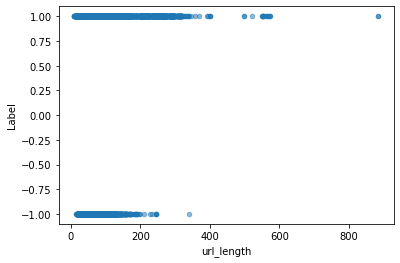

In [6]:
url_dataset.plot.scatter(x="url_length", y="Label", alpha=0.5)

In [7]:

one_hot = pd.get_dummies(url_dataset['protocol'])
print(one_hot)
url_dataset.drop('protocol',axis=1,inplace=True)

url_dataset = url_dataset.join(one_hot)


       None  http  https
0         1     0      0
1         1     0      0
2         1     0      0
3         1     0      0
4         1     0      0
...     ...   ...    ...
22430     0     0      1
22431     0     0      1
22432     0     0      1
22433     0     1      0
22434     0     1      0

[22435 rows x 3 columns]


In [8]:
url_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22435 entries, 0 to 22434
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   url                     22435 non-null  object 
 1   Label                   22435 non-null  int64  
 2   url_length              22435 non-null  int64  
 3   subdomain               13179 non-null  object 
 4   domain                  22435 non-null  object 
 5   tld                     22364 non-null  object 
 6   tld_digit_count         22435 non-null  int64  
 7   domain_digit_count      22435 non-null  int64  
 8   subdomain_digit_count   22435 non-null  int64  
 9   tld_length              22435 non-null  int64  
 10  subdomain_length        22435 non-null  int64  
 11  domain_length           22435 non-null  int64  
 12  isKnown_tld             22435 non-null  bool   
 13  issubdomainwww          22435 non-null  bool   
 14  count_of_special_char   22435 non-null

In [73]:
url_dataset.tail(10).T

,22425,22426,22427,22428,22429,22430,22431,22432,22433,22434
url,http://www.buzzle.com/articles/osi-model-expla...,http://www.certbros.com/featured/osi-model-exp...,http://computerguru.net/OSI,http://www.sqa.org.uk/e-learning/NetTechDC01BC...,http://everything.explained.today/OSI_model/,https://knowcitrixx.wordpress.com/2014/11/22/o...,https://www.youtube.com/watch?v=e5DEVa9eSN0,https://en.wikipedia.org/wiki/Market_segmentation,http://www.netmba.com/marketing/market/segment...,http://www.investopedia.com/terms/m/marketsegm...
Label,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
url_length,55,53,27,59,44,74,43,49,52,58
subdomain,www,www,NaN,www,everything,knowcitrixx,www,en,www,www
domain,buzzle,certbros,computerguru,sqa,explained,wordpress,youtube,wikipedia,netmba,investopedia
tld,com,com,net,org.uk,today,com,com,org,com,com
tld_digit_count,0,0,0,0,0,0,0,0,0,0
domain_digit_count,0,0,0,0,0,0,0,0,0,0
subdomain_digit_count,0,0,0,0,0,0,0,0,0,0
tld_length,3,3,3,6,5,3,3,3,3,3


In [10]:
corr_mat =url_dataset.corr()
#print(corr_mat)

for x in range(0,len(corr_mat),1):
    corr_mat.iloc[x,x]=0
#print(corr_mat)
    
    
s=corr_mat['Label'].abs().sort_values()
print(s)
s=s[s>0.005]
print("after")
print(s)
s.index

Label                     0.000000
brand_name_count          0.003342
negligible_word_count     0.010515
compound_word_count       0.014230
tld_digit_count           0.016933
count //                  0.017953
domaincount _             0.018941
similar_brand_count       0.036813
target_brand_count        0.036813
shortest_word_length      0.046776
subdomain_digit_count     0.055649
isKnown_tld               0.071741
domain_digit_count        0.081173
None                      0.091166
domaincount -             0.093230
splitted_word_count       0.097825
raw_word_count            0.108729
average_word_length       0.117629
average_compound_words    0.118406
subdomain_length          0.127308
target_keyword_count      0.130654
similar_keyword_count     0.130654
count_of_special_char     0.136697
tld_length                0.146839
longest_word_length       0.155661
domaincount .             0.158640
std_word_length           0.159171
count @                   0.192368
url_length          

Index(['negligible_word_count', 'compound_word_count', 'tld_digit_count',
       'count //', 'domaincount _', 'similar_brand_count',
       'target_brand_count', 'shortest_word_length', 'subdomain_digit_count',
       'isKnown_tld', 'domain_digit_count', 'None', 'domaincount -',
       'splitted_word_count', 'raw_word_count', 'average_word_length',
       'average_compound_words', 'subdomain_length', 'target_keyword_count',
       'similar_keyword_count', 'count_of_special_char', 'tld_length',
       'longest_word_length', 'domaincount .', 'std_word_length', 'count @',
       'url_length', 'count .', 'domain_length', 'keyword_count',
       'random_words', 'count -', 'issubdomainwww', 'http', 'https'],
      dtype='object')

In [11]:


column_name = [col for col in url_dataset.columns if col in s.index]

print(column_name)
x_dataset = url_dataset[column_name]
print(x_dataset)

y_dataset = url_dataset['Label']
print(y_dataset)

['url_length', 'tld_digit_count', 'domain_digit_count', 'subdomain_digit_count', 'tld_length', 'subdomain_length', 'domain_length', 'isKnown_tld', 'issubdomainwww', 'count_of_special_char', 'count .', 'count -', 'count @', 'count //', 'domaincount -', 'domaincount .', 'domaincount _', 'raw_word_count', 'splitted_word_count', 'average_word_length', 'longest_word_length', 'shortest_word_length', 'std_word_length', 'compound_word_count', 'keyword_count', 'negligible_word_count', 'target_brand_count', 'target_keyword_count', 'similar_keyword_count', 'similar_brand_count', 'average_compound_words', 'random_words', 'None', 'http', 'https']
       url_length  tld_digit_count  domain_digit_count  subdomain_digit_count  \
0              17                0                   0                      0   
1              17                0                   0                      0   
2              64                0                   2                      7   
3              64                0

In [12]:
from sklearn.preprocessing import RobustScaler

column_names =x_dataset.columns
scaler =  RobustScaler(quantile_range=(25, 75))
print(scaler)
x_dat = scaler.fit_transform(x_dataset)
print(x_dat)

x_dataset =pd.DataFrame(x_dat,columns=column_names)



RobustScaler(quantile_range=(25, 75))
[[-1.18181818  0.          0.         ...  1.         -1.
   0.        ]
 [-1.18181818  0.          0.         ...  1.         -1.
   0.        ]
 [ 0.24242424  0.          2.         ...  1.         -1.
   0.        ]
 ...
 [-0.21212121  0.          0.         ...  0.         -1.
   1.        ]
 [-0.12121212  0.          0.         ...  0.          0.
   0.        ]
 [ 0.06060606  0.          0.         ...  0.          0.
   0.        ]]


In [77]:
from sklearn.preprocessing import MinMaxScaler

column_names =x_dataset.columns
scaler = MinMaxScaler()
x_dat = scaler.fit_transform(x_dataset)

x_dataset =pd.DataFrame(x_dat,columns=column_names)



In [78]:
print(x_dataset)

       url_length  tld_digit_count  domain_digit_count  subdomain_digit_count  \
0        0.009132              0.0            0.000000               0.000000   
1        0.009132              0.0            0.000000               0.000000   
2        0.062785              0.0            0.166667               0.106061   
3        0.062785              0.0            0.166667               0.106061   
4        0.010274              0.0            0.166667               0.000000   
...           ...              ...                 ...                    ...   
22430    0.074201              0.0            0.000000               0.000000   
22431    0.038813              0.0            0.000000               0.000000   
22432    0.045662              0.0            0.000000               0.000000   
22433    0.049087              0.0            0.000000               0.000000   
22434    0.055936              0.0            0.000000               0.000000   

       tld_length  subdomai

In [99]:

y_test.value_counts()

-1    2342
 1    2145
Name: Label, dtype: int64

In [80]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(x_dataset,y_dataset,test_size=0.20,random_state=10)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 17948 samples.
Testing set has 4487 samples.


In [81]:
X_train.head()

,url_length,tld_digit_count,domain_digit_count,subdomain_digit_count,tld_length,subdomain_length,domain_length,isKnown_tld,issubdomainwww,count_of_special_char,...,negligible_word_count,target_brand_count,target_keyword_count,similar_keyword_count,similar_brand_count,average_compound_words,random_words,None,http,https
4035,0.087900,0.0,0.0,0.0,0.272727,0.000000,0.145833,1.0,0.0,0.092784,...,0.058824,0.0,0.0625,0.0625,0.0,0.185185,0.052632,0.0,1.0,0.0
21605,0.025114,0.0,0.0,0.0,0.272727,0.000000,0.104167,1.0,0.0,0.030928,...,0.039216,0.0,0.0000,0.0000,0.0,0.203704,0.000000,0.0,0.0,1.0
20921,0.033105,0.0,0.0,0.0,0.272727,0.015385,0.166667,1.0,0.0,0.051546,...,0.078431,0.0,0.0000,0.0000,0.0,0.157407,0.000000,0.0,0.0,1.0
10480,0.076484,0.0,0.0,0.0,0.272727,0.000000,0.083333,1.0,0.0,0.113402,...,0.137255,0.0,0.0000,0.0000,0.0,0.148148,0.000000,0.0,1.0,0.0
9890,0.237443,0.0,0.0,0.0,0.272727,0.000000,0.187500,1.0,0.0,0.154639,...,0.117647,0.0,0.0000,0.0000,0.0,0.185185,0.105263,0.0,1.0,0.0


In [82]:
y_train.value_counts()

-1    9351
 1    8597
Name: Label, dtype: int64

In [83]:
X_test.head()

,url_length,tld_digit_count,domain_digit_count,subdomain_digit_count,tld_length,subdomain_length,domain_length,isKnown_tld,issubdomainwww,count_of_special_char,...,negligible_word_count,target_brand_count,target_keyword_count,similar_keyword_count,similar_brand_count,average_compound_words,random_words,None,http,https
21449,0.025114,0.0,0.0,0.0,0.272727,0.000000,0.104167,1.0,0.0,0.030928,...,0.019608,0.000000,0.0625,0.0625,0.000000,0.166667,0.000000,0.0,0.0,1.0
10430,0.068493,0.0,0.0,0.0,0.272727,0.000000,0.333333,1.0,0.0,0.092784,...,0.058824,0.083333,0.0625,0.0625,0.083333,0.240741,0.000000,0.0,1.0,0.0
8443,0.049087,0.0,0.0,0.0,0.272727,0.000000,0.208333,1.0,0.0,0.082474,...,0.078431,0.083333,0.0000,0.0000,0.083333,0.148148,0.000000,0.0,1.0,0.0
22228,0.054795,0.0,0.0,0.0,0.272727,0.023077,0.208333,1.0,1.0,0.092784,...,0.078431,0.000000,0.0000,0.0000,0.000000,0.148148,0.052632,0.0,1.0,0.0
19731,0.090183,0.0,0.0,0.0,0.272727,0.023077,0.125000,0.0,1.0,0.123711,...,0.098039,0.000000,0.1250,0.1250,0.000000,0.154321,0.000000,0.0,0.0,1.0


In [84]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4487 entries, 21449 to 20385
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   url_length              4487 non-null   float64
 1   tld_digit_count         4487 non-null   float64
 2   domain_digit_count      4487 non-null   float64
 3   subdomain_digit_count   4487 non-null   float64
 4   tld_length              4487 non-null   float64
 5   subdomain_length        4487 non-null   float64
 6   domain_length           4487 non-null   float64
 7   isKnown_tld             4487 non-null   float64
 8   issubdomainwww          4487 non-null   float64
 9   count_of_special_char   4487 non-null   float64
 10  count .                 4487 non-null   float64
 11  count -                 4487 non-null   float64
 12  count @                 4487 non-null   float64
 13  count //                4487 non-null   float64
 14  domaincount -           4487 non-nu

# ANN Model

In [111]:
import tensorflow as tf
from keras import losses,optimizers,metrics

In [112]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout

In [113]:
Y_train = pd.get_dummies(y_train)
Y_test = pd.get_dummies(y_test)
print(X_train.shape[1],)

35


In [114]:
model = Sequential()
model.add(Dense(1024,activation='relu',input_shape=(X_train.shape[1],)))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.0001),loss = losses.binary_crossentropy,metrics=['accuracy'])

history = model.fit(X_train,Y_train, validation_split=(0.2), epochs=50,batch_size=32,verbose=1)





Epoch 1/50
449/449 [==============================] - 12s 26ms/step - loss: 0.4948 - accuracy: 0.7658 - val_loss: 0.3971 - val_accuracy: 0.8123
Epoch 2/50
449/449 [==============================] - 12s 26ms/step - loss: 0.3428 - accuracy: 0.8441 - val_loss: 0.3538 - val_accuracy: 0.8340
Epoch 3/50
449/449 [==============================] - 13s 28ms/step - loss: 0.3225 - accuracy: 0.8581 - val_loss: 0.3270 - val_accuracy: 0.8468
Epoch 4/50
449/449 [==============================] - 11s 25ms/step - loss: 0.3041 - accuracy: 0.8659 - val_loss: 0.3194 - val_accuracy: 0.8618
Epoch 5/50
449/449 [==============================] - 12s 27ms/step - loss: 0.3028 - accuracy: 0.8686 - val_loss: 0.2911 - val_accuracy: 0.8755
Epoch 6/50
449/449 [==============================] - 12s 26ms/step - loss: 0.2978 - accuracy: 0.8720 - val_loss: 0.3468 - val_accuracy: 0.8510
Epoch 7/50
449/449 [==============================] - 11s 25ms/step - loss: 0.2846 - accuracy: 0.8748 - val_loss: 0.2756 - val_accuracy:

In [115]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              36864     
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 1026      
Total params: 1,874,946
Trainable params: 1,874,946
Non-trainable params: 0
____________________________________________

In [117]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))

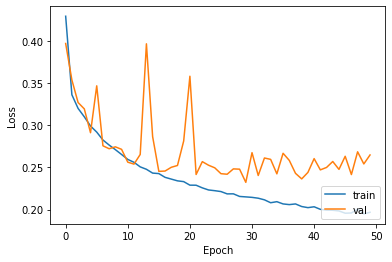

In [118]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'],loc=4)

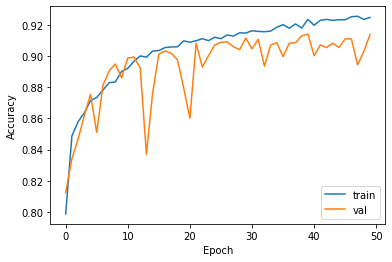

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train','val'],loc=4)

In [120]:
history.history

{'loss': [0.4293860197067261,
  0.33620119094848633,
  0.3199833333492279,
  0.31003546714782715,
  0.29911068081855774,
  0.29187092185020447,
  0.28249654173851013,
  0.2764957845211029,
  0.27104508876800537,
  0.2653086483478546,
  0.25945034623146057,
  0.2560272216796875,
  0.25060462951660156,
  0.24773810803890228,
  0.24321281909942627,
  0.24262666702270508,
  0.2381846308708191,
  0.23609881103038788,
  0.2340175062417984,
  0.2330896258354187,
  0.22889444231987,
  0.22882282733917236,
  0.2256881147623062,
  0.2231975495815277,
  0.2223389893770218,
  0.22129704058170319,
  0.21854105591773987,
  0.2185976505279541,
  0.21550358831882477,
  0.21497246623039246,
  0.21441057324409485,
  0.2134103626012802,
  0.21148048341274261,
  0.2080436795949936,
  0.20928429067134857,
  0.20662306249141693,
  0.2058127075433731,
  0.20660628378391266,
  0.20353244245052338,
  0.20220905542373657,
  0.20323574542999268,
  0.20020882785320282,
  0.1992216259241104,
  0.19911406934261322,

In [122]:
results = model.evaluate(X_test, Y_test, batch_size=128)
print('test loss, test acc:', results)

36/36 [==============================] - 0s 8ms/step - loss: 0.2473 - accuracy: 0.9209
test loss, test acc: [0.24728041887283325, 0.920882523059845]


In [123]:

from sklearn.metrics import confusion_matrix,classification_report
ytest1 = np.argmax(np.array(Y_test), axis=1)
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

cm=confusion_matrix(ytest1,y_pred)
print("confusion matrix : \n" ,cm)


confusion matrix : 
 [[2133  209]
 [ 146 1999]]


In [124]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(ytest1,y_pred)
print('Accuracy: %f' % accuracy)

precision = precision_score(ytest1,y_pred)
print('Precision: %f' % precision)

recall = recall_score(ytest1,y_pred)
print('Recall: %f' % recall)

f1 = f1_score(ytest1,y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.920883
Precision: 0.905344
Recall: 0.931935
F1 score: 0.918447
